In [1]:
import math
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from random import shuffle
from torchvision.models import efficientnet_b0
from GAN import GAN, Discriminator, Generator
from Discriminators import *
from Generators import *
import copy
from tqdm import tqdm
import torch.optim as optim
from utils import *
from collections import Counter
import time

/data/cino/conda/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/data/cino/conda/anaconda3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
args = {
    'lr': 1e-4, 
    'bs': 512, 
    'epochs': 20, 
    'epochs_generator': 200, 
    'num_tasks': 5,
    'dataset': "MNIST",
    'num_classes': 10, 
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 50
    }

In [3]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

In [4]:
train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)

In [5]:
class_split

{'0': [6, 4], '1': [0, 3], '2': [8, 1], '3': [9, 5], '4': [2, 7]}

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data', 
                          train=True,
                          download=True,
                          transform=transform)
val_ds = datasets.MNIST(root='./data', 
                          train=False,
                          download=True,
                          transform=transform)

In [7]:
# Build dataloader
dl = DataLoader(dataset=train_ds, shuffle=True, batch_size=256)
dl_validation = DataLoader(dataset=val_ds, shuffle=False, batch_size=256)

In [8]:
classifier = efficientnet_b0()

#changing input features to handle grayscale image
#get old parameters
out_channels = classifier.features[0][0].out_channels
stride = classifier.features[0][0].stride
padding = classifier.features[0][0].padding
bias = classifier.features[0][0].bias
kernel_size = classifier.features[0][0].kernel_size

classifier.features[0][0] = nn.Conv2d(
    args['n_channels'], 
    out_channels, 
    kernel_size = kernel_size, 
    stride = stride, 
    padding = padding, 
    bias = bias
)

#changing last layer to adapt to the number of classes
fc_in_features = classifier.classifier[1].in_features
classifier.classifier[1] = nn.Linear(fc_in_features, args['num_classes'])

## Standard Task

In [9]:
classifier_ = copy.deepcopy(classifier).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_.parameters(), lr=0.001)

In [10]:
# Training and validation loop
num_epochs = 5

for epoch in range(num_epochs):
    # Training phase
    classifier_.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dl, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        optimizer.zero_grad()
        outputs = classifier_(inputs.cuda()).cpu()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss /= len(dl)
    train_accuracy = 100 * correct / total

    # Validation phase
    classifier_.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_inputs, val_labels in tqdm(dl_validation, desc="Validation", unit="batch"):
            val_outputs = classifier_(val_inputs.cuda()).cpu()
            val_loss = criterion(val_outputs, val_labels)
            validation_loss += val_loss.item()

            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    validation_loss /= len(dl_validation)
    validation_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {validation_loss:.4f}, '
          f'Validation Accuracy: {validation_accuracy:.2f}%')

Validation: 100%|████████████████████████████| 40/40 [00:01<00:00, 39.16batch/s]


Epoch [1/5], Train Loss: 0.5382, Train Accuracy: 82.22%, Validation Loss: 0.1072, Validation Accuracy: 96.63%


Validation: 100%|████████████████████████████| 40/40 [00:01<00:00, 38.73batch/s]


Epoch [2/5], Train Loss: 0.1007, Train Accuracy: 96.90%, Validation Loss: 0.0663, Validation Accuracy: 97.92%


Validation: 100%|████████████████████████████| 40/40 [00:01<00:00, 39.50batch/s]


Epoch [3/5], Train Loss: 0.0653, Train Accuracy: 97.99%, Validation Loss: 0.0603, Validation Accuracy: 97.99%


Validation: 100%|████████████████████████████| 40/40 [00:01<00:00, 39.94batch/s]


Epoch [4/5], Train Loss: 0.0492, Train Accuracy: 98.49%, Validation Loss: 0.0531, Validation Accuracy: 98.38%


Validation: 100%|████████████████████████████| 40/40 [00:00<00:00, 40.14batch/s]

Epoch [5/5], Train Loss: 0.0406, Train Accuracy: 98.81%, Validation Loss: 0.0532, Validation Accuracy: 98.53%


## Deep Generative Continual Learning

In [11]:
class AgentDeepGenerativeCL:
    def __init__(
            self, 
            args, 
            train_datasets, 
            val_datasets, 
            solver, 
            generator
    ):
        self.args = args
        self.model = solver
        #To restart the training of sover from scratch
        self.model_init = copy.deepcopy(solver)
        self.generator = generator
        #To restart the training of generator from scratch
        self.generator_init = copy.deepcopy(generator)
        self.criterion_solver = torch.nn.CrossEntropyLoss()
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets
        self.relevant_classes = []
    
    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}


    def train(self, class_split):
        
        for task, data in self.train_datasets.items():
            data_train = self.generateDataloader(task, data)

            ## Once used to generate data reset the generator
            self.generator = copy.deepcopy(self.generator_init)
            ## Once used to generate data reset the solver
            self.model = copy.deepcopy(self.model_init)

            show_random_images_grid(data_train)

            targets = []
            for data in data_train:
                targets.append(data[1])

            # Get class counts
            class_counts = Counter(np.array(targets))
            
            # Ensure the counts are in the correct order of classes
            class_counts = [class_counts[i] for i in range(self.args['num_classes'])]
            
            # Convert categories to string
            categories = [str(i) for i in range(self.args['num_classes'])]
            
            # Create the bar plot
            plt.figure(figsize=(10, 6))
            plt.bar(categories, class_counts, color='blue')
            
            # Add title and labels
            plt.title('Bar Plot for count of generated labels')
            plt.xlabel('Categories')
            plt.ylabel('Counts')
            
            # Set x-ticks to ensure all categories are labeled
            plt.xticks(categories, rotation=45, ha='right')
            
            # Display the plot
            plt.tight_layout()
            plt.show()
            
            self.optimizer_solver = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
            loader = DataLoader(data_train, batch_size=self.args['bs'])

            self.relevant_classes = self.relevant_classes + class_split[task]

            self.model = self.model.train().cuda()
            self.generator = self.generator.train().cuda()

            start = time.time()
            
            for epoch in range(self.args['epochs']):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(loader):
                    if torch.cuda.is_available():
                        X, y = X.cuda(), y.cuda()
                    output = self.model(X)
                     # Select the relevant outputs
                    #task_output = output[:, relevant_classes]

                    loss = self.criterion_solver(output, y)
                    self.optimizer_solver.zero_grad()
                    loss.backward() 
                    self.optimizer_solver.step()

                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y)
                    total += len(X)

                    if e % 50 == 0:
                        self.validate()
                print(f"Epoch {epoch}: Loss {epoch_loss/(e+1):.3f} Acc: {correct/total:.3f}")

            end = time.time()
            print("Time to train the solver on task ", task, " ", end - start)
            
            self.validate(end_of_epoch=True)
            print(self.relevant_classes)

            start = time.time()
            self.generator.train_gan(loader, n_epochs = self.args['epochs_generator'])
            end = time.time()
            print("Time to train the generator on task ", task, " ", end - start)


    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval().cuda()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=args['bs'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                if torch.cuda.is_available():
                    X, y = X.cuda(), y.cuda()
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()

    def generateDataloader(self, task, data, max_tries = 300000):
        generated_images_tensors = []
        generated_labels_tensors = []
        generated_images = 0

        if int(task) == 0:
            return data

        self.generator.eval()
        self.model.eval()

        #to generate a balanced dataset
        num_classes_per_task = self.args['num_classes']/self.args['num_tasks']
        data_length = len(data)
        min_class_instances = int((data_length / num_classes_per_task) * 0.9)
        max_class_instances = int((data_length / num_classes_per_task) * 1.1)

        # Dictionary to count instances of each class
        class_counts = [ 0 for i in range(self.args['num_classes'])]

        start = time.time()

        # trying to generate a dataset as much balanced is possible 
        while (np.array([class_counts[i] for i in self.relevant_classes]) < min_class_instances).any() and generated_images < max_tries:
            generated_images += 1
            image = self.generator()
            output = self.model(image)[0]

            # Ignore all the class not yet seen
            # Create a mask of the same length as the tensor
            mask = torch.zeros_like(output, dtype=torch.bool)
            # Set the relevant indices to True in the mask
            mask[self.relevant_classes] = True
            # Set elements where the mask is False to negative infinity
            output[~mask] = -float('inf')
            
            label = torch.argmax(output).cpu().detach()
            index_label = int(label)
            image = image.cpu().detach()
            
            #verifing there are not too many examples for this class
            if class_counts[index_label] < max_class_instances:
                class_counts[index_label] += 1
                generated_images_tensors.append(image)
                generated_labels_tensors.append(label.view(1))

        
        self.generator.train()
        self.model.train()
        
        generated_data = TensorDataset(torch.cat(generated_images_tensors), torch.cat(generated_labels_tensors))

        end = time.time()
        print("Time to generate the data", end - start)
        return ConcatDataset([data, generated_data])

In [12]:
# Instantiate Discriminator and Generator
d = DiscriminatorConv()
g = GeneratorConv()

#gan = GAN(g, d)

In [13]:
# Instantiate Discriminator and Generator
#d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)

gan = GAN(
    g, 
    d,
    d_lr = 0.00005,
    g_lr = 0.0005
)

In [14]:
agent = AgentDeepGenerativeCL(args, 
                              train_tasks, 
                              val_tasks, 
                              classifier, 
                              gan
                             )

In [15]:
agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()

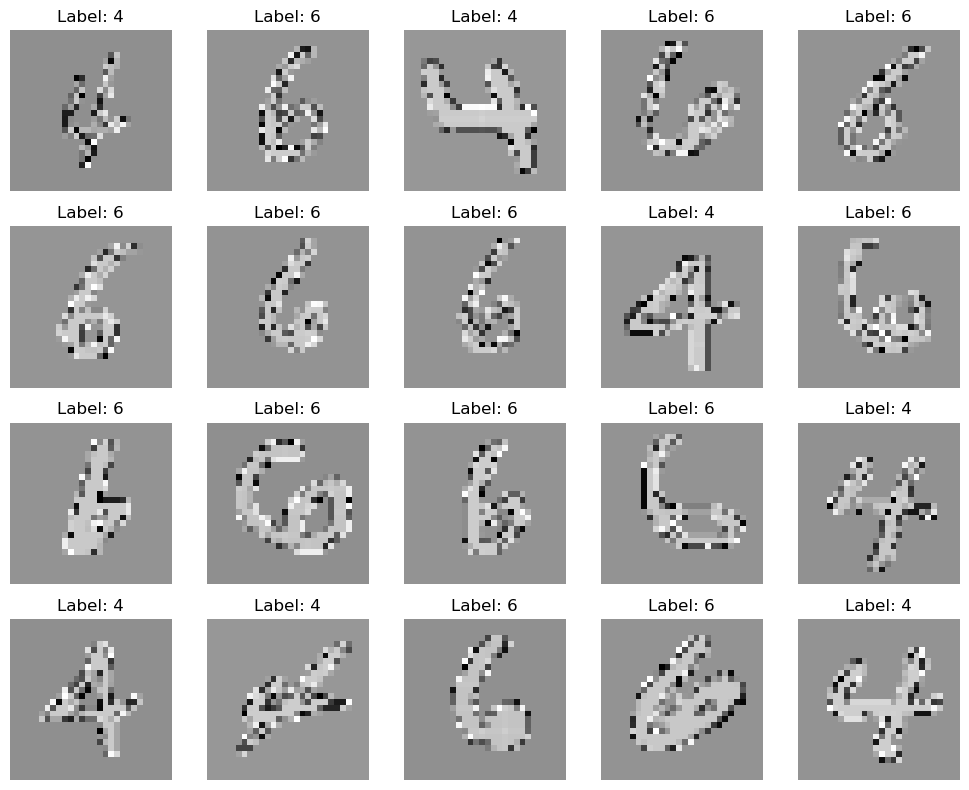

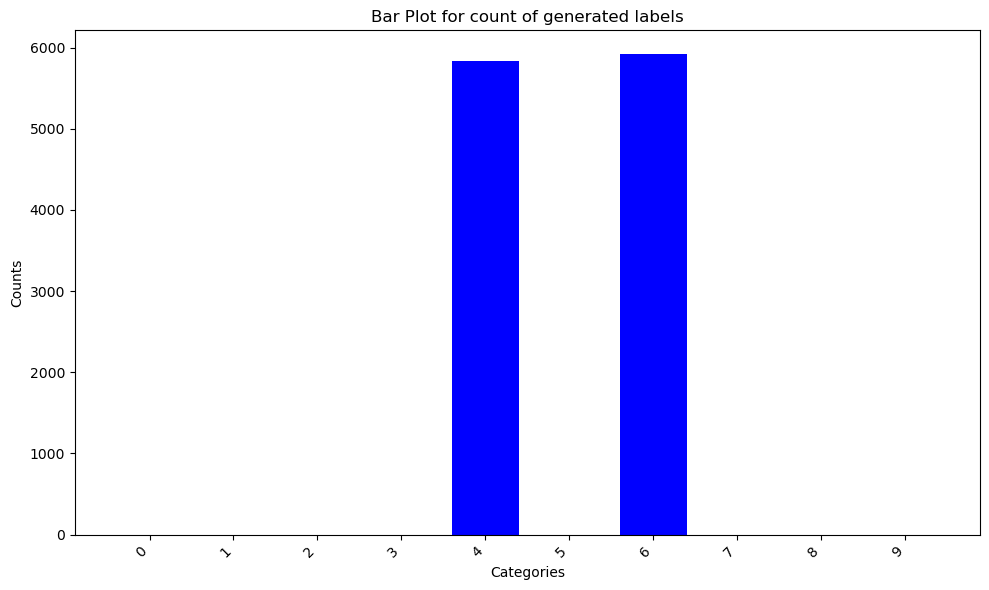

Epoch 0: Loss 2.029 Acc: 0.486
Epoch 1: Loss 1.085 Acc: 0.798
Epoch 2: Loss 0.335 Acc: 0.928
Epoch 3: Loss 0.135 Acc: 0.966
Epoch 4: Loss 0.087 Acc: 0.979
Epoch 5: Loss 0.063 Acc: 0.985
Epoch 6: Loss 0.047 Acc: 0.988
Epoch 7: Loss 0.037 Acc: 0.991
Epoch 8: Loss 0.032 Acc: 0.992
Epoch 9: Loss 0.028 Acc: 0.993
Epoch 10: Loss 0.023 Acc: 0.994
Epoch 11: Loss 0.018 Acc: 0.995
Epoch 12: Loss 0.017 Acc: 0.995
Epoch 13: Loss 0.015 Acc: 0.996
Epoch 14: Loss 0.013 Acc: 0.997
Epoch 15: Loss 0.012 Acc: 0.997
Epoch 16: Loss 0.013 Acc: 0.996
Epoch 17: Loss 0.011 Acc: 0.997
Epoch 18: Loss 0.009 Acc: 0.997
Epoch 19: Loss 0.011 Acc: 0.998
Time to train the solver on task  0   75.84703826904297
[6, 4]
Training on [cuda]...
Epoch [1/200]:
epoch_d_loss: 0.834278 	epoch_g_loss: 1.278553
Epoch [2/200]:
epoch_d_loss: 0.411995 	epoch_g_loss: 1.629366
Epoch [3/200]:
epoch_d_loss: 0.816000 	epoch_g_loss: 1.295067
Epoch [4/200]:
epoch_d_loss: 0.611482 	epoch_g_loss: 1.625249
Epoch [5/200]:
epoch_d_loss: 0.238050

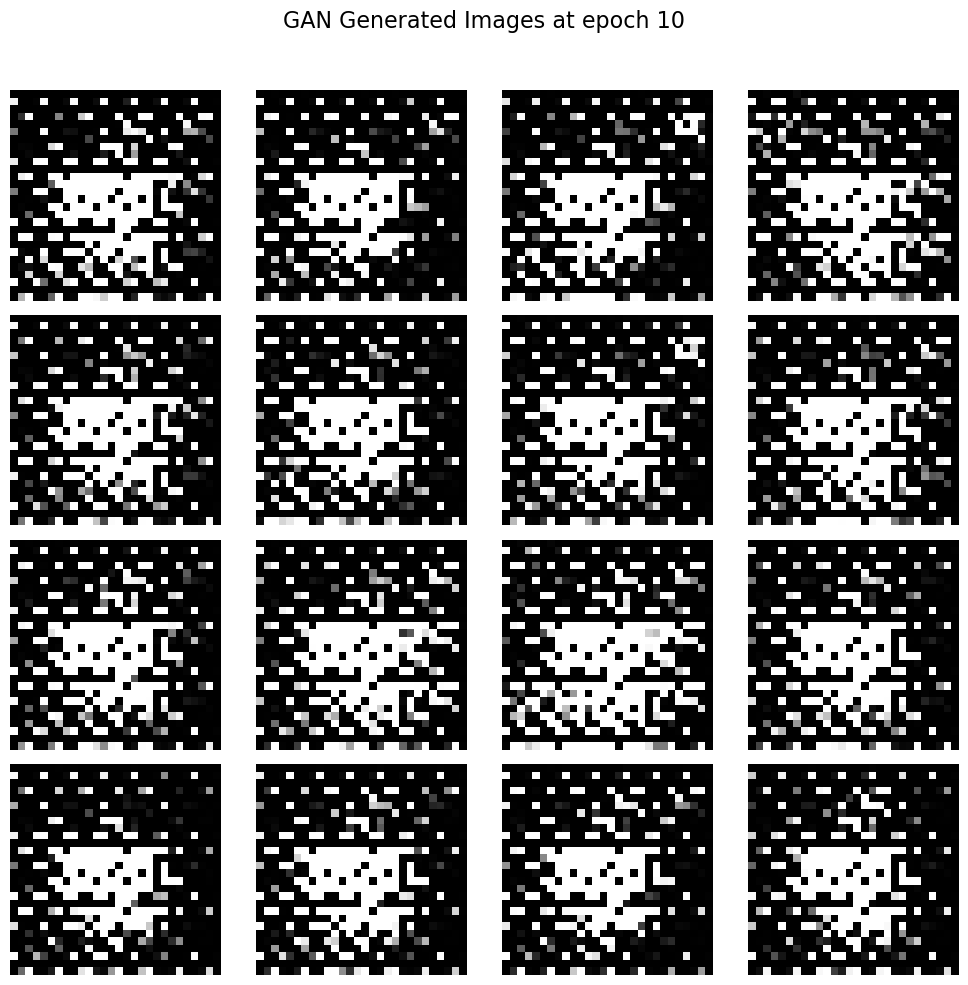

Epoch [11/200]:
epoch_d_loss: 0.216803 	epoch_g_loss: 2.895048
Epoch [12/200]:
epoch_d_loss: 0.211483 	epoch_g_loss: 3.113164
Epoch [13/200]:
epoch_d_loss: 0.062568 	epoch_g_loss: 3.866751
Epoch [14/200]:
epoch_d_loss: 0.111899 	epoch_g_loss: 3.398156
Epoch [15/200]:
epoch_d_loss: 0.063143 	epoch_g_loss: 3.778171
Epoch [16/200]:
epoch_d_loss: 0.020171 	epoch_g_loss: 4.903932
Epoch [17/200]:
epoch_d_loss: 0.023170 	epoch_g_loss: 4.400375
Epoch [18/200]:
epoch_d_loss: 0.024935 	epoch_g_loss: 4.301649
Epoch [19/200]:
epoch_d_loss: 0.051645 	epoch_g_loss: 3.795762
Epoch [20/200]:
epoch_d_loss: 0.076865 	epoch_g_loss: 4.348976


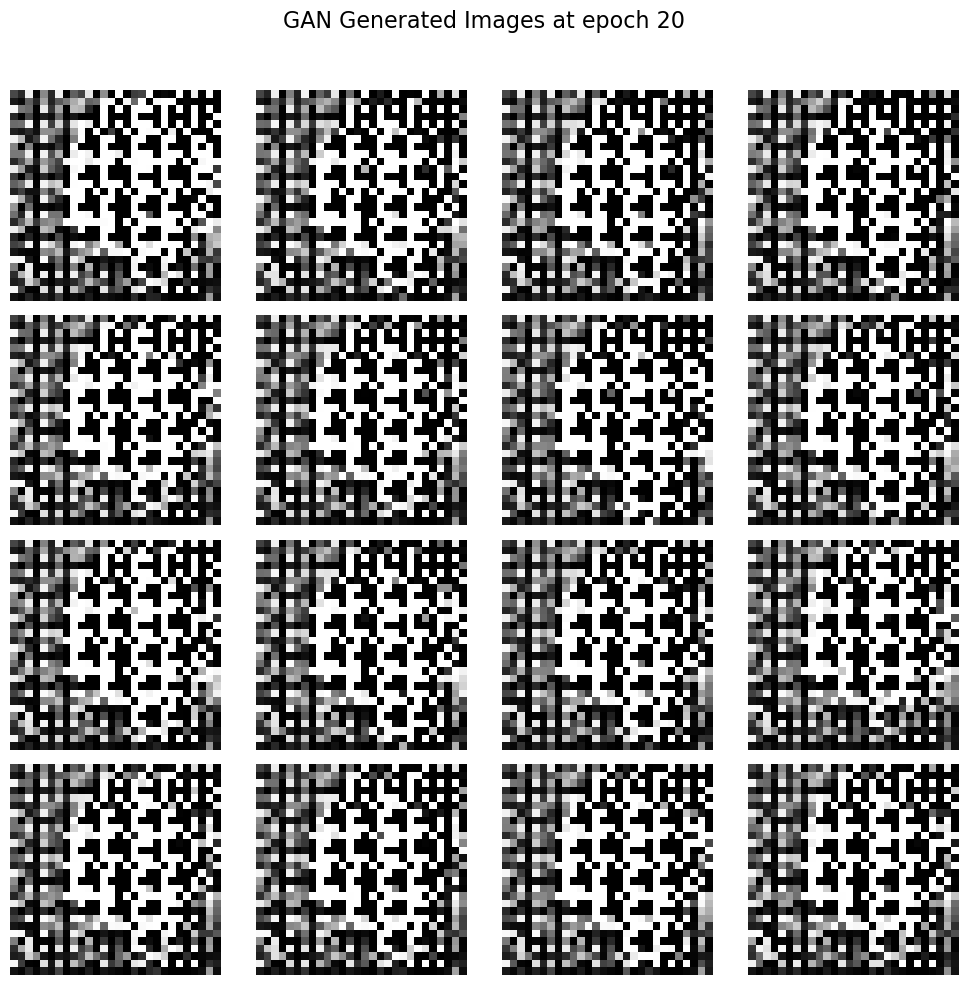

Epoch [21/200]:
epoch_d_loss: 0.072369 	epoch_g_loss: 3.969069
Epoch [22/200]:
epoch_d_loss: 0.078510 	epoch_g_loss: 3.900197
Epoch [23/200]:
epoch_d_loss: 0.047807 	epoch_g_loss: 4.408890
Epoch [24/200]:
epoch_d_loss: 0.030827 	epoch_g_loss: 4.498523
Epoch [25/200]:
epoch_d_loss: 0.056440 	epoch_g_loss: 4.069765
Epoch [26/200]:
epoch_d_loss: 0.108487 	epoch_g_loss: 4.032077
Epoch [27/200]:
epoch_d_loss: 0.145865 	epoch_g_loss: 3.714012
Epoch [28/200]:
epoch_d_loss: 0.119353 	epoch_g_loss: 3.912611
Epoch [29/200]:
epoch_d_loss: 0.126391 	epoch_g_loss: 3.806681
Epoch [30/200]:
epoch_d_loss: 0.094348 	epoch_g_loss: 4.023187


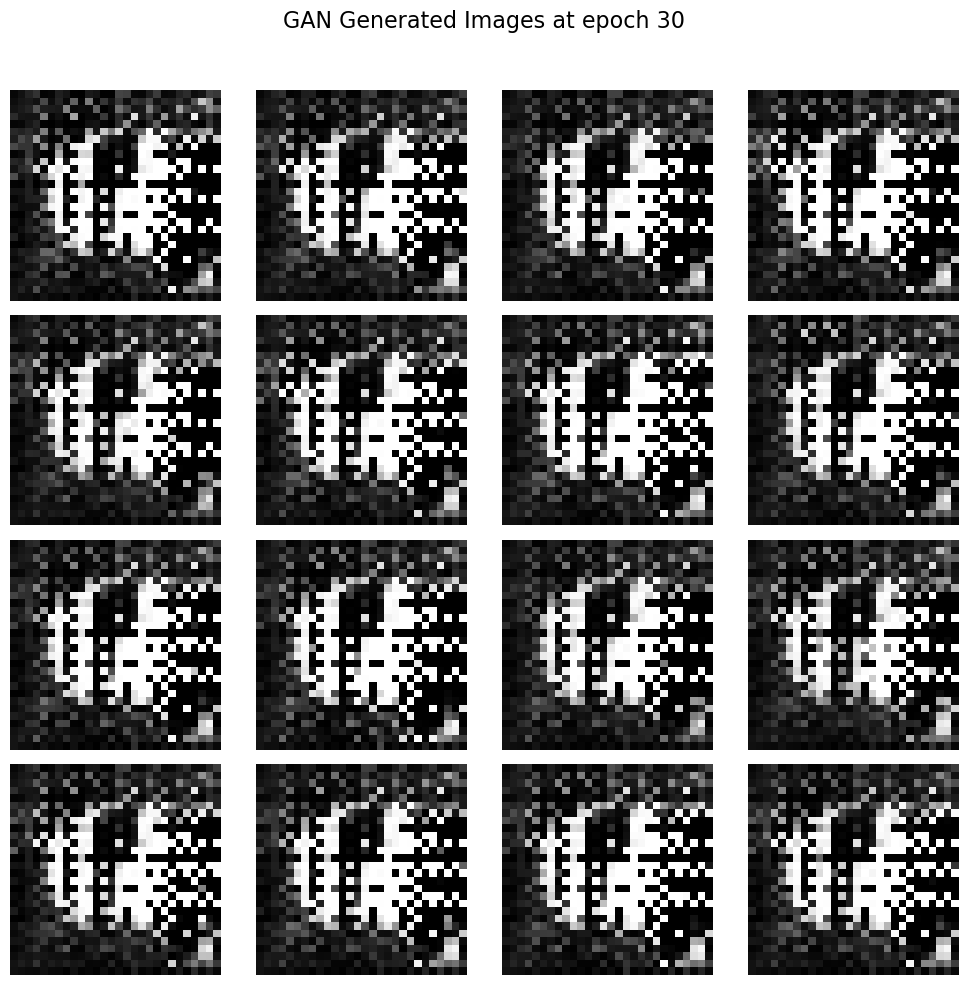

Epoch [31/200]:
epoch_d_loss: 0.089720 	epoch_g_loss: 4.269568
Epoch [32/200]:
epoch_d_loss: 0.031765 	epoch_g_loss: 4.994178
Epoch [33/200]:
epoch_d_loss: 0.045666 	epoch_g_loss: 4.334050
Epoch [34/200]:
epoch_d_loss: 0.065967 	epoch_g_loss: 4.132139
Epoch [35/200]:
epoch_d_loss: 0.038661 	epoch_g_loss: 4.734214
Epoch [36/200]:
epoch_d_loss: 0.013670 	epoch_g_loss: 5.547395
Epoch [37/200]:
epoch_d_loss: 0.028793 	epoch_g_loss: 4.460441
Epoch [38/200]:
epoch_d_loss: 0.095305 	epoch_g_loss: 4.074385
Epoch [39/200]:
epoch_d_loss: 0.075841 	epoch_g_loss: 4.475573
Epoch [40/200]:
epoch_d_loss: 0.038375 	epoch_g_loss: 4.596335


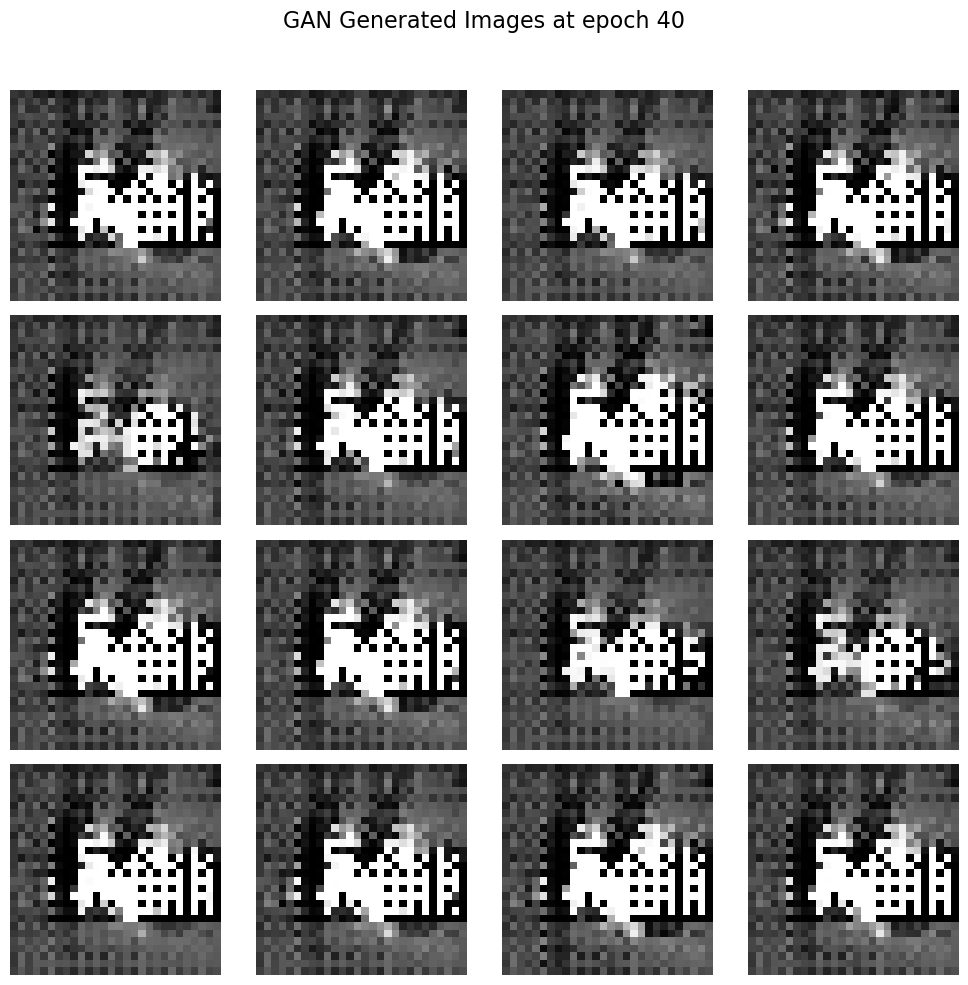

Epoch [41/200]:
epoch_d_loss: 0.042624 	epoch_g_loss: 4.762360
Epoch [42/200]:
epoch_d_loss: 0.083911 	epoch_g_loss: 4.967178
Epoch [43/200]:
epoch_d_loss: 0.129607 	epoch_g_loss: 4.399023
Epoch [44/200]:
epoch_d_loss: 0.247816 	epoch_g_loss: 3.679459
Epoch [45/200]:
epoch_d_loss: 0.200993 	epoch_g_loss: 3.769577
Epoch [46/200]:
epoch_d_loss: 0.266689 	epoch_g_loss: 4.005853
Epoch [47/200]:
epoch_d_loss: 0.263929 	epoch_g_loss: 4.141713
Epoch [48/200]:
epoch_d_loss: 0.166129 	epoch_g_loss: 3.839633
Epoch [49/200]:
epoch_d_loss: 0.119032 	epoch_g_loss: 3.959441
Epoch [50/200]:
epoch_d_loss: 0.170522 	epoch_g_loss: 4.166310


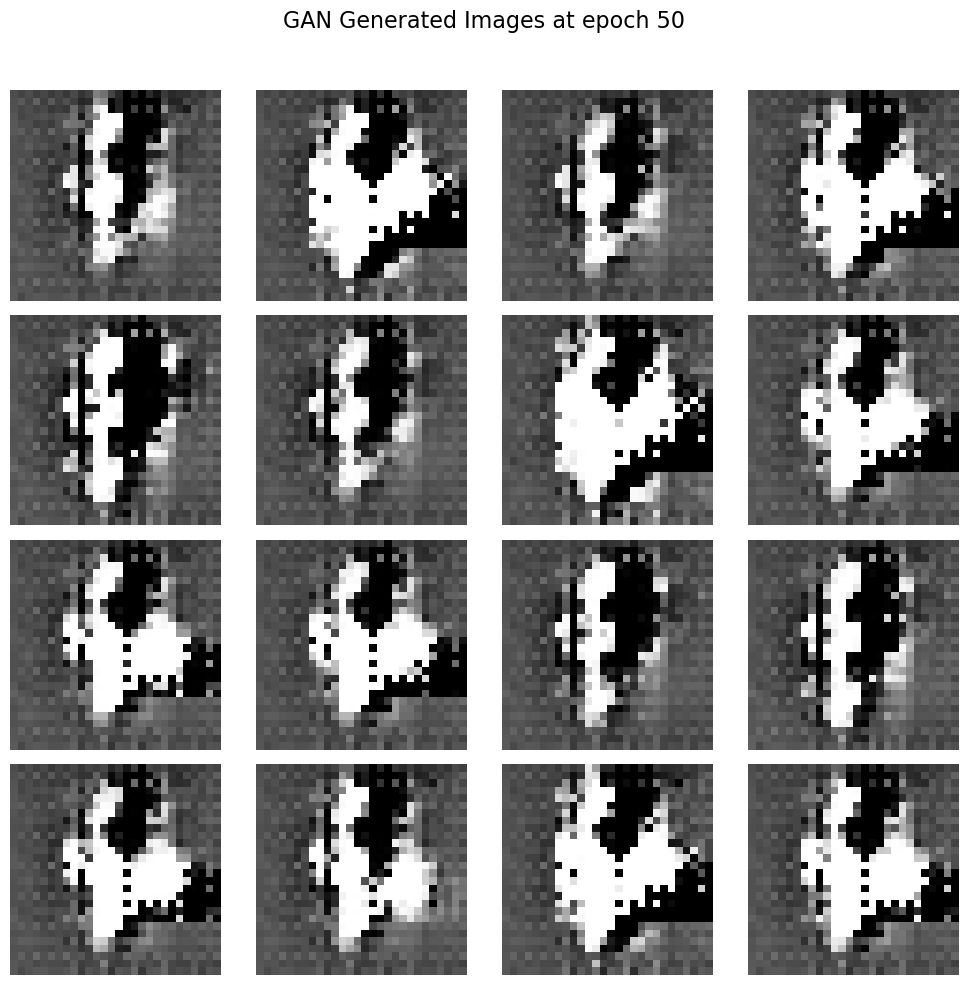

Epoch [51/200]:
epoch_d_loss: 0.180138 	epoch_g_loss: 4.097153
Epoch [52/200]:
epoch_d_loss: 0.168974 	epoch_g_loss: 4.259612
Epoch [53/200]:
epoch_d_loss: 0.197594 	epoch_g_loss: 3.998746
Epoch [54/200]:
epoch_d_loss: 0.193189 	epoch_g_loss: 3.737910
Epoch [55/200]:
epoch_d_loss: 0.091521 	epoch_g_loss: 3.916743
Epoch [56/200]:
epoch_d_loss: 0.143960 	epoch_g_loss: 3.558254
Epoch [57/200]:
epoch_d_loss: 0.143162 	epoch_g_loss: 3.775334
Epoch [58/200]:
epoch_d_loss: 0.209974 	epoch_g_loss: 3.883021
Epoch [59/200]:
epoch_d_loss: 0.166678 	epoch_g_loss: 3.954519
Epoch [60/200]:
epoch_d_loss: 0.192346 	epoch_g_loss: 3.833365


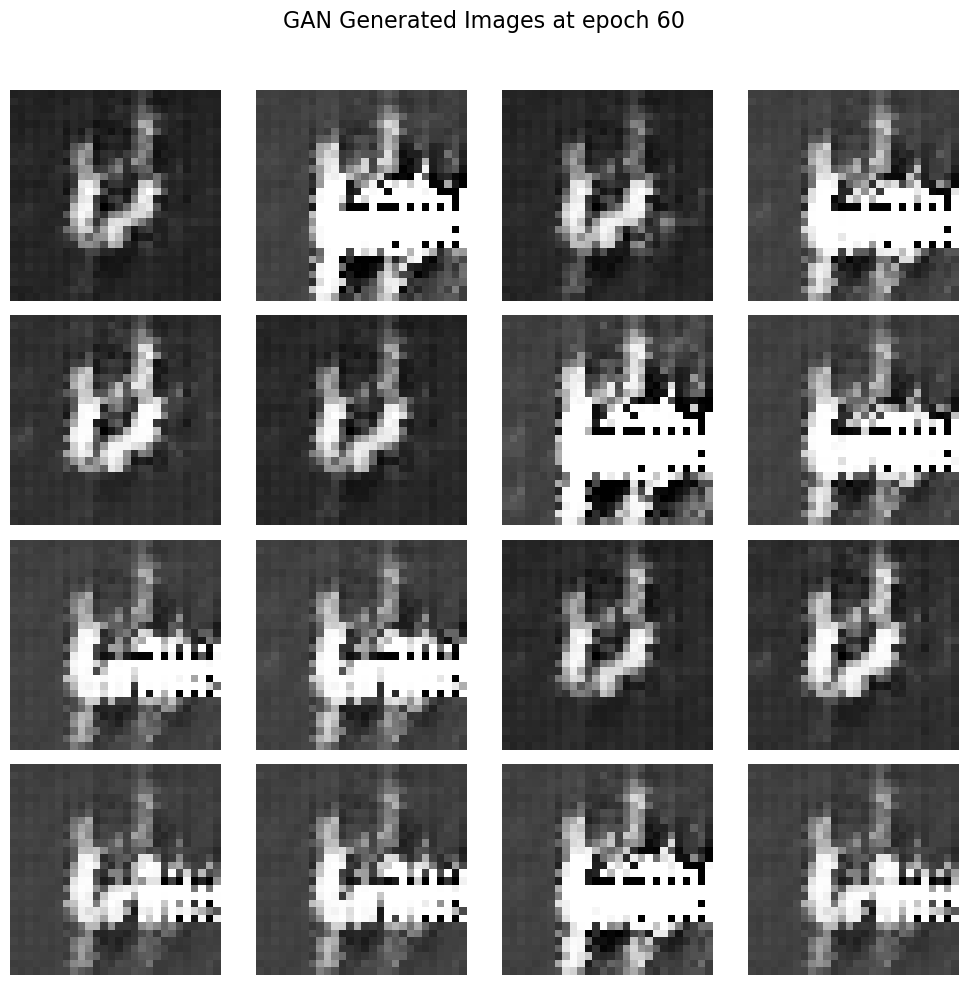

Epoch [61/200]:
epoch_d_loss: 0.133471 	epoch_g_loss: 4.045333
Epoch [62/200]:
epoch_d_loss: 0.079096 	epoch_g_loss: 4.157007
Epoch [63/200]:
epoch_d_loss: 0.137222 	epoch_g_loss: 4.153135
Epoch [64/200]:
epoch_d_loss: 0.241769 	epoch_g_loss: 3.835269
Epoch [65/200]:
epoch_d_loss: 0.189620 	epoch_g_loss: 4.069030
Epoch [66/200]:
epoch_d_loss: 0.103818 	epoch_g_loss: 4.400231
Epoch [67/200]:
epoch_d_loss: 0.086334 	epoch_g_loss: 4.982602
Epoch [68/200]:
epoch_d_loss: 0.036233 	epoch_g_loss: 4.724459
Epoch [69/200]:
epoch_d_loss: 0.041604 	epoch_g_loss: 4.871591
Epoch [70/200]:
epoch_d_loss: 0.038706 	epoch_g_loss: 4.663783


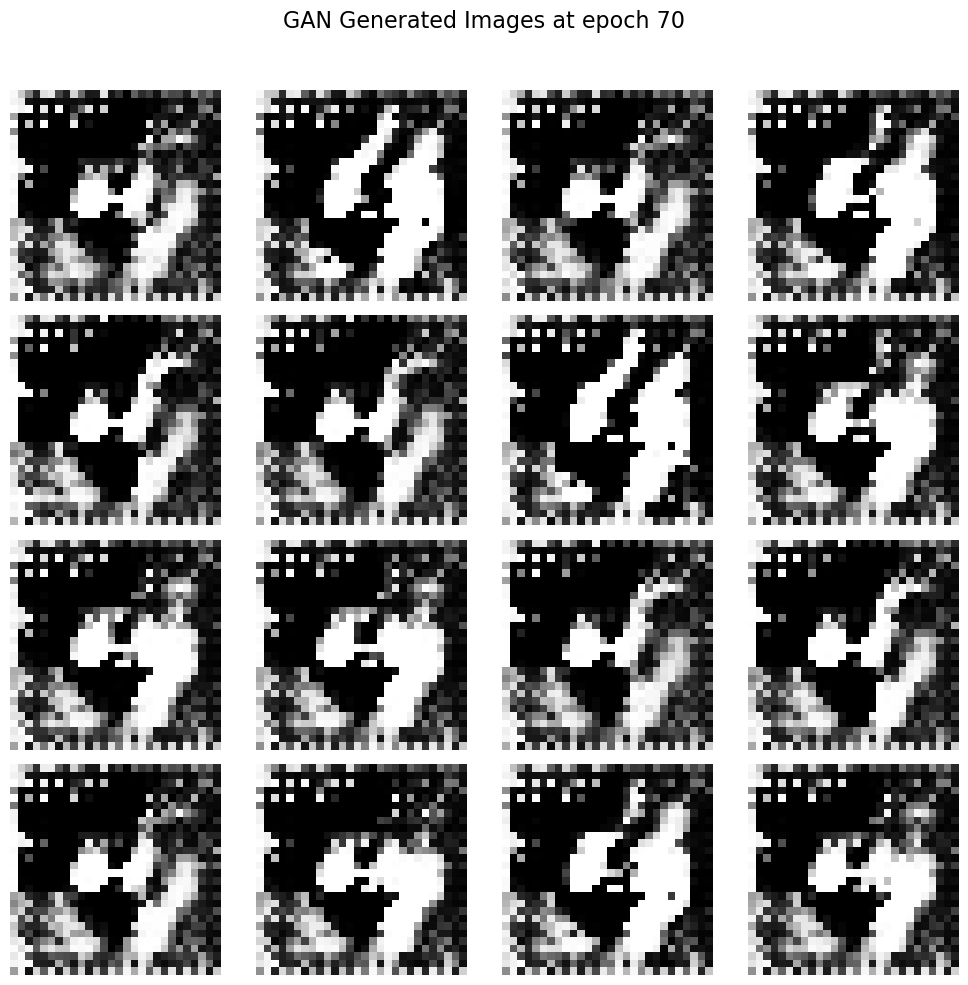

Epoch [71/200]:
epoch_d_loss: 0.032186 	epoch_g_loss: 4.653639
Epoch [72/200]:
epoch_d_loss: 0.030278 	epoch_g_loss: 5.013791
Epoch [73/200]:
epoch_d_loss: 0.036649 	epoch_g_loss: 4.709803
Epoch [74/200]:
epoch_d_loss: 0.043213 	epoch_g_loss: 4.603096
Epoch [75/200]:
epoch_d_loss: 0.058547 	epoch_g_loss: 4.441867
Epoch [76/200]:
epoch_d_loss: 0.139951 	epoch_g_loss: 4.002660
Epoch [77/200]:
epoch_d_loss: 0.107351 	epoch_g_loss: 4.071978
Epoch [78/200]:
epoch_d_loss: 0.118602 	epoch_g_loss: 3.854241
Epoch [79/200]:
epoch_d_loss: 0.089119 	epoch_g_loss: 4.151895
Epoch [80/200]:
epoch_d_loss: 0.078960 	epoch_g_loss: 4.196004


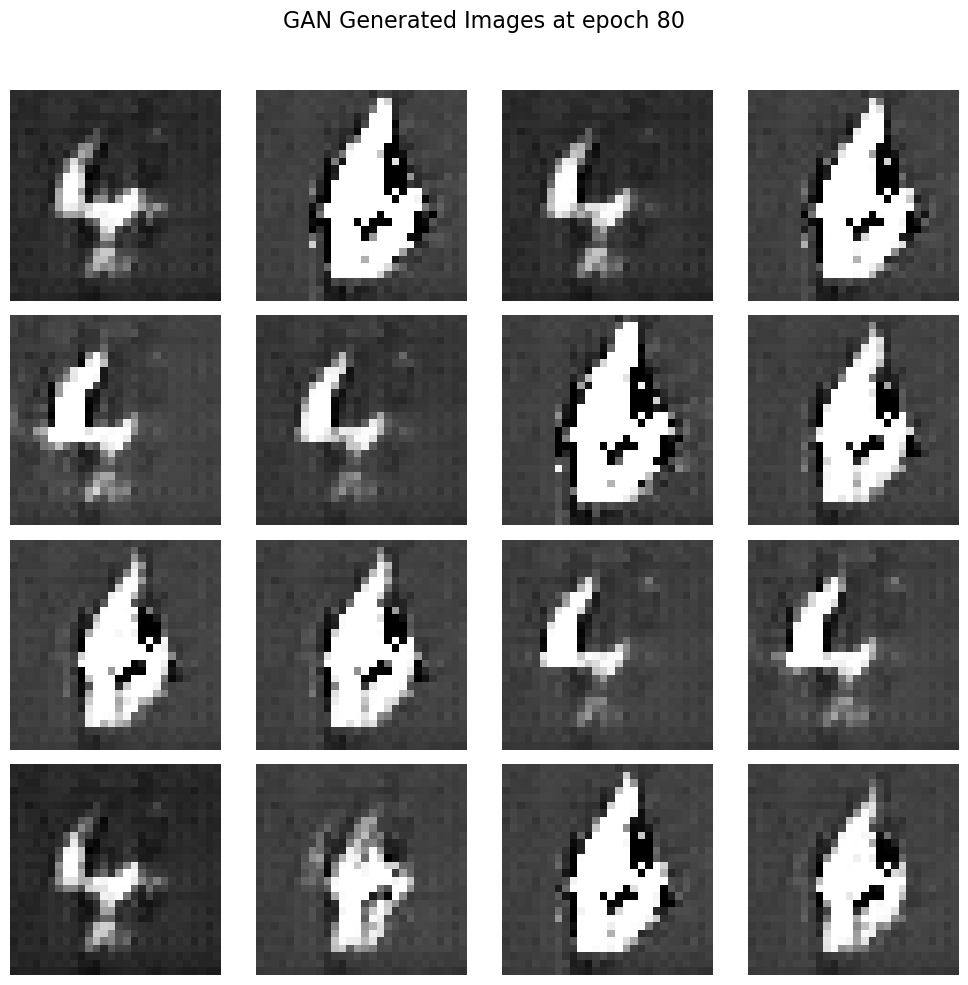

Epoch [81/200]:
epoch_d_loss: 0.074380 	epoch_g_loss: 4.234241
Epoch [82/200]:
epoch_d_loss: 0.072948 	epoch_g_loss: 4.388534
Epoch [83/200]:
epoch_d_loss: 0.132593 	epoch_g_loss: 4.105726
Epoch [84/200]:
epoch_d_loss: 0.132472 	epoch_g_loss: 3.996112
Epoch [85/200]:
epoch_d_loss: 0.118918 	epoch_g_loss: 4.244849
Epoch [86/200]:
epoch_d_loss: 0.132204 	epoch_g_loss: 4.115020
Epoch [87/200]:
epoch_d_loss: 0.130428 	epoch_g_loss: 4.406943
Epoch [88/200]:
epoch_d_loss: 0.074358 	epoch_g_loss: 4.335994
Epoch [89/200]:
epoch_d_loss: 0.079382 	epoch_g_loss: 4.413043
Epoch [90/200]:
epoch_d_loss: 0.081691 	epoch_g_loss: 4.337906


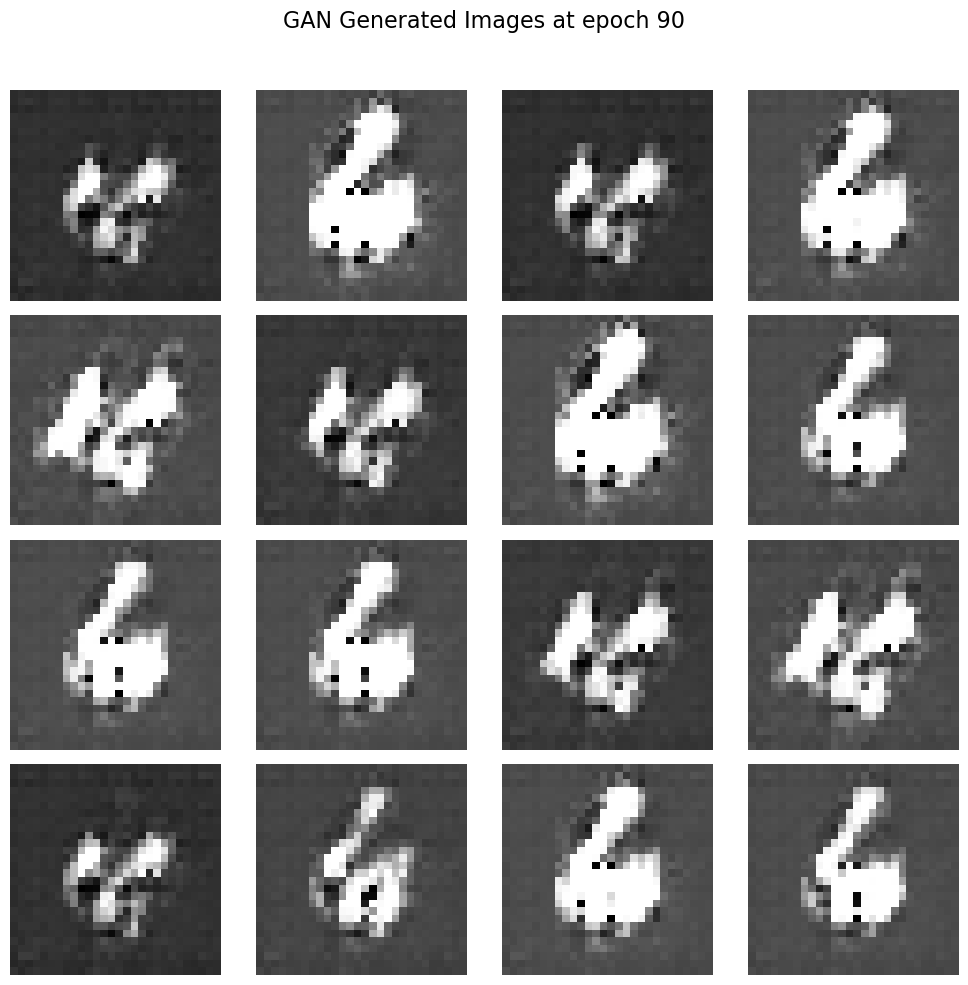

Epoch [91/200]:
epoch_d_loss: 0.132662 	epoch_g_loss: 4.153380
Epoch [92/200]:
epoch_d_loss: 0.087214 	epoch_g_loss: 4.206665
Epoch [93/200]:
epoch_d_loss: 0.110478 	epoch_g_loss: 4.178481
Epoch [94/200]:
epoch_d_loss: 0.110261 	epoch_g_loss: 4.168051
Epoch [95/200]:
epoch_d_loss: 0.106924 	epoch_g_loss: 4.251142
Epoch [96/200]:
epoch_d_loss: 0.094956 	epoch_g_loss: 4.497892
Epoch [97/200]:
epoch_d_loss: 0.100450 	epoch_g_loss: 4.305488
Epoch [98/200]:
epoch_d_loss: 0.102185 	epoch_g_loss: 4.194464
Epoch [99/200]:
epoch_d_loss: 0.129560 	epoch_g_loss: 4.172305
Epoch [100/200]:
epoch_d_loss: 0.106670 	epoch_g_loss: 4.233683


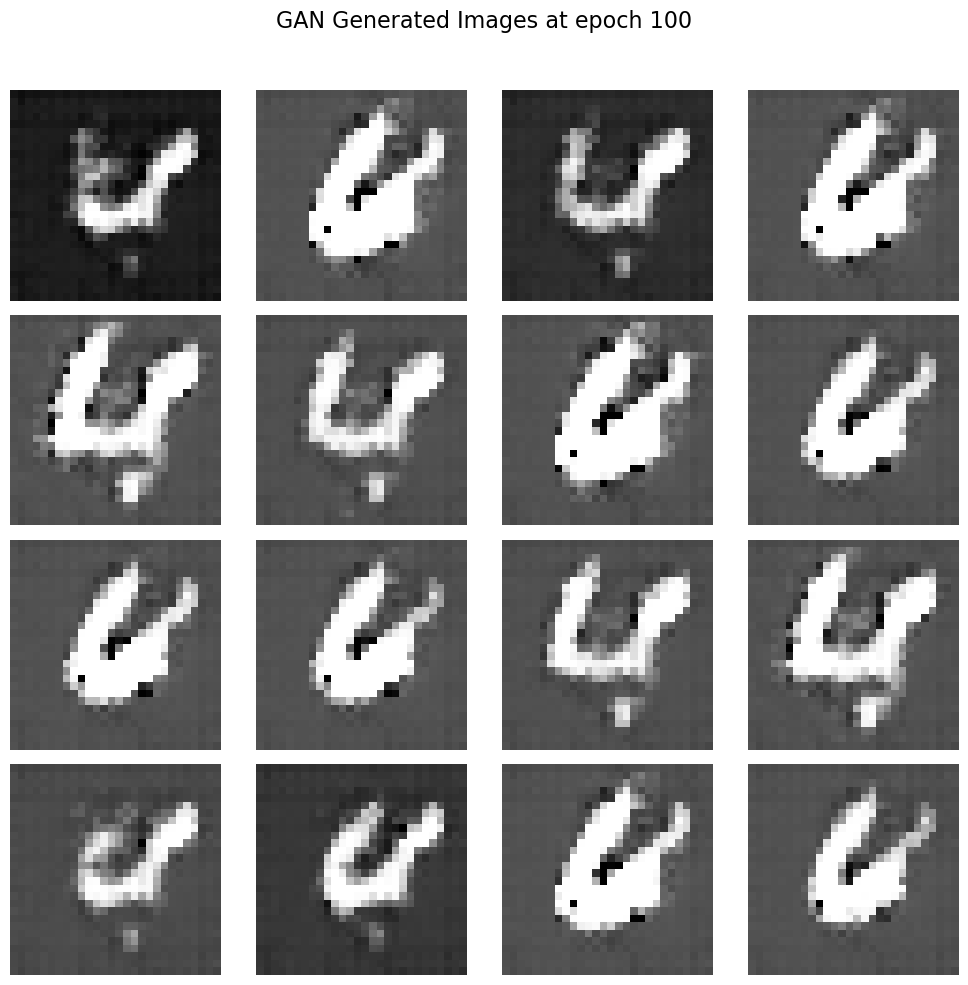

Epoch [101/200]:
epoch_d_loss: 0.123100 	epoch_g_loss: 3.934637
Epoch [102/200]:
epoch_d_loss: 0.125643 	epoch_g_loss: 3.837234
Epoch [103/200]:
epoch_d_loss: 0.156073 	epoch_g_loss: 3.881111
Epoch [104/200]:
epoch_d_loss: 0.109217 	epoch_g_loss: 4.119632
Epoch [105/200]:
epoch_d_loss: 0.179008 	epoch_g_loss: 4.969633
Epoch [106/200]:
epoch_d_loss: 0.134975 	epoch_g_loss: 4.464782
Epoch [107/200]:
epoch_d_loss: 0.145570 	epoch_g_loss: 4.113229
Epoch [108/200]:
epoch_d_loss: 0.082288 	epoch_g_loss: 4.427941
Epoch [109/200]:
epoch_d_loss: 0.133620 	epoch_g_loss: 4.218658
Epoch [110/200]:
epoch_d_loss: 0.173267 	epoch_g_loss: 3.883448


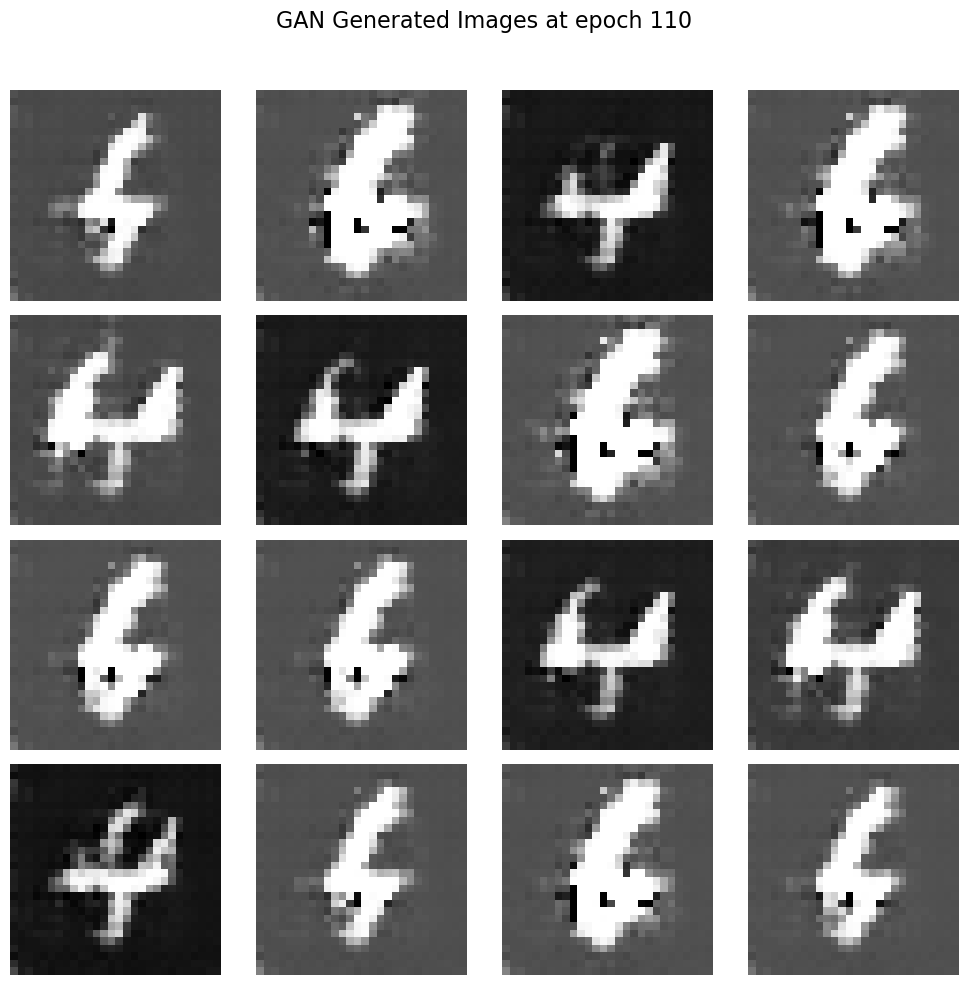

Epoch [111/200]:
epoch_d_loss: 0.098294 	epoch_g_loss: 4.231302
Epoch [112/200]:
epoch_d_loss: 0.080525 	epoch_g_loss: 4.318007
Epoch [113/200]:
epoch_d_loss: 0.107642 	epoch_g_loss: 4.220781
Epoch [114/200]:
epoch_d_loss: 0.080240 	epoch_g_loss: 4.462509
Epoch [115/200]:
epoch_d_loss: 0.074896 	epoch_g_loss: 4.691743
Epoch [116/200]:
epoch_d_loss: 0.034097 	epoch_g_loss: 4.999626
Epoch [117/200]:
epoch_d_loss: 0.026835 	epoch_g_loss: 5.185821
Epoch [118/200]:
epoch_d_loss: 0.055436 	epoch_g_loss: 4.619664
Epoch [119/200]:
epoch_d_loss: 0.084210 	epoch_g_loss: 4.410410
Epoch [120/200]:
epoch_d_loss: 0.099629 	epoch_g_loss: 4.473676


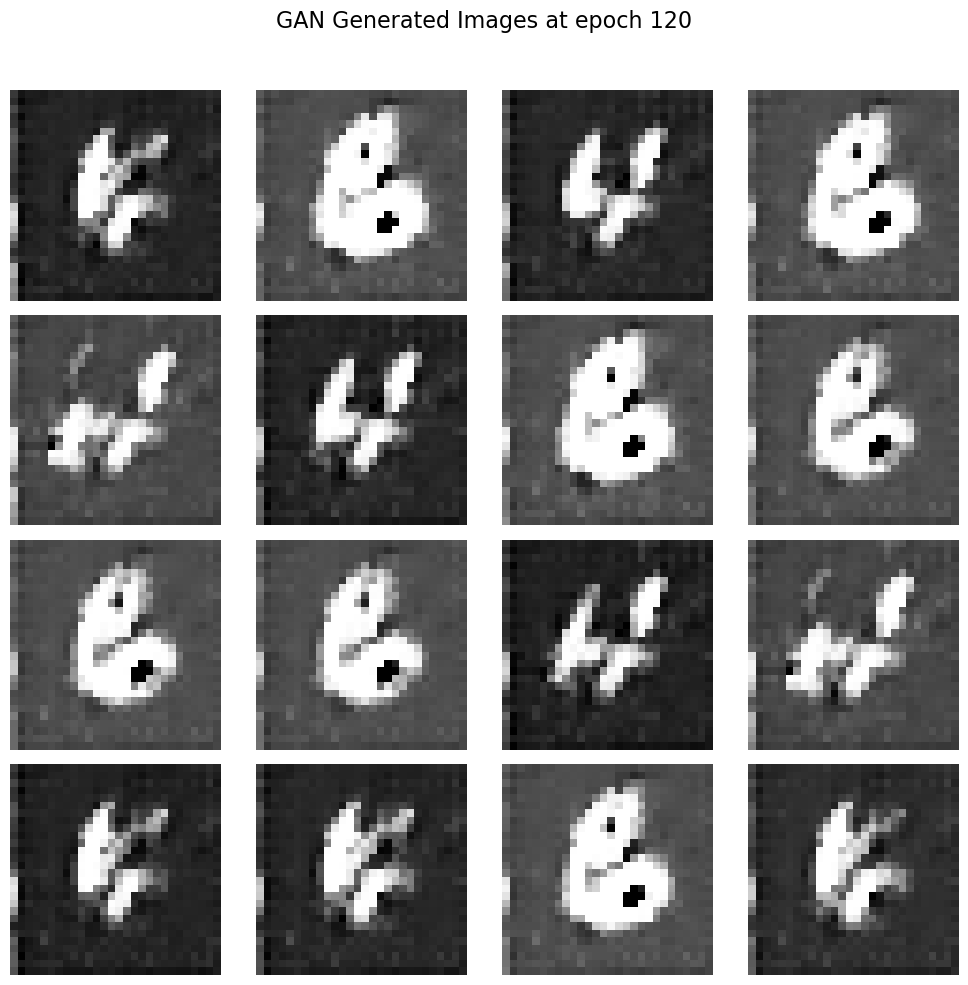

Epoch [121/200]:
epoch_d_loss: 0.124889 	epoch_g_loss: 4.683574
Epoch [122/200]:
epoch_d_loss: 0.089829 	epoch_g_loss: 4.594608
Epoch [123/200]:
epoch_d_loss: 0.042849 	epoch_g_loss: 4.975685
Epoch [124/200]:
epoch_d_loss: 0.046594 	epoch_g_loss: 4.480271
Epoch [125/200]:
epoch_d_loss: 0.070544 	epoch_g_loss: 4.633393
Epoch [126/200]:
epoch_d_loss: 0.050213 	epoch_g_loss: 5.059202
Epoch [127/200]:
epoch_d_loss: 0.069572 	epoch_g_loss: 4.769815
Epoch [128/200]:
epoch_d_loss: 0.109663 	epoch_g_loss: 4.341152
Epoch [129/200]:
epoch_d_loss: 0.083165 	epoch_g_loss: 4.471239
Epoch [130/200]:
epoch_d_loss: 0.079910 	epoch_g_loss: 4.601578


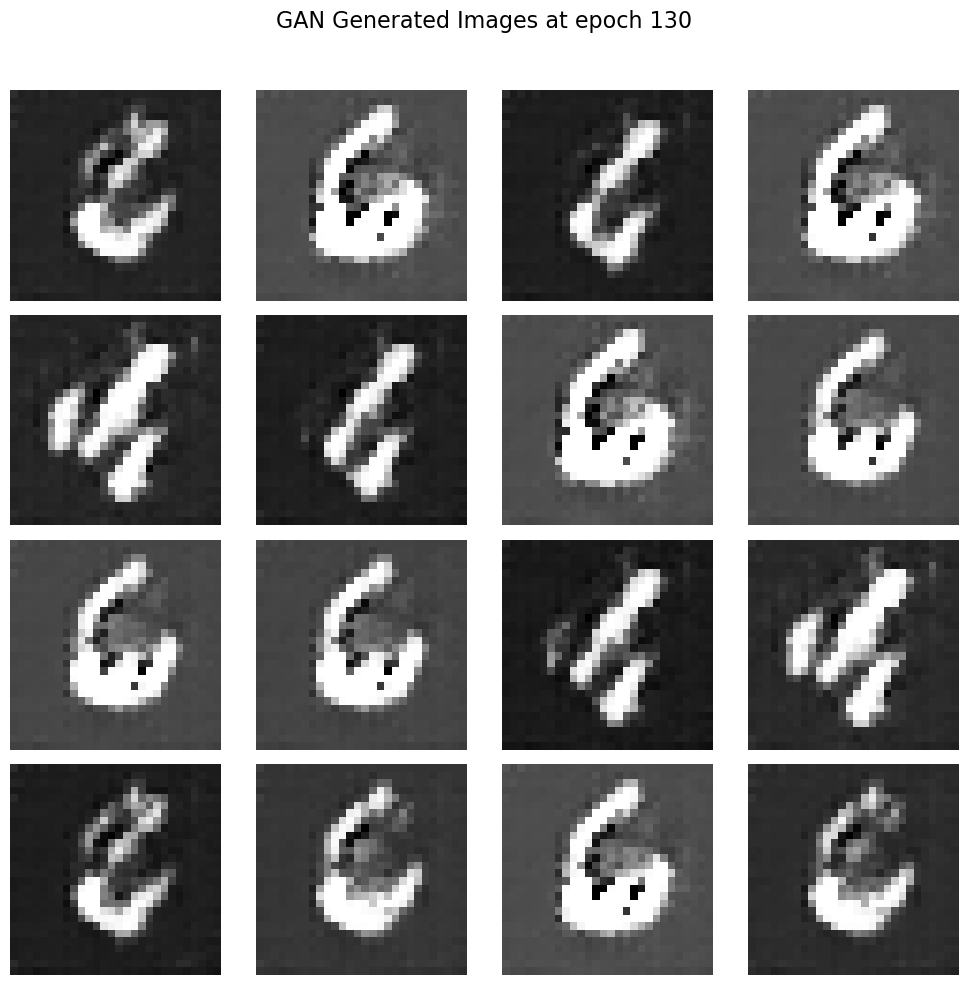

Epoch [131/200]:
epoch_d_loss: 0.100220 	epoch_g_loss: 4.368182
Epoch [132/200]:
epoch_d_loss: 0.081620 	epoch_g_loss: 4.492437
Epoch [133/200]:
epoch_d_loss: 0.068584 	epoch_g_loss: 4.524482
Epoch [134/200]:
epoch_d_loss: 0.066422 	epoch_g_loss: 4.447056
Epoch [135/200]:
epoch_d_loss: 0.137174 	epoch_g_loss: 4.339407
Epoch [136/200]:
epoch_d_loss: 0.090552 	epoch_g_loss: 4.538522
Epoch [137/200]:
epoch_d_loss: 0.127842 	epoch_g_loss: 4.126240
Epoch [138/200]:
epoch_d_loss: 0.061770 	epoch_g_loss: 4.417136
Epoch [139/200]:
epoch_d_loss: 0.091073 	epoch_g_loss: 4.324023
Epoch [140/200]:
epoch_d_loss: 0.105827 	epoch_g_loss: 4.399222


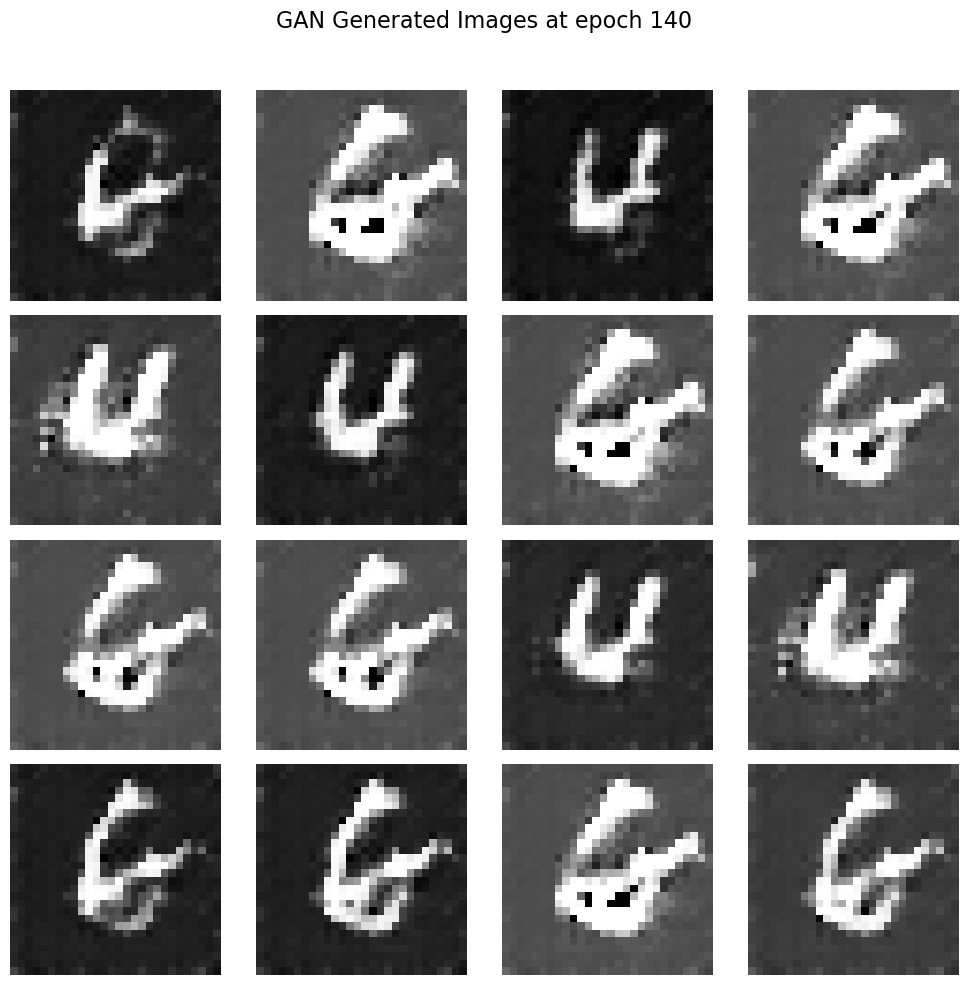

Epoch [141/200]:
epoch_d_loss: 0.114806 	epoch_g_loss: 4.372722
Epoch [142/200]:
epoch_d_loss: 0.053006 	epoch_g_loss: 5.314980
Epoch [143/200]:
epoch_d_loss: 0.083059 	epoch_g_loss: 5.333694
Epoch [144/200]:
epoch_d_loss: 0.125181 	epoch_g_loss: 5.453767
Epoch [145/200]:
epoch_d_loss: 0.142391 	epoch_g_loss: 4.572491
Epoch [146/200]:
epoch_d_loss: 0.113469 	epoch_g_loss: 4.904403
Epoch [147/200]:
epoch_d_loss: 0.057340 	epoch_g_loss: 4.696825
Epoch [148/200]:
epoch_d_loss: 0.067163 	epoch_g_loss: 4.720138
Epoch [149/200]:
epoch_d_loss: 0.040032 	epoch_g_loss: 4.830501
Epoch [150/200]:
epoch_d_loss: 0.058588 	epoch_g_loss: 4.589238


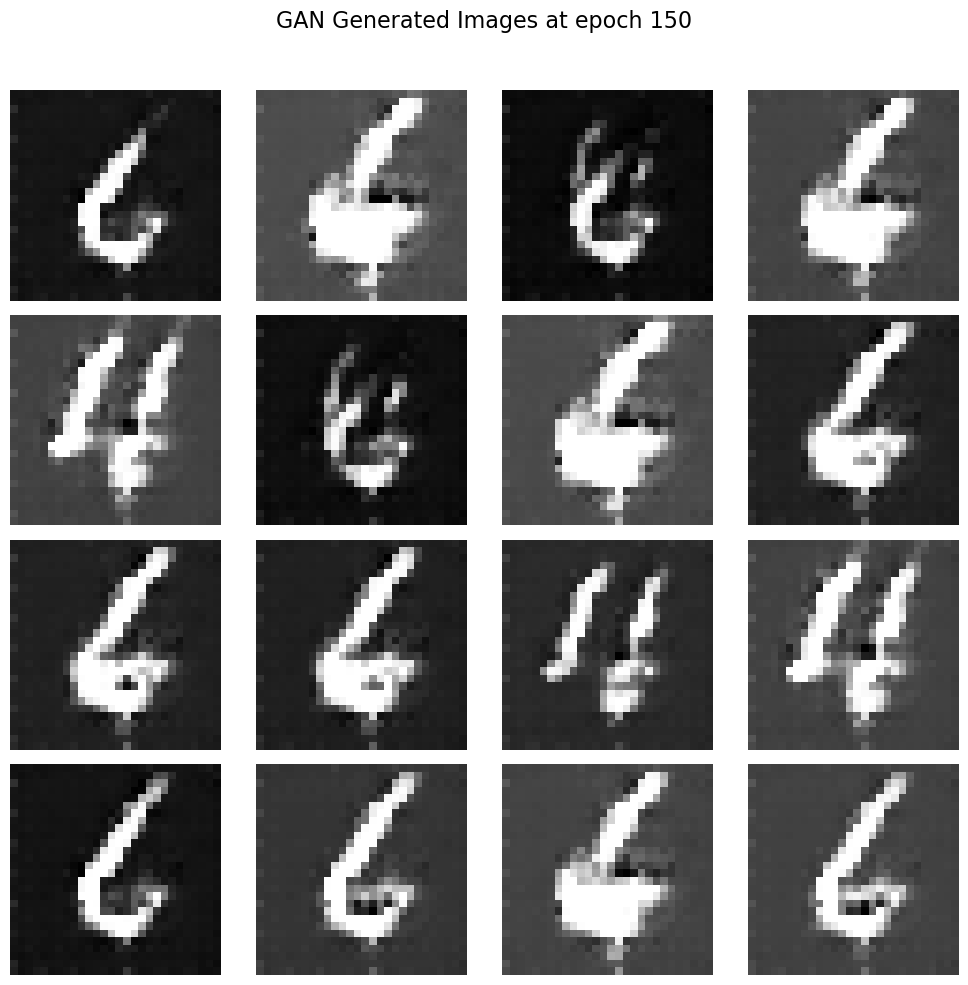

Epoch [151/200]:
epoch_d_loss: 0.075376 	epoch_g_loss: 4.288150
Epoch [152/200]:
epoch_d_loss: 0.122791 	epoch_g_loss: 3.981280
Epoch [153/200]:
epoch_d_loss: 0.112076 	epoch_g_loss: 4.446435
Epoch [154/200]:
epoch_d_loss: 0.056305 	epoch_g_loss: 4.814948
Epoch [155/200]:
epoch_d_loss: 0.078260 	epoch_g_loss: 4.668565
Epoch [156/200]:
epoch_d_loss: 0.072858 	epoch_g_loss: 4.966085
Epoch [157/200]:
epoch_d_loss: 0.046087 	epoch_g_loss: 5.095248
Epoch [158/200]:
epoch_d_loss: 0.083638 	epoch_g_loss: 4.600887
Epoch [159/200]:
epoch_d_loss: 0.096575 	epoch_g_loss: 5.017888
Epoch [160/200]:
epoch_d_loss: 0.102589 	epoch_g_loss: 4.717828


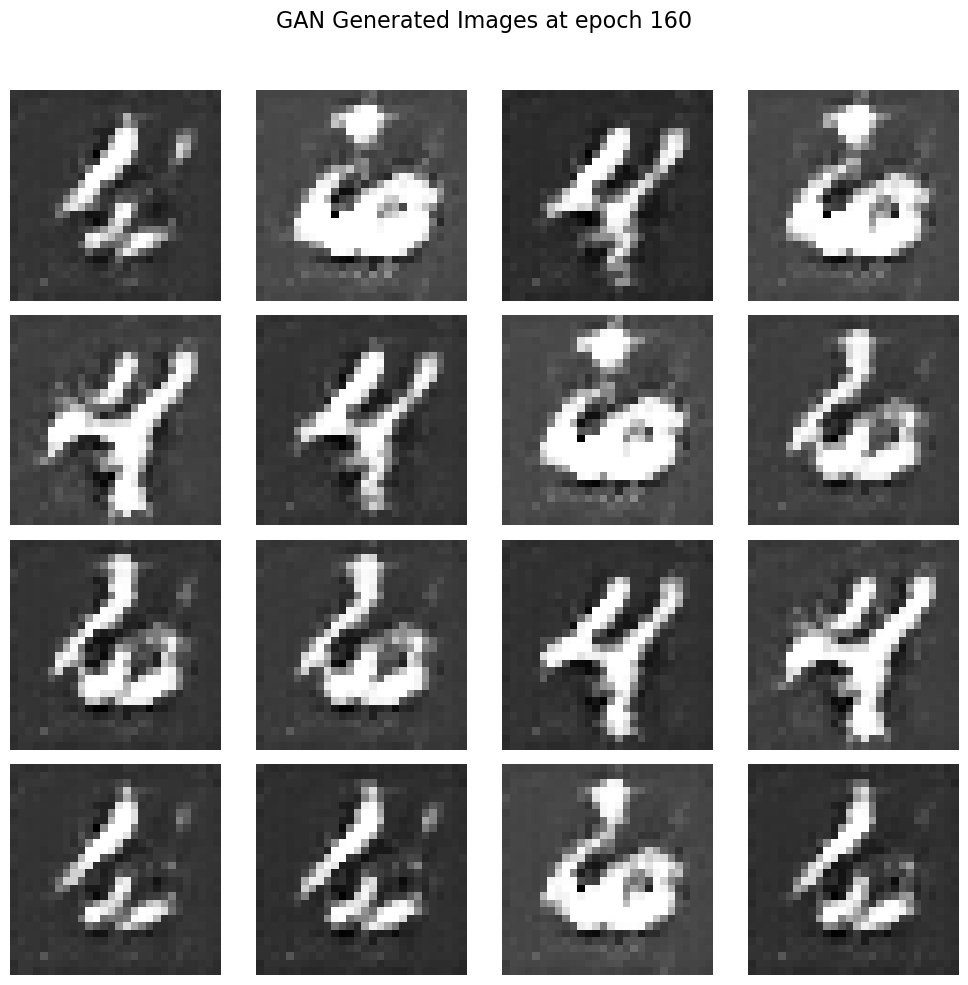

Epoch [161/200]:
epoch_d_loss: 0.066687 	epoch_g_loss: 4.983640
Epoch [162/200]:
epoch_d_loss: 0.078992 	epoch_g_loss: 4.868139
Epoch [163/200]:
epoch_d_loss: 0.046613 	epoch_g_loss: 5.165322
Epoch [164/200]:
epoch_d_loss: 0.062095 	epoch_g_loss: 5.007134
Epoch [165/200]:
epoch_d_loss: 0.058213 	epoch_g_loss: 5.204733
Epoch [166/200]:
epoch_d_loss: 0.052891 	epoch_g_loss: 5.109304
Epoch [167/200]:
epoch_d_loss: 0.048823 	epoch_g_loss: 4.832163
Epoch [168/200]:
epoch_d_loss: 0.047742 	epoch_g_loss: 4.889593
Epoch [169/200]:
epoch_d_loss: 0.091127 	epoch_g_loss: 4.566682
Epoch [170/200]:
epoch_d_loss: 0.071121 	epoch_g_loss: 4.531405


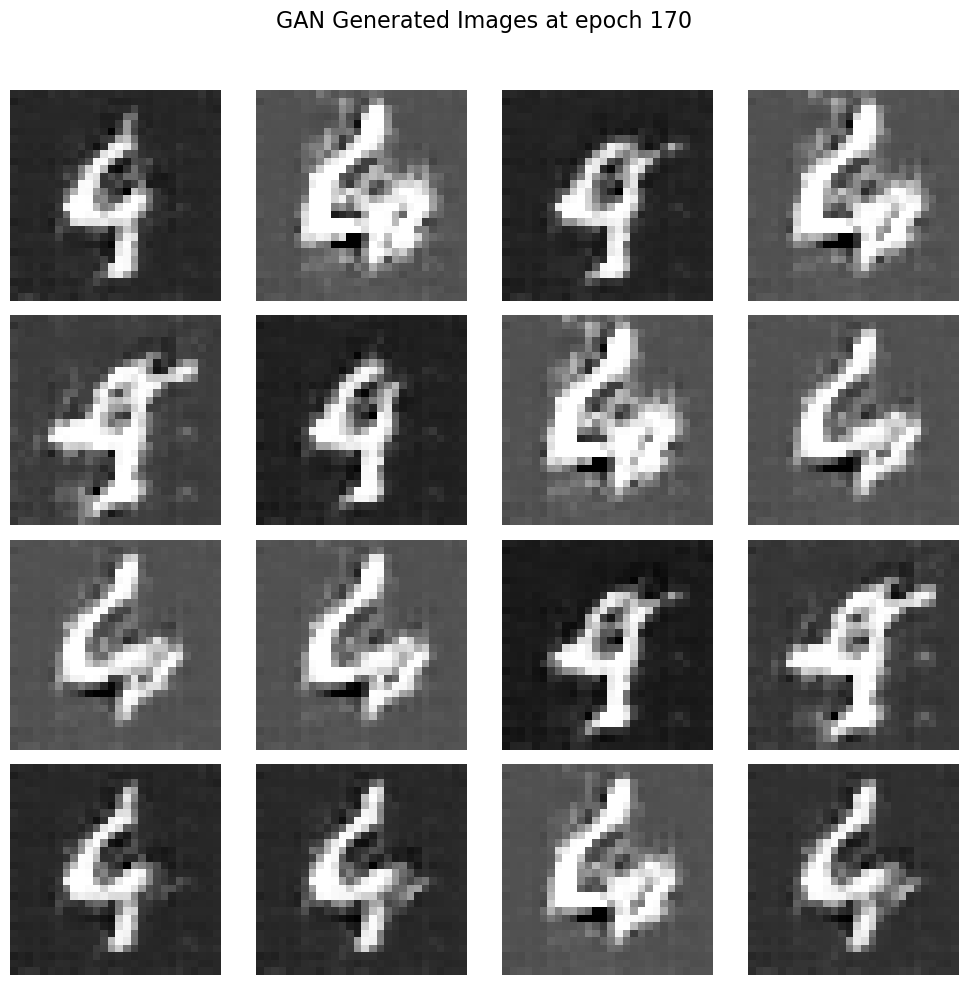

Epoch [171/200]:
epoch_d_loss: 0.058672 	epoch_g_loss: 4.894714
Epoch [172/200]:
epoch_d_loss: 0.072238 	epoch_g_loss: 4.981238
Epoch [173/200]:
epoch_d_loss: 0.070585 	epoch_g_loss: 4.909246
Epoch [174/200]:
epoch_d_loss: 0.039289 	epoch_g_loss: 5.165123
Epoch [175/200]:
epoch_d_loss: 0.047494 	epoch_g_loss: 4.965871
Epoch [176/200]:
epoch_d_loss: 0.038874 	epoch_g_loss: 5.586552
Epoch [177/200]:
epoch_d_loss: 0.046442 	epoch_g_loss: 5.349196
Epoch [178/200]:
epoch_d_loss: 0.031108 	epoch_g_loss: 5.461015
Epoch [179/200]:
epoch_d_loss: 0.050077 	epoch_g_loss: 5.161560
Epoch [180/200]:
epoch_d_loss: 0.048067 	epoch_g_loss: 4.976177


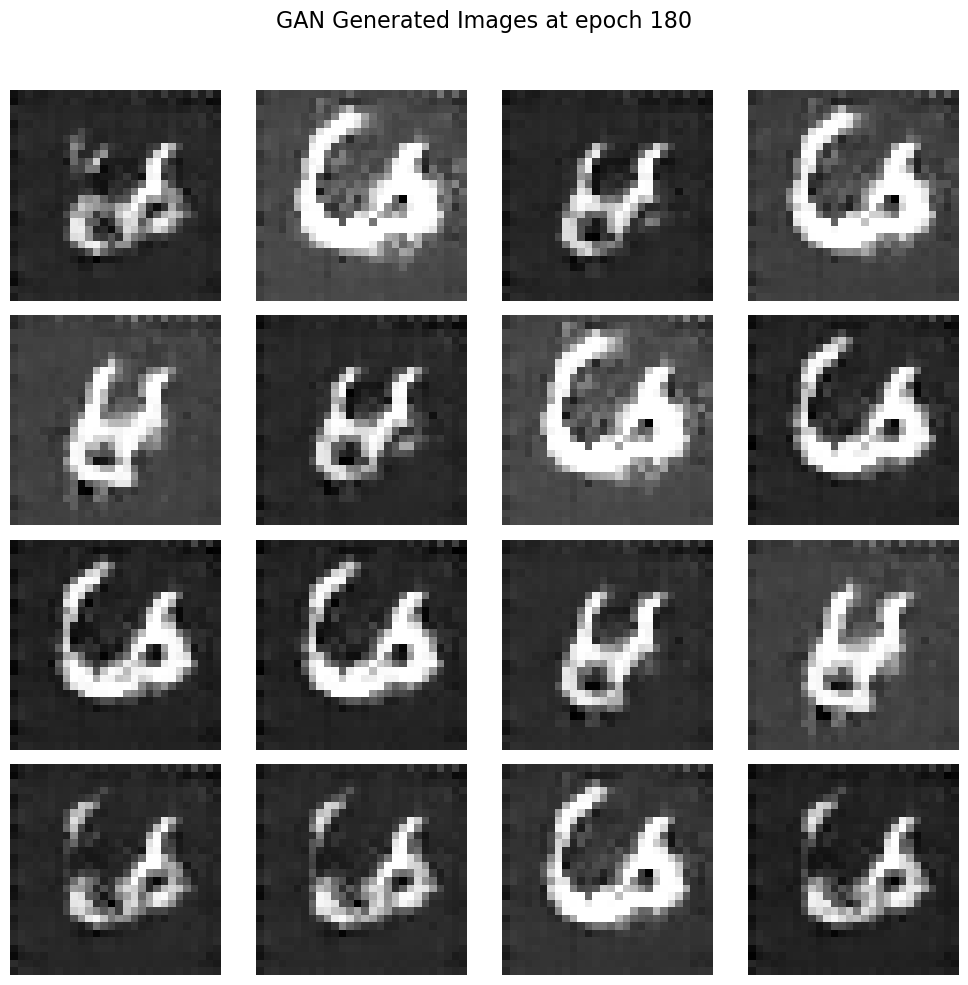

Epoch [181/200]:
epoch_d_loss: 0.043713 	epoch_g_loss: 5.030267
Epoch [182/200]:
epoch_d_loss: 0.056523 	epoch_g_loss: 5.047864
Epoch [183/200]:
epoch_d_loss: 0.034693 	epoch_g_loss: 5.161944
Epoch [184/200]:
epoch_d_loss: 0.077363 	epoch_g_loss: 4.988912
Epoch [185/200]:
epoch_d_loss: 0.054577 	epoch_g_loss: 4.958046
Epoch [186/200]:
epoch_d_loss: 0.035298 	epoch_g_loss: 4.970143
Epoch [187/200]:
epoch_d_loss: 0.052395 	epoch_g_loss: 4.611254
Epoch [188/200]:
epoch_d_loss: 0.063554 	epoch_g_loss: 4.604644
Epoch [189/200]:
epoch_d_loss: 0.069242 	epoch_g_loss: 4.556282
Epoch [190/200]:
epoch_d_loss: 0.048030 	epoch_g_loss: 4.932647


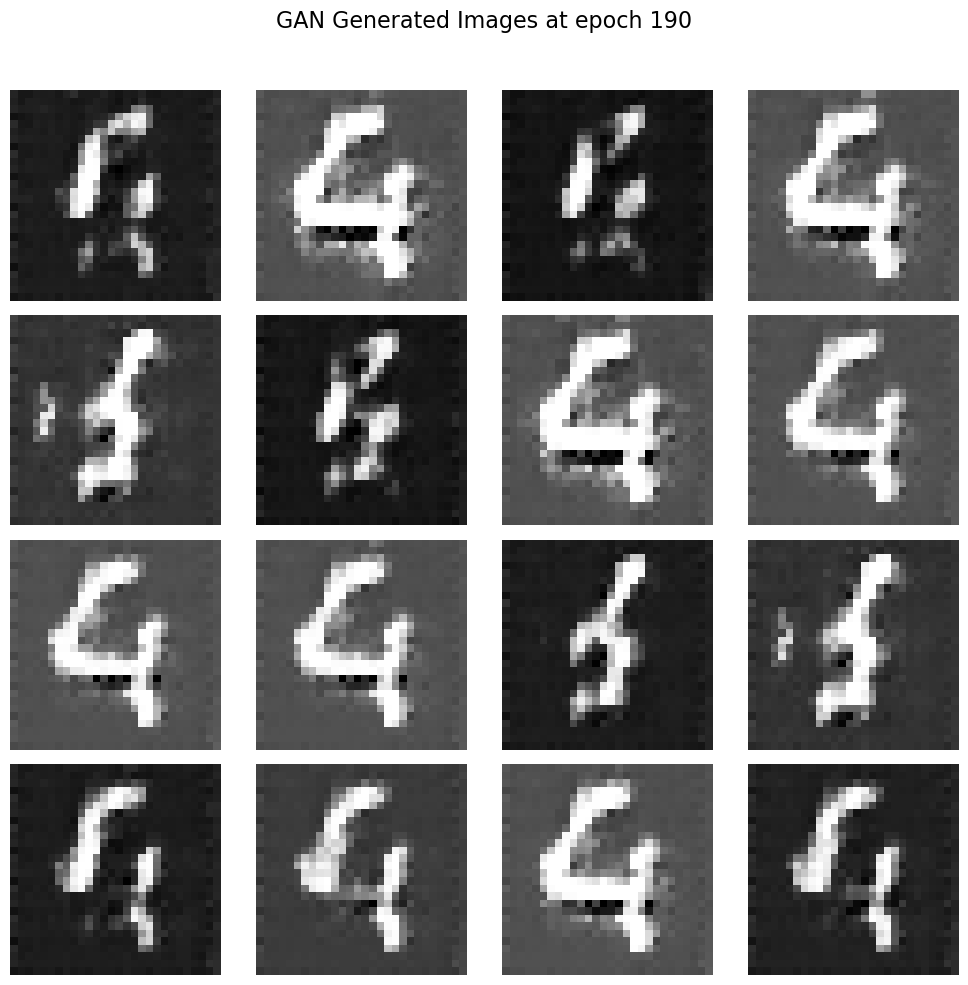

Epoch [191/200]:
epoch_d_loss: 0.039633 	epoch_g_loss: 5.274310
Epoch [192/200]:
epoch_d_loss: 0.063787 	epoch_g_loss: 5.106757
Epoch [193/200]:
epoch_d_loss: 0.081667 	epoch_g_loss: 4.866414
Epoch [194/200]:
epoch_d_loss: 0.074485 	epoch_g_loss: 4.702333
Epoch [195/200]:
epoch_d_loss: 0.072466 	epoch_g_loss: 4.917263
Epoch [196/200]:
epoch_d_loss: 0.063466 	epoch_g_loss: 4.729497
Epoch [197/200]:
epoch_d_loss: 0.053898 	epoch_g_loss: 4.699020
Epoch [198/200]:
epoch_d_loss: 0.061825 	epoch_g_loss: 4.854764
Epoch [199/200]:
epoch_d_loss: 0.075737 	epoch_g_loss: 4.830813
Epoch [200/200]:
epoch_d_loss: 0.045492 	epoch_g_loss: 5.161130


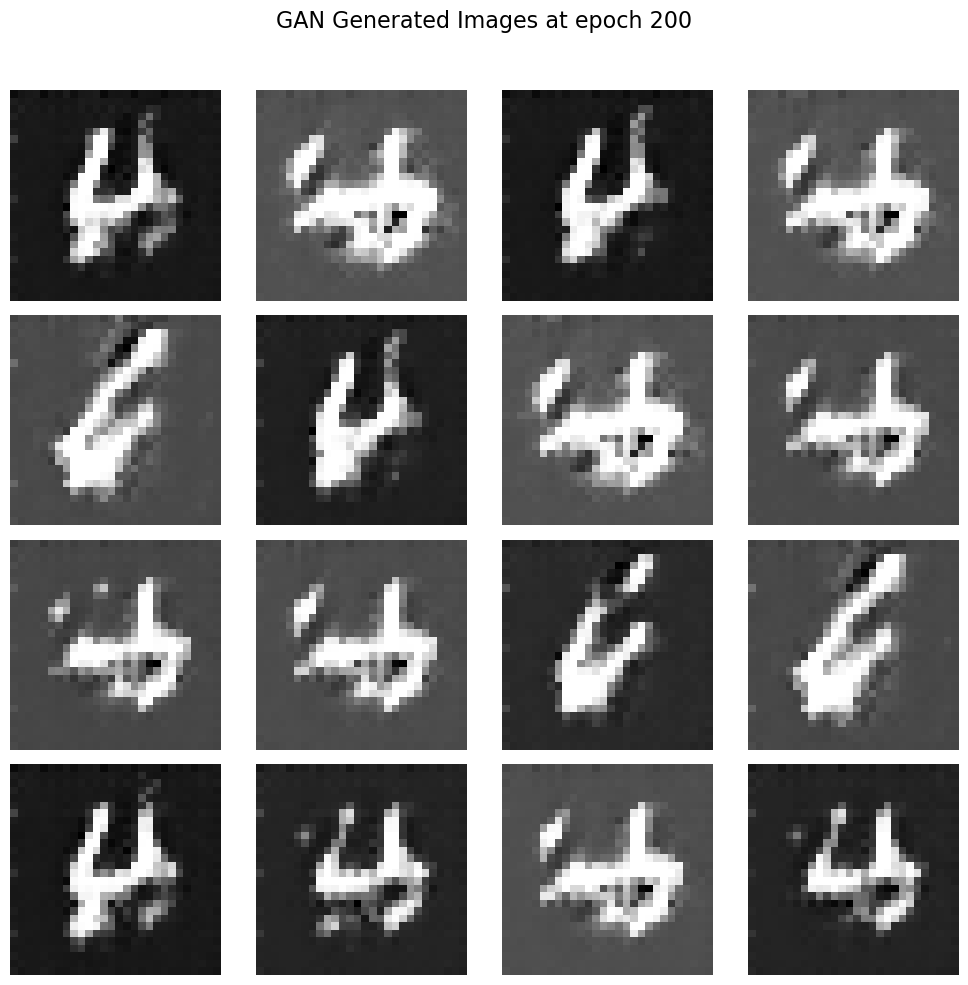

Time to train the generator on task  0   617.6344809532166
Time to generate the data 605.4680857658386


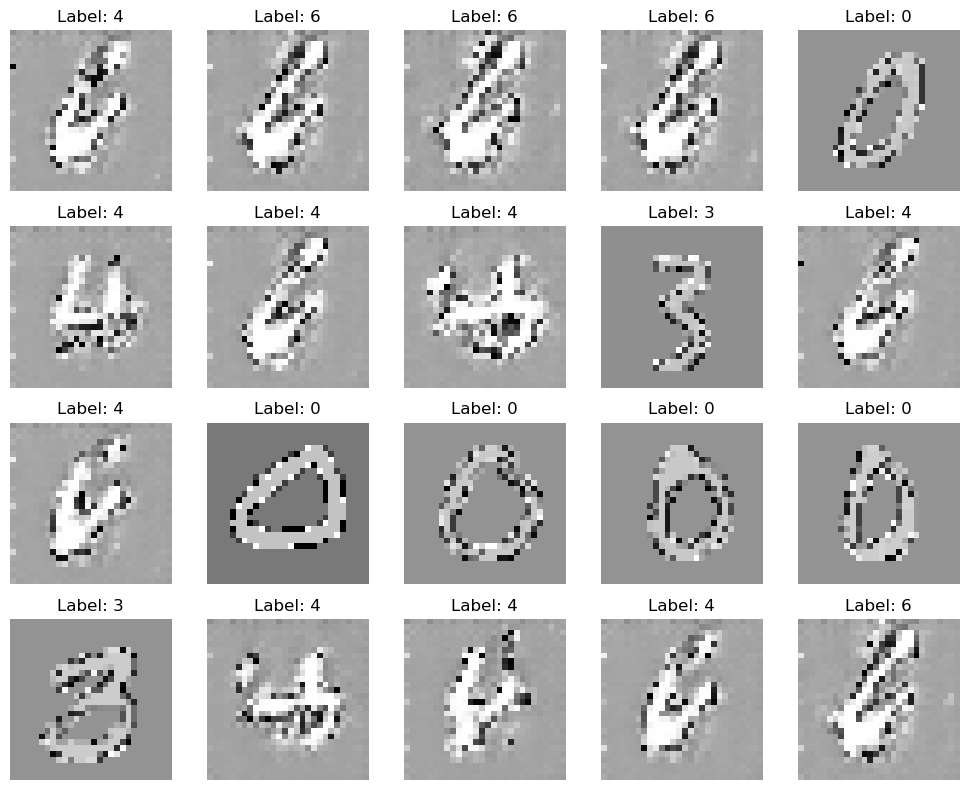

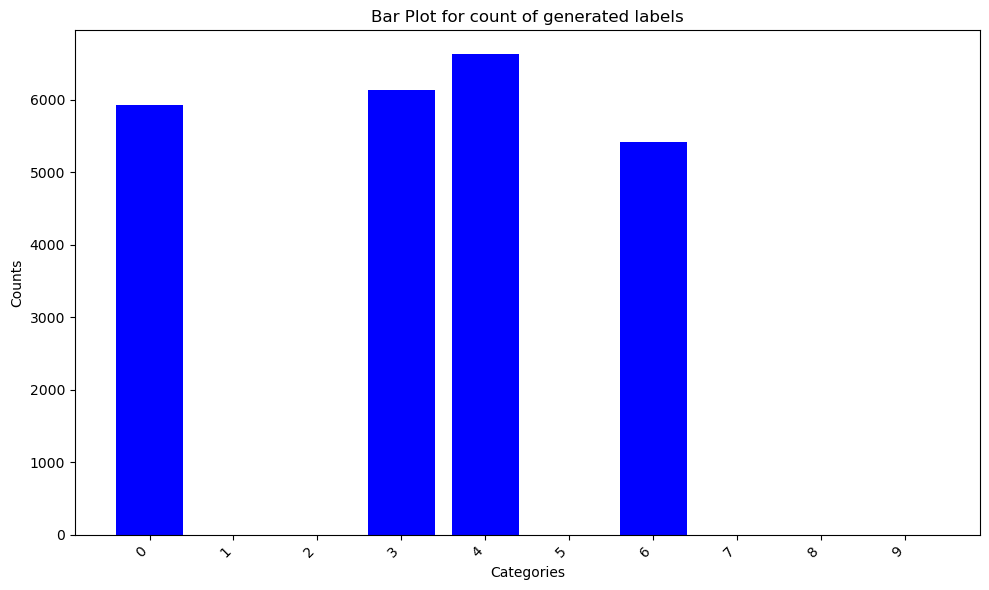

Epoch 0: Loss 2.191 Acc: 0.305
Epoch 1: Loss 1.644 Acc: 0.445
Epoch 2: Loss 1.235 Acc: 0.552
Epoch 3: Loss 0.886 Acc: 0.698
Epoch 4: Loss 0.654 Acc: 0.814
Epoch 5: Loss 0.469 Acc: 0.908
Epoch 6: Loss 0.300 Acc: 0.964
Epoch 7: Loss 0.224 Acc: 0.975
Epoch 8: Loss 0.170 Acc: 0.983
Epoch 9: Loss 0.123 Acc: 0.990
Epoch 10: Loss 0.101 Acc: 0.991
Epoch 11: Loss 0.083 Acc: 0.992
Epoch 12: Loss 0.075 Acc: 0.993
Epoch 13: Loss 0.063 Acc: 0.993
Epoch 14: Loss 0.058 Acc: 0.994
Epoch 15: Loss 0.049 Acc: 0.995
Epoch 16: Loss 0.045 Acc: 0.996
Epoch 17: Loss 0.039 Acc: 0.995
Epoch 18: Loss 0.035 Acc: 0.996
Epoch 19: Loss 0.057 Acc: 0.989
Time to train the solver on task  1   102.65743279457092
[6, 4, 0, 3]
Training on [cuda]...
Epoch [1/200]:
epoch_d_loss: 0.748515 	epoch_g_loss: 1.348238
Epoch [2/200]:
epoch_d_loss: 0.553249 	epoch_g_loss: 1.667424
Epoch [3/200]:
epoch_d_loss: 0.493242 	epoch_g_loss: 1.844186
Epoch [4/200]:
epoch_d_loss: 0.544120 	epoch_g_loss: 2.041000
Epoch [5/200]:
epoch_d_loss: 0

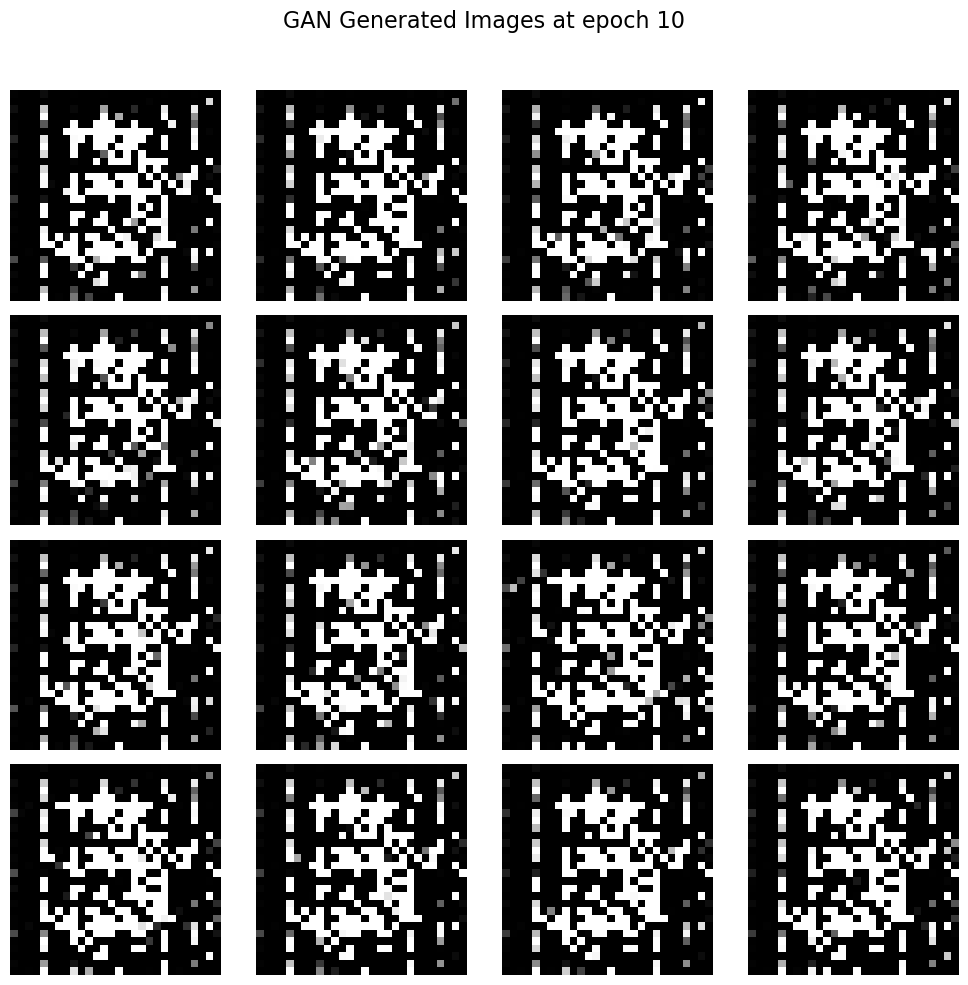

Epoch [11/200]:
epoch_d_loss: 0.053419 	epoch_g_loss: 4.222996
Epoch [12/200]:
epoch_d_loss: 0.031149 	epoch_g_loss: 4.698839
Epoch [13/200]:
epoch_d_loss: 0.020559 	epoch_g_loss: 5.014029
Epoch [14/200]:
epoch_d_loss: 0.014196 	epoch_g_loss: 5.327160
Epoch [15/200]:
epoch_d_loss: 0.009153 	epoch_g_loss: 5.969740
Epoch [16/200]:
epoch_d_loss: 0.006637 	epoch_g_loss: 6.385630
Epoch [17/200]:
epoch_d_loss: 0.005603 	epoch_g_loss: 6.432830
Epoch [18/200]:
epoch_d_loss: 0.004978 	epoch_g_loss: 6.462666
Epoch [19/200]:
epoch_d_loss: 0.004810 	epoch_g_loss: 6.394194
Epoch [20/200]:
epoch_d_loss: 0.008413 	epoch_g_loss: 5.446126


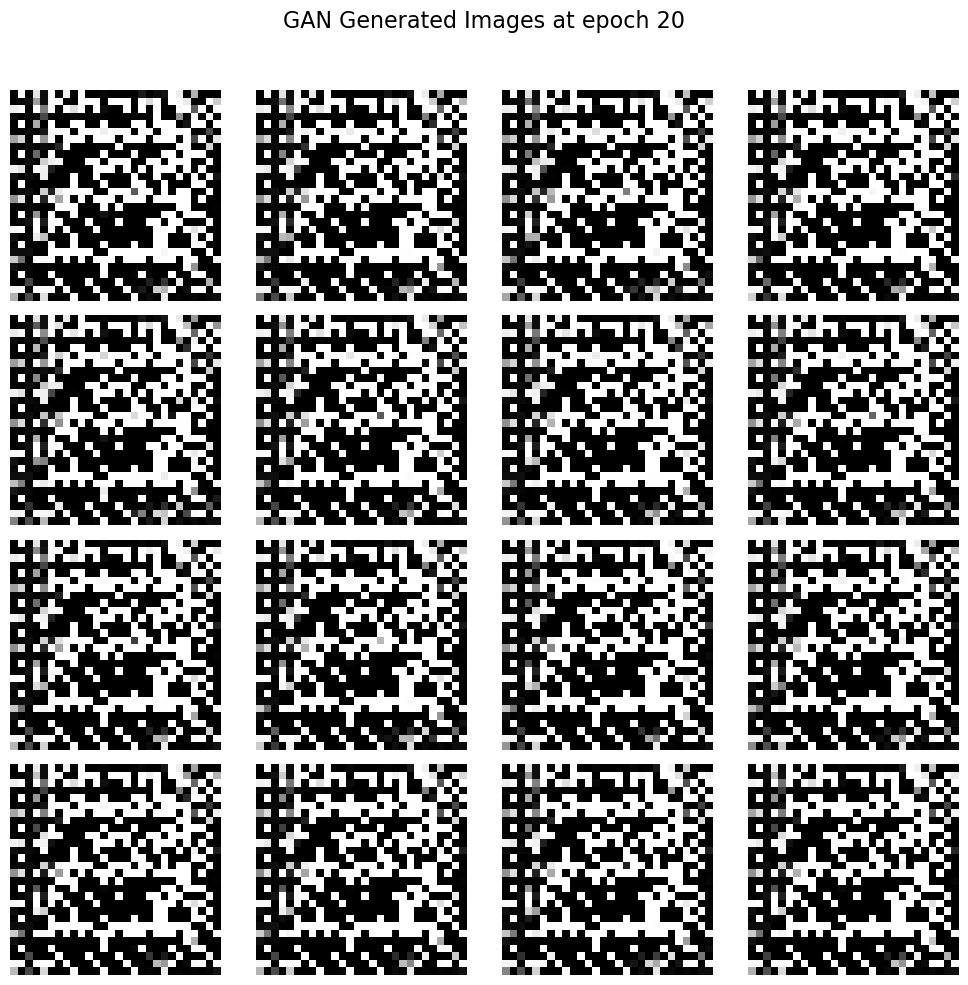

Epoch [21/200]:
epoch_d_loss: 0.007599 	epoch_g_loss: 5.554181
Epoch [22/200]:
epoch_d_loss: 0.024225 	epoch_g_loss: 4.763203
Epoch [23/200]:
epoch_d_loss: 0.037385 	epoch_g_loss: 5.121817
Epoch [24/200]:
epoch_d_loss: 0.030475 	epoch_g_loss: 5.282433
Epoch [25/200]:
epoch_d_loss: 0.042286 	epoch_g_loss: 4.447074
Epoch [26/200]:
epoch_d_loss: 0.055075 	epoch_g_loss: 4.548022
Epoch [27/200]:
epoch_d_loss: 0.079960 	epoch_g_loss: 4.495118
Epoch [28/200]:
epoch_d_loss: 0.224156 	epoch_g_loss: 3.539649
Epoch [29/200]:
epoch_d_loss: 0.318361 	epoch_g_loss: 3.357204
Epoch [30/200]:
epoch_d_loss: 0.204896 	epoch_g_loss: 3.859557


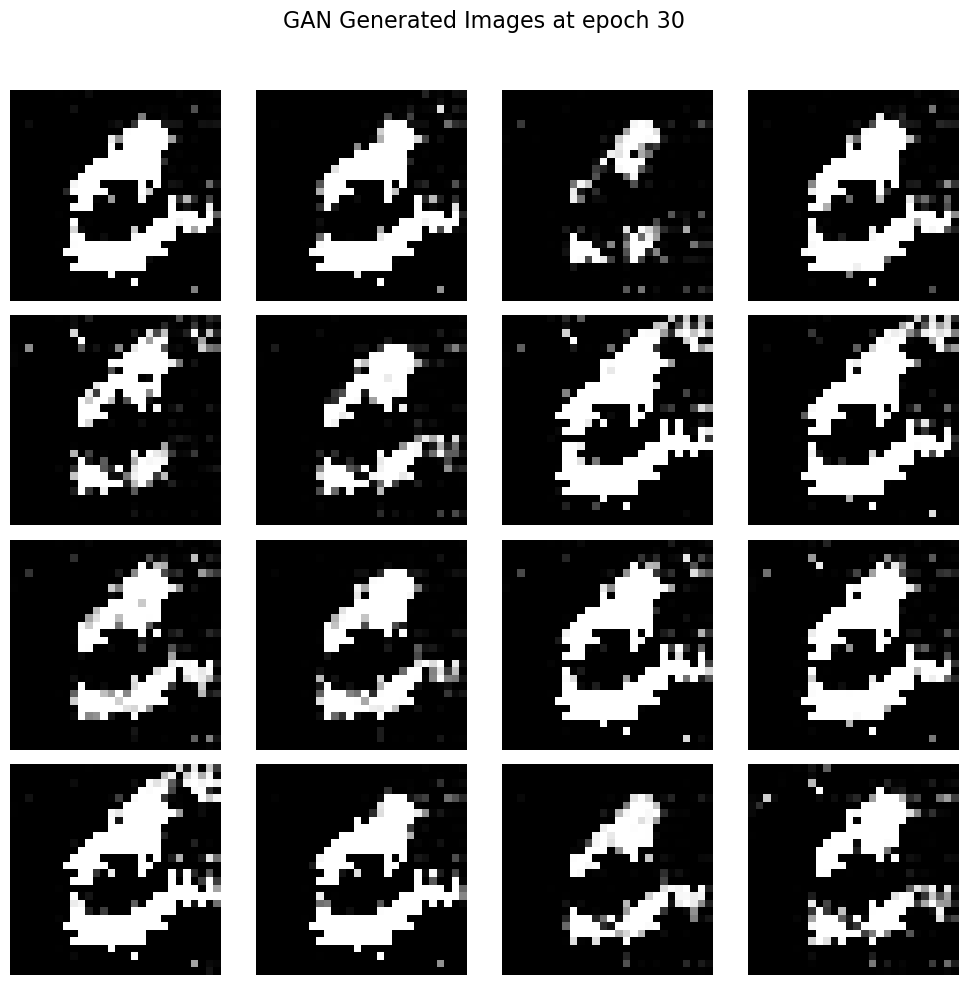

Epoch [31/200]:
epoch_d_loss: 0.218634 	epoch_g_loss: 3.911695
Epoch [32/200]:
epoch_d_loss: 0.136140 	epoch_g_loss: 4.126100
Epoch [33/200]:
epoch_d_loss: 0.130027 	epoch_g_loss: 4.085336
Epoch [34/200]:
epoch_d_loss: 0.138745 	epoch_g_loss: 4.038423
Epoch [35/200]:
epoch_d_loss: 0.122099 	epoch_g_loss: 4.010986
Epoch [36/200]:
epoch_d_loss: 0.240687 	epoch_g_loss: 4.104255
Epoch [37/200]:
epoch_d_loss: 0.532910 	epoch_g_loss: 2.908224
Epoch [38/200]:
epoch_d_loss: 0.353530 	epoch_g_loss: 3.064286
Epoch [39/200]:
epoch_d_loss: 0.205702 	epoch_g_loss: 3.389660
Epoch [40/200]:
epoch_d_loss: 0.383325 	epoch_g_loss: 3.133262


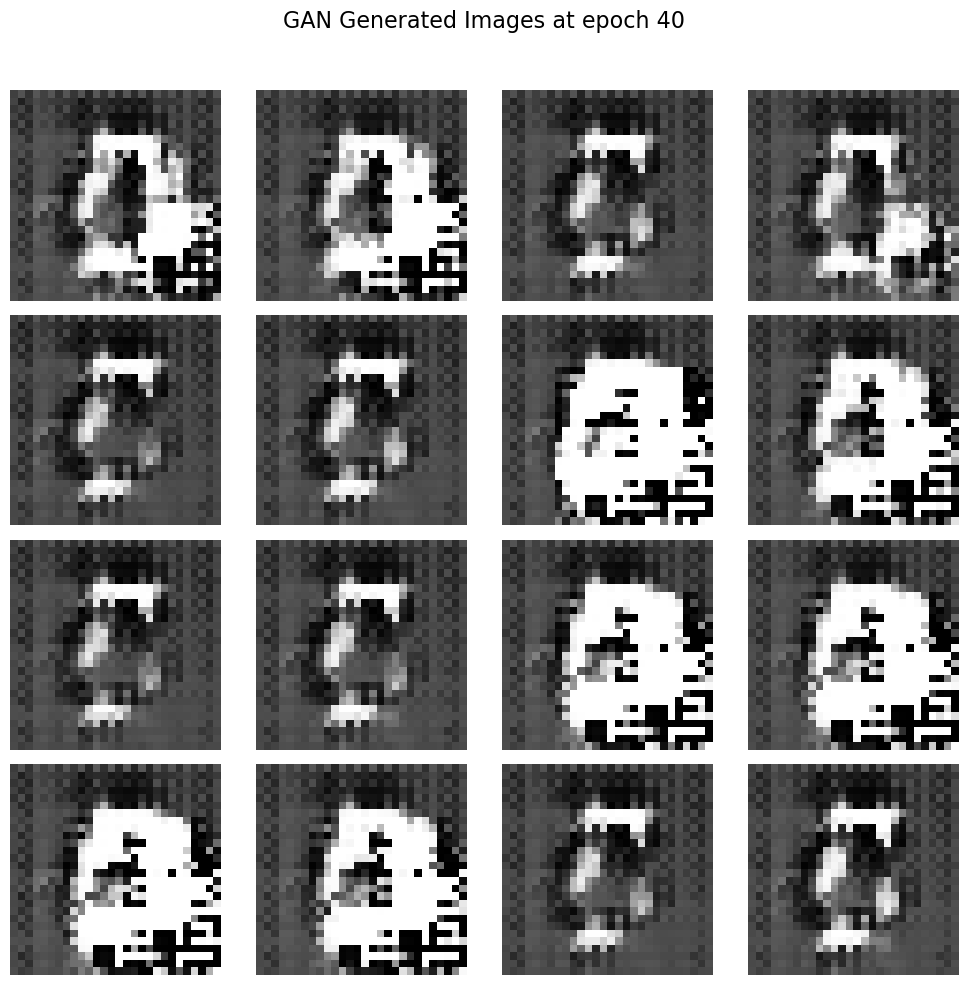

Epoch [41/200]:
epoch_d_loss: 0.343289 	epoch_g_loss: 3.418724
Epoch [42/200]:
epoch_d_loss: 0.483128 	epoch_g_loss: 3.103395
Epoch [43/200]:
epoch_d_loss: 0.389465 	epoch_g_loss: 3.016324
Epoch [44/200]:
epoch_d_loss: 0.287127 	epoch_g_loss: 3.254437
Epoch [45/200]:
epoch_d_loss: 0.227984 	epoch_g_loss: 3.076502
Epoch [46/200]:
epoch_d_loss: 0.342311 	epoch_g_loss: 3.142174
Epoch [47/200]:
epoch_d_loss: 0.572032 	epoch_g_loss: 3.101520
Epoch [48/200]:
epoch_d_loss: 0.218338 	epoch_g_loss: 2.870448
Epoch [49/200]:
epoch_d_loss: 0.369089 	epoch_g_loss: 2.836528
Epoch [50/200]:
epoch_d_loss: 0.594358 	epoch_g_loss: 2.503976


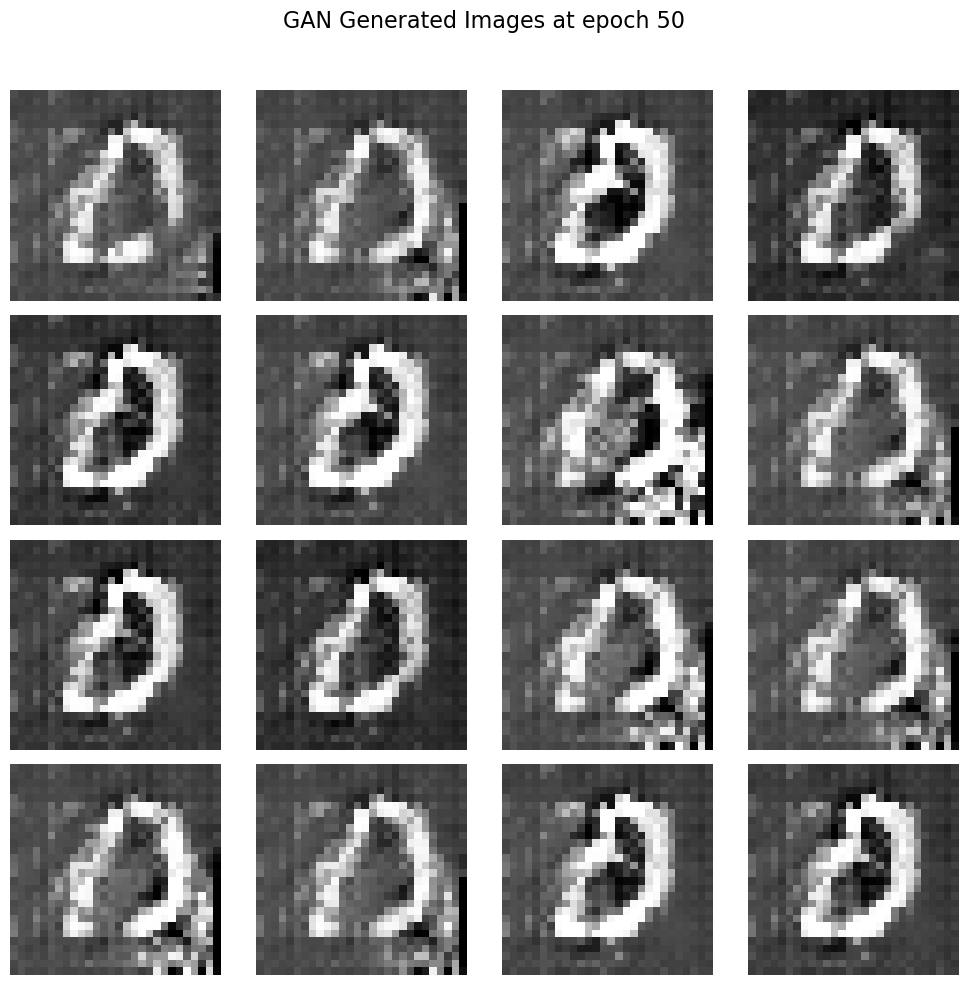

Epoch [51/200]:
epoch_d_loss: 0.536450 	epoch_g_loss: 2.548575
Epoch [52/200]:
epoch_d_loss: 0.582613 	epoch_g_loss: 2.774739
Epoch [53/200]:
epoch_d_loss: 0.201495 	epoch_g_loss: 3.014361
Epoch [54/200]:
epoch_d_loss: 0.300711 	epoch_g_loss: 3.190910
Epoch [55/200]:
epoch_d_loss: 0.266210 	epoch_g_loss: 2.954493
Epoch [56/200]:
epoch_d_loss: 0.460718 	epoch_g_loss: 2.913044
Epoch [57/200]:
epoch_d_loss: 0.311595 	epoch_g_loss: 2.870991
Epoch [58/200]:
epoch_d_loss: 0.478255 	epoch_g_loss: 2.760383
Epoch [59/200]:
epoch_d_loss: 0.721219 	epoch_g_loss: 2.739761
Epoch [60/200]:
epoch_d_loss: 0.284127 	epoch_g_loss: 2.688829


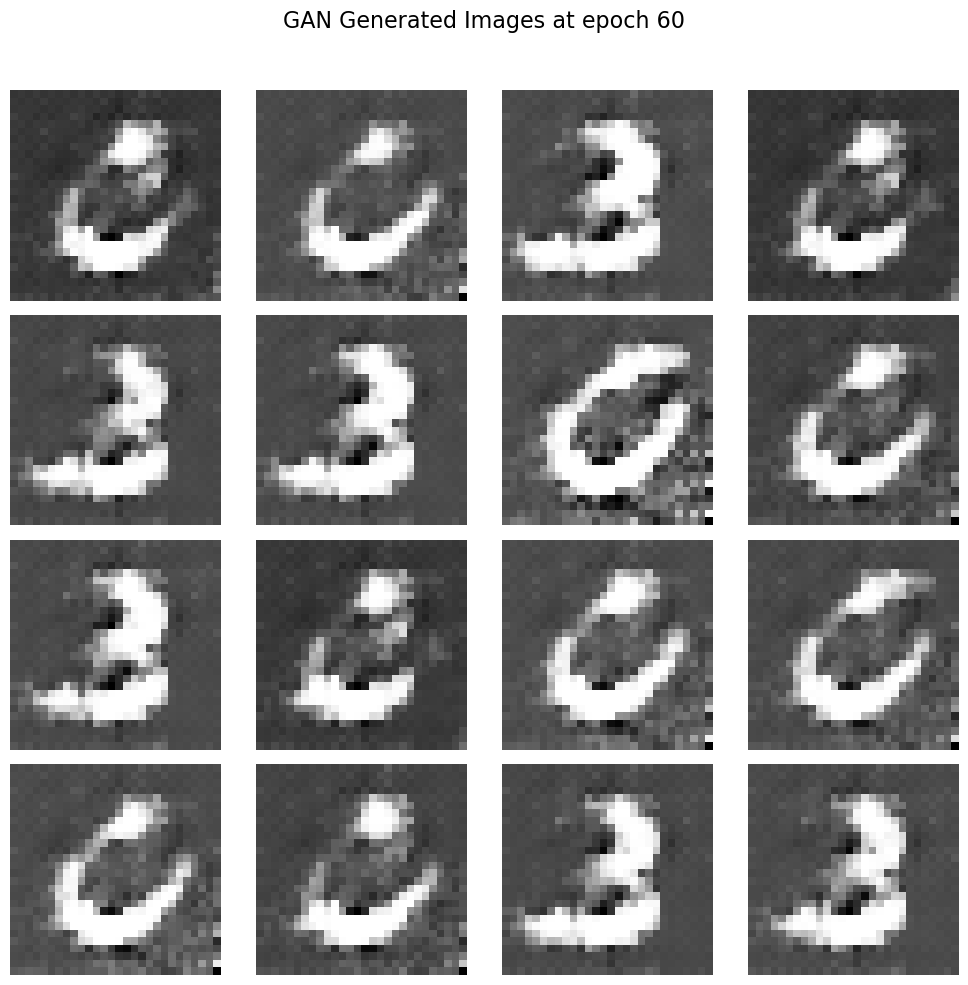

Epoch [61/200]:
epoch_d_loss: 0.453525 	epoch_g_loss: 2.627349
Epoch [62/200]:
epoch_d_loss: 0.706146 	epoch_g_loss: 2.561697
Epoch [63/200]:
epoch_d_loss: 0.732509 	epoch_g_loss: 2.338256
Epoch [64/200]:
epoch_d_loss: 0.520830 	epoch_g_loss: 2.441338
Epoch [65/200]:
epoch_d_loss: 0.530623 	epoch_g_loss: 2.554206
Epoch [66/200]:
epoch_d_loss: 0.386975 	epoch_g_loss: 2.503661
Epoch [67/200]:
epoch_d_loss: 0.370697 	epoch_g_loss: 2.667302
Epoch [68/200]:
epoch_d_loss: 0.532916 	epoch_g_loss: 2.642484
Epoch [69/200]:
epoch_d_loss: 0.334296 	epoch_g_loss: 2.611888
Epoch [70/200]:
epoch_d_loss: 0.436535 	epoch_g_loss: 2.510919


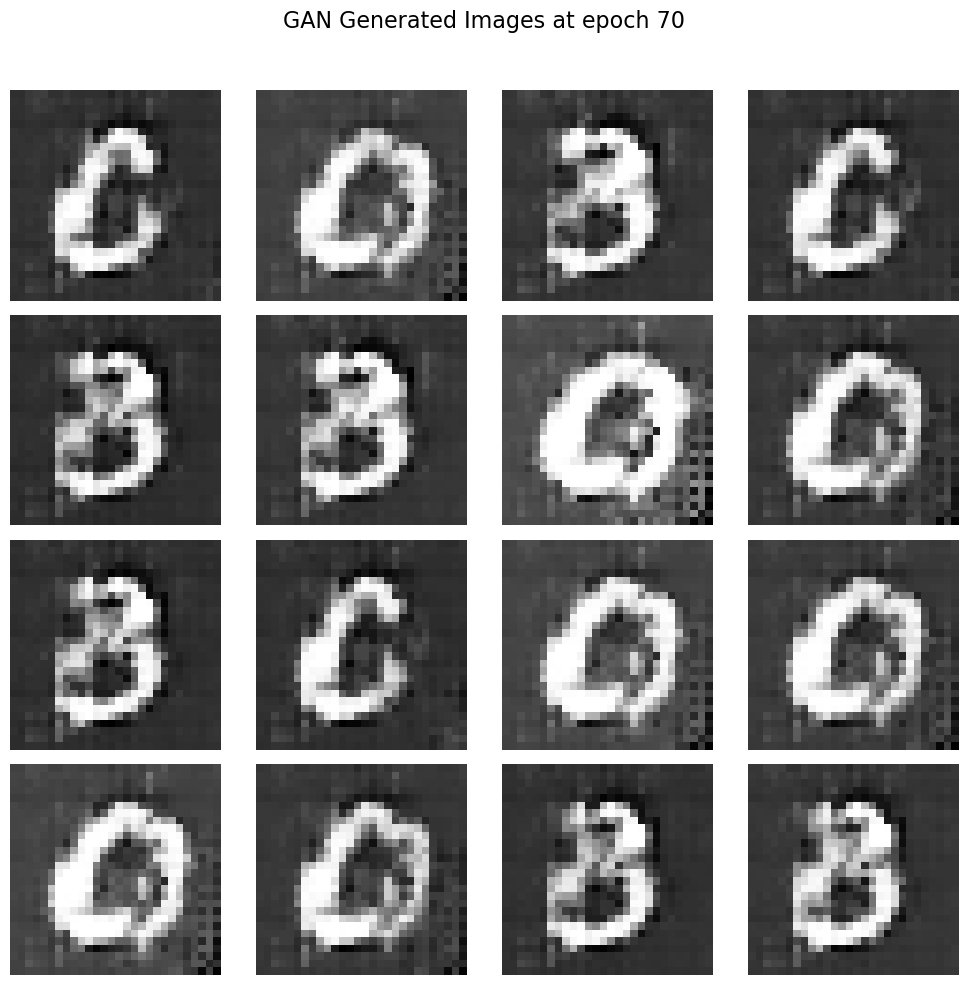

Epoch [71/200]:
epoch_d_loss: 0.653562 	epoch_g_loss: 2.670580
Epoch [72/200]:
epoch_d_loss: 0.360603 	epoch_g_loss: 2.601279
Epoch [73/200]:
epoch_d_loss: 0.456553 	epoch_g_loss: 2.497789
Epoch [74/200]:
epoch_d_loss: 0.457988 	epoch_g_loss: 2.728720
Epoch [75/200]:
epoch_d_loss: 0.314658 	epoch_g_loss: 2.925576
Epoch [76/200]:
epoch_d_loss: 0.308658 	epoch_g_loss: 2.769759
Epoch [77/200]:
epoch_d_loss: 0.567794 	epoch_g_loss: 2.677455
Epoch [78/200]:
epoch_d_loss: 0.270939 	epoch_g_loss: 2.949887
Epoch [79/200]:
epoch_d_loss: 0.275409 	epoch_g_loss: 2.867569
Epoch [80/200]:
epoch_d_loss: 0.349341 	epoch_g_loss: 2.750582


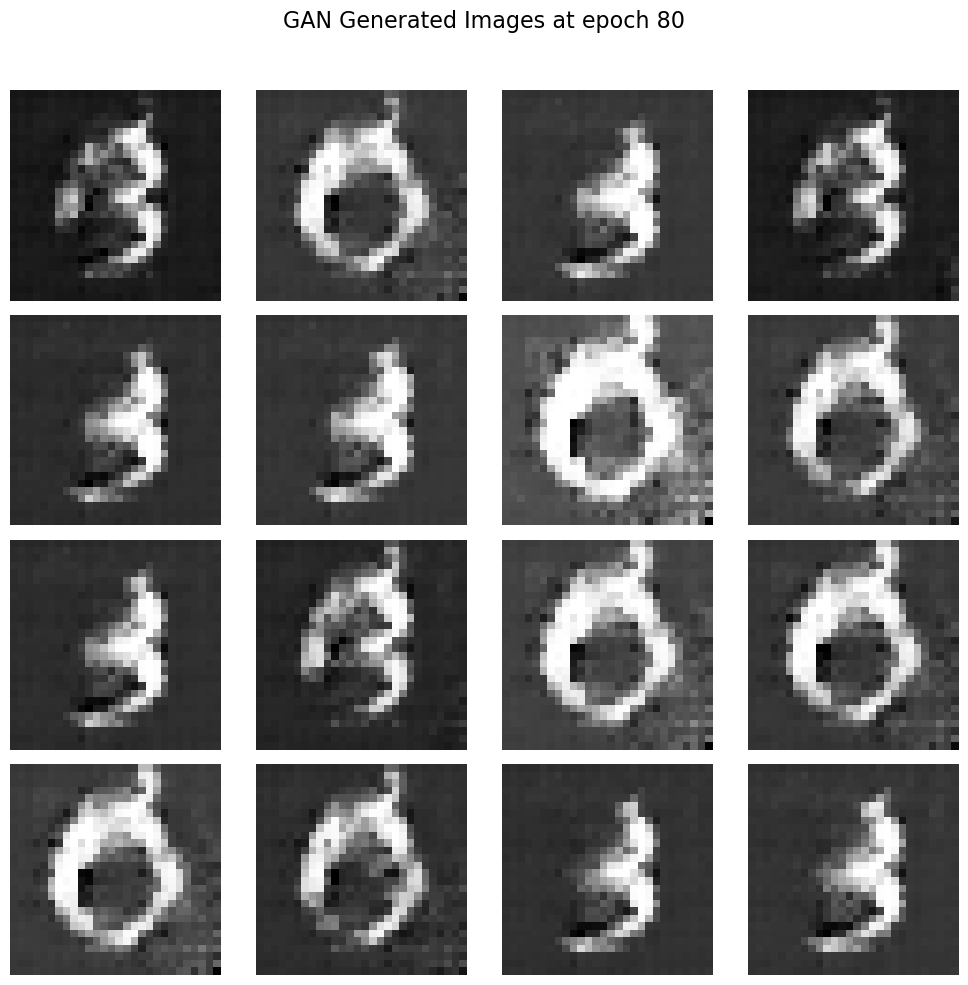

Epoch [81/200]:
epoch_d_loss: 0.388003 	epoch_g_loss: 2.607336
Epoch [82/200]:
epoch_d_loss: 0.415639 	epoch_g_loss: 2.526433
Epoch [83/200]:
epoch_d_loss: 0.582603 	epoch_g_loss: 2.641721
Epoch [84/200]:
epoch_d_loss: 0.797900 	epoch_g_loss: 2.329353
Epoch [85/200]:
epoch_d_loss: 0.527879 	epoch_g_loss: 2.728212
Epoch [86/200]:
epoch_d_loss: 0.295512 	epoch_g_loss: 2.776942
Epoch [87/200]:
epoch_d_loss: 0.485351 	epoch_g_loss: 2.485166
Epoch [88/200]:
epoch_d_loss: 0.540912 	epoch_g_loss: 2.561979
Epoch [89/200]:
epoch_d_loss: 0.613621 	epoch_g_loss: 2.426582
Epoch [90/200]:
epoch_d_loss: 0.476617 	epoch_g_loss: 2.373728


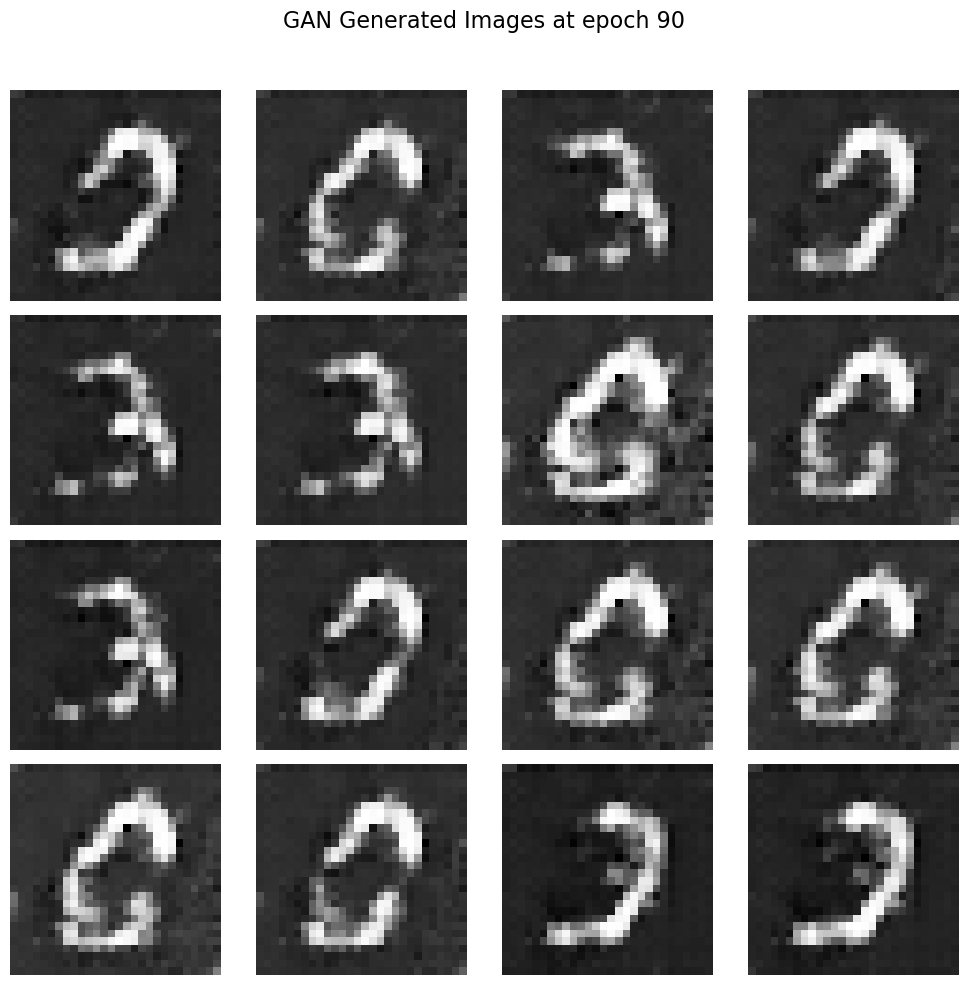

Epoch [91/200]:
epoch_d_loss: 0.489415 	epoch_g_loss: 2.534115
Epoch [92/200]:
epoch_d_loss: 0.553684 	epoch_g_loss: 2.488172
Epoch [93/200]:
epoch_d_loss: 0.397836 	epoch_g_loss: 2.473068
Epoch [94/200]:
epoch_d_loss: 0.563584 	epoch_g_loss: 2.563913
Epoch [95/200]:
epoch_d_loss: 0.415145 	epoch_g_loss: 2.805608
Epoch [96/200]:
epoch_d_loss: 0.312595 	epoch_g_loss: 2.600399
Epoch [97/200]:
epoch_d_loss: 0.698129 	epoch_g_loss: 2.144996
Epoch [98/200]:
epoch_d_loss: 0.643934 	epoch_g_loss: 2.273546
Epoch [99/200]:
epoch_d_loss: 0.961725 	epoch_g_loss: 2.128217
Epoch [100/200]:
epoch_d_loss: 0.513014 	epoch_g_loss: 2.476714


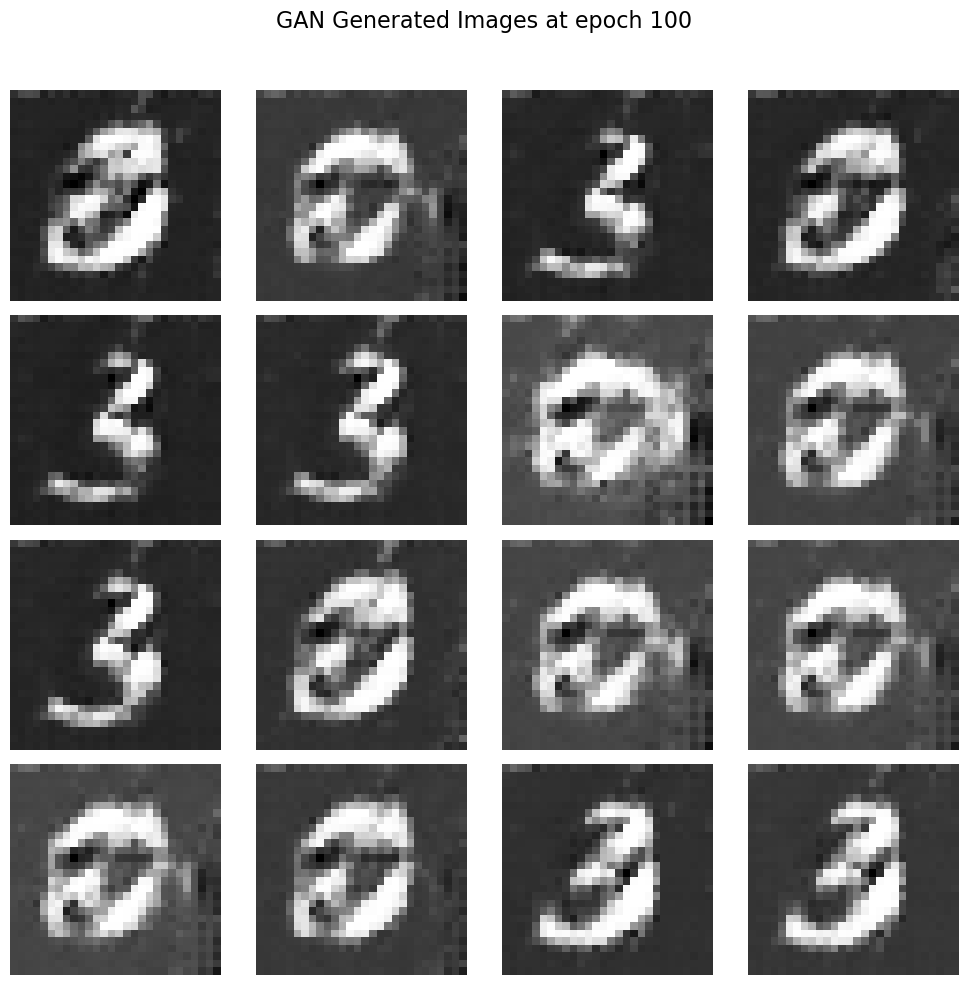

Epoch [101/200]:
epoch_d_loss: 0.394827 	epoch_g_loss: 2.346166
Epoch [102/200]:
epoch_d_loss: 0.606227 	epoch_g_loss: 2.433649
Epoch [103/200]:
epoch_d_loss: 0.698021 	epoch_g_loss: 2.357683
Epoch [104/200]:
epoch_d_loss: 0.480616 	epoch_g_loss: 2.264494
Epoch [105/200]:
epoch_d_loss: 0.572379 	epoch_g_loss: 2.262786
Epoch [106/200]:
epoch_d_loss: 0.628210 	epoch_g_loss: 2.202870
Epoch [107/200]:
epoch_d_loss: 0.524981 	epoch_g_loss: 2.242104
Epoch [108/200]:
epoch_d_loss: 0.544363 	epoch_g_loss: 2.422242
Epoch [109/200]:
epoch_d_loss: 0.494189 	epoch_g_loss: 2.410148
Epoch [110/200]:
epoch_d_loss: 0.705680 	epoch_g_loss: 2.266597


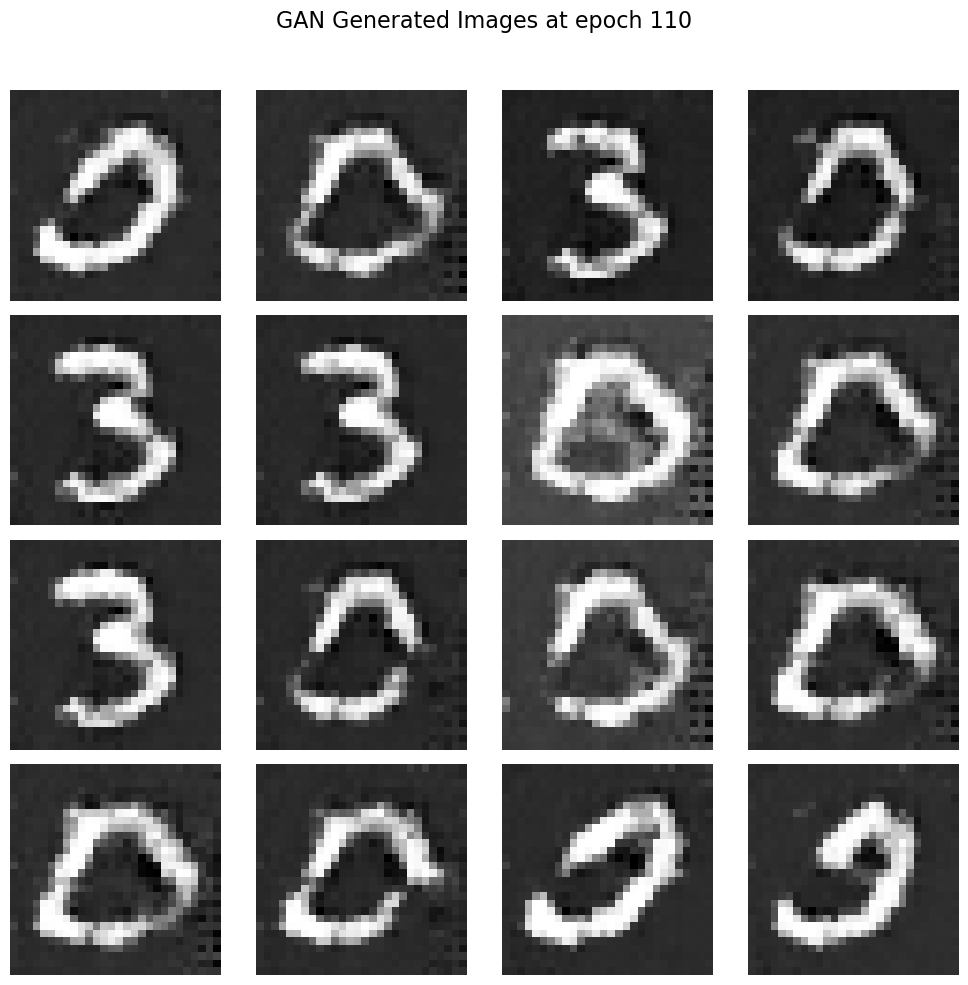

Epoch [111/200]:
epoch_d_loss: 0.702911 	epoch_g_loss: 2.173522
Epoch [112/200]:
epoch_d_loss: 0.586070 	epoch_g_loss: 2.166739
Epoch [113/200]:
epoch_d_loss: 0.715318 	epoch_g_loss: 2.238523
Epoch [114/200]:
epoch_d_loss: 0.706131 	epoch_g_loss: 2.141316
Epoch [115/200]:
epoch_d_loss: 0.544423 	epoch_g_loss: 2.051790
Epoch [116/200]:
epoch_d_loss: 0.981053 	epoch_g_loss: 1.958216
Epoch [117/200]:
epoch_d_loss: 0.690256 	epoch_g_loss: 2.158077
Epoch [118/200]:
epoch_d_loss: 0.704130 	epoch_g_loss: 2.164837
Epoch [119/200]:
epoch_d_loss: 0.668111 	epoch_g_loss: 2.060642
Epoch [120/200]:
epoch_d_loss: 0.692364 	epoch_g_loss: 2.027008


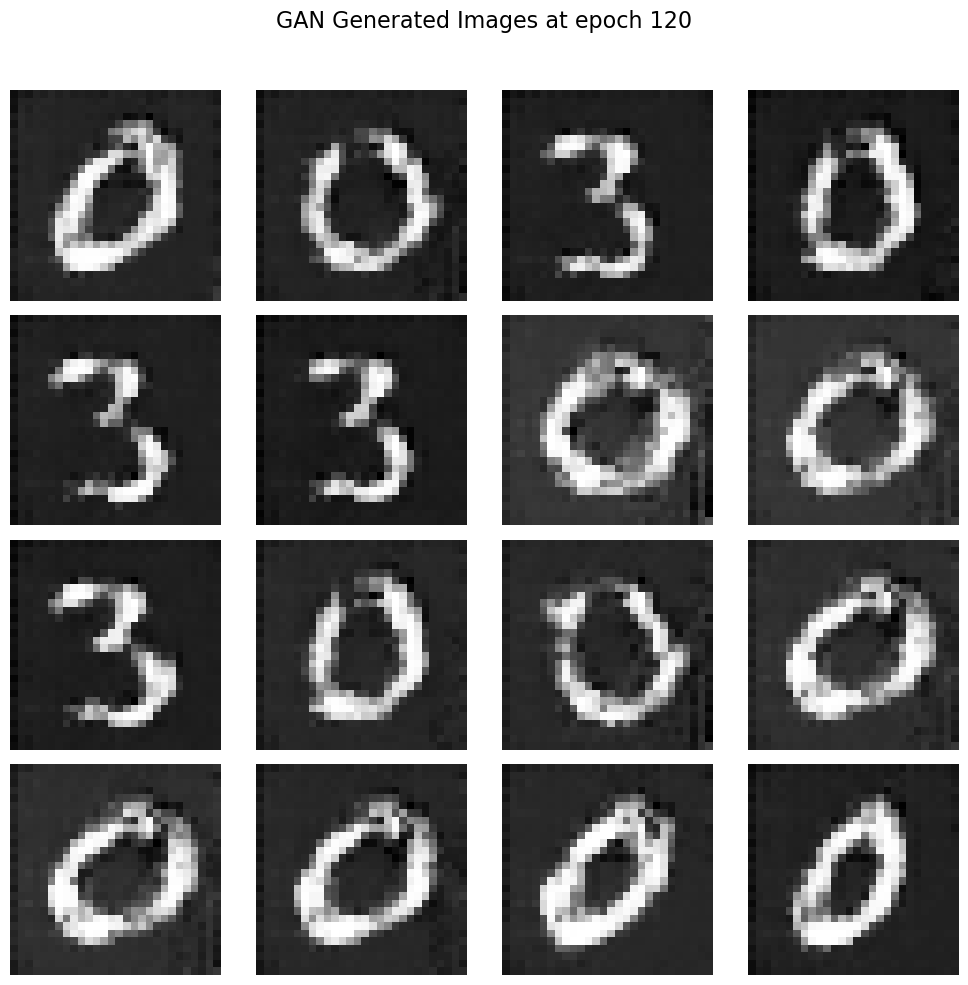

Epoch [121/200]:
epoch_d_loss: 0.794518 	epoch_g_loss: 1.937645
Epoch [122/200]:
epoch_d_loss: 0.777490 	epoch_g_loss: 2.011587
Epoch [123/200]:
epoch_d_loss: 0.730810 	epoch_g_loss: 1.903338
Epoch [124/200]:
epoch_d_loss: 0.756908 	epoch_g_loss: 2.118183
Epoch [125/200]:
epoch_d_loss: 0.652337 	epoch_g_loss: 2.119065
Epoch [126/200]:
epoch_d_loss: 0.803408 	epoch_g_loss: 1.886849
Epoch [127/200]:
epoch_d_loss: 0.904188 	epoch_g_loss: 2.045588
Epoch [128/200]:
epoch_d_loss: 0.693525 	epoch_g_loss: 1.907765
Epoch [129/200]:
epoch_d_loss: 0.810124 	epoch_g_loss: 2.001432
Epoch [130/200]:
epoch_d_loss: 0.734441 	epoch_g_loss: 1.903848


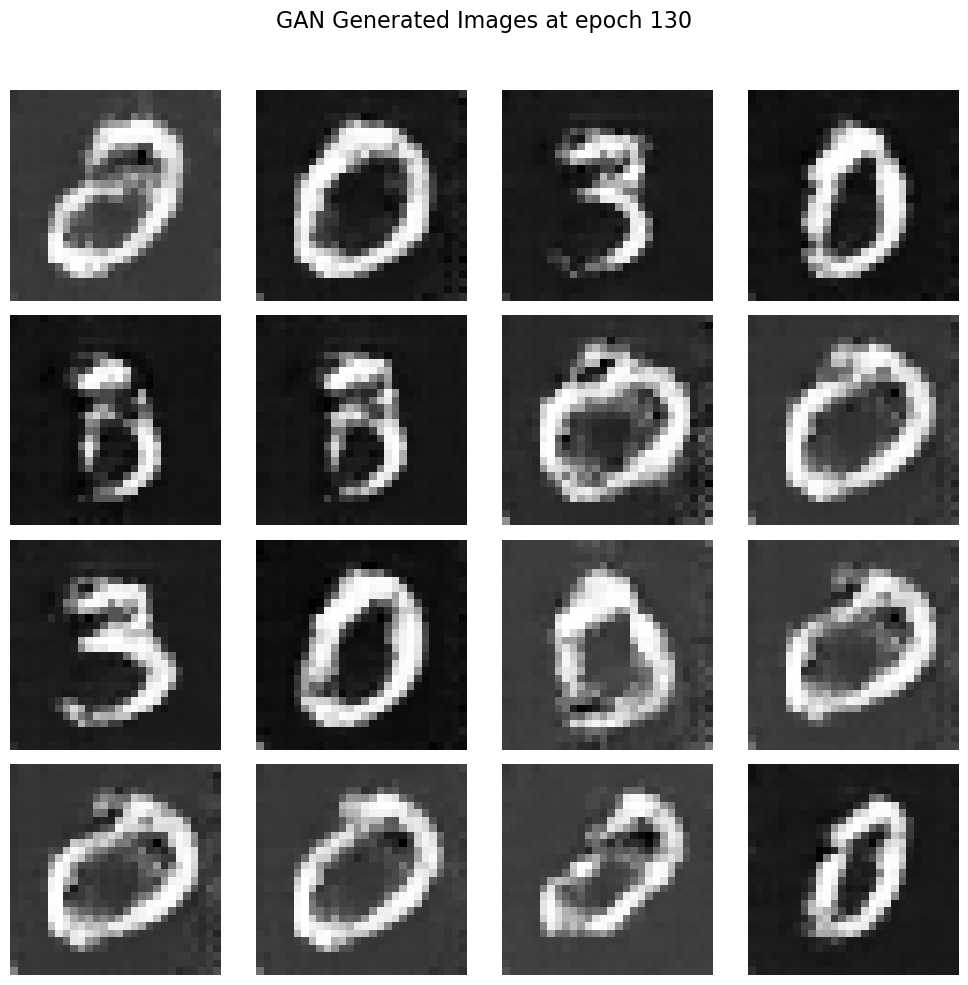

Epoch [131/200]:
epoch_d_loss: 0.820642 	epoch_g_loss: 1.979974
Epoch [132/200]:
epoch_d_loss: 0.777891 	epoch_g_loss: 1.884288
Epoch [133/200]:
epoch_d_loss: 0.858202 	epoch_g_loss: 1.966573
Epoch [134/200]:
epoch_d_loss: 0.784815 	epoch_g_loss: 1.861219
Epoch [135/200]:
epoch_d_loss: 0.913722 	epoch_g_loss: 1.813822
Epoch [136/200]:
epoch_d_loss: 0.860779 	epoch_g_loss: 1.787007
Epoch [137/200]:
epoch_d_loss: 0.816628 	epoch_g_loss: 1.948425
Epoch [138/200]:
epoch_d_loss: 0.816290 	epoch_g_loss: 1.991764
Epoch [139/200]:
epoch_d_loss: 0.852644 	epoch_g_loss: 1.863674
Epoch [140/200]:
epoch_d_loss: 0.909873 	epoch_g_loss: 1.800682


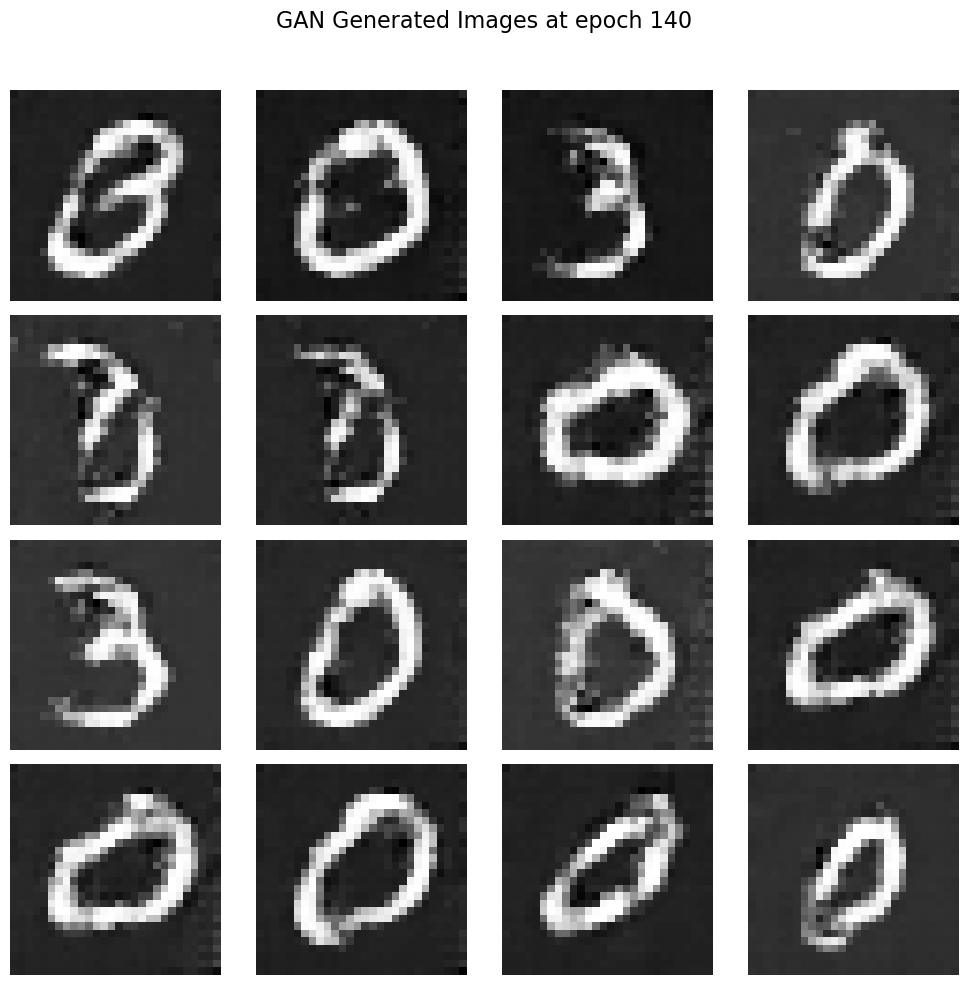

Epoch [141/200]:
epoch_d_loss: 0.933223 	epoch_g_loss: 1.695607
Epoch [142/200]:
epoch_d_loss: 0.907975 	epoch_g_loss: 1.809117
Epoch [143/200]:
epoch_d_loss: 0.936740 	epoch_g_loss: 1.695435
Epoch [144/200]:
epoch_d_loss: 0.961974 	epoch_g_loss: 1.686053
Epoch [145/200]:
epoch_d_loss: 0.958054 	epoch_g_loss: 1.627532
Epoch [146/200]:
epoch_d_loss: 1.009894 	epoch_g_loss: 1.702358
Epoch [147/200]:
epoch_d_loss: 1.025092 	epoch_g_loss: 1.578990
Epoch [148/200]:
epoch_d_loss: 0.943793 	epoch_g_loss: 1.558832
Epoch [149/200]:
epoch_d_loss: 1.009292 	epoch_g_loss: 1.472025
Epoch [150/200]:
epoch_d_loss: 1.075410 	epoch_g_loss: 1.488087


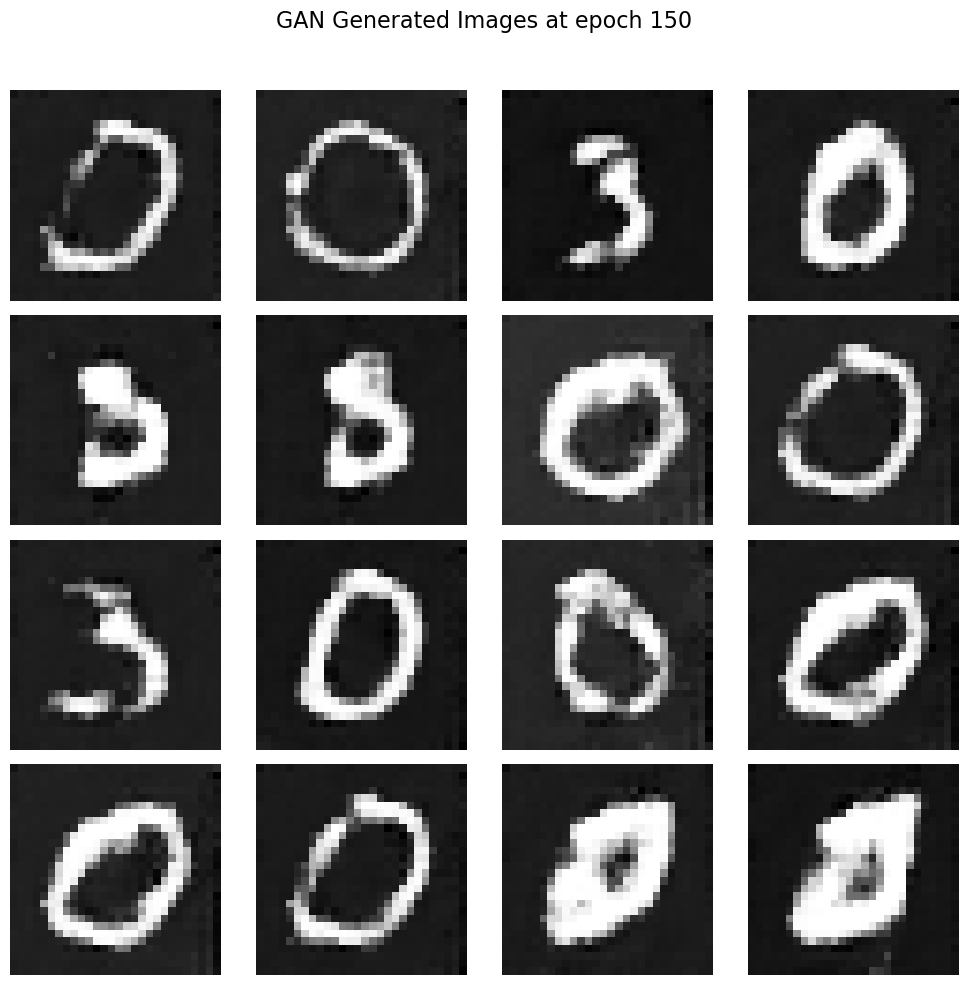

Epoch [151/200]:
epoch_d_loss: 1.019376 	epoch_g_loss: 1.501901
Epoch [152/200]:
epoch_d_loss: 0.952250 	epoch_g_loss: 1.536597
Epoch [153/200]:
epoch_d_loss: 1.052585 	epoch_g_loss: 1.423442
Epoch [154/200]:
epoch_d_loss: 1.043119 	epoch_g_loss: 1.405484
Epoch [155/200]:
epoch_d_loss: 1.089094 	epoch_g_loss: 1.316937
Epoch [156/200]:
epoch_d_loss: 1.043720 	epoch_g_loss: 1.360747
Epoch [157/200]:
epoch_d_loss: 1.056847 	epoch_g_loss: 1.307735
Epoch [158/200]:
epoch_d_loss: 1.050833 	epoch_g_loss: 1.315239
Epoch [159/200]:
epoch_d_loss: 1.050268 	epoch_g_loss: 1.303834
Epoch [160/200]:
epoch_d_loss: 1.018181 	epoch_g_loss: 1.301674


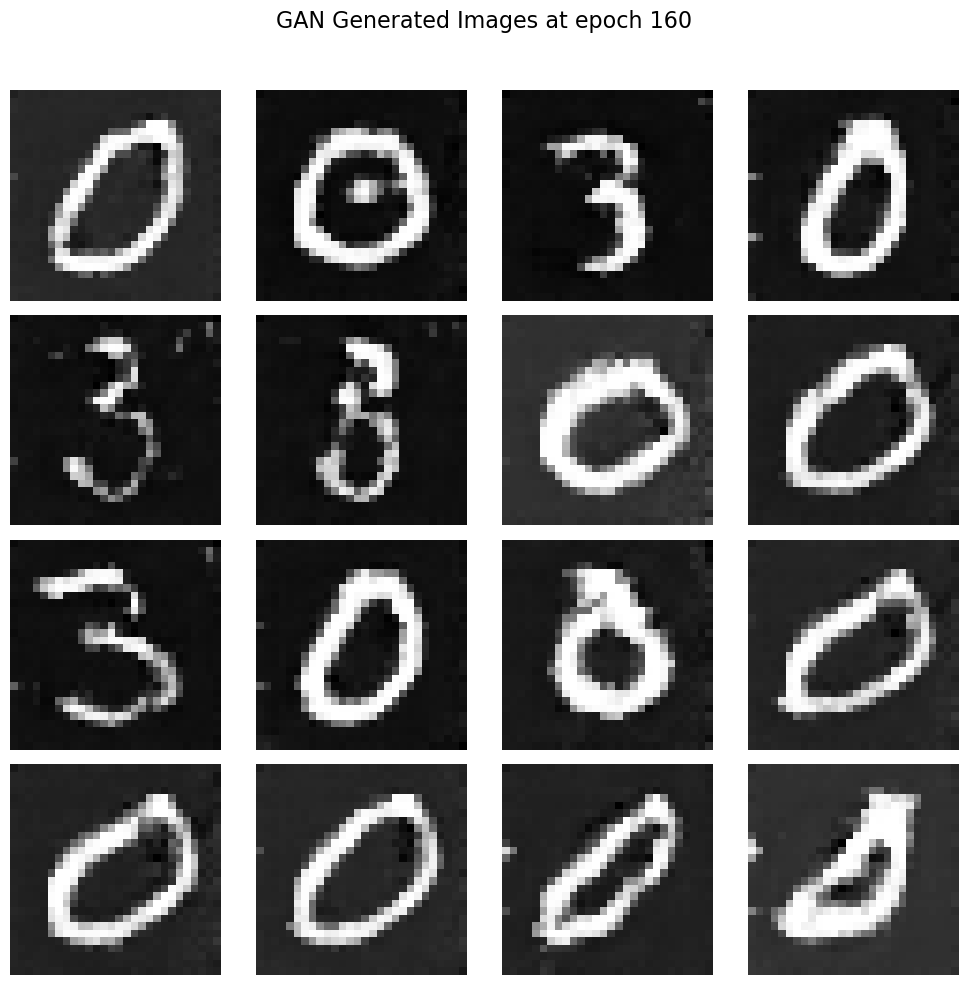

Epoch [161/200]:
epoch_d_loss: 1.065072 	epoch_g_loss: 1.257982
Epoch [162/200]:
epoch_d_loss: 1.089297 	epoch_g_loss: 1.310404
Epoch [163/200]:
epoch_d_loss: 1.077615 	epoch_g_loss: 1.264843
Epoch [164/200]:
epoch_d_loss: 1.027316 	epoch_g_loss: 1.287250
Epoch [165/200]:
epoch_d_loss: 1.055604 	epoch_g_loss: 1.234593
Epoch [166/200]:
epoch_d_loss: 1.041372 	epoch_g_loss: 1.251170
Epoch [167/200]:
epoch_d_loss: 1.067262 	epoch_g_loss: 1.249603
Epoch [168/200]:
epoch_d_loss: 1.041243 	epoch_g_loss: 1.284234
Epoch [169/200]:
epoch_d_loss: 0.985583 	epoch_g_loss: 1.242806
Epoch [170/200]:
epoch_d_loss: 1.033871 	epoch_g_loss: 1.235626


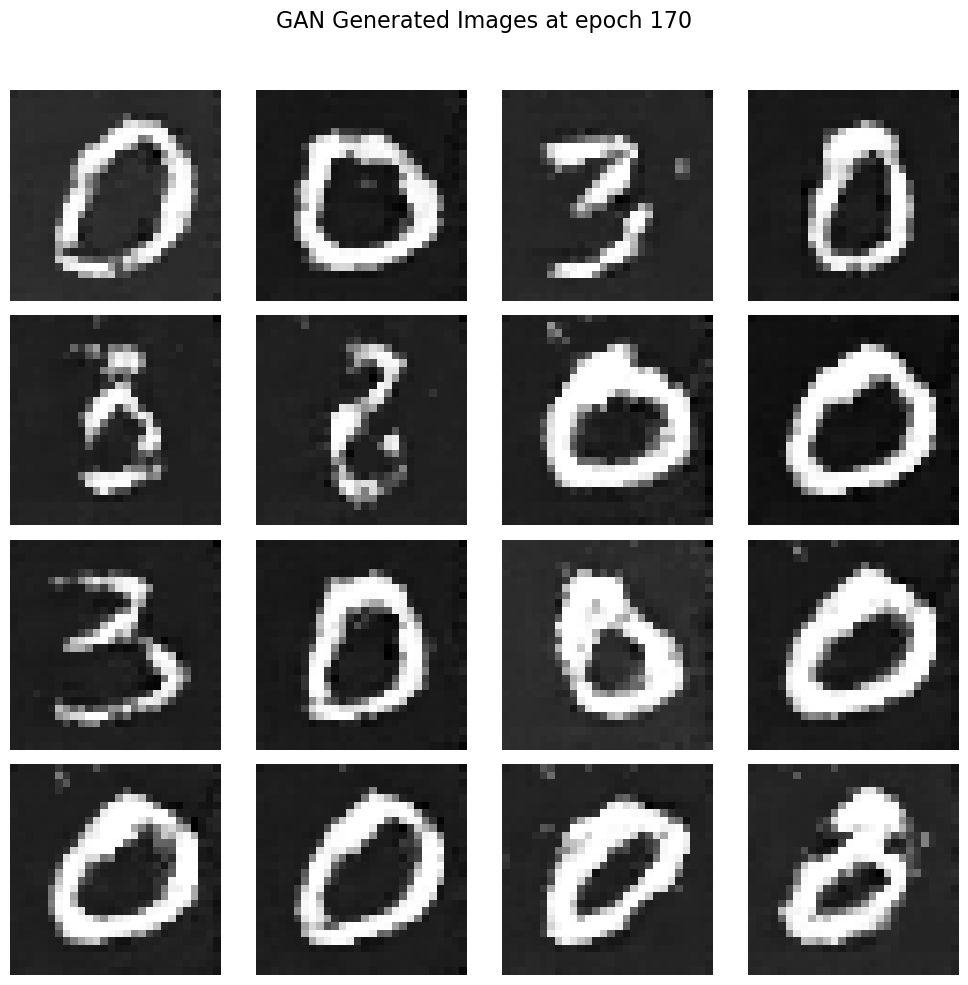

Epoch [171/200]:
epoch_d_loss: 1.073911 	epoch_g_loss: 1.242097
Epoch [172/200]:
epoch_d_loss: 1.039490 	epoch_g_loss: 1.221909
Epoch [173/200]:
epoch_d_loss: 1.038439 	epoch_g_loss: 1.198339
Epoch [174/200]:
epoch_d_loss: 1.074000 	epoch_g_loss: 1.222197
Epoch [175/200]:
epoch_d_loss: 1.060902 	epoch_g_loss: 1.239499
Epoch [176/200]:
epoch_d_loss: 1.020213 	epoch_g_loss: 1.203352
Epoch [177/200]:
epoch_d_loss: 1.039597 	epoch_g_loss: 1.170231
Epoch [178/200]:
epoch_d_loss: 1.053856 	epoch_g_loss: 1.178226
Epoch [179/200]:
epoch_d_loss: 1.079751 	epoch_g_loss: 1.189836
Epoch [180/200]:
epoch_d_loss: 1.052423 	epoch_g_loss: 1.183090


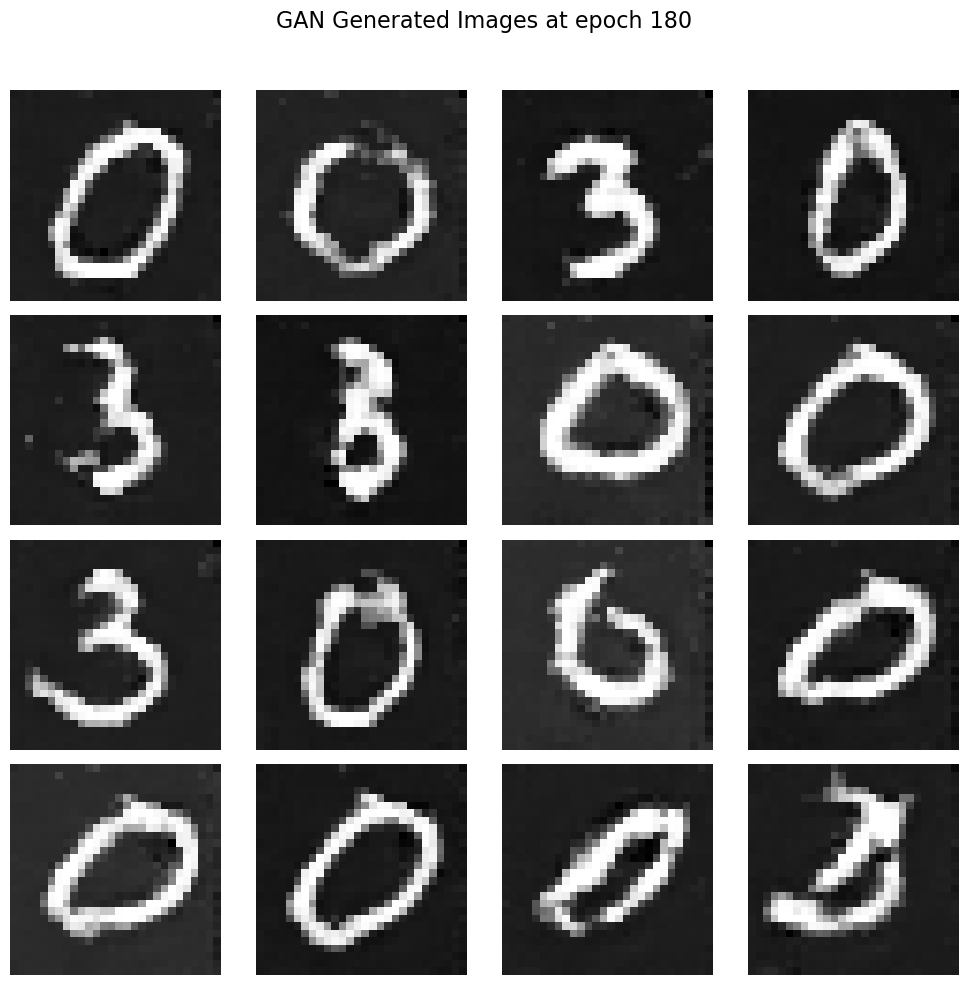

Epoch [181/200]:
epoch_d_loss: 1.065744 	epoch_g_loss: 1.170408
Epoch [182/200]:
epoch_d_loss: 1.050713 	epoch_g_loss: 1.184743
Epoch [183/200]:
epoch_d_loss: 1.031321 	epoch_g_loss: 1.191065
Epoch [184/200]:
epoch_d_loss: 1.048256 	epoch_g_loss: 1.198171
Epoch [185/200]:
epoch_d_loss: 1.041547 	epoch_g_loss: 1.205106
Epoch [186/200]:
epoch_d_loss: 1.035995 	epoch_g_loss: 1.169725
Epoch [187/200]:
epoch_d_loss: 1.065235 	epoch_g_loss: 1.167242
Epoch [188/200]:
epoch_d_loss: 1.029804 	epoch_g_loss: 1.167807
Epoch [189/200]:
epoch_d_loss: 1.066165 	epoch_g_loss: 1.146297
Epoch [190/200]:
epoch_d_loss: 1.042478 	epoch_g_loss: 1.166848


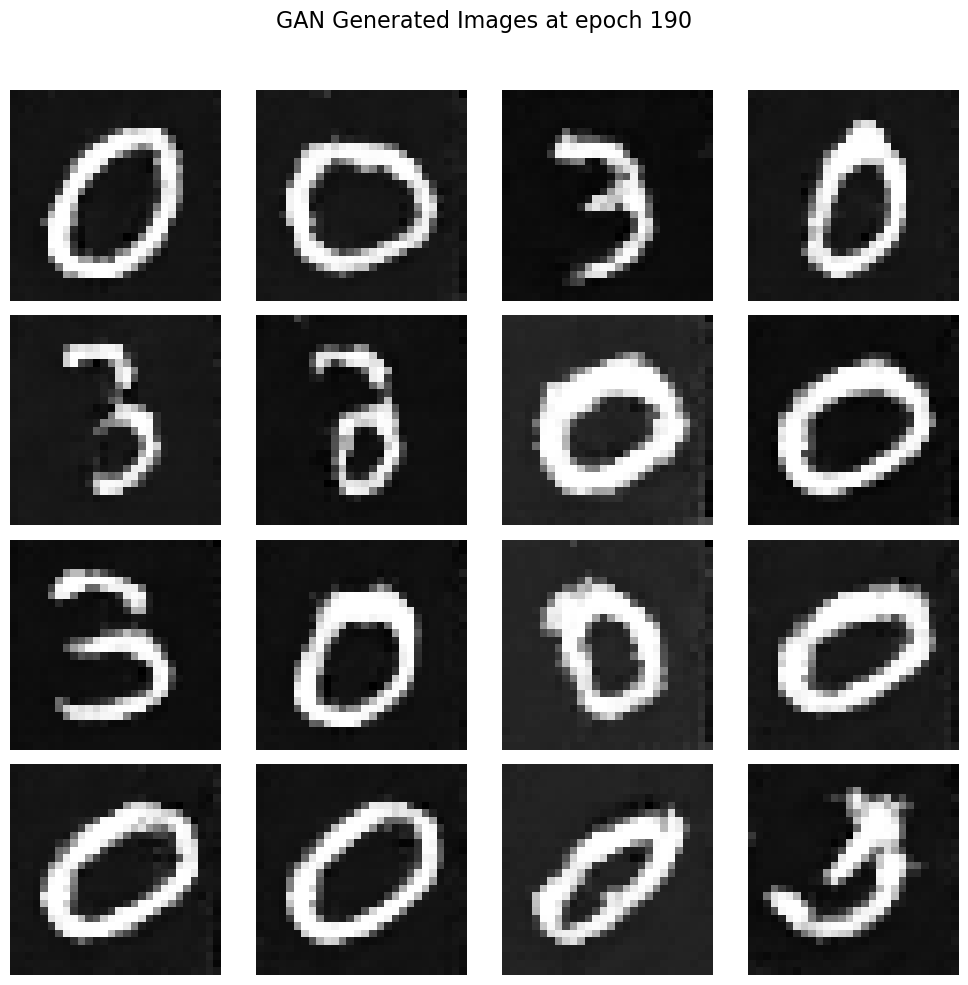

Epoch [191/200]:
epoch_d_loss: 1.014348 	epoch_g_loss: 1.167554
Epoch [192/200]:
epoch_d_loss: 1.030769 	epoch_g_loss: 1.144420
Epoch [193/200]:
epoch_d_loss: 1.053139 	epoch_g_loss: 1.196572
Epoch [194/200]:
epoch_d_loss: 1.024009 	epoch_g_loss: 1.173084
Epoch [195/200]:
epoch_d_loss: 1.045023 	epoch_g_loss: 1.184546
Epoch [196/200]:
epoch_d_loss: 1.032839 	epoch_g_loss: 1.165245
Epoch [197/200]:
epoch_d_loss: 1.045817 	epoch_g_loss: 1.140358
Epoch [198/200]:
epoch_d_loss: 1.062974 	epoch_g_loss: 1.179956
Epoch [199/200]:
epoch_d_loss: 1.043416 	epoch_g_loss: 1.158554
Epoch [200/200]:
epoch_d_loss: 1.050108 	epoch_g_loss: 1.136369


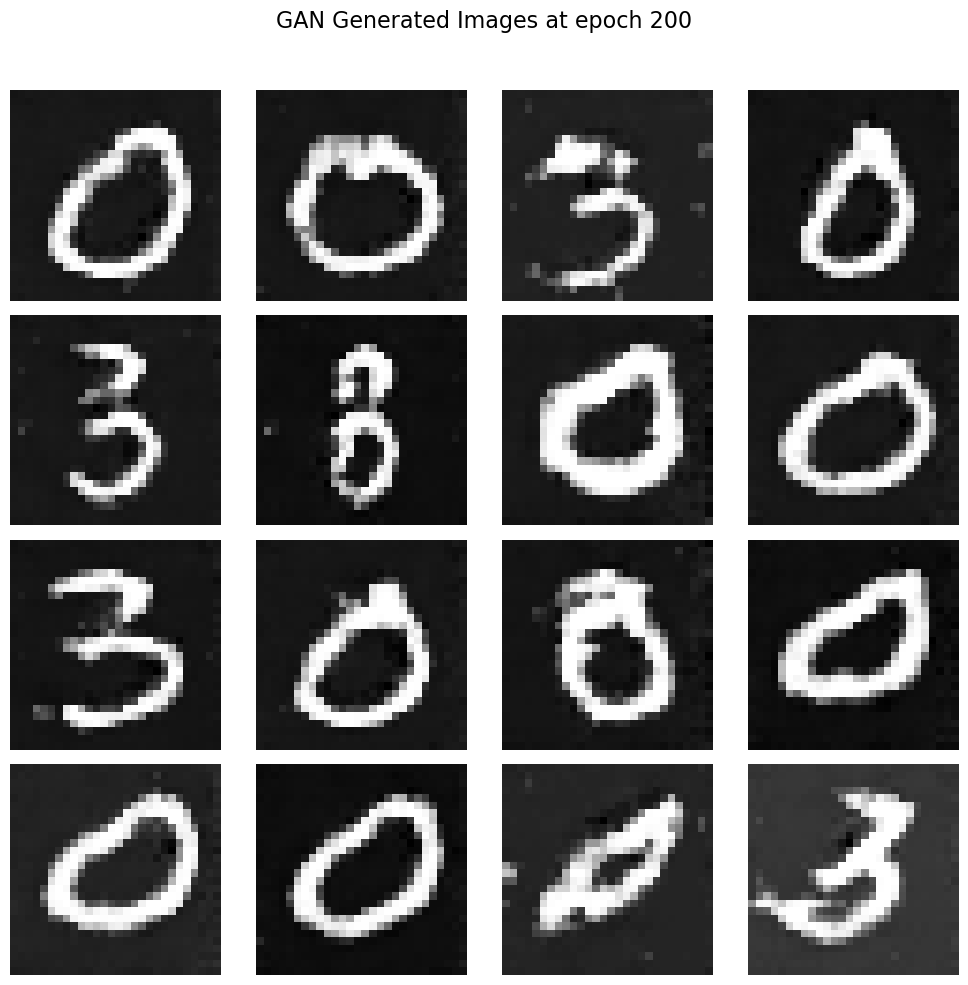

Time to train the generator on task  1   1176.5513553619385
Time to generate the data 262.37952303886414


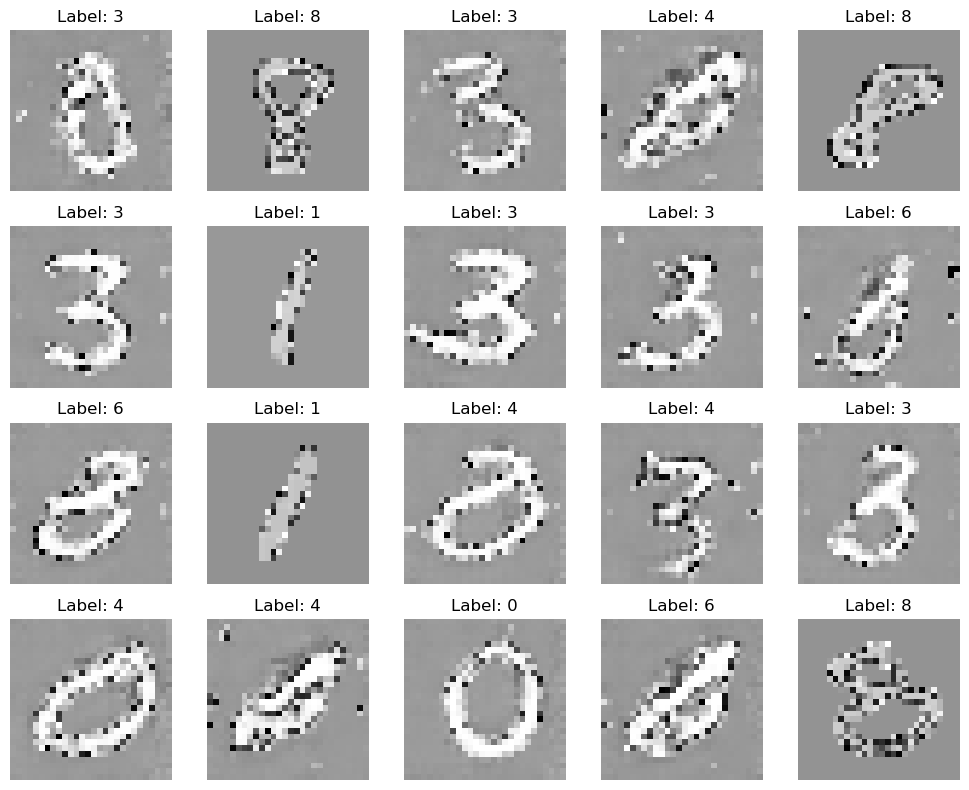

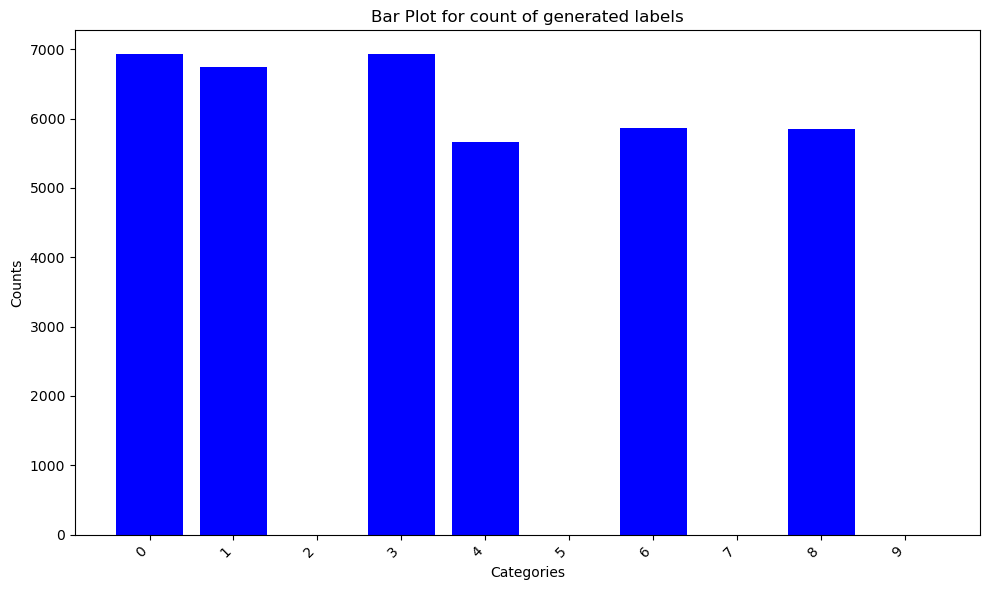

Epoch 0: Loss 2.058 Acc: 0.351
Epoch 1: Loss 1.627 Acc: 0.408
Epoch 2: Loss 1.500 Acc: 0.432
Epoch 3: Loss 1.442 Acc: 0.459
Epoch 4: Loss 1.345 Acc: 0.491
Epoch 5: Loss 1.188 Acc: 0.565
Epoch 6: Loss 0.986 Acc: 0.654
Epoch 7: Loss 0.797 Acc: 0.730
Epoch 8: Loss 0.674 Acc: 0.770
Epoch 9: Loss 0.592 Acc: 0.793
Epoch 10: Loss 0.541 Acc: 0.807
Epoch 11: Loss 0.499 Acc: 0.822
Epoch 12: Loss 0.466 Acc: 0.831
Epoch 13: Loss 0.429 Acc: 0.844
Epoch 14: Loss 0.397 Acc: 0.856
Epoch 15: Loss 0.382 Acc: 0.863
Epoch 16: Loss 0.359 Acc: 0.872
Epoch 17: Loss 0.342 Acc: 0.878
Epoch 18: Loss 0.319 Acc: 0.886
Epoch 19: Loss 0.296 Acc: 0.896
Time to train the solver on task  2   159.493332862854
[6, 4, 0, 3, 8, 1]
Training on [cuda]...
Epoch [1/200]:
epoch_d_loss: 0.513807 	epoch_g_loss: 1.831271
Epoch [2/200]:
epoch_d_loss: 0.624644 	epoch_g_loss: 1.635222
Epoch [3/200]:
epoch_d_loss: 0.537076 	epoch_g_loss: 2.224762
Epoch [4/200]:
epoch_d_loss: 0.371248 	epoch_g_loss: 2.456907
Epoch [5/200]:
epoch_d_los

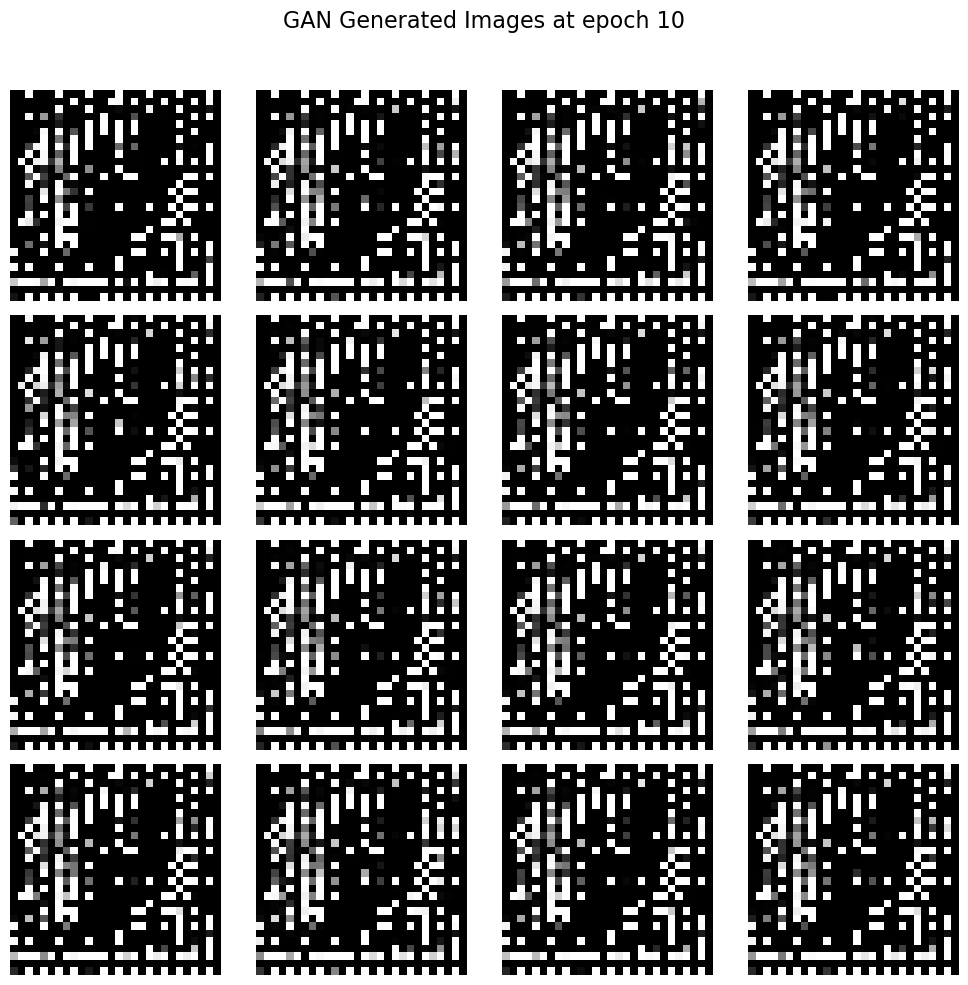

Epoch [11/200]:
epoch_d_loss: 0.007716 	epoch_g_loss: 5.571986
Epoch [12/200]:
epoch_d_loss: 0.239630 	epoch_g_loss: 4.270743
Epoch [13/200]:
epoch_d_loss: 0.553004 	epoch_g_loss: 2.670406
Epoch [14/200]:
epoch_d_loss: 0.334550 	epoch_g_loss: 3.083113
Epoch [15/200]:
epoch_d_loss: 0.483456 	epoch_g_loss: 2.979444
Epoch [16/200]:
epoch_d_loss: 1.014225 	epoch_g_loss: 2.062132
Epoch [17/200]:
epoch_d_loss: 0.378028 	epoch_g_loss: 2.750055
Epoch [18/200]:
epoch_d_loss: 0.732686 	epoch_g_loss: 2.316069
Epoch [19/200]:
epoch_d_loss: 0.365102 	epoch_g_loss: 2.842826
Epoch [20/200]:
epoch_d_loss: 0.488038 	epoch_g_loss: 2.449722


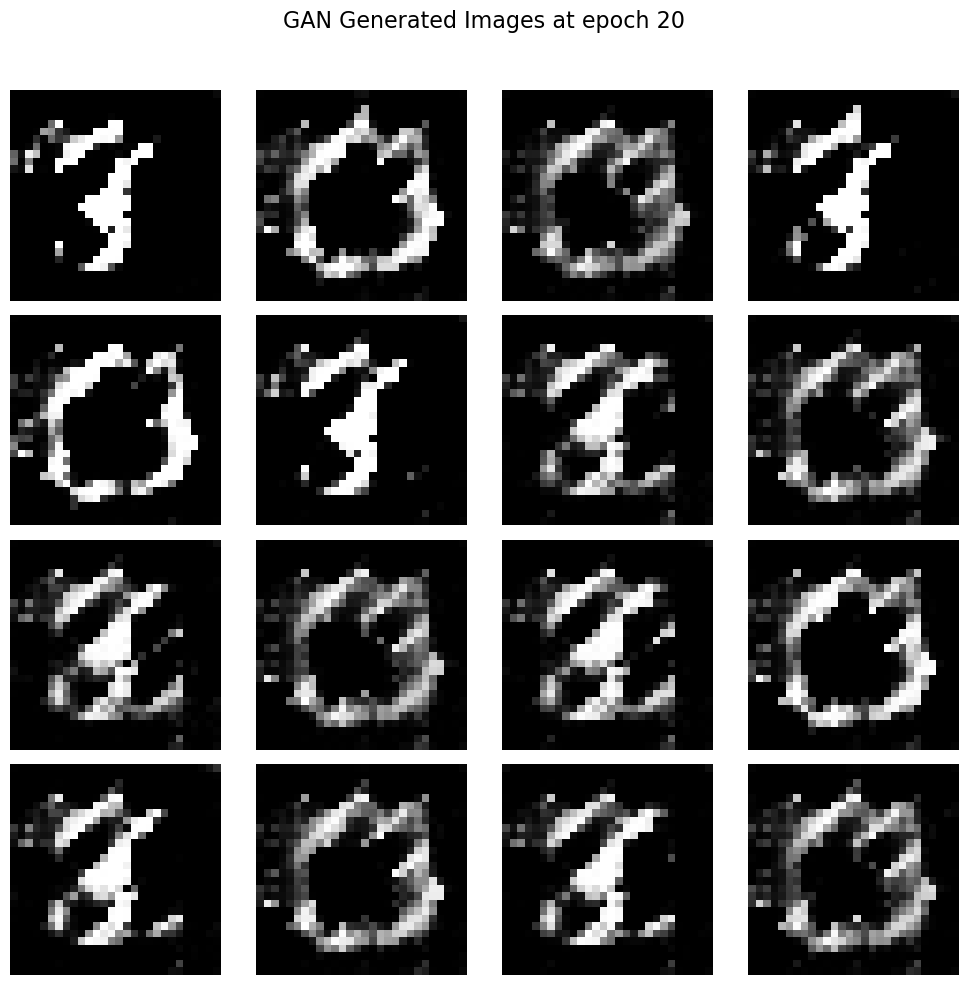

Epoch [21/200]:
epoch_d_loss: 0.835592 	epoch_g_loss: 2.168847
Epoch [22/200]:
epoch_d_loss: 0.457776 	epoch_g_loss: 2.162751
Epoch [23/200]:
epoch_d_loss: 0.506087 	epoch_g_loss: 2.508008
Epoch [24/200]:
epoch_d_loss: 0.539535 	epoch_g_loss: 2.229346
Epoch [25/200]:
epoch_d_loss: 0.464922 	epoch_g_loss: 2.596168
Epoch [26/200]:
epoch_d_loss: 0.390819 	epoch_g_loss: 2.553771
Epoch [27/200]:
epoch_d_loss: 0.430174 	epoch_g_loss: 2.466580
Epoch [28/200]:
epoch_d_loss: 0.518314 	epoch_g_loss: 2.493220
Epoch [29/200]:
epoch_d_loss: 0.373203 	epoch_g_loss: 2.598372
Epoch [30/200]:
epoch_d_loss: 0.408808 	epoch_g_loss: 2.616774


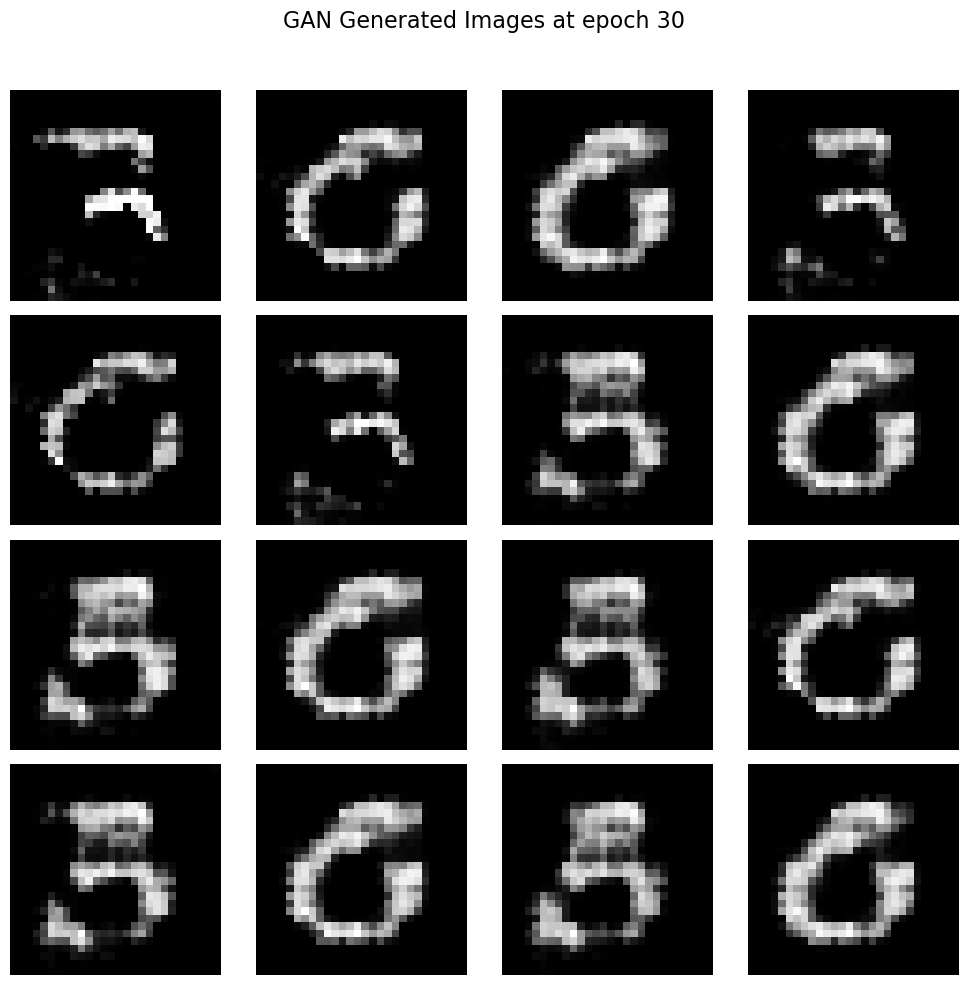

Epoch [31/200]:
epoch_d_loss: 0.757616 	epoch_g_loss: 2.265108
Epoch [32/200]:
epoch_d_loss: 0.724048 	epoch_g_loss: 2.810163
Epoch [33/200]:
epoch_d_loss: 0.577085 	epoch_g_loss: 2.091820
Epoch [34/200]:
epoch_d_loss: 0.592136 	epoch_g_loss: 2.232798
Epoch [35/200]:
epoch_d_loss: 0.683902 	epoch_g_loss: 2.210848
Epoch [36/200]:
epoch_d_loss: 0.764692 	epoch_g_loss: 2.242002
Epoch [37/200]:
epoch_d_loss: 0.815501 	epoch_g_loss: 2.183658
Epoch [38/200]:
epoch_d_loss: 0.609553 	epoch_g_loss: 1.906614
Epoch [39/200]:
epoch_d_loss: 0.953414 	epoch_g_loss: 1.959346
Epoch [40/200]:
epoch_d_loss: 0.773889 	epoch_g_loss: 2.154343


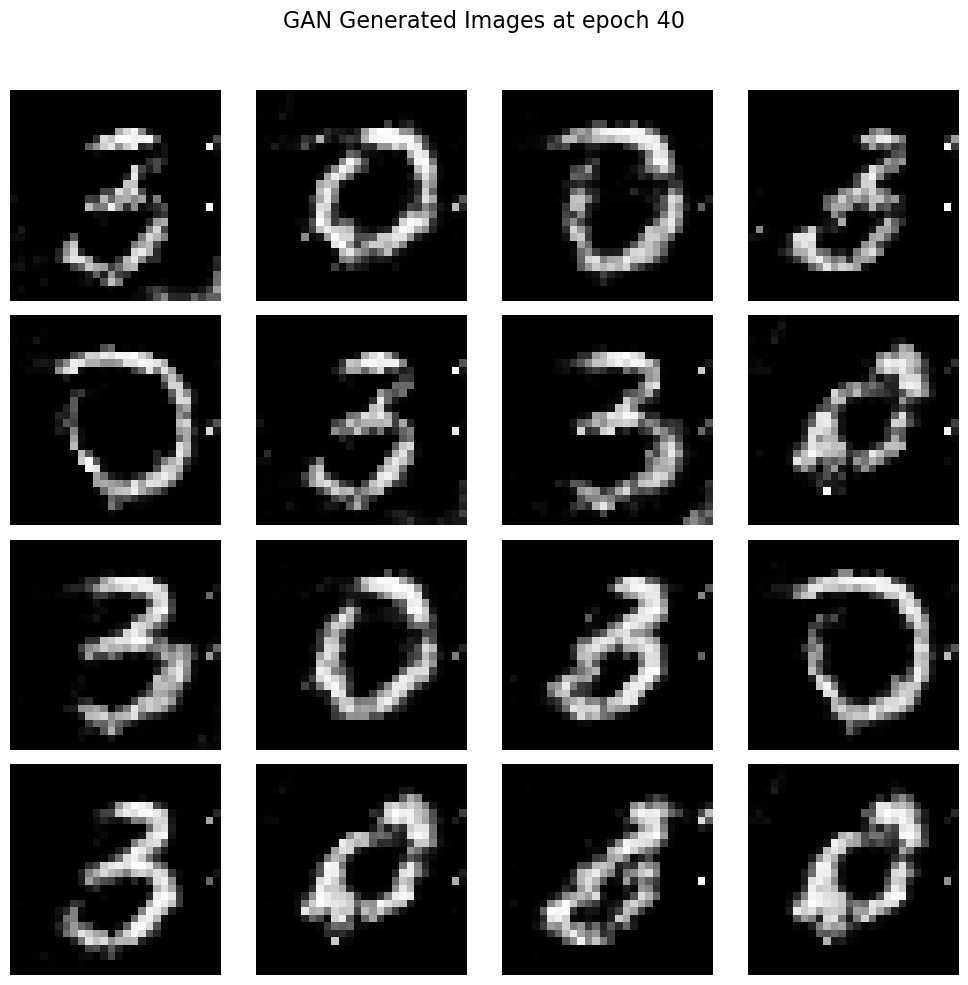

Epoch [41/200]:
epoch_d_loss: 0.896008 	epoch_g_loss: 1.761020
Epoch [42/200]:
epoch_d_loss: 0.912407 	epoch_g_loss: 1.697712
Epoch [43/200]:
epoch_d_loss: 0.916675 	epoch_g_loss: 1.693218
Epoch [44/200]:
epoch_d_loss: 0.844279 	epoch_g_loss: 1.738295
Epoch [45/200]:
epoch_d_loss: 0.920112 	epoch_g_loss: 1.699860
Epoch [46/200]:
epoch_d_loss: 1.033680 	epoch_g_loss: 1.563816
Epoch [47/200]:
epoch_d_loss: 0.976088 	epoch_g_loss: 1.595123
Epoch [48/200]:
epoch_d_loss: 0.964478 	epoch_g_loss: 1.667052
Epoch [49/200]:
epoch_d_loss: 0.880636 	epoch_g_loss: 1.469215
Epoch [50/200]:
epoch_d_loss: 0.936541 	epoch_g_loss: 1.483979


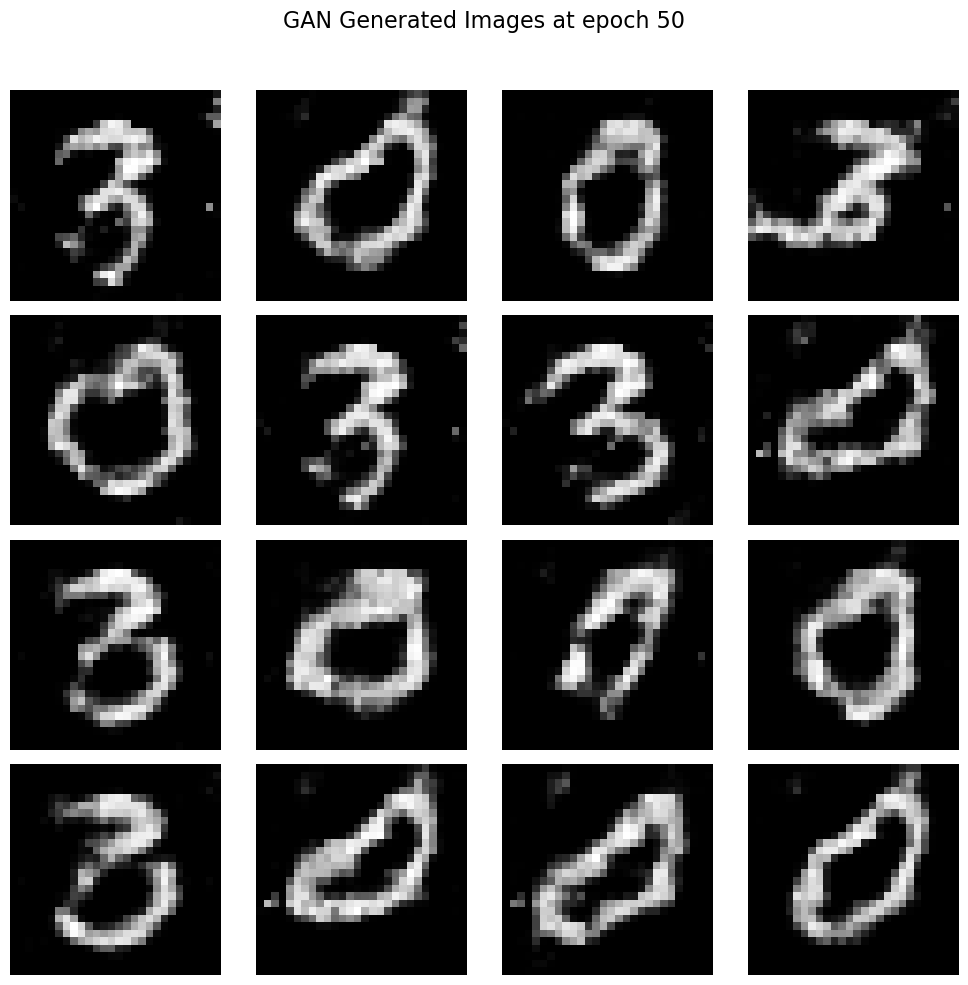

Epoch [51/200]:
epoch_d_loss: 0.965826 	epoch_g_loss: 1.652984
Epoch [52/200]:
epoch_d_loss: 1.123374 	epoch_g_loss: 1.428458
Epoch [53/200]:
epoch_d_loss: 1.096045 	epoch_g_loss: 1.442915
Epoch [54/200]:
epoch_d_loss: 1.096059 	epoch_g_loss: 1.453834
Epoch [55/200]:
epoch_d_loss: 1.047105 	epoch_g_loss: 1.370353
Epoch [56/200]:
epoch_d_loss: 1.153282 	epoch_g_loss: 1.232961
Epoch [57/200]:
epoch_d_loss: 1.151512 	epoch_g_loss: 1.331622
Epoch [58/200]:
epoch_d_loss: 1.132930 	epoch_g_loss: 1.246790
Epoch [59/200]:
epoch_d_loss: 1.168505 	epoch_g_loss: 1.265139
Epoch [60/200]:
epoch_d_loss: 1.165308 	epoch_g_loss: 1.179291


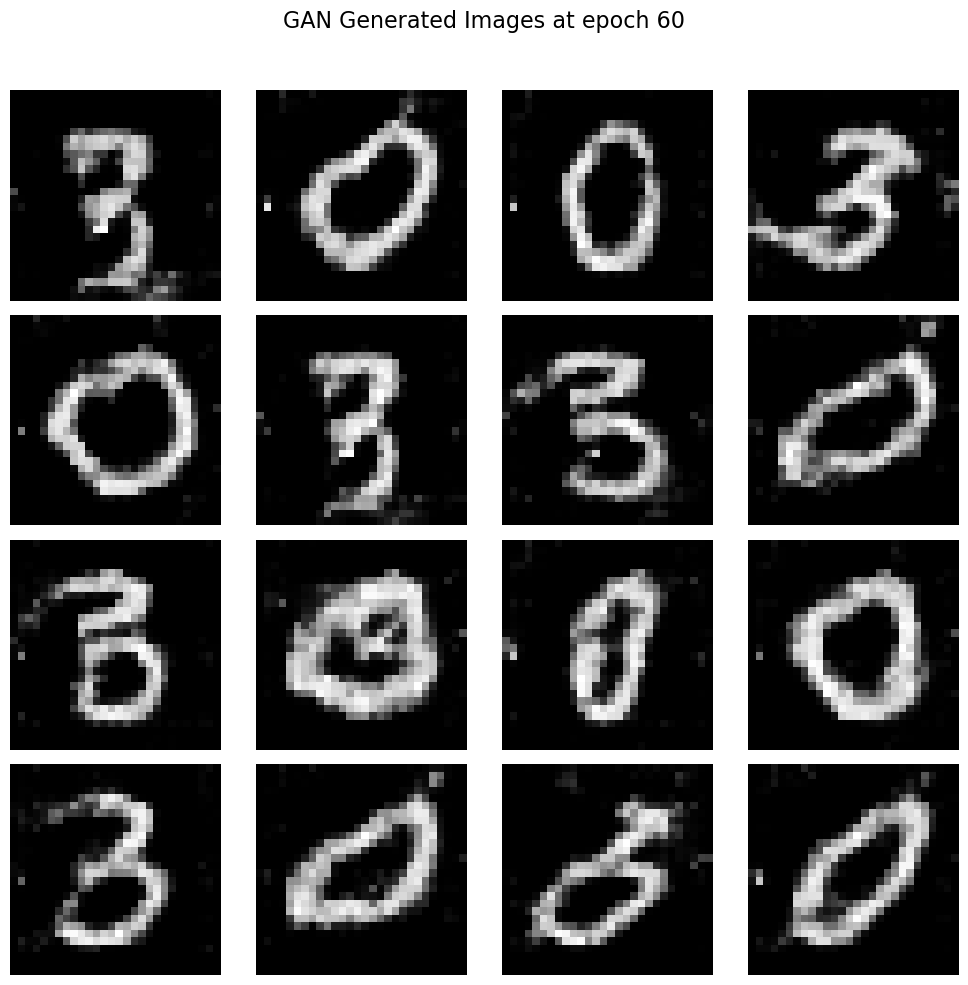

Epoch [61/200]:
epoch_d_loss: 1.167435 	epoch_g_loss: 1.205308
Epoch [62/200]:
epoch_d_loss: 1.137645 	epoch_g_loss: 1.147462
Epoch [63/200]:
epoch_d_loss: 1.163250 	epoch_g_loss: 1.187380
Epoch [64/200]:
epoch_d_loss: 1.160713 	epoch_g_loss: 1.146172
Epoch [65/200]:
epoch_d_loss: 1.164872 	epoch_g_loss: 1.157724
Epoch [66/200]:
epoch_d_loss: 1.152553 	epoch_g_loss: 1.131049
Epoch [67/200]:
epoch_d_loss: 1.164199 	epoch_g_loss: 1.129349
Epoch [68/200]:
epoch_d_loss: 1.174397 	epoch_g_loss: 1.098034
Epoch [69/200]:
epoch_d_loss: 1.163216 	epoch_g_loss: 1.123213
Epoch [70/200]:
epoch_d_loss: 1.175541 	epoch_g_loss: 1.101137


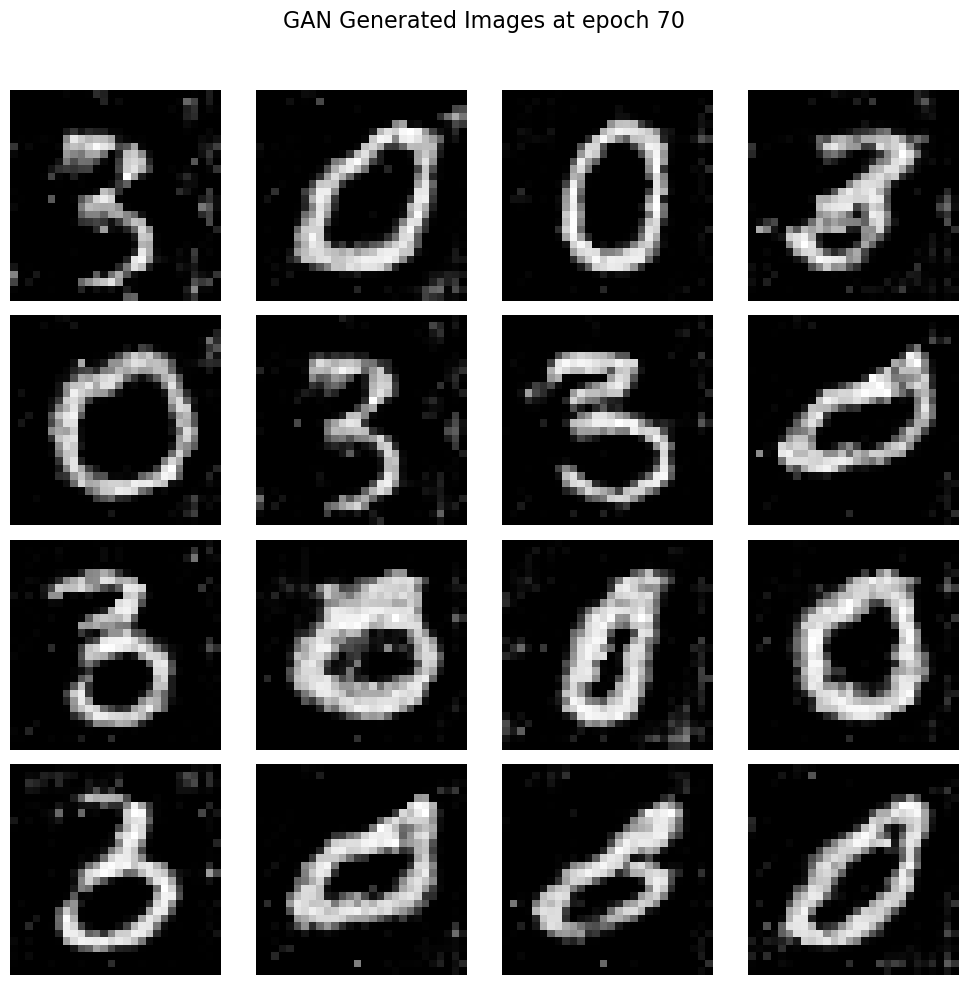

Epoch [71/200]:
epoch_d_loss: 1.176897 	epoch_g_loss: 1.084064
Epoch [72/200]:
epoch_d_loss: 1.184701 	epoch_g_loss: 1.095321
Epoch [73/200]:
epoch_d_loss: 1.165809 	epoch_g_loss: 1.090197
Epoch [74/200]:
epoch_d_loss: 1.176678 	epoch_g_loss: 1.089919
Epoch [75/200]:
epoch_d_loss: 1.176481 	epoch_g_loss: 1.073880
Epoch [76/200]:
epoch_d_loss: 1.179812 	epoch_g_loss: 1.088771
Epoch [77/200]:
epoch_d_loss: 1.173720 	epoch_g_loss: 1.071632
Epoch [78/200]:
epoch_d_loss: 1.175176 	epoch_g_loss: 1.074753
Epoch [79/200]:
epoch_d_loss: 1.178798 	epoch_g_loss: 1.069709
Epoch [80/200]:
epoch_d_loss: 1.191835 	epoch_g_loss: 1.057393


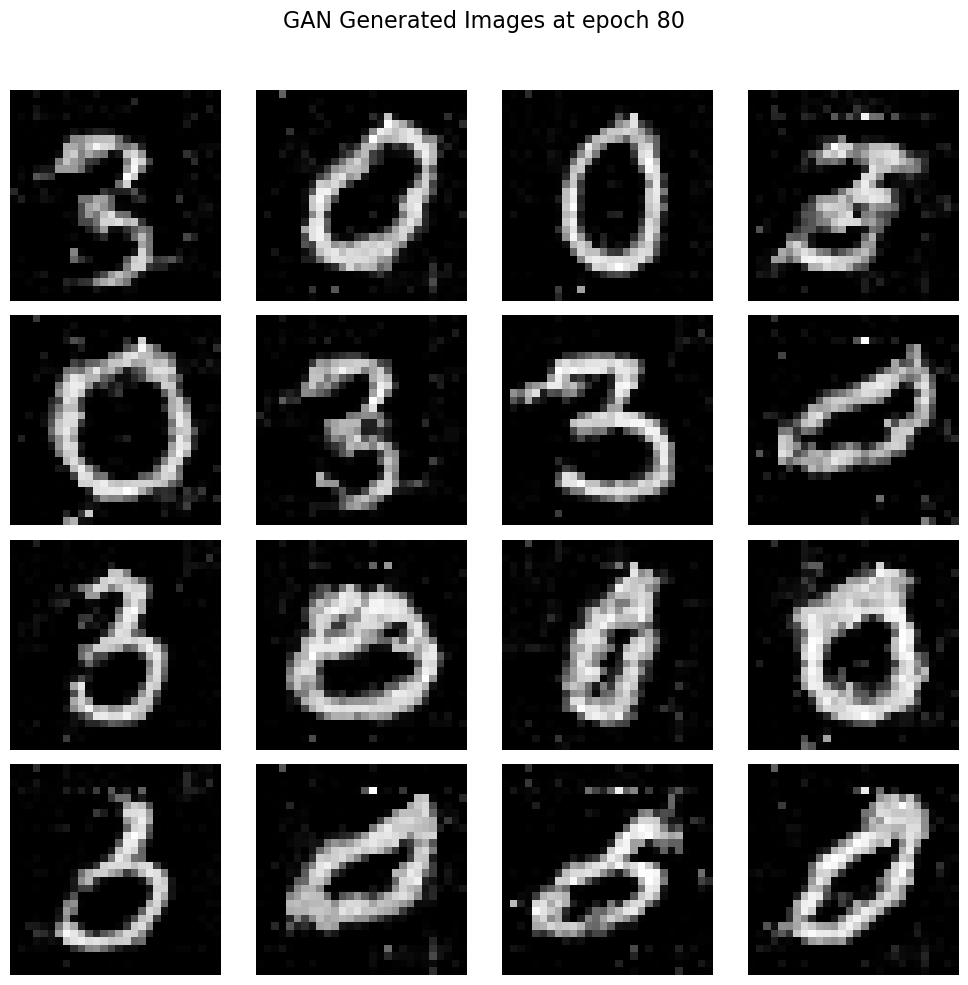

Epoch [81/200]:
epoch_d_loss: 1.184700 	epoch_g_loss: 1.042209
Epoch [82/200]:
epoch_d_loss: 1.184044 	epoch_g_loss: 1.067093
Epoch [83/200]:
epoch_d_loss: 1.198956 	epoch_g_loss: 1.048725
Epoch [84/200]:
epoch_d_loss: 1.198082 	epoch_g_loss: 1.045630
Epoch [85/200]:
epoch_d_loss: 1.206438 	epoch_g_loss: 1.022709
Epoch [86/200]:
epoch_d_loss: 1.183302 	epoch_g_loss: 1.049048
Epoch [87/200]:
epoch_d_loss: 1.202399 	epoch_g_loss: 1.029568
Epoch [88/200]:
epoch_d_loss: 1.179802 	epoch_g_loss: 1.049566
Epoch [89/200]:
epoch_d_loss: 1.209437 	epoch_g_loss: 1.010827
Epoch [90/200]:
epoch_d_loss: 1.167961 	epoch_g_loss: 1.050491


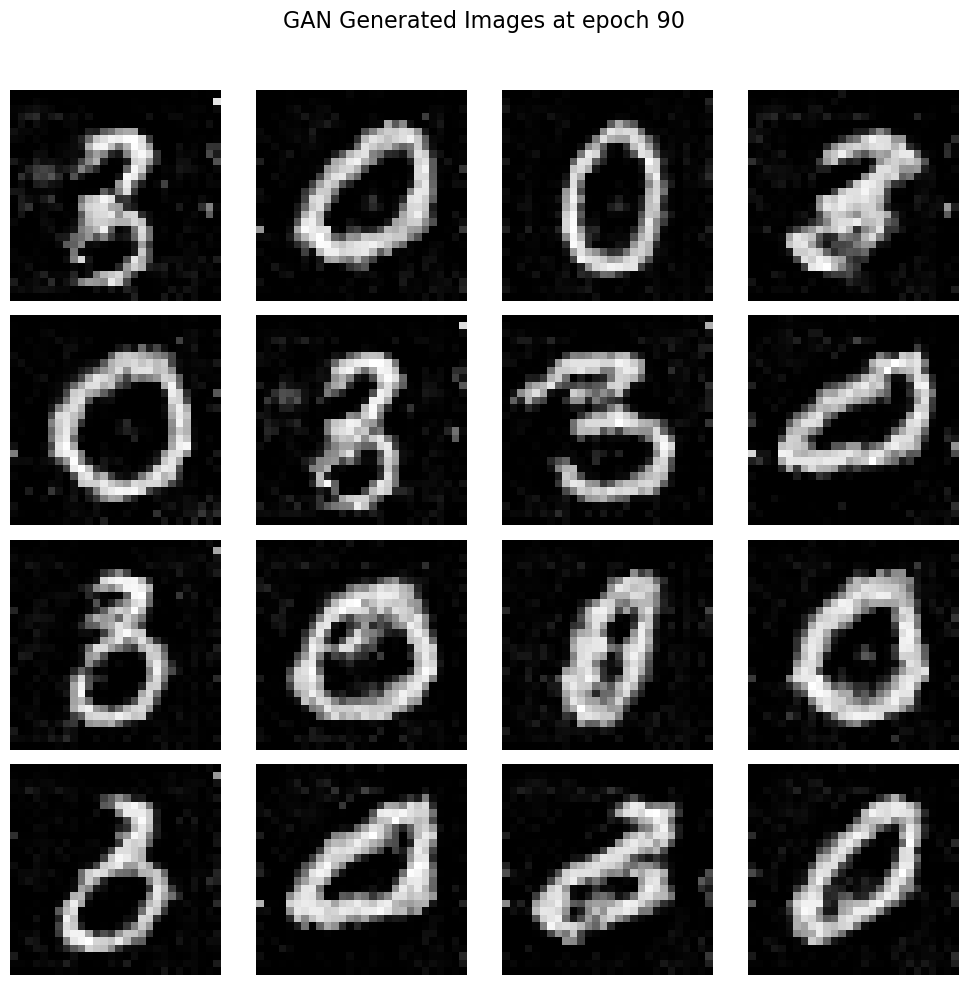

Epoch [91/200]:
epoch_d_loss: 1.201821 	epoch_g_loss: 1.019433
Epoch [92/200]:
epoch_d_loss: 1.198539 	epoch_g_loss: 1.009851
Epoch [93/200]:
epoch_d_loss: 1.191181 	epoch_g_loss: 1.034492
Epoch [94/200]:
epoch_d_loss: 1.190713 	epoch_g_loss: 1.023074
Epoch [95/200]:
epoch_d_loss: 1.196582 	epoch_g_loss: 1.014396
Epoch [96/200]:
epoch_d_loss: 1.200086 	epoch_g_loss: 1.005310
Epoch [97/200]:
epoch_d_loss: 1.189682 	epoch_g_loss: 1.016621
Epoch [98/200]:
epoch_d_loss: 1.198410 	epoch_g_loss: 1.000154
Epoch [99/200]:
epoch_d_loss: 1.180990 	epoch_g_loss: 1.010312
Epoch [100/200]:
epoch_d_loss: 1.204596 	epoch_g_loss: 0.991013


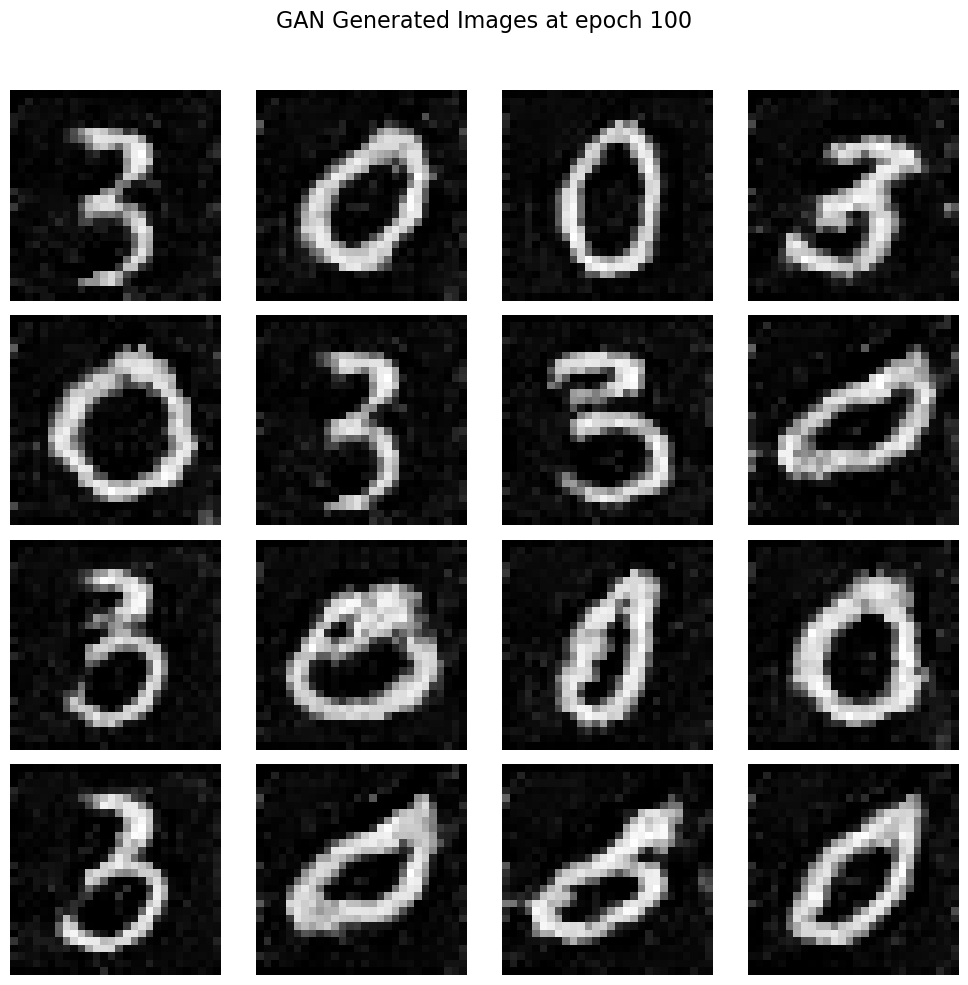

Epoch [101/200]:
epoch_d_loss: 1.198088 	epoch_g_loss: 0.995135
Epoch [102/200]:
epoch_d_loss: 1.193342 	epoch_g_loss: 0.995923
Epoch [103/200]:
epoch_d_loss: 1.191864 	epoch_g_loss: 0.997184
Epoch [104/200]:
epoch_d_loss: 1.193008 	epoch_g_loss: 1.000392
Epoch [105/200]:
epoch_d_loss: 1.182748 	epoch_g_loss: 0.998540
Epoch [106/200]:
epoch_d_loss: 1.192354 	epoch_g_loss: 0.994810
Epoch [107/200]:
epoch_d_loss: 1.190303 	epoch_g_loss: 0.986803
Epoch [108/200]:
epoch_d_loss: 1.192632 	epoch_g_loss: 0.991987
Epoch [109/200]:
epoch_d_loss: 1.195553 	epoch_g_loss: 0.982363
Epoch [110/200]:
epoch_d_loss: 1.196505 	epoch_g_loss: 0.985548


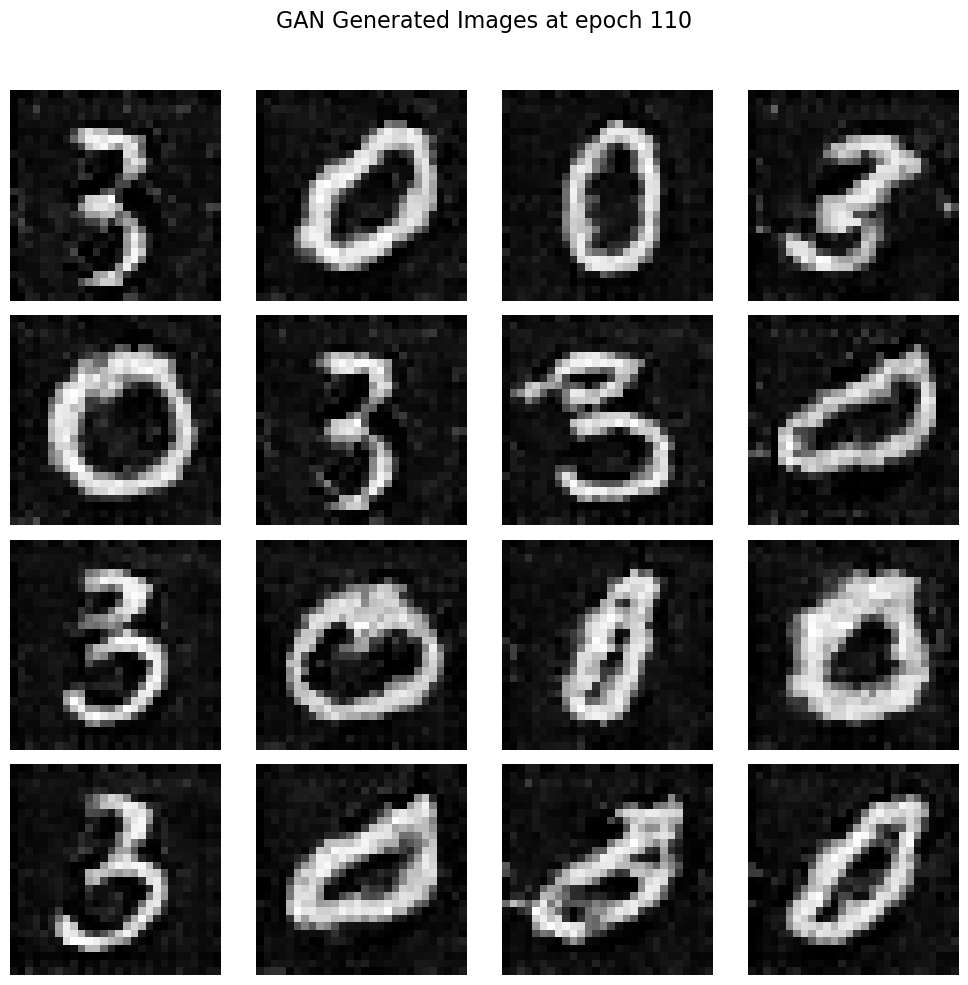

Epoch [111/200]:
epoch_d_loss: 1.195635 	epoch_g_loss: 0.976320
Epoch [112/200]:
epoch_d_loss: 1.193143 	epoch_g_loss: 0.980055
Epoch [113/200]:
epoch_d_loss: 1.190154 	epoch_g_loss: 0.980684
Epoch [114/200]:
epoch_d_loss: 1.191593 	epoch_g_loss: 0.974672
Epoch [115/200]:
epoch_d_loss: 1.187697 	epoch_g_loss: 0.971256
Epoch [116/200]:
epoch_d_loss: 1.183304 	epoch_g_loss: 0.987054
Epoch [117/200]:
epoch_d_loss: 1.189880 	epoch_g_loss: 0.970096
Epoch [118/200]:
epoch_d_loss: 1.184605 	epoch_g_loss: 0.983770
Epoch [119/200]:
epoch_d_loss: 1.182649 	epoch_g_loss: 0.973879
Epoch [120/200]:
epoch_d_loss: 1.186931 	epoch_g_loss: 0.971889


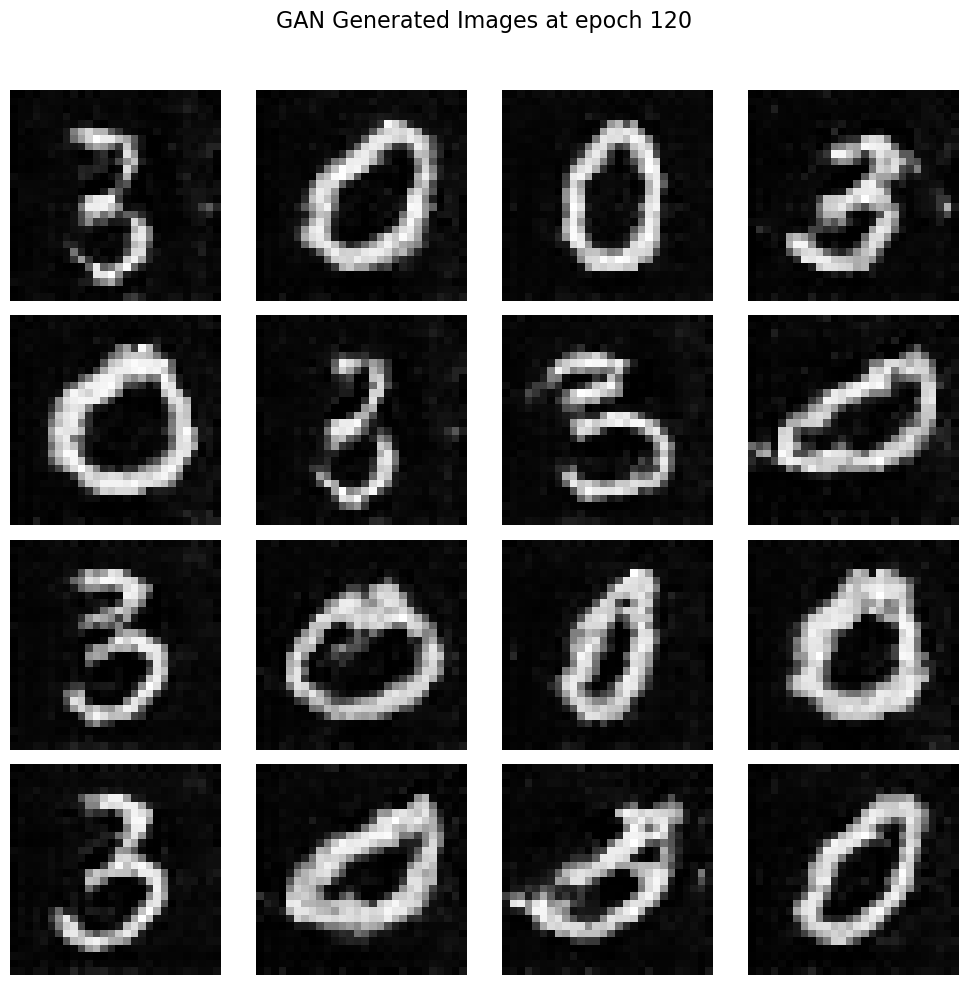

Epoch [121/200]:
epoch_d_loss: 1.183389 	epoch_g_loss: 0.981762
Epoch [122/200]:
epoch_d_loss: 1.184772 	epoch_g_loss: 0.965386
Epoch [123/200]:
epoch_d_loss: 1.167315 	epoch_g_loss: 0.989604
Epoch [124/200]:
epoch_d_loss: 1.184998 	epoch_g_loss: 0.978808
Epoch [125/200]:
epoch_d_loss: 1.170515 	epoch_g_loss: 0.983605
Epoch [126/200]:
epoch_d_loss: 1.184957 	epoch_g_loss: 0.976373
Epoch [127/200]:
epoch_d_loss: 1.184798 	epoch_g_loss: 0.978716
Epoch [128/200]:
epoch_d_loss: 1.178250 	epoch_g_loss: 0.973644
Epoch [129/200]:
epoch_d_loss: 1.184879 	epoch_g_loss: 0.969786
Epoch [130/200]:
epoch_d_loss: 1.182798 	epoch_g_loss: 0.977840


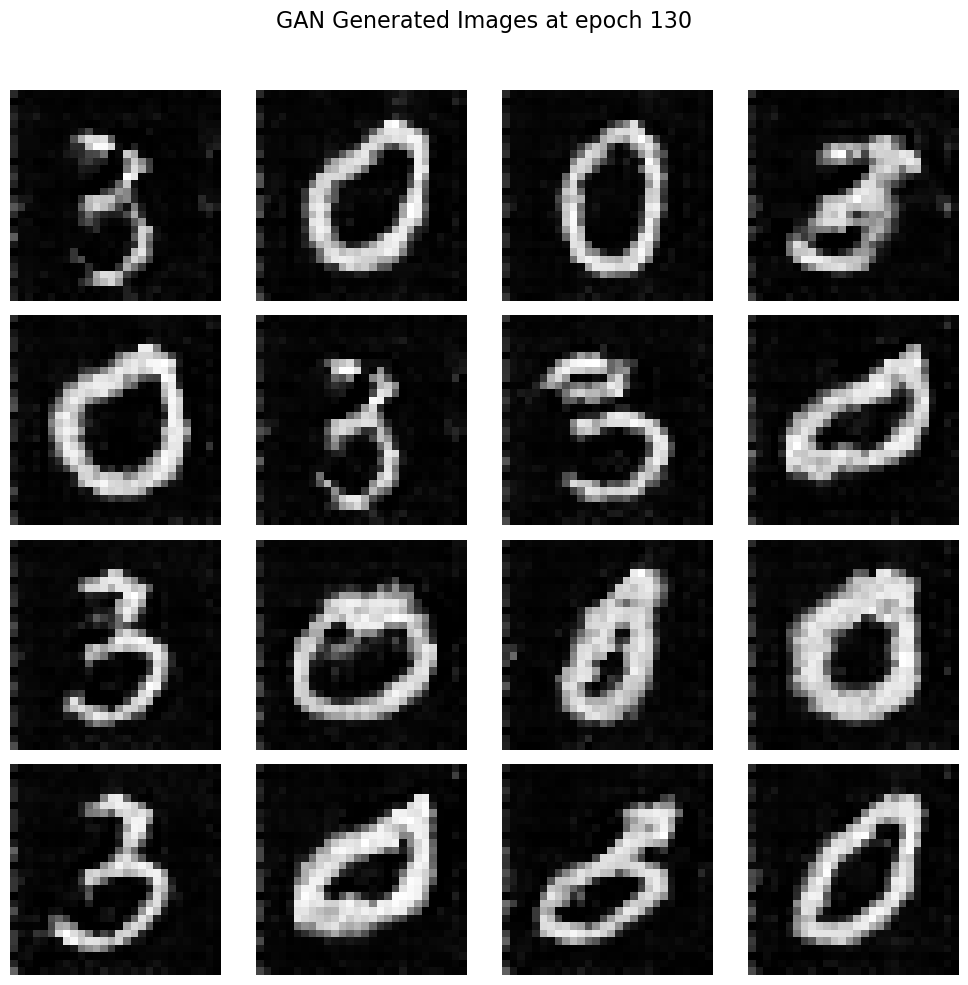

Epoch [131/200]:
epoch_d_loss: 1.181018 	epoch_g_loss: 0.973928
Epoch [132/200]:
epoch_d_loss: 1.175874 	epoch_g_loss: 0.978135
Epoch [133/200]:
epoch_d_loss: 1.185789 	epoch_g_loss: 0.969252
Epoch [134/200]:
epoch_d_loss: 1.177818 	epoch_g_loss: 0.972093
Epoch [135/200]:
epoch_d_loss: 1.181836 	epoch_g_loss: 0.971064
Epoch [136/200]:
epoch_d_loss: 1.186421 	epoch_g_loss: 0.960550
Epoch [137/200]:
epoch_d_loss: 1.177790 	epoch_g_loss: 0.966893
Epoch [138/200]:
epoch_d_loss: 1.179149 	epoch_g_loss: 0.965205
Epoch [139/200]:
epoch_d_loss: 1.176561 	epoch_g_loss: 0.971243
Epoch [140/200]:
epoch_d_loss: 1.180737 	epoch_g_loss: 0.972378


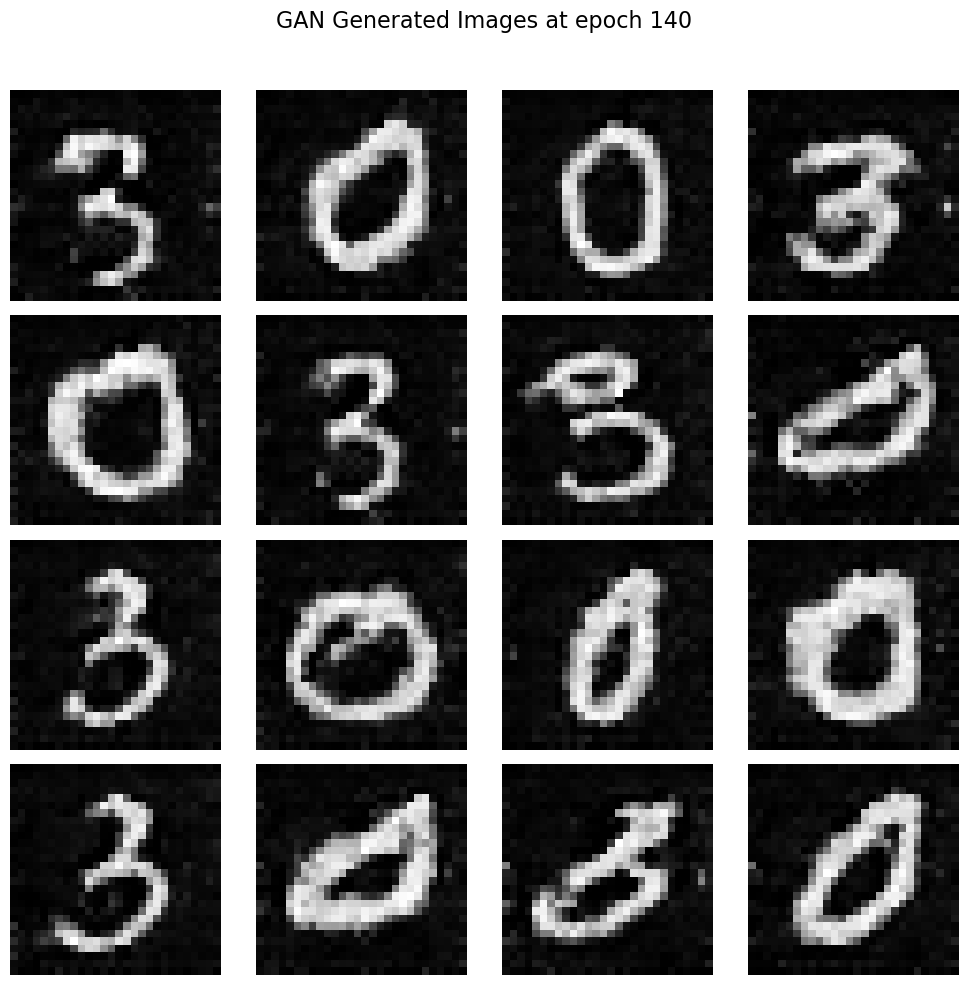

Epoch [141/200]:
epoch_d_loss: 1.181374 	epoch_g_loss: 0.964568
Epoch [142/200]:
epoch_d_loss: 1.178882 	epoch_g_loss: 0.969174
Epoch [143/200]:
epoch_d_loss: 1.175988 	epoch_g_loss: 0.974507
Epoch [144/200]:
epoch_d_loss: 1.182504 	epoch_g_loss: 0.960483
Epoch [145/200]:
epoch_d_loss: 1.176760 	epoch_g_loss: 0.963962
Epoch [146/200]:
epoch_d_loss: 1.175519 	epoch_g_loss: 0.970588
Epoch [147/200]:
epoch_d_loss: 1.180582 	epoch_g_loss: 0.967753
Epoch [148/200]:
epoch_d_loss: 1.174489 	epoch_g_loss: 0.967922
Epoch [149/200]:
epoch_d_loss: 1.181537 	epoch_g_loss: 0.963378
Epoch [150/200]:
epoch_d_loss: 1.170551 	epoch_g_loss: 0.964688


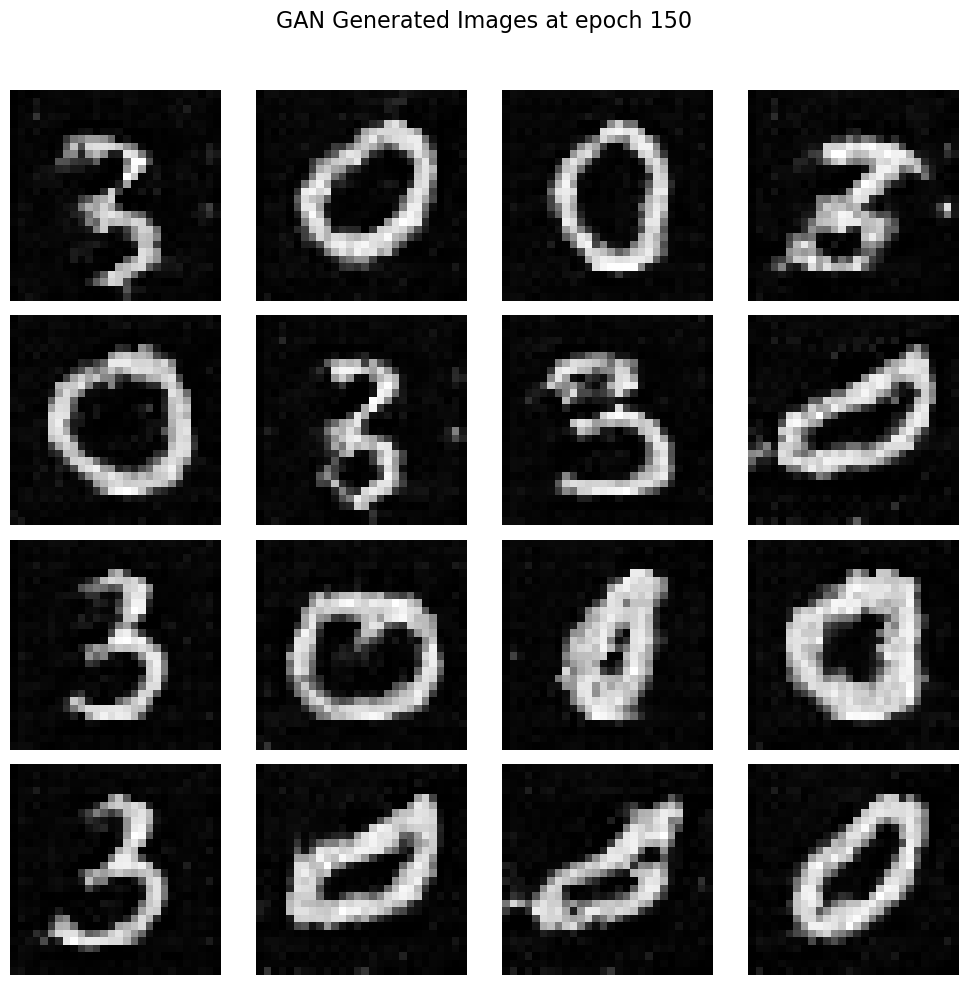

Epoch [151/200]:
epoch_d_loss: 1.176655 	epoch_g_loss: 0.969909
Epoch [152/200]:
epoch_d_loss: 1.177878 	epoch_g_loss: 0.960246
Epoch [153/200]:
epoch_d_loss: 1.179246 	epoch_g_loss: 0.960619
Epoch [154/200]:
epoch_d_loss: 1.176457 	epoch_g_loss: 0.961418
Epoch [155/200]:
epoch_d_loss: 1.173647 	epoch_g_loss: 0.966240
Epoch [156/200]:
epoch_d_loss: 1.169104 	epoch_g_loss: 0.965919
Epoch [157/200]:
epoch_d_loss: 1.174344 	epoch_g_loss: 0.974194
Epoch [158/200]:
epoch_d_loss: 1.168671 	epoch_g_loss: 0.977383
Epoch [159/200]:
epoch_d_loss: 1.168740 	epoch_g_loss: 0.976012
Epoch [160/200]:
epoch_d_loss: 1.180403 	epoch_g_loss: 0.972799


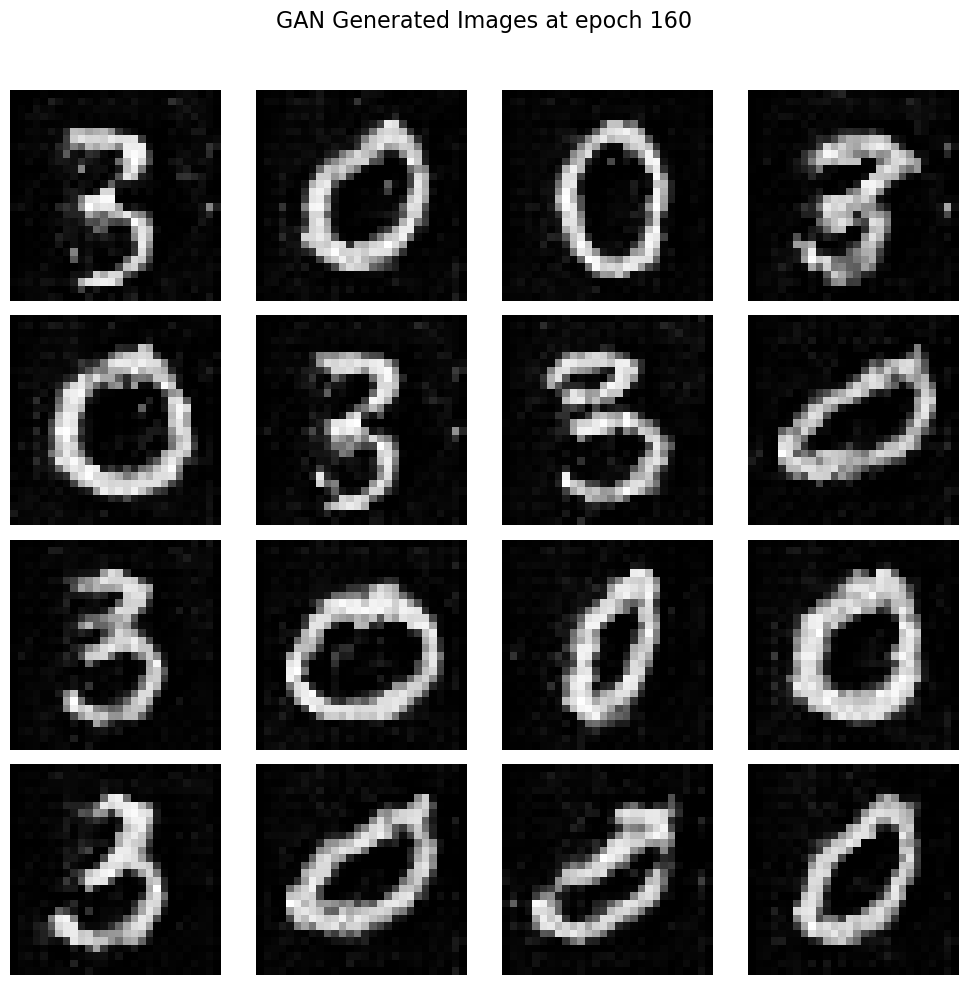

Epoch [161/200]:
epoch_d_loss: 1.168069 	epoch_g_loss: 0.971946
Epoch [162/200]:
epoch_d_loss: 1.175541 	epoch_g_loss: 0.973977
Epoch [163/200]:
epoch_d_loss: 1.181776 	epoch_g_loss: 0.961654
Epoch [164/200]:
epoch_d_loss: 1.173452 	epoch_g_loss: 0.968544
Epoch [165/200]:
epoch_d_loss: 1.177455 	epoch_g_loss: 0.965822
Epoch [166/200]:
epoch_d_loss: 1.174508 	epoch_g_loss: 0.958916
Epoch [167/200]:
epoch_d_loss: 1.176434 	epoch_g_loss: 0.958679
Epoch [168/200]:
epoch_d_loss: 1.171804 	epoch_g_loss: 0.961271
Epoch [169/200]:
epoch_d_loss: 1.178167 	epoch_g_loss: 0.962279
Epoch [170/200]:
epoch_d_loss: 1.171506 	epoch_g_loss: 0.965851


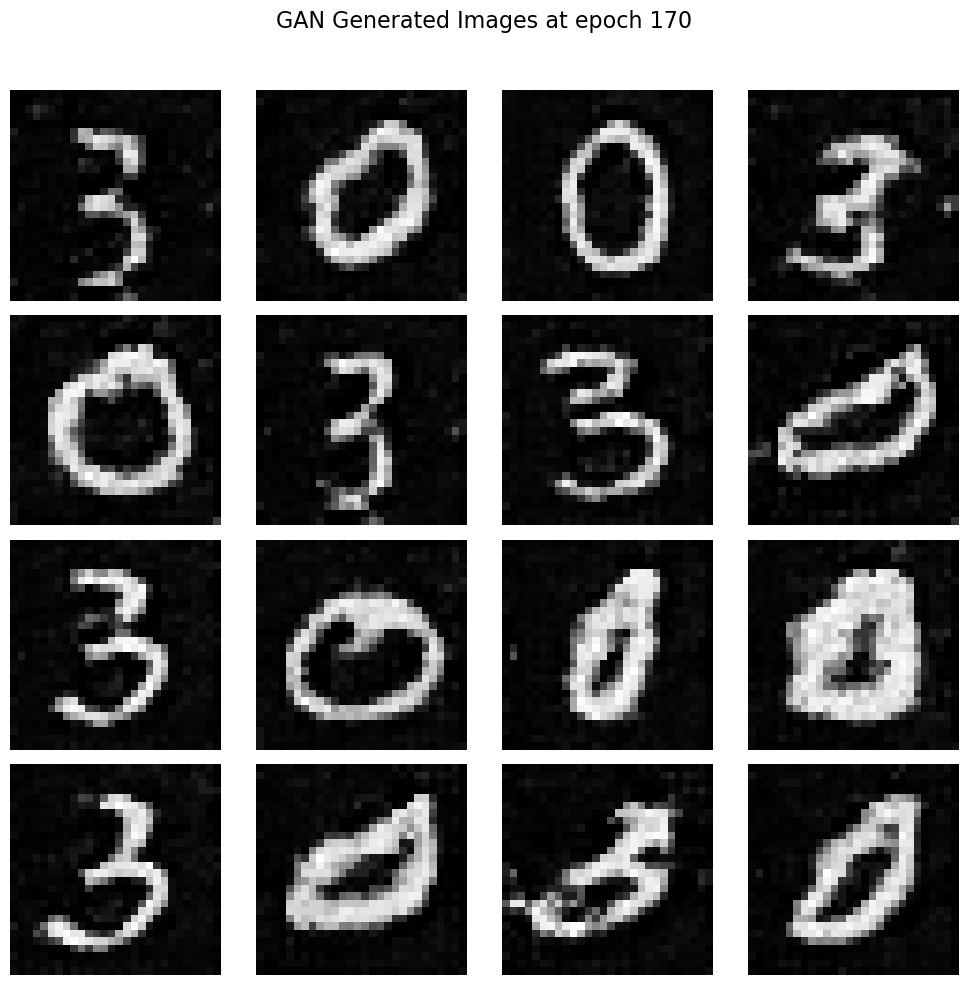

Epoch [171/200]:
epoch_d_loss: 1.179738 	epoch_g_loss: 0.957260
Epoch [172/200]:
epoch_d_loss: 1.176137 	epoch_g_loss: 0.958452
Epoch [173/200]:
epoch_d_loss: 1.174669 	epoch_g_loss: 0.956370
Epoch [174/200]:
epoch_d_loss: 1.176168 	epoch_g_loss: 0.957486
Epoch [175/200]:
epoch_d_loss: 1.174198 	epoch_g_loss: 0.957546
Epoch [176/200]:
epoch_d_loss: 1.176251 	epoch_g_loss: 0.951325
Epoch [177/200]:
epoch_d_loss: 1.179912 	epoch_g_loss: 0.955848
Epoch [178/200]:
epoch_d_loss: 1.171673 	epoch_g_loss: 0.950056
Epoch [179/200]:
epoch_d_loss: 1.174683 	epoch_g_loss: 0.954698
Epoch [180/200]:
epoch_d_loss: 1.178758 	epoch_g_loss: 0.949764


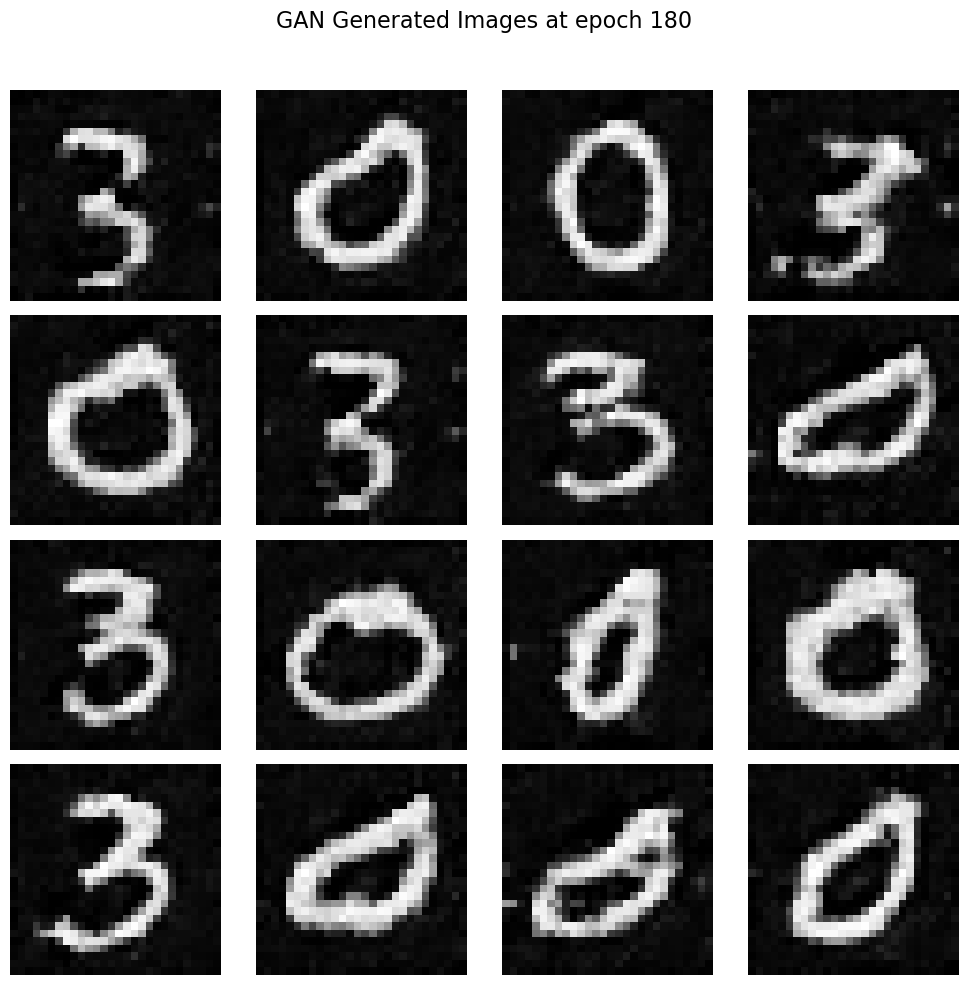

Epoch [181/200]:
epoch_d_loss: 1.171634 	epoch_g_loss: 0.953919
Epoch [182/200]:
epoch_d_loss: 1.180154 	epoch_g_loss: 0.950959
Epoch [183/200]:
epoch_d_loss: 1.177665 	epoch_g_loss: 0.952603
Epoch [184/200]:
epoch_d_loss: 1.176747 	epoch_g_loss: 0.950797
Epoch [185/200]:
epoch_d_loss: 1.178139 	epoch_g_loss: 0.951738
Epoch [186/200]:
epoch_d_loss: 1.176834 	epoch_g_loss: 0.950626
Epoch [187/200]:
epoch_d_loss: 1.175491 	epoch_g_loss: 0.953584
Epoch [188/200]:
epoch_d_loss: 1.176360 	epoch_g_loss: 0.949818
Epoch [189/200]:
epoch_d_loss: 1.176326 	epoch_g_loss: 0.950138
Epoch [190/200]:
epoch_d_loss: 1.175541 	epoch_g_loss: 0.945335


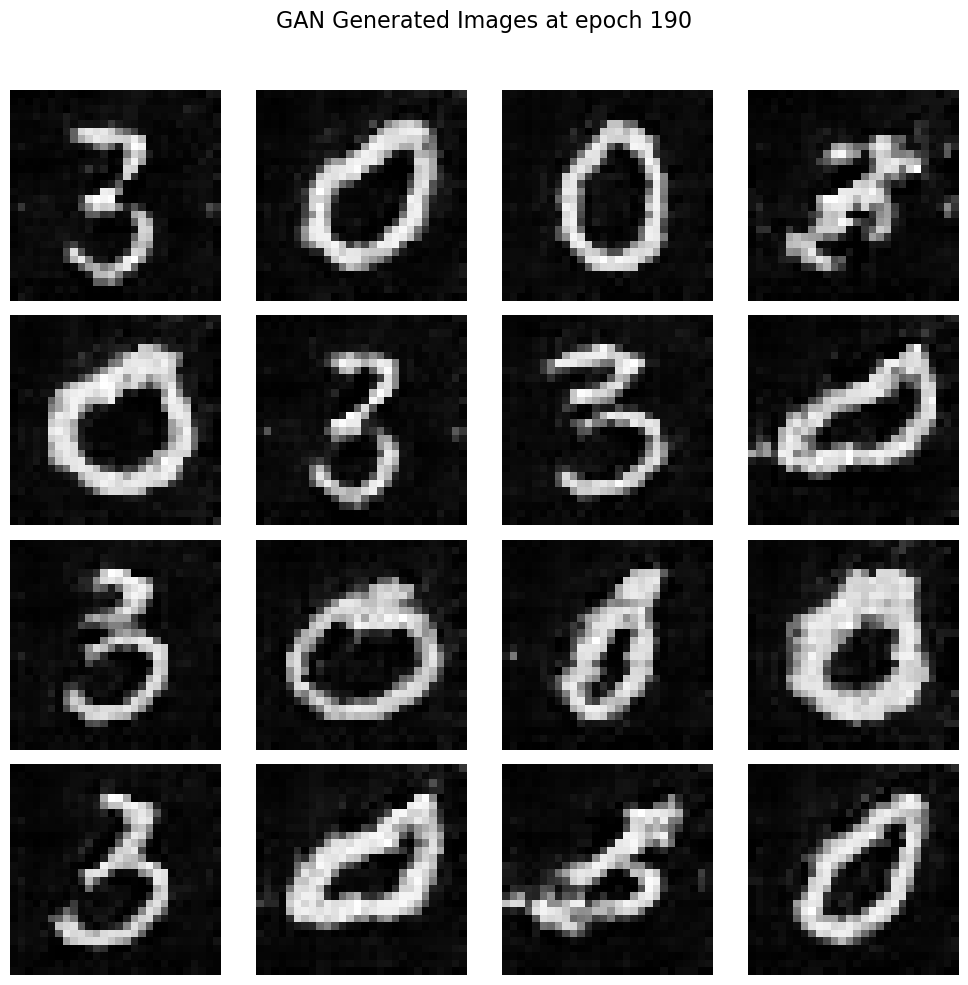

Epoch [191/200]:
epoch_d_loss: 1.175292 	epoch_g_loss: 0.950572
Epoch [192/200]:
epoch_d_loss: 1.173683 	epoch_g_loss: 0.949910
Epoch [193/200]:
epoch_d_loss: 1.176152 	epoch_g_loss: 0.951701
Epoch [194/200]:
epoch_d_loss: 1.174776 	epoch_g_loss: 0.945380
Epoch [195/200]:
epoch_d_loss: 1.174959 	epoch_g_loss: 0.946907
Epoch [196/200]:
epoch_d_loss: 1.171120 	epoch_g_loss: 0.962457
Epoch [197/200]:
epoch_d_loss: 1.173986 	epoch_g_loss: 0.946074
Epoch [198/200]:
epoch_d_loss: 1.175455 	epoch_g_loss: 0.946678
Epoch [199/200]:
epoch_d_loss: 1.167973 	epoch_g_loss: 0.950038
Epoch [200/200]:
epoch_d_loss: 1.165799 	epoch_g_loss: 0.961943


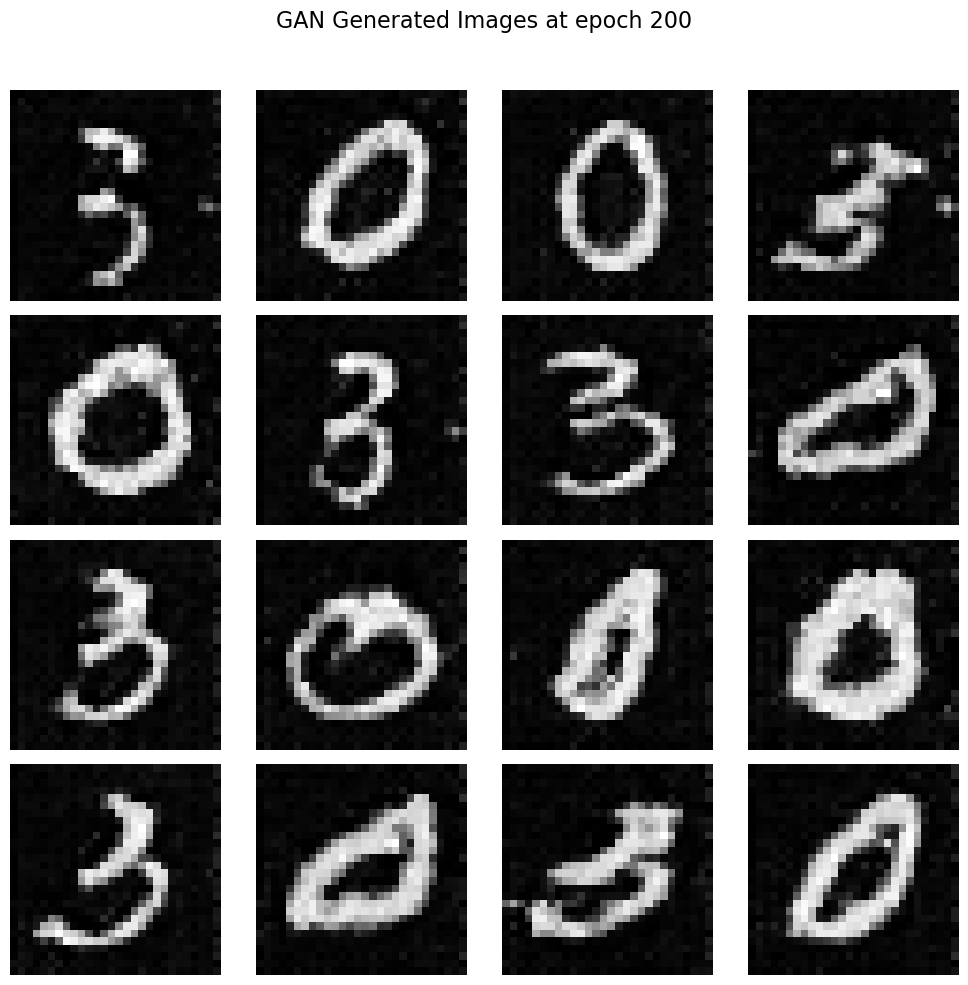

Time to train the generator on task  2   1793.433572769165
Time to generate the data 2750.9765622615814


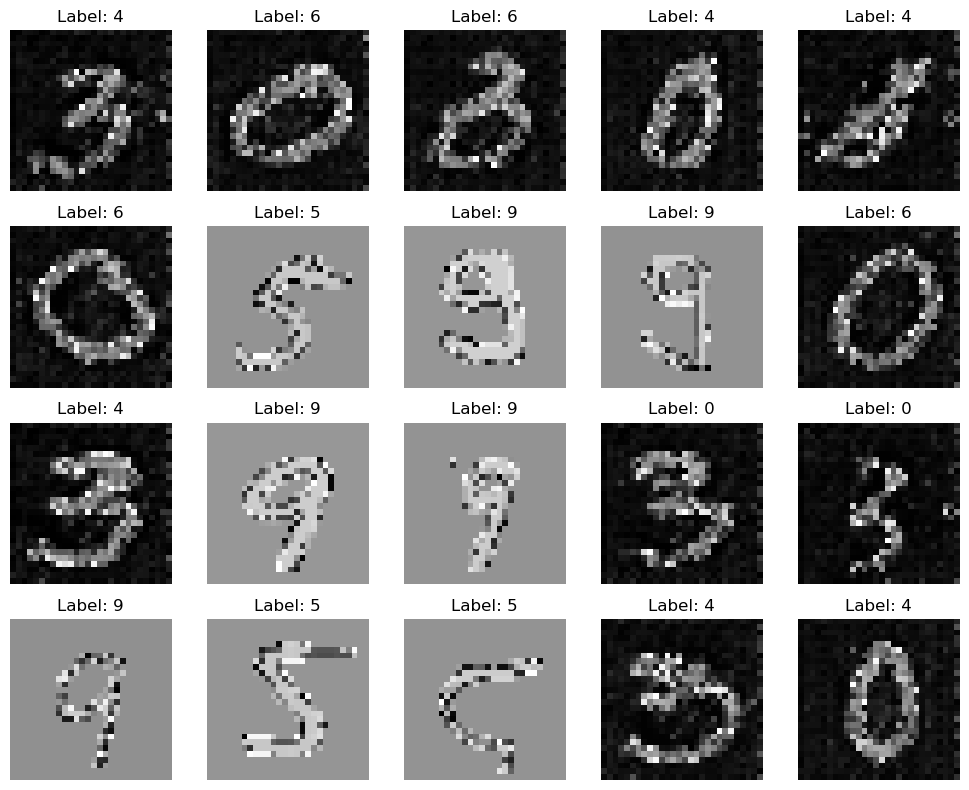

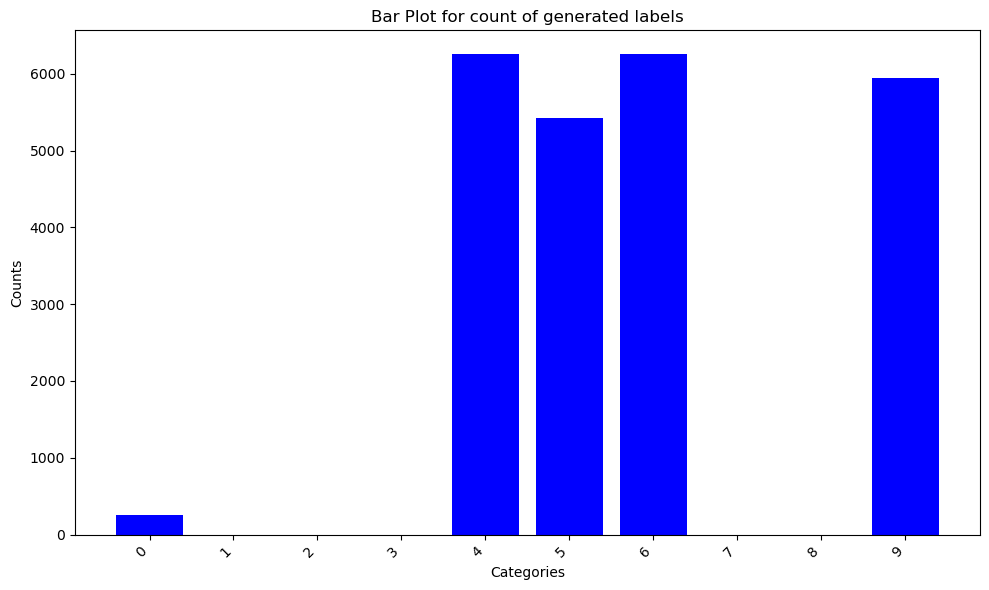

Epoch 0: Loss 2.324 Acc: 0.193
Epoch 1: Loss 1.921 Acc: 0.355
Epoch 2: Loss 1.679 Acc: 0.381
Epoch 3: Loss 1.513 Acc: 0.392
Epoch 4: Loss 1.401 Acc: 0.404
Epoch 5: Loss 1.290 Acc: 0.447
Epoch 6: Loss 1.144 Acc: 0.515
Epoch 7: Loss 0.994 Acc: 0.563
Epoch 8: Loss 0.892 Acc: 0.586
Epoch 9: Loss 0.780 Acc: 0.605
Epoch 10: Loss 0.693 Acc: 0.609
Epoch 11: Loss 0.645 Acc: 0.612
Epoch 12: Loss 0.606 Acc: 0.636
Epoch 13: Loss 0.578 Acc: 0.680
Epoch 14: Loss 0.546 Acc: 0.755
Epoch 15: Loss 0.538 Acc: 0.739
Epoch 16: Loss 0.565 Acc: 0.678
Epoch 17: Loss 0.525 Acc: 0.751
Epoch 18: Loss 0.480 Acc: 0.844
Epoch 19: Loss 0.464 Acc: 0.892
Time to train the solver on task  3   103.37588834762573
[6, 4, 0, 3, 8, 1, 9, 5]
Training on [cuda]...
Epoch [1/200]:
epoch_d_loss: 0.604098 	epoch_g_loss: 1.731594
Epoch [2/200]:
epoch_d_loss: 0.532446 	epoch_g_loss: 1.711700
Epoch [3/200]:
epoch_d_loss: 0.822332 	epoch_g_loss: 1.503907
Epoch [4/200]:
epoch_d_loss: 0.445049 	epoch_g_loss: 2.141423
Epoch [5/200]:
epo

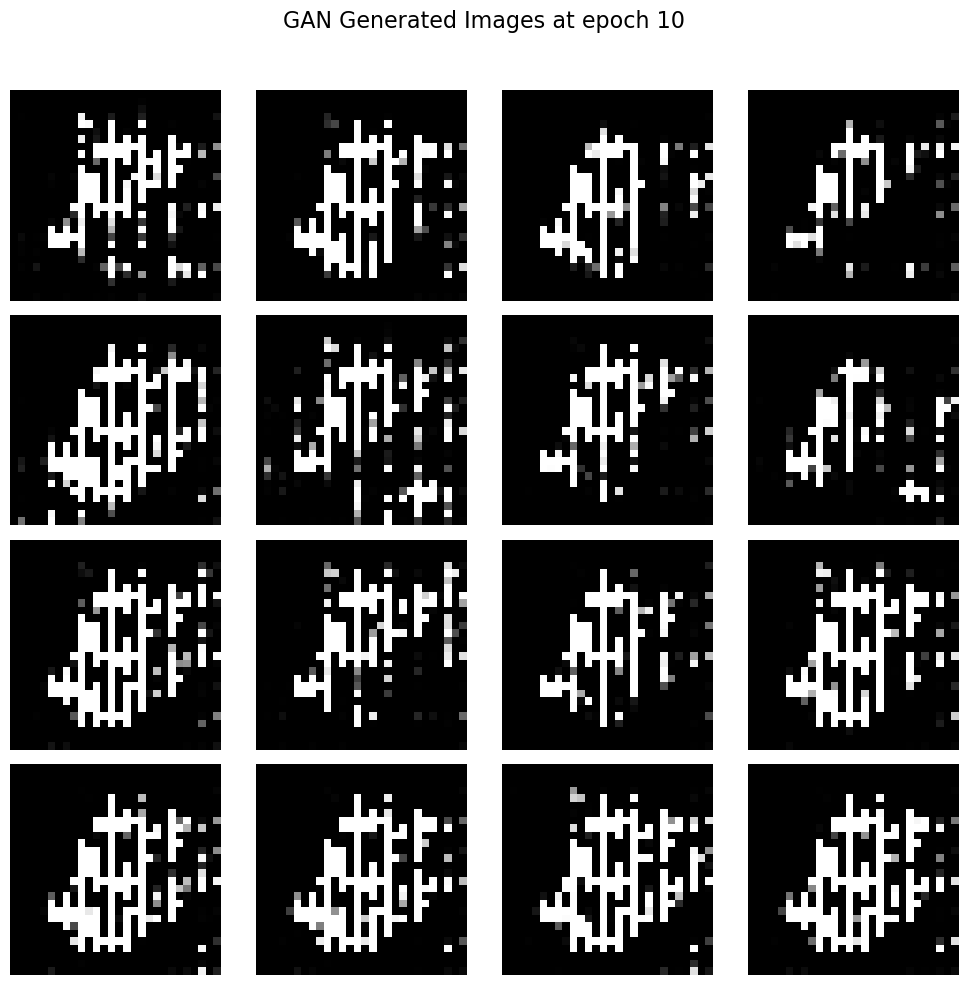

Epoch [11/200]:
epoch_d_loss: 0.207514 	epoch_g_loss: 3.281113
Epoch [12/200]:
epoch_d_loss: 0.208146 	epoch_g_loss: 3.760248
Epoch [13/200]:
epoch_d_loss: 0.254767 	epoch_g_loss: 3.676261
Epoch [14/200]:
epoch_d_loss: 0.220042 	epoch_g_loss: 3.089237
Epoch [15/200]:
epoch_d_loss: 0.282758 	epoch_g_loss: 2.860479
Epoch [16/200]:
epoch_d_loss: 0.253983 	epoch_g_loss: 3.222359
Epoch [17/200]:
epoch_d_loss: 0.181424 	epoch_g_loss: 3.392434
Epoch [18/200]:
epoch_d_loss: 0.142716 	epoch_g_loss: 3.731404
Epoch [19/200]:
epoch_d_loss: 0.087895 	epoch_g_loss: 3.860367
Epoch [20/200]:
epoch_d_loss: 0.114890 	epoch_g_loss: 3.825833


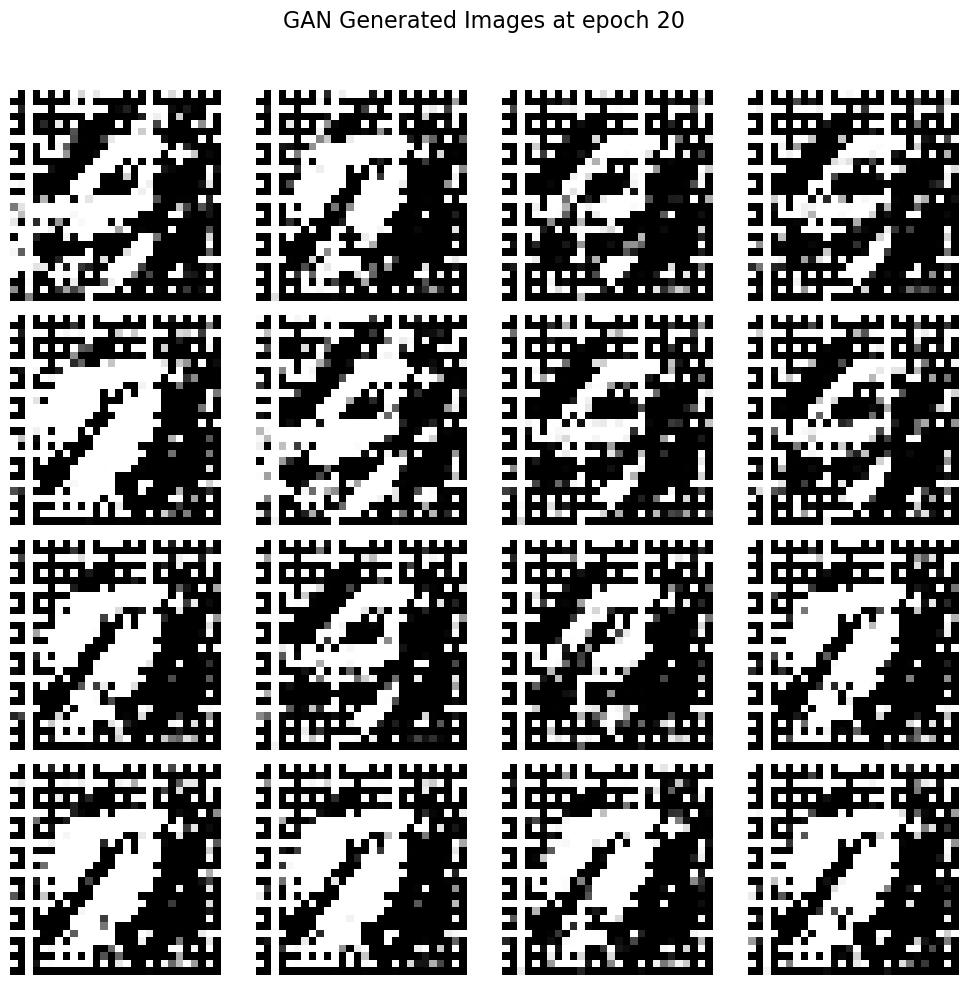

Epoch [21/200]:
epoch_d_loss: 0.061130 	epoch_g_loss: 3.934759
Epoch [22/200]:
epoch_d_loss: 0.054126 	epoch_g_loss: 4.249681
Epoch [23/200]:
epoch_d_loss: 0.048541 	epoch_g_loss: 4.654189
Epoch [24/200]:
epoch_d_loss: 0.080150 	epoch_g_loss: 4.091295
Epoch [25/200]:
epoch_d_loss: 0.112100 	epoch_g_loss: 4.497945
Epoch [26/200]:
epoch_d_loss: 0.326696 	epoch_g_loss: 3.276210
Epoch [27/200]:
epoch_d_loss: 0.223103 	epoch_g_loss: 3.447021
Epoch [28/200]:
epoch_d_loss: 0.441209 	epoch_g_loss: 3.273205
Epoch [29/200]:
epoch_d_loss: 0.322671 	epoch_g_loss: 3.368295
Epoch [30/200]:
epoch_d_loss: 0.745585 	epoch_g_loss: 3.152895


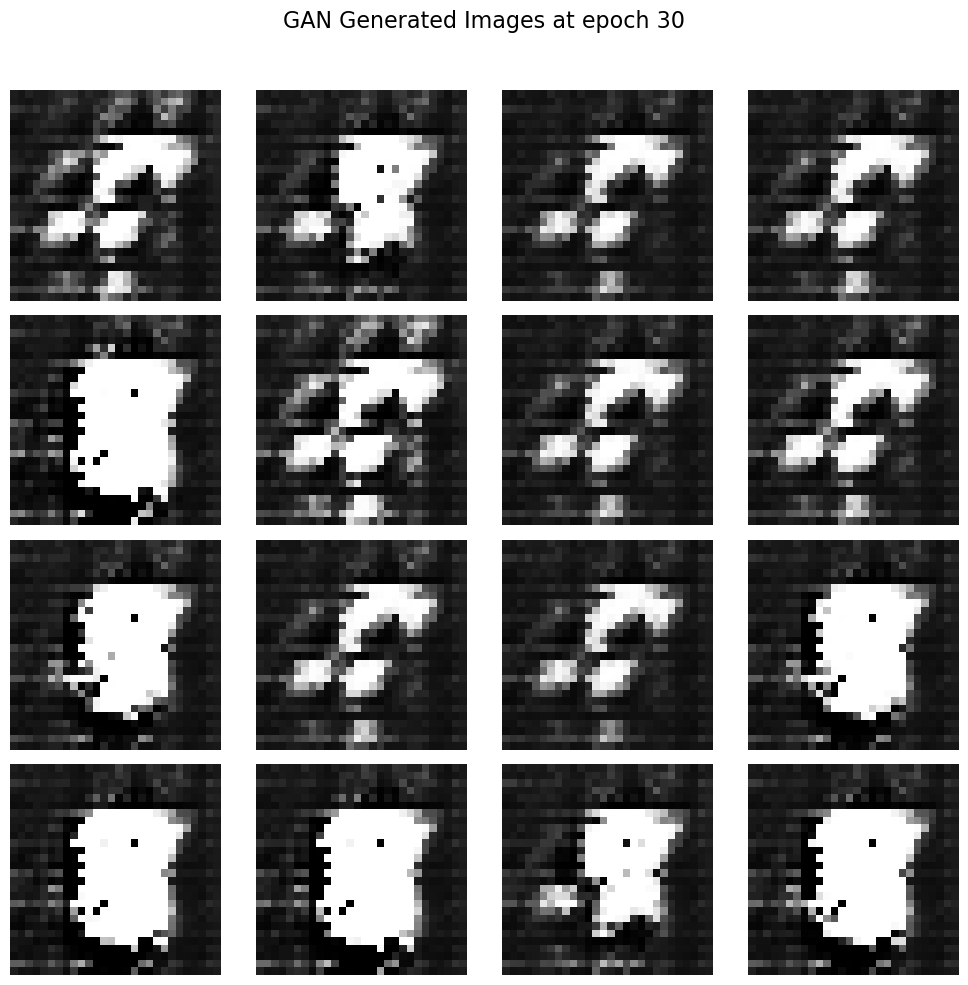

Epoch [31/200]:
epoch_d_loss: 0.177294 	epoch_g_loss: 3.156301
Epoch [32/200]:
epoch_d_loss: 0.393482 	epoch_g_loss: 2.611766
Epoch [33/200]:
epoch_d_loss: 0.479146 	epoch_g_loss: 3.230697
Epoch [34/200]:
epoch_d_loss: 0.478362 	epoch_g_loss: 2.787200
Epoch [35/200]:
epoch_d_loss: 0.518146 	epoch_g_loss: 2.617094
Epoch [36/200]:
epoch_d_loss: 0.359679 	epoch_g_loss: 2.919056
Epoch [37/200]:
epoch_d_loss: 0.407064 	epoch_g_loss: 2.597305
Epoch [38/200]:
epoch_d_loss: 0.364139 	epoch_g_loss: 2.944188
Epoch [39/200]:
epoch_d_loss: 0.291027 	epoch_g_loss: 3.132132
Epoch [40/200]:
epoch_d_loss: 0.621193 	epoch_g_loss: 2.755365


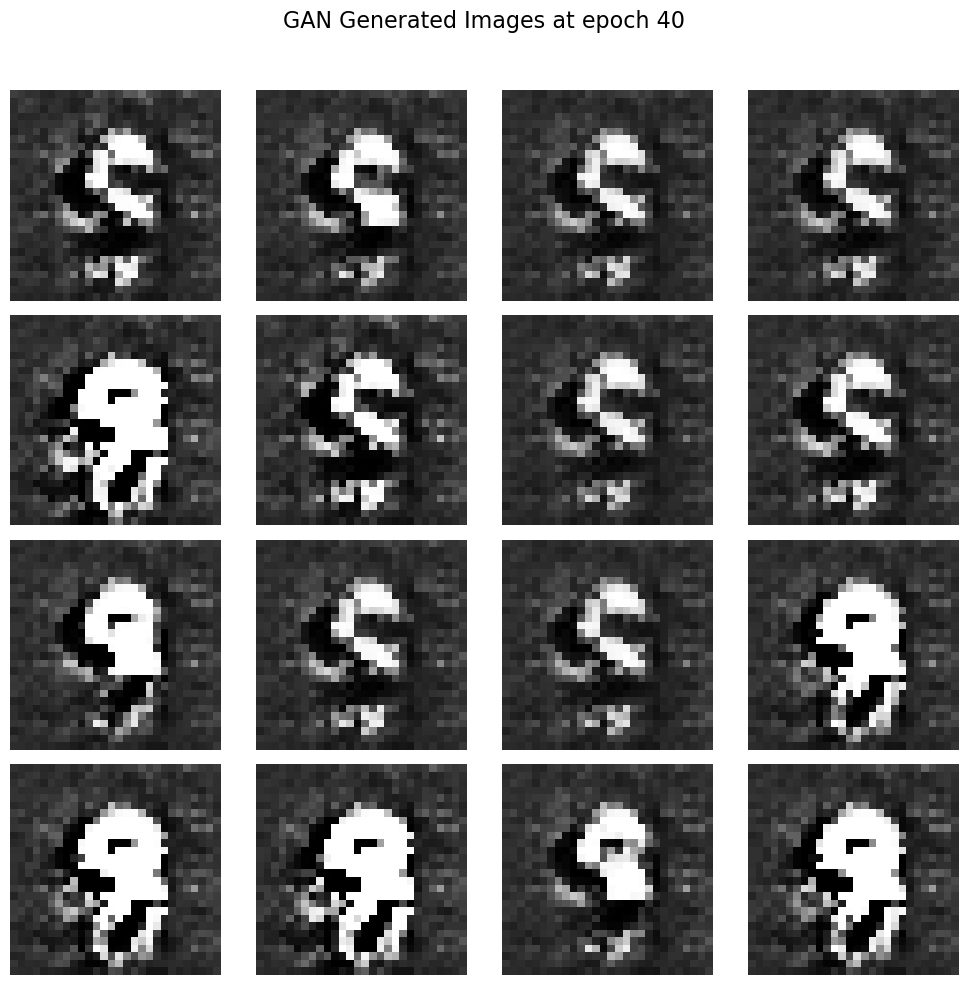

Epoch [41/200]:
epoch_d_loss: 0.296352 	epoch_g_loss: 3.018006
Epoch [42/200]:
epoch_d_loss: 0.505479 	epoch_g_loss: 2.730240
Epoch [43/200]:
epoch_d_loss: 0.425531 	epoch_g_loss: 2.849672
Epoch [44/200]:
epoch_d_loss: 0.217772 	epoch_g_loss: 2.962035
Epoch [45/200]:
epoch_d_loss: 0.344350 	epoch_g_loss: 2.829849
Epoch [46/200]:
epoch_d_loss: 0.478643 	epoch_g_loss: 2.841702
Epoch [47/200]:
epoch_d_loss: 0.321103 	epoch_g_loss: 2.822487
Epoch [48/200]:
epoch_d_loss: 0.351811 	epoch_g_loss: 3.098041
Epoch [49/200]:
epoch_d_loss: 0.237025 	epoch_g_loss: 3.060642
Epoch [50/200]:
epoch_d_loss: 0.253771 	epoch_g_loss: 3.152760


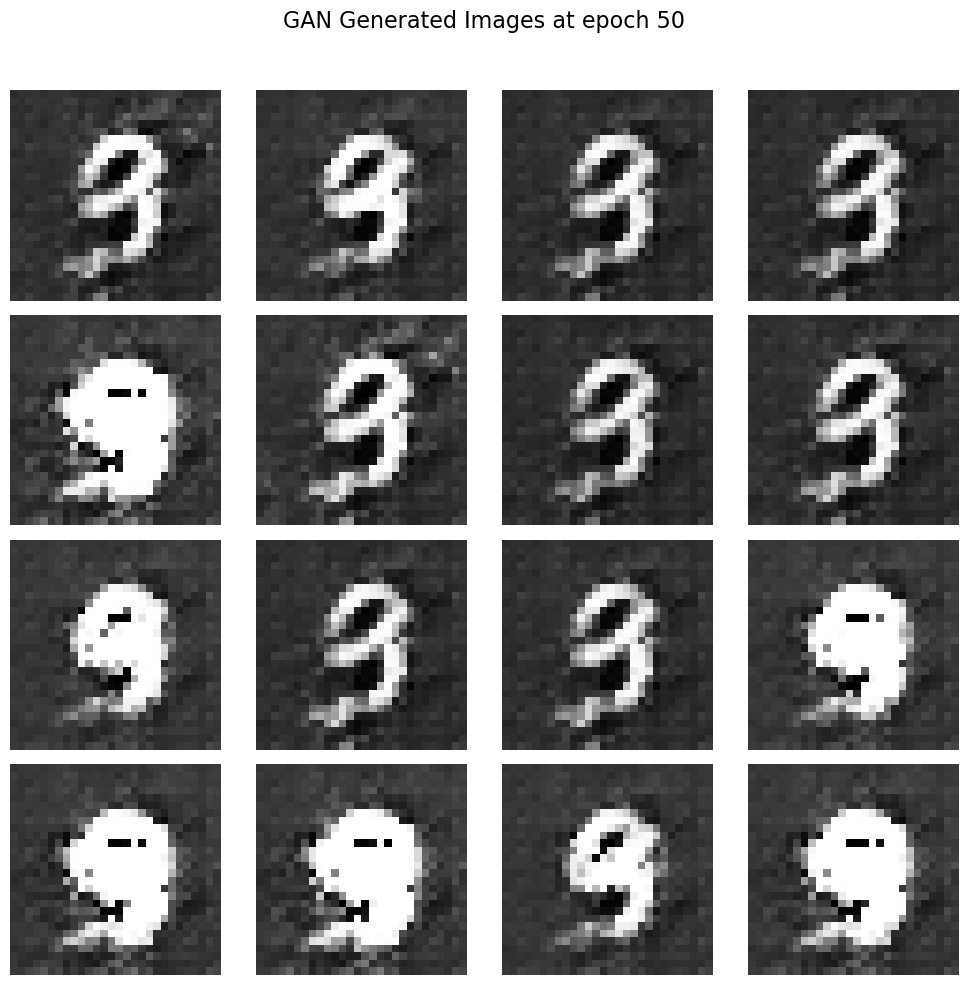

Epoch [51/200]:
epoch_d_loss: 0.554860 	epoch_g_loss: 2.851908
Epoch [52/200]:
epoch_d_loss: 0.250126 	epoch_g_loss: 3.030767
Epoch [53/200]:
epoch_d_loss: 0.200136 	epoch_g_loss: 3.180023
Epoch [54/200]:
epoch_d_loss: 0.303692 	epoch_g_loss: 3.105907
Epoch [55/200]:
epoch_d_loss: 0.285886 	epoch_g_loss: 3.106834
Epoch [56/200]:
epoch_d_loss: 0.179444 	epoch_g_loss: 3.251507
Epoch [57/200]:
epoch_d_loss: 0.249688 	epoch_g_loss: 3.151374
Epoch [58/200]:
epoch_d_loss: 0.316798 	epoch_g_loss: 3.183069
Epoch [59/200]:
epoch_d_loss: 0.292678 	epoch_g_loss: 3.224231
Epoch [60/200]:
epoch_d_loss: 0.302378 	epoch_g_loss: 2.977489


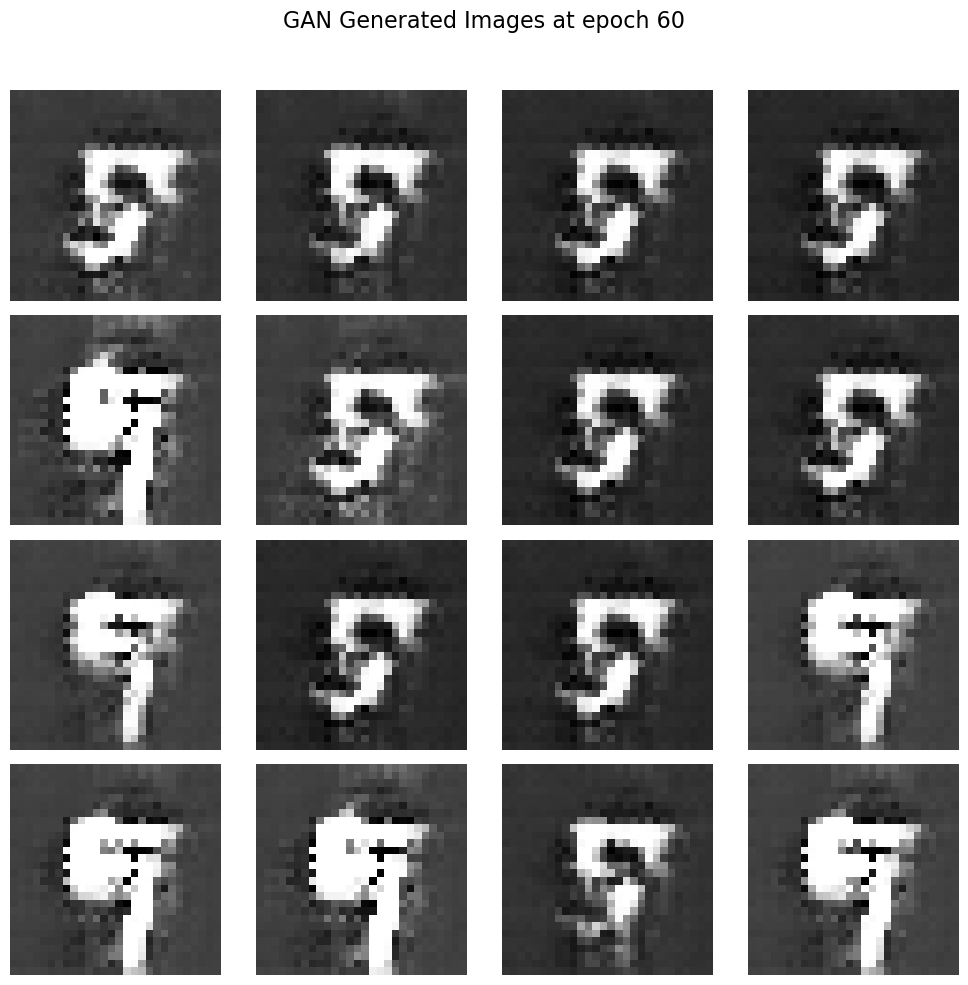

Epoch [61/200]:
epoch_d_loss: 0.412096 	epoch_g_loss: 3.076233
Epoch [62/200]:
epoch_d_loss: 0.315294 	epoch_g_loss: 3.049725
Epoch [63/200]:
epoch_d_loss: 0.397901 	epoch_g_loss: 3.153694
Epoch [64/200]:
epoch_d_loss: 0.100487 	epoch_g_loss: 3.555560
Epoch [65/200]:
epoch_d_loss: 0.161916 	epoch_g_loss: 3.184195
Epoch [66/200]:
epoch_d_loss: 0.195513 	epoch_g_loss: 3.050189
Epoch [67/200]:
epoch_d_loss: 0.347748 	epoch_g_loss: 2.995076
Epoch [68/200]:
epoch_d_loss: 0.484062 	epoch_g_loss: 3.055416
Epoch [69/200]:
epoch_d_loss: 0.459189 	epoch_g_loss: 2.801460
Epoch [70/200]:
epoch_d_loss: 0.515745 	epoch_g_loss: 2.833081


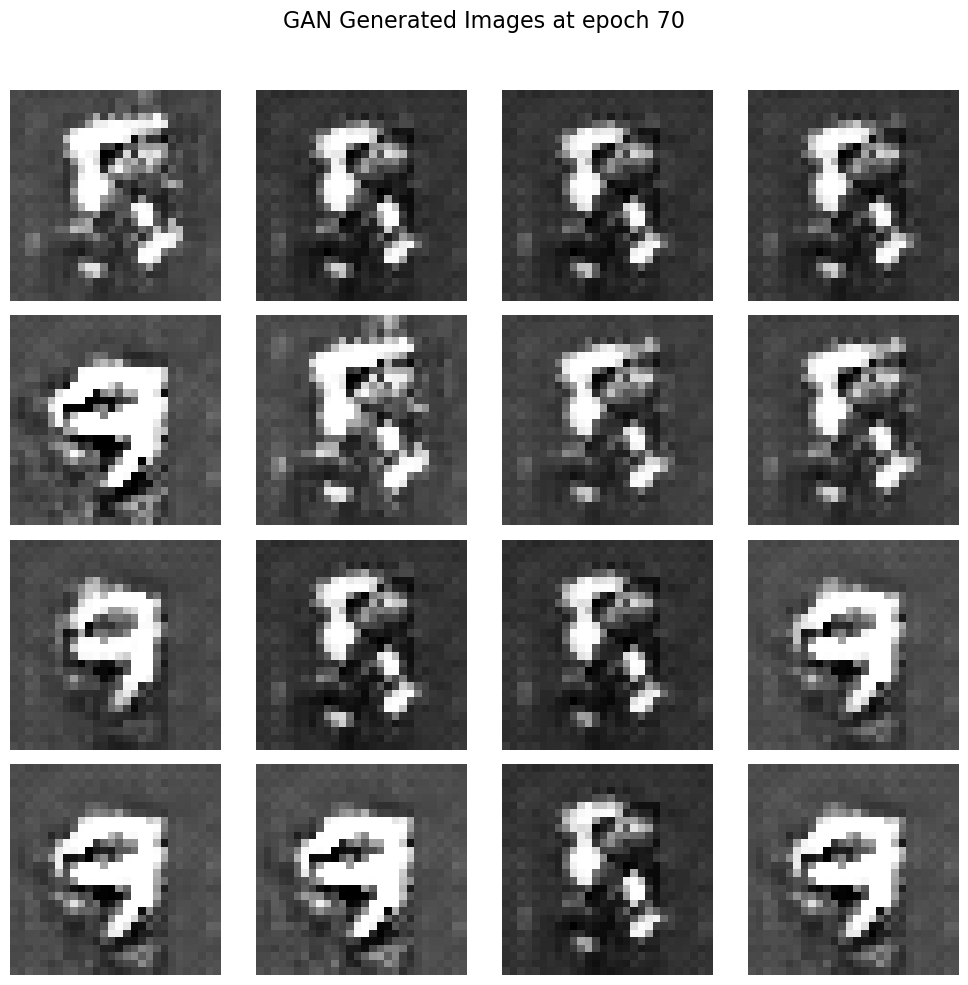

Epoch [71/200]:
epoch_d_loss: 0.338942 	epoch_g_loss: 3.162670
Epoch [72/200]:
epoch_d_loss: 0.445973 	epoch_g_loss: 3.207617
Epoch [73/200]:
epoch_d_loss: 0.195326 	epoch_g_loss: 2.994053
Epoch [74/200]:
epoch_d_loss: 0.197182 	epoch_g_loss: 3.249504
Epoch [75/200]:
epoch_d_loss: 0.163198 	epoch_g_loss: 3.118602
Epoch [76/200]:
epoch_d_loss: 0.251409 	epoch_g_loss: 3.151302
Epoch [77/200]:
epoch_d_loss: 0.289190 	epoch_g_loss: 3.229301
Epoch [78/200]:
epoch_d_loss: 0.375420 	epoch_g_loss: 2.710125
Epoch [79/200]:
epoch_d_loss: 0.340802 	epoch_g_loss: 2.987321
Epoch [80/200]:
epoch_d_loss: 0.298411 	epoch_g_loss: 2.948999


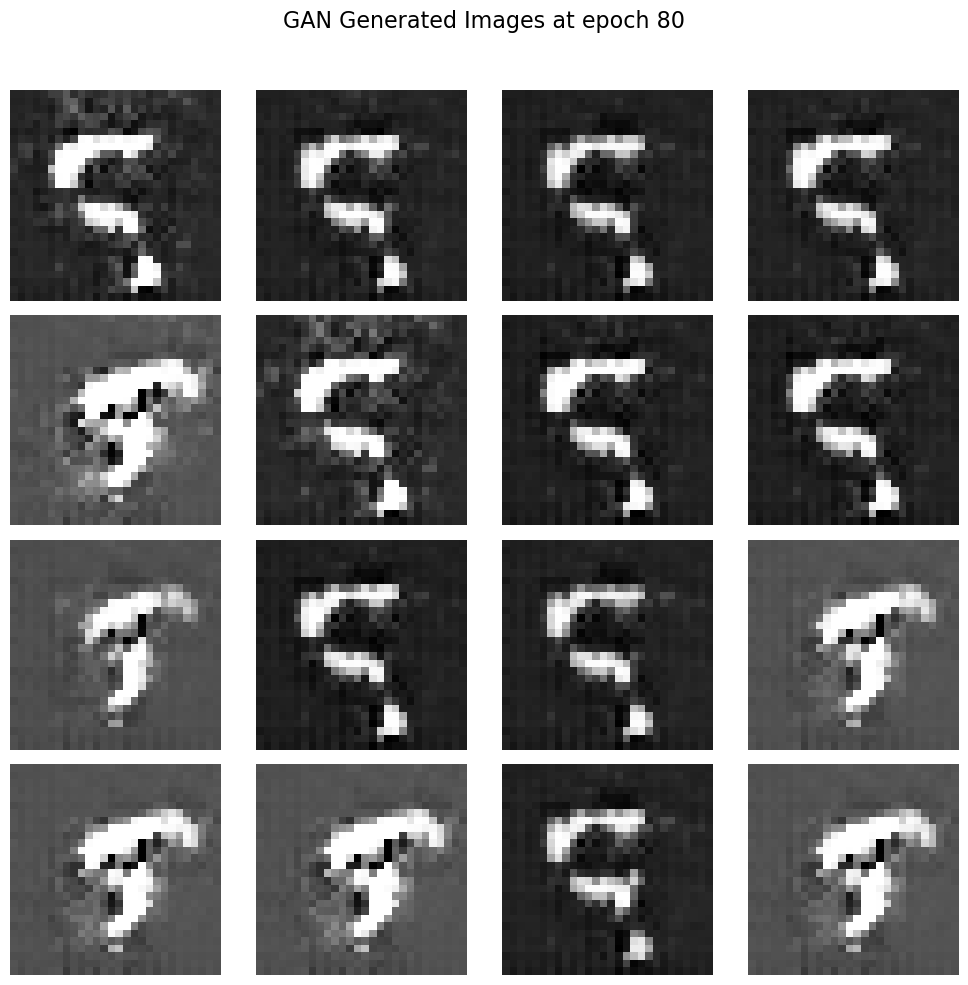

Epoch [81/200]:
epoch_d_loss: 0.324826 	epoch_g_loss: 3.022594
Epoch [82/200]:
epoch_d_loss: 0.356686 	epoch_g_loss: 2.865614
Epoch [83/200]:
epoch_d_loss: 0.336896 	epoch_g_loss: 3.000203
Epoch [84/200]:
epoch_d_loss: 0.361359 	epoch_g_loss: 2.780316
Epoch [85/200]:
epoch_d_loss: 0.318201 	epoch_g_loss: 2.768933
Epoch [86/200]:
epoch_d_loss: 0.330925 	epoch_g_loss: 2.863866
Epoch [87/200]:
epoch_d_loss: 0.549931 	epoch_g_loss: 3.113400
Epoch [88/200]:
epoch_d_loss: 0.417715 	epoch_g_loss: 3.106765
Epoch [89/200]:
epoch_d_loss: 0.249328 	epoch_g_loss: 3.076193
Epoch [90/200]:
epoch_d_loss: 0.452810 	epoch_g_loss: 2.597731


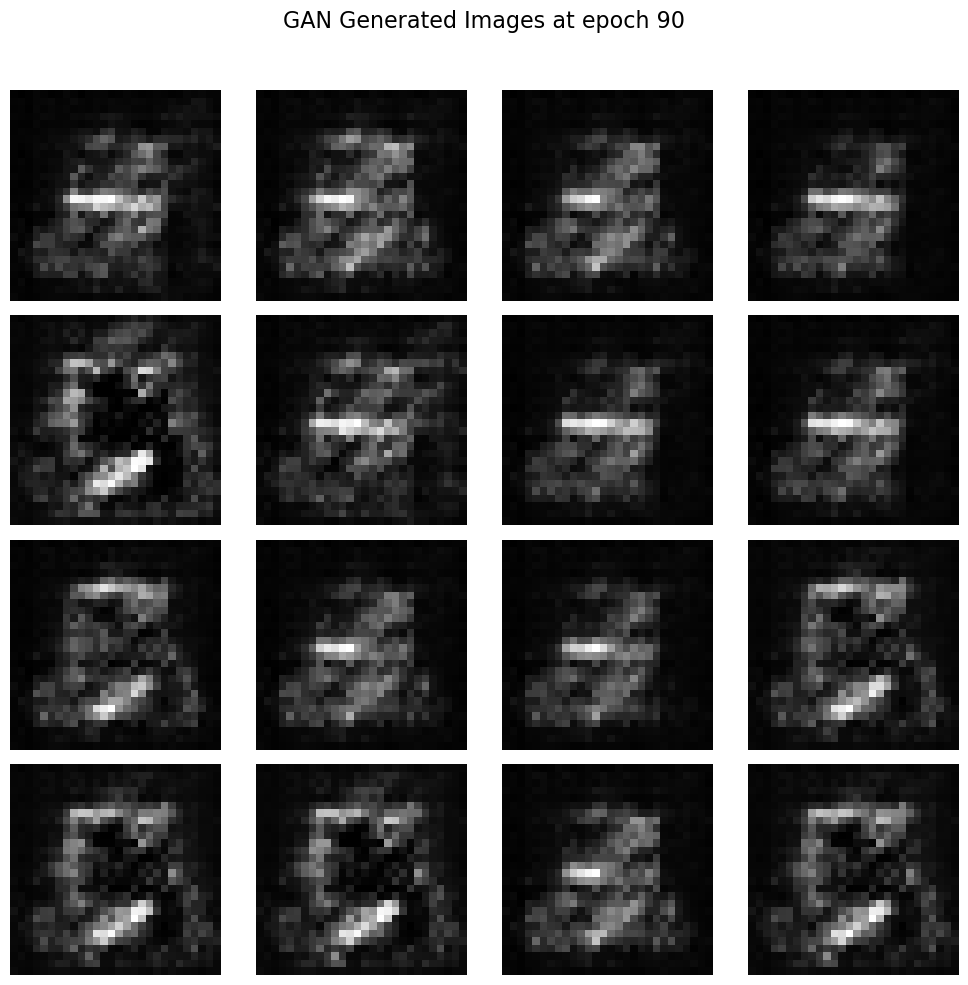

Epoch [91/200]:
epoch_d_loss: 0.887736 	epoch_g_loss: 3.217871
Epoch [92/200]:
epoch_d_loss: 0.264496 	epoch_g_loss: 3.713550
Epoch [93/200]:
epoch_d_loss: 0.127832 	epoch_g_loss: 3.425627
Epoch [94/200]:
epoch_d_loss: 0.189796 	epoch_g_loss: 3.678250
Epoch [95/200]:
epoch_d_loss: 0.115405 	epoch_g_loss: 3.579232
Epoch [96/200]:
epoch_d_loss: 0.065364 	epoch_g_loss: 3.832716
Epoch [97/200]:
epoch_d_loss: 0.109523 	epoch_g_loss: 3.875622
Epoch [98/200]:
epoch_d_loss: 0.085341 	epoch_g_loss: 3.955036
Epoch [99/200]:
epoch_d_loss: 0.081098 	epoch_g_loss: 3.951155
Epoch [100/200]:
epoch_d_loss: 0.418338 	epoch_g_loss: 2.977189


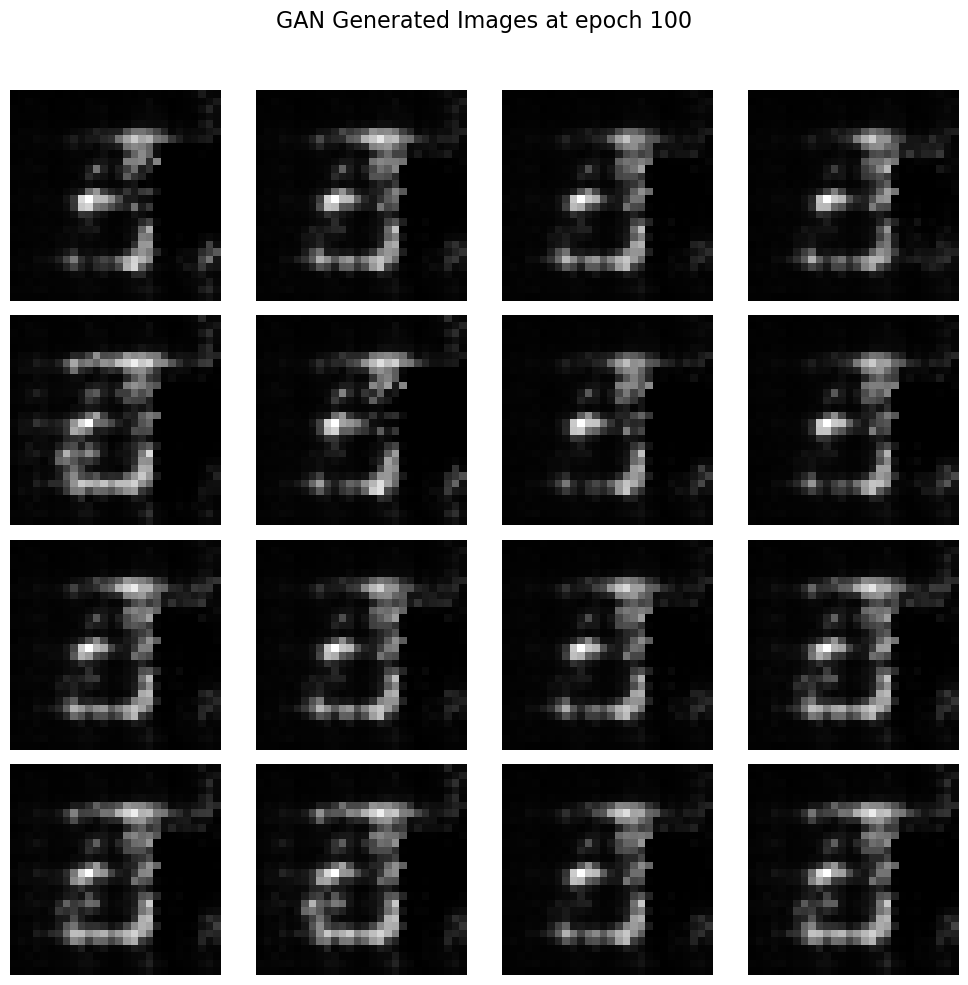

Epoch [101/200]:
epoch_d_loss: 0.391852 	epoch_g_loss: 3.571037
Epoch [102/200]:
epoch_d_loss: 1.026567 	epoch_g_loss: 2.948460
Epoch [103/200]:
epoch_d_loss: 0.862961 	epoch_g_loss: 3.039227
Epoch [104/200]:
epoch_d_loss: 0.413326 	epoch_g_loss: 3.131396
Epoch [105/200]:
epoch_d_loss: 0.976597 	epoch_g_loss: 2.331992
Epoch [106/200]:
epoch_d_loss: 0.772305 	epoch_g_loss: 2.176136
Epoch [107/200]:
epoch_d_loss: 0.906888 	epoch_g_loss: 2.169286
Epoch [108/200]:
epoch_d_loss: 1.011840 	epoch_g_loss: 2.234270
Epoch [109/200]:
epoch_d_loss: 0.512259 	epoch_g_loss: 1.980466
Epoch [110/200]:
epoch_d_loss: 0.905580 	epoch_g_loss: 2.037623


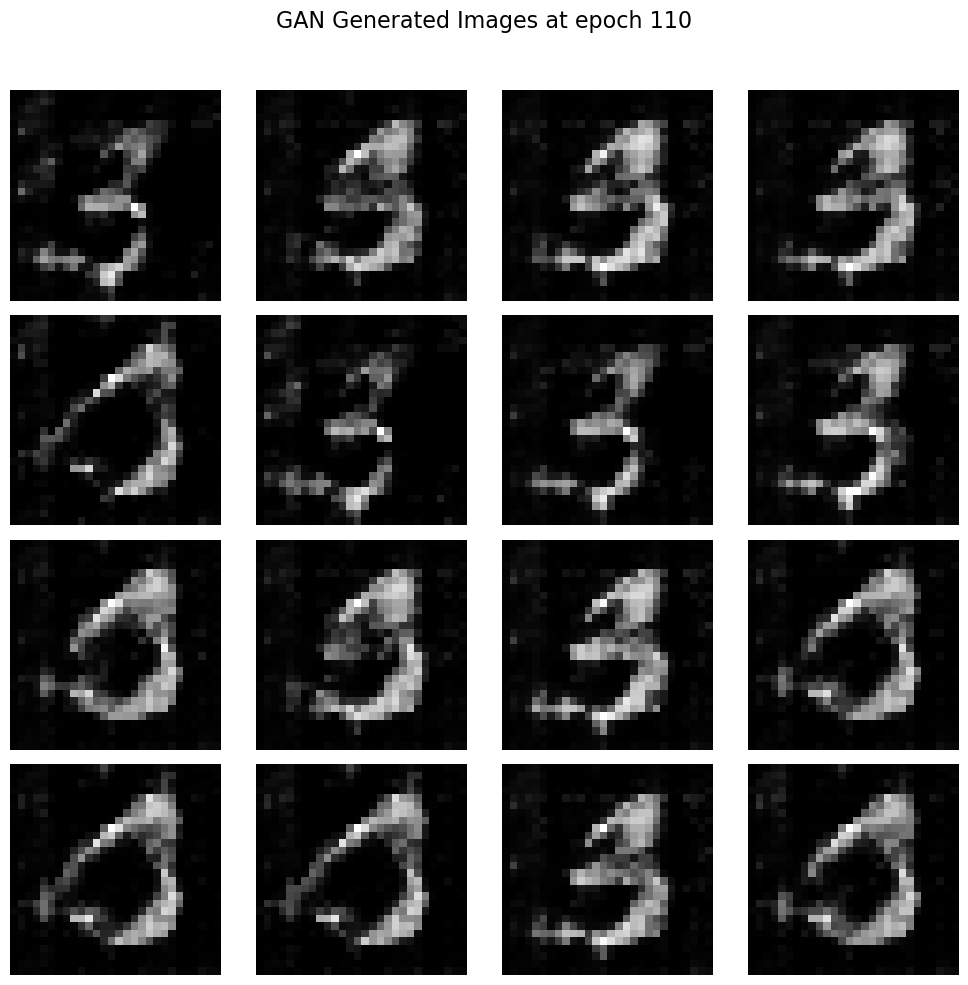

Epoch [111/200]:
epoch_d_loss: 0.554539 	epoch_g_loss: 1.976919
Epoch [112/200]:
epoch_d_loss: 0.479920 	epoch_g_loss: 2.142200
Epoch [113/200]:
epoch_d_loss: 0.694381 	epoch_g_loss: 2.173400
Epoch [114/200]:
epoch_d_loss: 0.857791 	epoch_g_loss: 2.129592
Epoch [115/200]:
epoch_d_loss: 0.561264 	epoch_g_loss: 2.081137
Epoch [116/200]:
epoch_d_loss: 0.628787 	epoch_g_loss: 2.150794
Epoch [117/200]:
epoch_d_loss: 0.516655 	epoch_g_loss: 2.124908
Epoch [118/200]:
epoch_d_loss: 0.847288 	epoch_g_loss: 2.017463
Epoch [119/200]:
epoch_d_loss: 0.841720 	epoch_g_loss: 1.929453
Epoch [120/200]:
epoch_d_loss: 0.593240 	epoch_g_loss: 1.966286


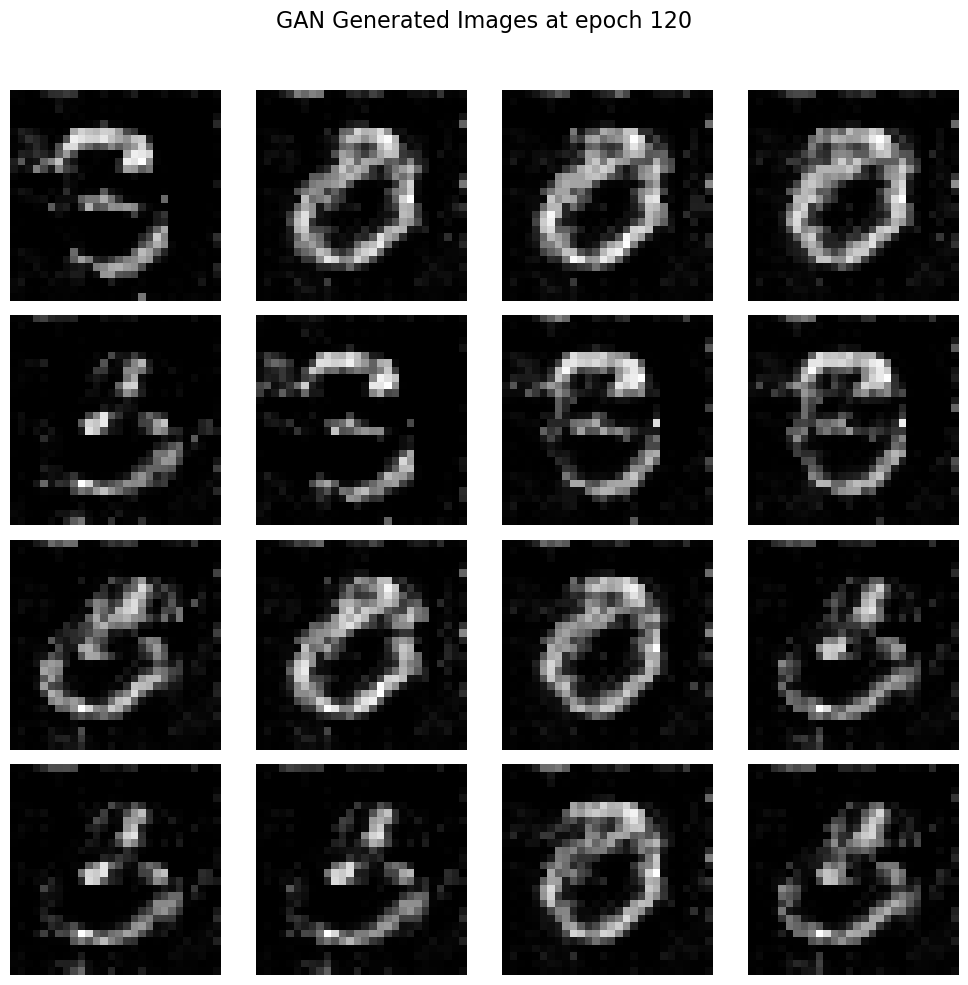

Epoch [121/200]:
epoch_d_loss: 0.974172 	epoch_g_loss: 2.016811
Epoch [122/200]:
epoch_d_loss: 0.670138 	epoch_g_loss: 1.893312
Epoch [123/200]:
epoch_d_loss: 0.664535 	epoch_g_loss: 2.060890
Epoch [124/200]:
epoch_d_loss: 0.521866 	epoch_g_loss: 1.968332
Epoch [125/200]:
epoch_d_loss: 0.584674 	epoch_g_loss: 1.947411
Epoch [126/200]:
epoch_d_loss: 0.851578 	epoch_g_loss: 1.953602
Epoch [127/200]:
epoch_d_loss: 0.701545 	epoch_g_loss: 1.941809
Epoch [128/200]:
epoch_d_loss: 0.719720 	epoch_g_loss: 1.954925
Epoch [129/200]:
epoch_d_loss: 0.748061 	epoch_g_loss: 1.843124
Epoch [130/200]:
epoch_d_loss: 0.780856 	epoch_g_loss: 1.867769


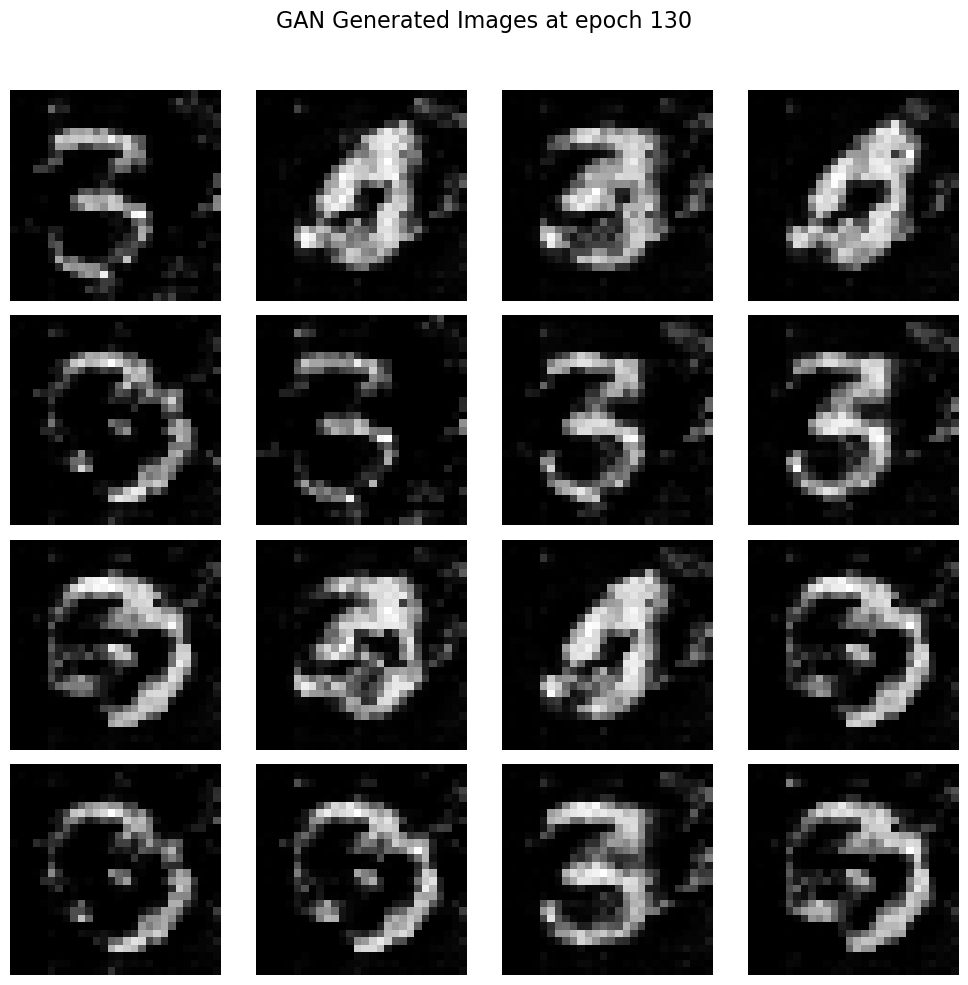

Epoch [131/200]:
epoch_d_loss: 0.707919 	epoch_g_loss: 1.982534
Epoch [132/200]:
epoch_d_loss: 0.649454 	epoch_g_loss: 1.997937
Epoch [133/200]:
epoch_d_loss: 0.645434 	epoch_g_loss: 2.026590
Epoch [134/200]:
epoch_d_loss: 0.658519 	epoch_g_loss: 2.014426
Epoch [135/200]:
epoch_d_loss: 0.762127 	epoch_g_loss: 1.951128
Epoch [136/200]:
epoch_d_loss: 0.849359 	epoch_g_loss: 1.748820
Epoch [137/200]:
epoch_d_loss: 0.860657 	epoch_g_loss: 1.911052
Epoch [138/200]:
epoch_d_loss: 0.735724 	epoch_g_loss: 1.860607
Epoch [139/200]:
epoch_d_loss: 0.722925 	epoch_g_loss: 1.893823
Epoch [140/200]:
epoch_d_loss: 0.779274 	epoch_g_loss: 1.819296


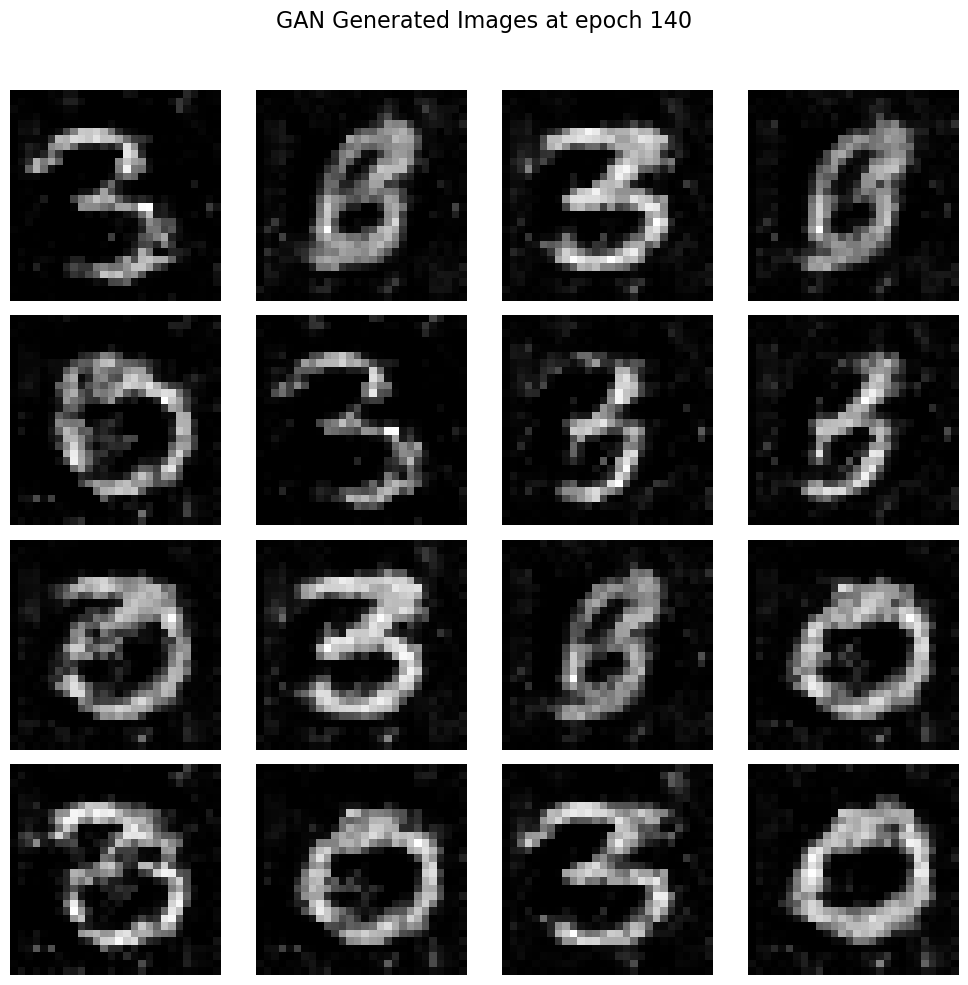

Epoch [141/200]:
epoch_d_loss: 0.754506 	epoch_g_loss: 1.893670
Epoch [142/200]:
epoch_d_loss: 0.849368 	epoch_g_loss: 1.806886
Epoch [143/200]:
epoch_d_loss: 0.795040 	epoch_g_loss: 1.839288
Epoch [144/200]:
epoch_d_loss: 0.826286 	epoch_g_loss: 1.763244
Epoch [145/200]:
epoch_d_loss: 0.816200 	epoch_g_loss: 1.853784
Epoch [146/200]:
epoch_d_loss: 0.886326 	epoch_g_loss: 1.726730
Epoch [147/200]:
epoch_d_loss: 0.829951 	epoch_g_loss: 1.744058
Epoch [148/200]:
epoch_d_loss: 0.898724 	epoch_g_loss: 1.765565
Epoch [149/200]:
epoch_d_loss: 0.919679 	epoch_g_loss: 1.754559
Epoch [150/200]:
epoch_d_loss: 0.967453 	epoch_g_loss: 1.761306


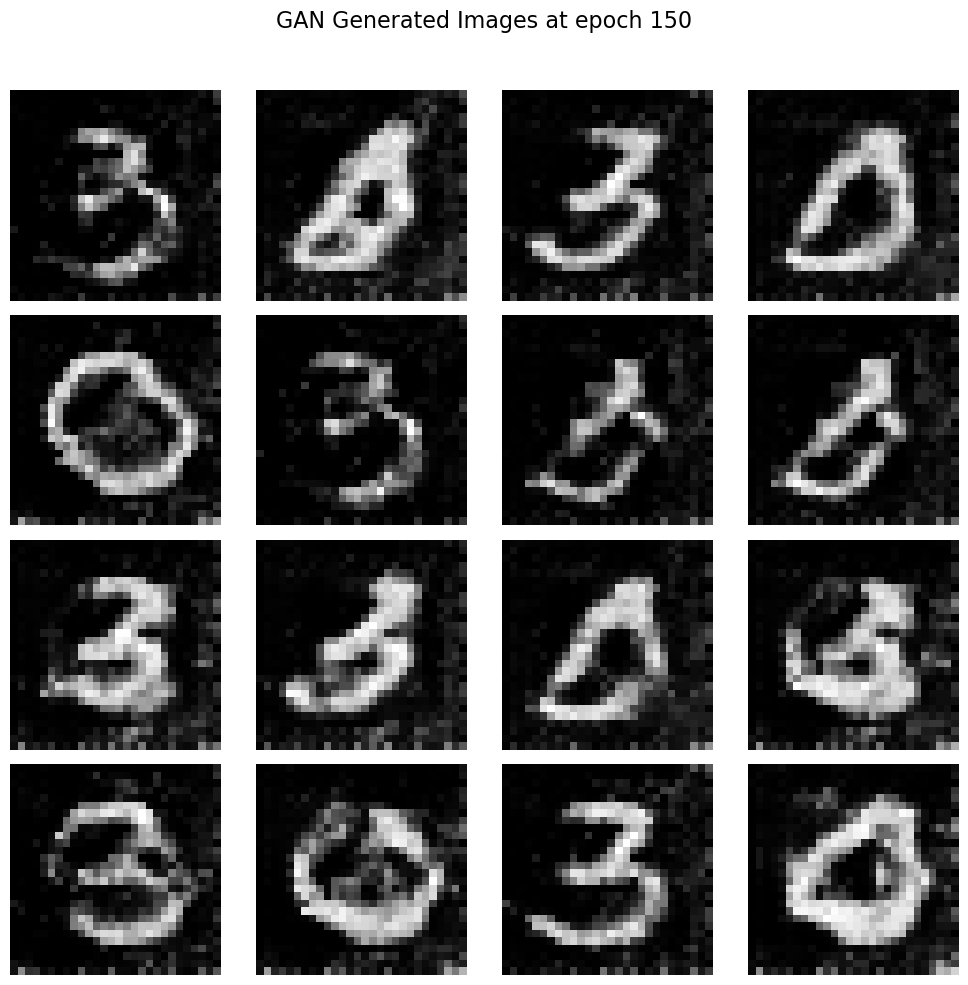

Epoch [151/200]:
epoch_d_loss: 0.923853 	epoch_g_loss: 1.773825
Epoch [152/200]:
epoch_d_loss: 0.848041 	epoch_g_loss: 1.726457
Epoch [153/200]:
epoch_d_loss: 0.861046 	epoch_g_loss: 1.689078
Epoch [154/200]:
epoch_d_loss: 0.917906 	epoch_g_loss: 1.781873
Epoch [155/200]:
epoch_d_loss: 0.926354 	epoch_g_loss: 1.738945
Epoch [156/200]:
epoch_d_loss: 0.924459 	epoch_g_loss: 1.777198
Epoch [157/200]:
epoch_d_loss: 0.928799 	epoch_g_loss: 1.822938
Epoch [158/200]:
epoch_d_loss: 0.967232 	epoch_g_loss: 1.754705
Epoch [159/200]:
epoch_d_loss: 1.010212 	epoch_g_loss: 1.694602
Epoch [160/200]:
epoch_d_loss: 1.033883 	epoch_g_loss: 1.646523


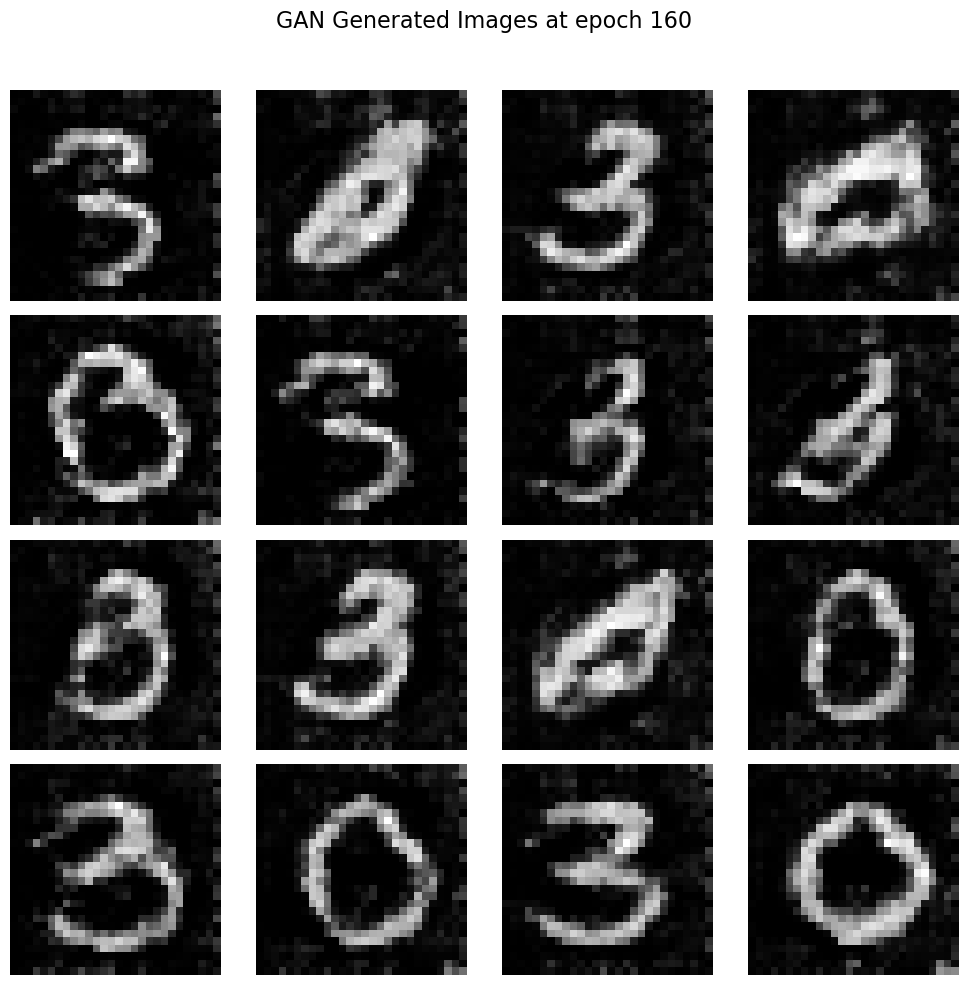

Epoch [161/200]:
epoch_d_loss: 1.051707 	epoch_g_loss: 1.596118
Epoch [162/200]:
epoch_d_loss: 1.072659 	epoch_g_loss: 1.557206
Epoch [163/200]:
epoch_d_loss: 1.087020 	epoch_g_loss: 1.480551
Epoch [164/200]:
epoch_d_loss: 1.100016 	epoch_g_loss: 1.405941
Epoch [165/200]:
epoch_d_loss: 1.087664 	epoch_g_loss: 1.380296
Epoch [166/200]:
epoch_d_loss: 1.109027 	epoch_g_loss: 1.339010
Epoch [167/200]:
epoch_d_loss: 1.098378 	epoch_g_loss: 1.337470
Epoch [168/200]:
epoch_d_loss: 1.097461 	epoch_g_loss: 1.292328
Epoch [169/200]:
epoch_d_loss: 1.073836 	epoch_g_loss: 1.316297
Epoch [170/200]:
epoch_d_loss: 1.037617 	epoch_g_loss: 1.287343


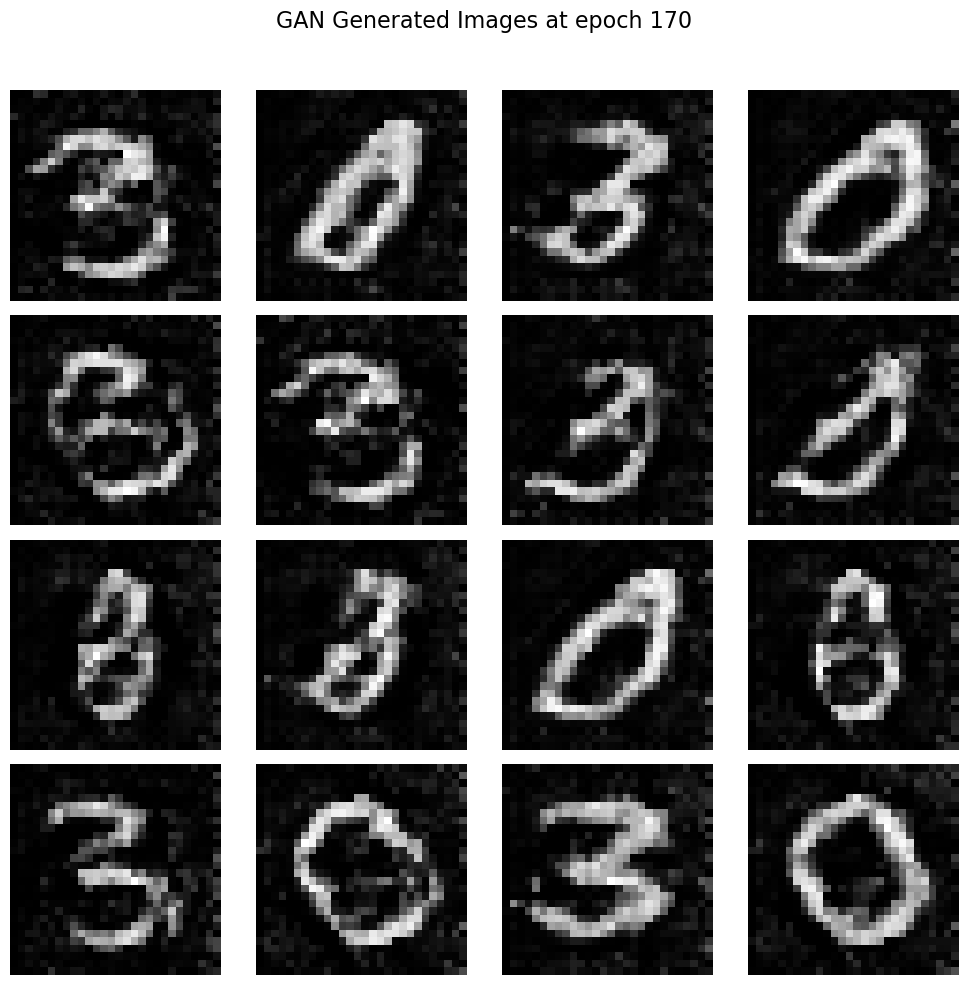

Epoch [171/200]:
epoch_d_loss: 1.042211 	epoch_g_loss: 1.296298
Epoch [172/200]:
epoch_d_loss: 1.096431 	epoch_g_loss: 1.242909
Epoch [173/200]:
epoch_d_loss: 1.065959 	epoch_g_loss: 1.285423
Epoch [174/200]:
epoch_d_loss: 1.046500 	epoch_g_loss: 1.315241
Epoch [175/200]:
epoch_d_loss: 1.011506 	epoch_g_loss: 1.299267
Epoch [176/200]:
epoch_d_loss: 1.051946 	epoch_g_loss: 1.231324
Epoch [177/200]:
epoch_d_loss: 1.090475 	epoch_g_loss: 1.202554
Epoch [178/200]:
epoch_d_loss: 1.089509 	epoch_g_loss: 1.250012
Epoch [179/200]:
epoch_d_loss: 1.082592 	epoch_g_loss: 1.244188
Epoch [180/200]:
epoch_d_loss: 1.090914 	epoch_g_loss: 1.215665


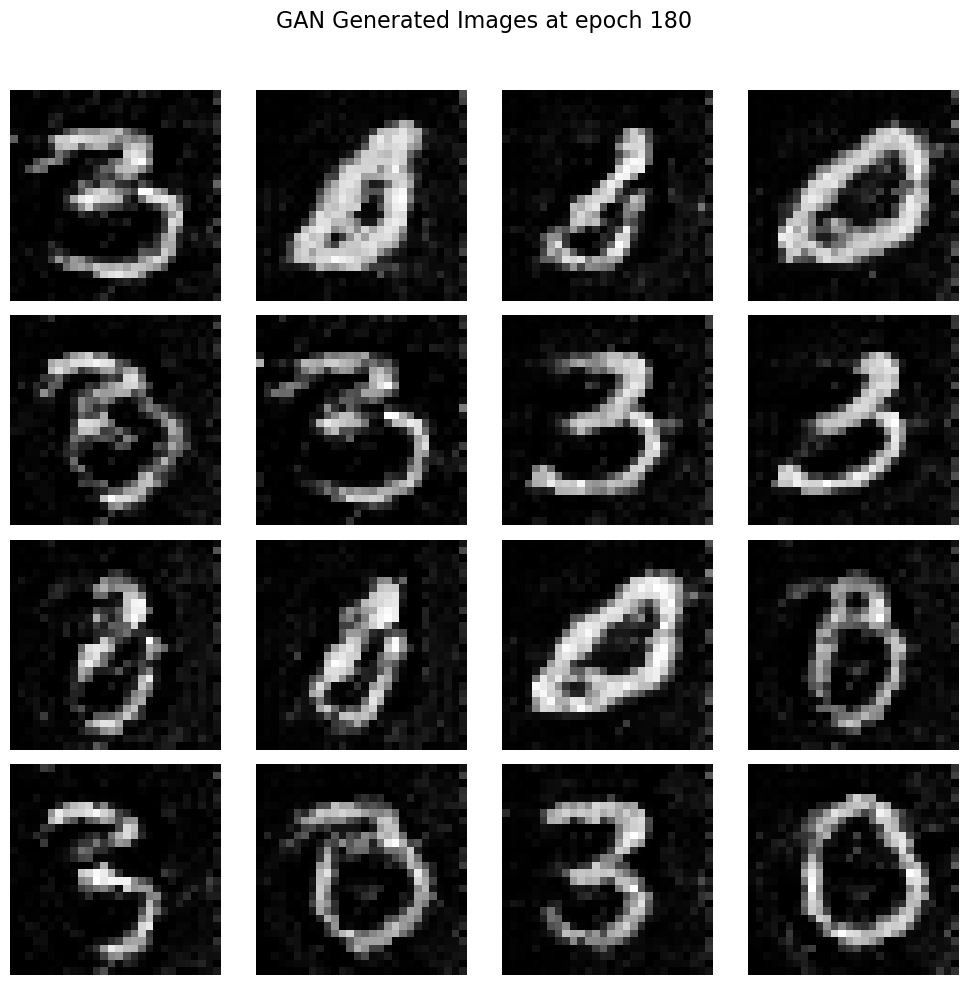

Epoch [181/200]:
epoch_d_loss: 1.090062 	epoch_g_loss: 1.214349
Epoch [182/200]:
epoch_d_loss: 1.072713 	epoch_g_loss: 1.178921
Epoch [183/200]:
epoch_d_loss: 1.065771 	epoch_g_loss: 1.154722
Epoch [184/200]:
epoch_d_loss: 1.080285 	epoch_g_loss: 1.189255
Epoch [185/200]:
epoch_d_loss: 1.081926 	epoch_g_loss: 1.170120
Epoch [186/200]:
epoch_d_loss: 1.056613 	epoch_g_loss: 1.196021
Epoch [187/200]:
epoch_d_loss: 1.084876 	epoch_g_loss: 1.137562
Epoch [188/200]:
epoch_d_loss: 1.065793 	epoch_g_loss: 1.186279
Epoch [189/200]:
epoch_d_loss: 1.053055 	epoch_g_loss: 1.204610
Epoch [190/200]:
epoch_d_loss: 1.053241 	epoch_g_loss: 1.168277


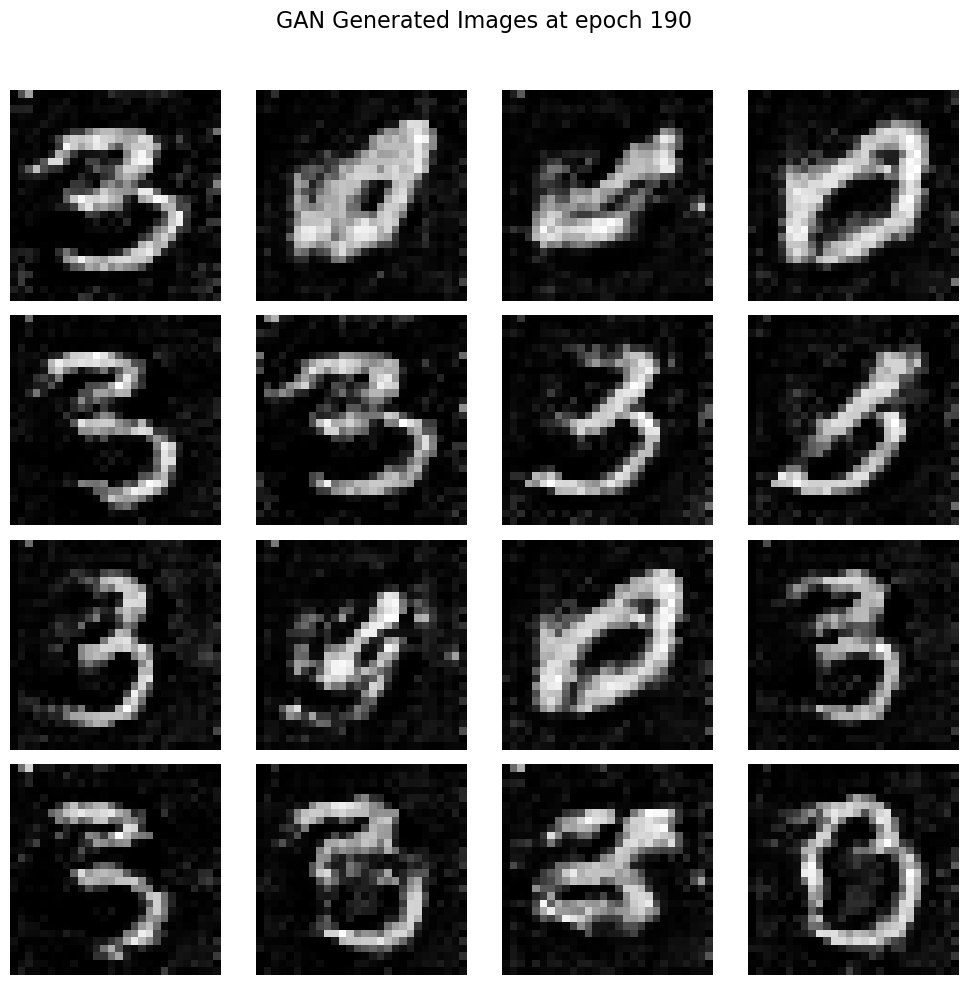

Epoch [191/200]:
epoch_d_loss: 1.078666 	epoch_g_loss: 1.136339
Epoch [192/200]:
epoch_d_loss: 1.097681 	epoch_g_loss: 1.156537
Epoch [193/200]:
epoch_d_loss: 1.076747 	epoch_g_loss: 1.144466
Epoch [194/200]:
epoch_d_loss: 1.077527 	epoch_g_loss: 1.156687
Epoch [195/200]:
epoch_d_loss: 1.074554 	epoch_g_loss: 1.137169
Epoch [196/200]:
epoch_d_loss: 1.071582 	epoch_g_loss: 1.152821
Epoch [197/200]:
epoch_d_loss: 1.046912 	epoch_g_loss: 1.143172
Epoch [198/200]:
epoch_d_loss: 1.076755 	epoch_g_loss: 1.113094
Epoch [199/200]:
epoch_d_loss: 1.034426 	epoch_g_loss: 1.192874
Epoch [200/200]:
epoch_d_loss: 1.084489 	epoch_g_loss: 1.128776


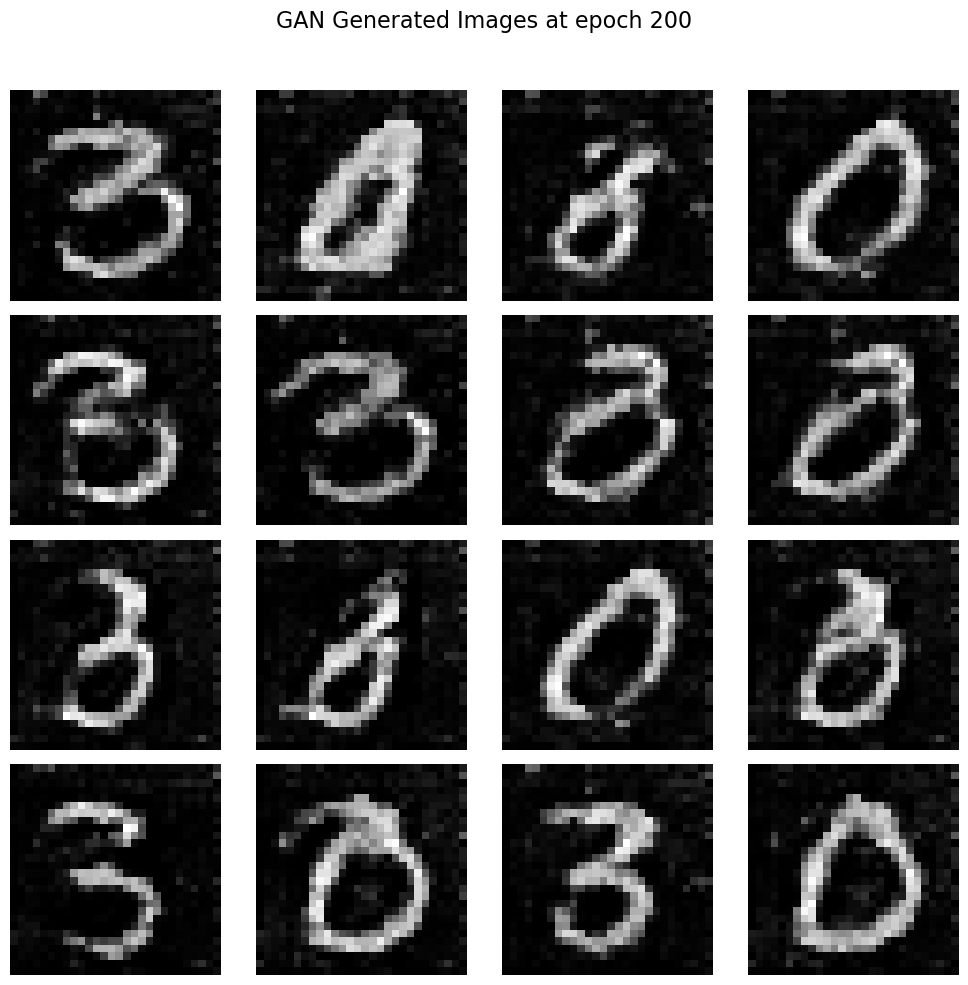

Time to train the generator on task  3   1176.9725368022919
Time to generate the data 2811.1647124290466


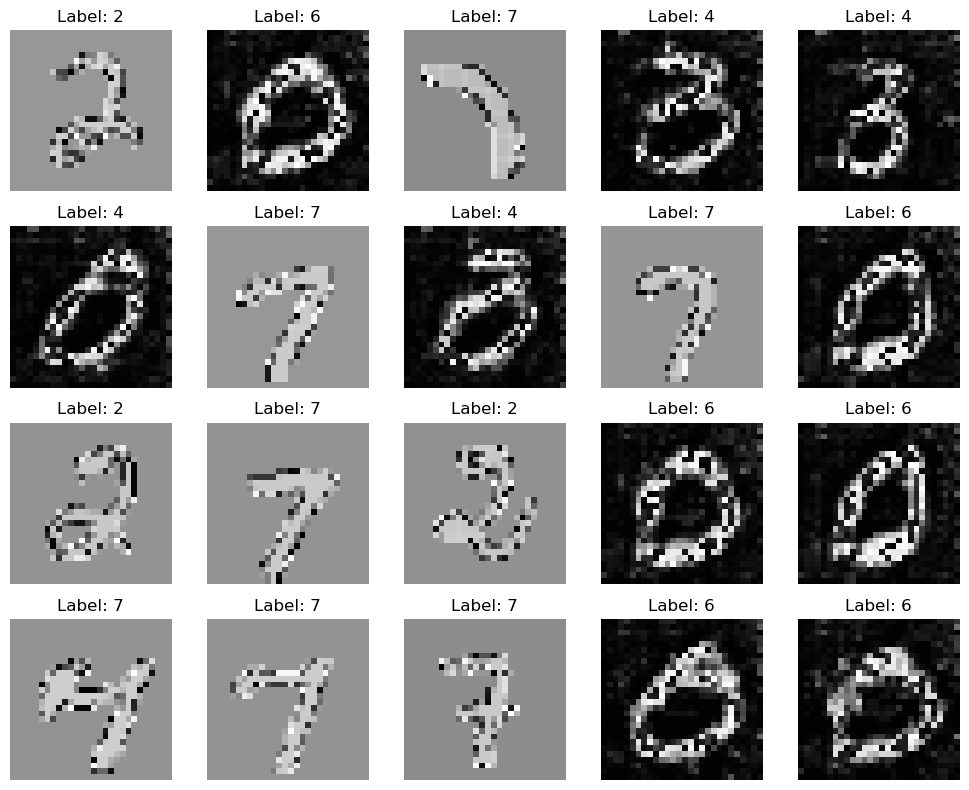

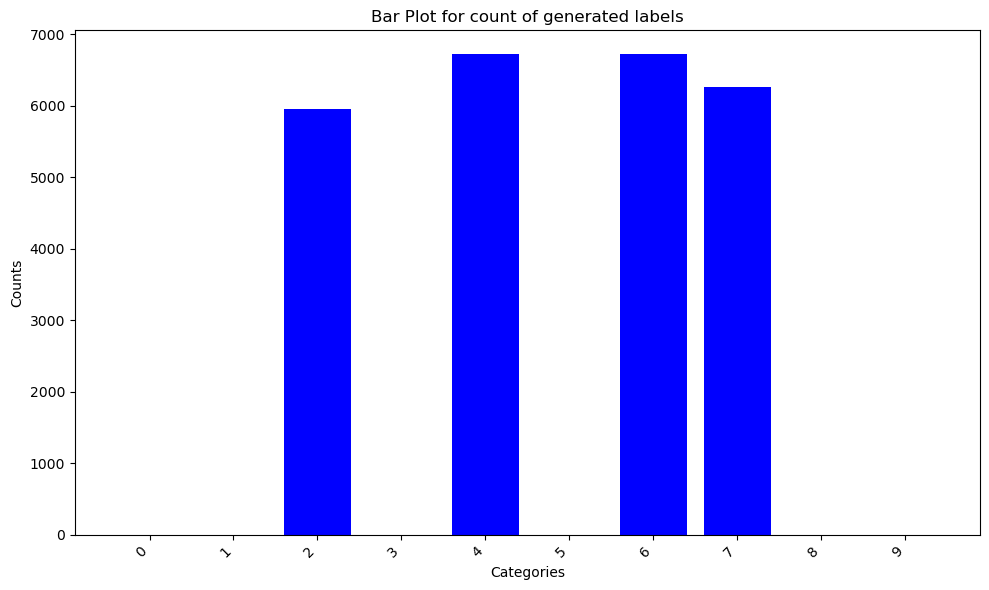

Epoch 0: Loss 2.215 Acc: 0.290
Epoch 1: Loss 1.726 Acc: 0.418
Epoch 2: Loss 1.390 Acc: 0.475
Epoch 3: Loss 1.089 Acc: 0.582
Epoch 4: Loss 0.804 Acc: 0.743
Epoch 5: Loss 0.544 Acc: 0.894
Epoch 6: Loss 0.366 Acc: 0.951
Epoch 7: Loss 0.256 Acc: 0.972
Epoch 8: Loss 0.191 Acc: 0.978
Epoch 9: Loss 0.195 Acc: 0.966
Epoch 10: Loss 0.156 Acc: 0.979
Epoch 11: Loss 0.115 Acc: 0.981
Epoch 12: Loss 0.092 Acc: 0.986
Epoch 13: Loss 0.079 Acc: 0.988
Epoch 14: Loss 0.075 Acc: 0.988
Epoch 15: Loss 0.068 Acc: 0.988
Epoch 16: Loss 0.063 Acc: 0.991
Epoch 17: Loss 0.060 Acc: 0.989
Epoch 18: Loss 0.055 Acc: 0.990
Epoch 19: Loss 0.052 Acc: 0.990
Time to train the solver on task  4   137.36202454566956
[6, 4, 0, 3, 8, 1, 9, 5, 2, 7]
Training on [cuda]...
Epoch [1/200]:
epoch_d_loss: 0.595785 	epoch_g_loss: 1.836311
Epoch [2/200]:
epoch_d_loss: 0.603314 	epoch_g_loss: 1.461003
Epoch [3/200]:
epoch_d_loss: 0.512699 	epoch_g_loss: 2.079250
Epoch [4/200]:
epoch_d_loss: 0.506312 	epoch_g_loss: 1.997098
Epoch [5/200

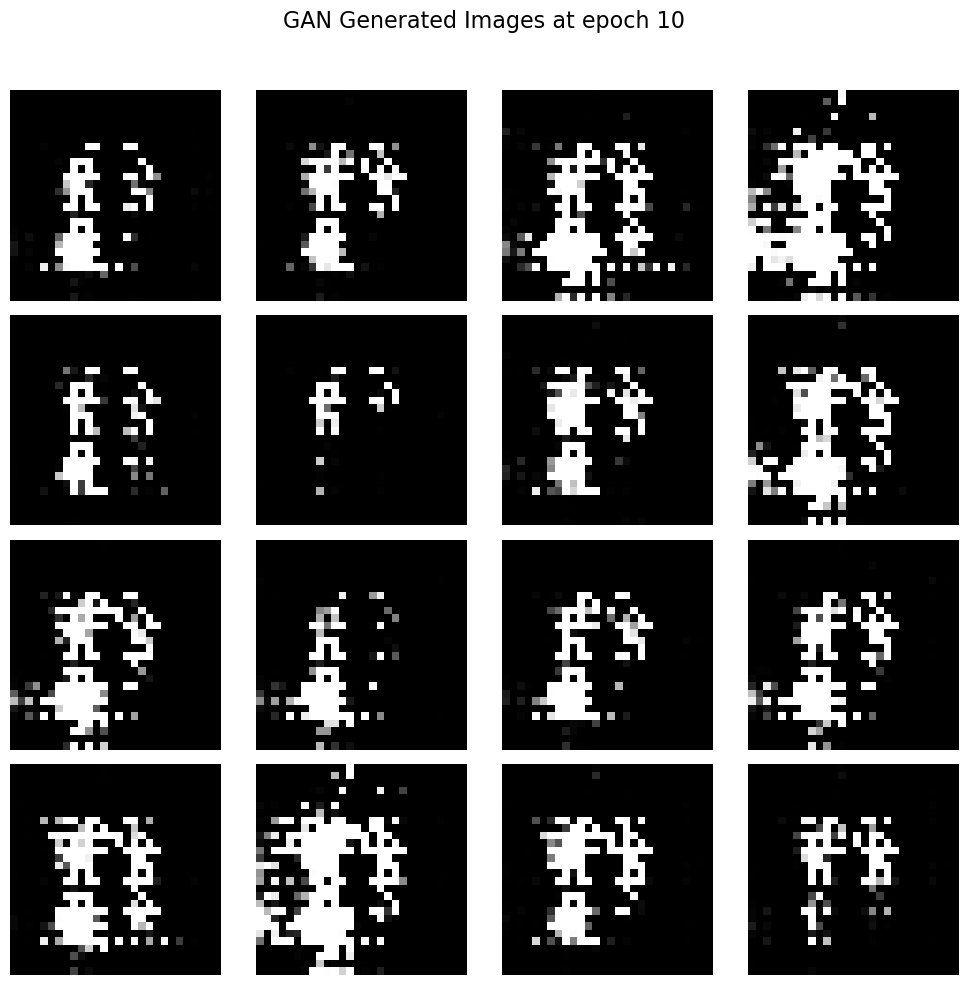

Epoch [11/200]:
epoch_d_loss: 0.361881 	epoch_g_loss: 2.643017
Epoch [12/200]:
epoch_d_loss: 0.199535 	epoch_g_loss: 2.972458
Epoch [13/200]:
epoch_d_loss: 0.145556 	epoch_g_loss: 3.449676
Epoch [14/200]:
epoch_d_loss: 0.156795 	epoch_g_loss: 3.534441
Epoch [15/200]:
epoch_d_loss: 0.323495 	epoch_g_loss: 3.347721
Epoch [16/200]:
epoch_d_loss: 0.199290 	epoch_g_loss: 3.177618
Epoch [17/200]:
epoch_d_loss: 0.171863 	epoch_g_loss: 3.464900
Epoch [18/200]:
epoch_d_loss: 0.101943 	epoch_g_loss: 3.714374
Epoch [19/200]:
epoch_d_loss: 0.135490 	epoch_g_loss: 3.889566
Epoch [20/200]:
epoch_d_loss: 0.181855 	epoch_g_loss: 3.737021


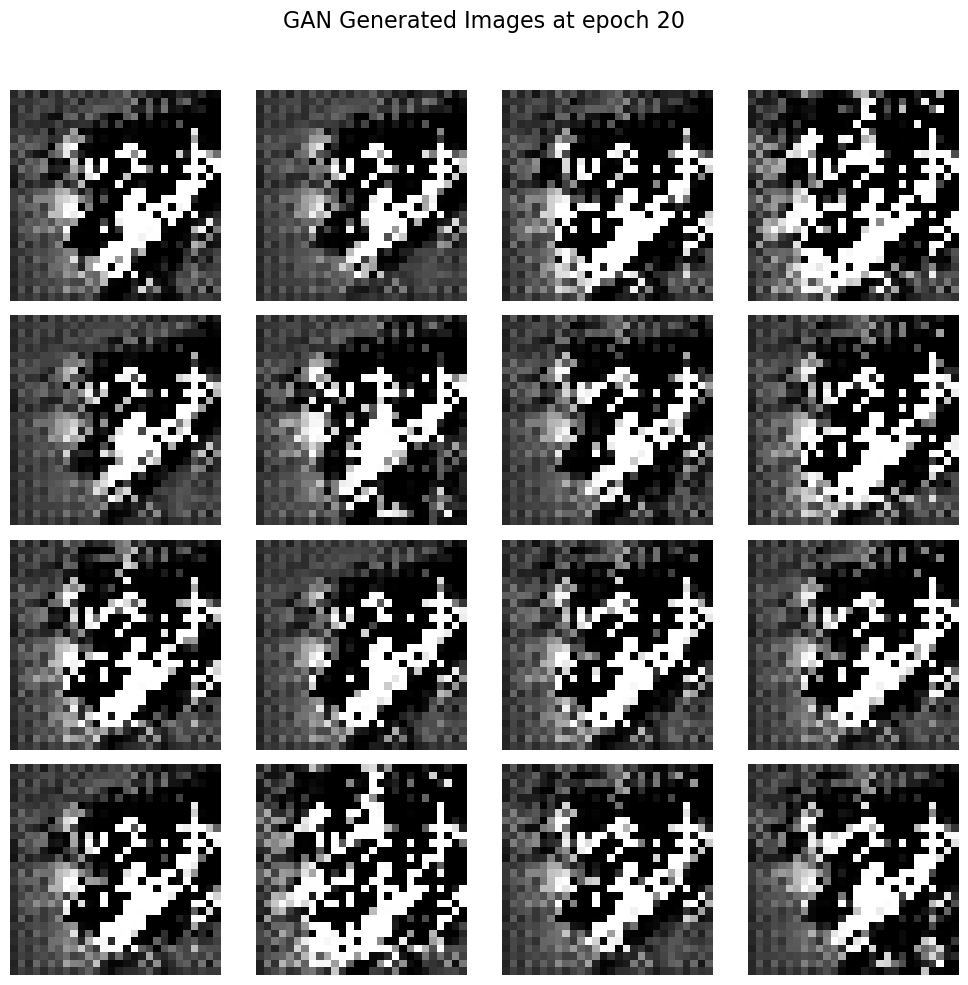

Epoch [21/200]:
epoch_d_loss: 0.158512 	epoch_g_loss: 4.011509
Epoch [22/200]:
epoch_d_loss: 0.269841 	epoch_g_loss: 3.744729
Epoch [23/200]:
epoch_d_loss: 0.488970 	epoch_g_loss: 3.388056
Epoch [24/200]:
epoch_d_loss: 0.649806 	epoch_g_loss: 2.467406
Epoch [25/200]:
epoch_d_loss: 0.319382 	epoch_g_loss: 2.959061
Epoch [26/200]:
epoch_d_loss: 0.209070 	epoch_g_loss: 3.007411
Epoch [27/200]:
epoch_d_loss: 0.187483 	epoch_g_loss: 3.091995
Epoch [28/200]:
epoch_d_loss: 0.211424 	epoch_g_loss: 3.194657
Epoch [29/200]:
epoch_d_loss: 0.730644 	epoch_g_loss: 2.733967
Epoch [30/200]:
epoch_d_loss: 0.846089 	epoch_g_loss: 2.332790


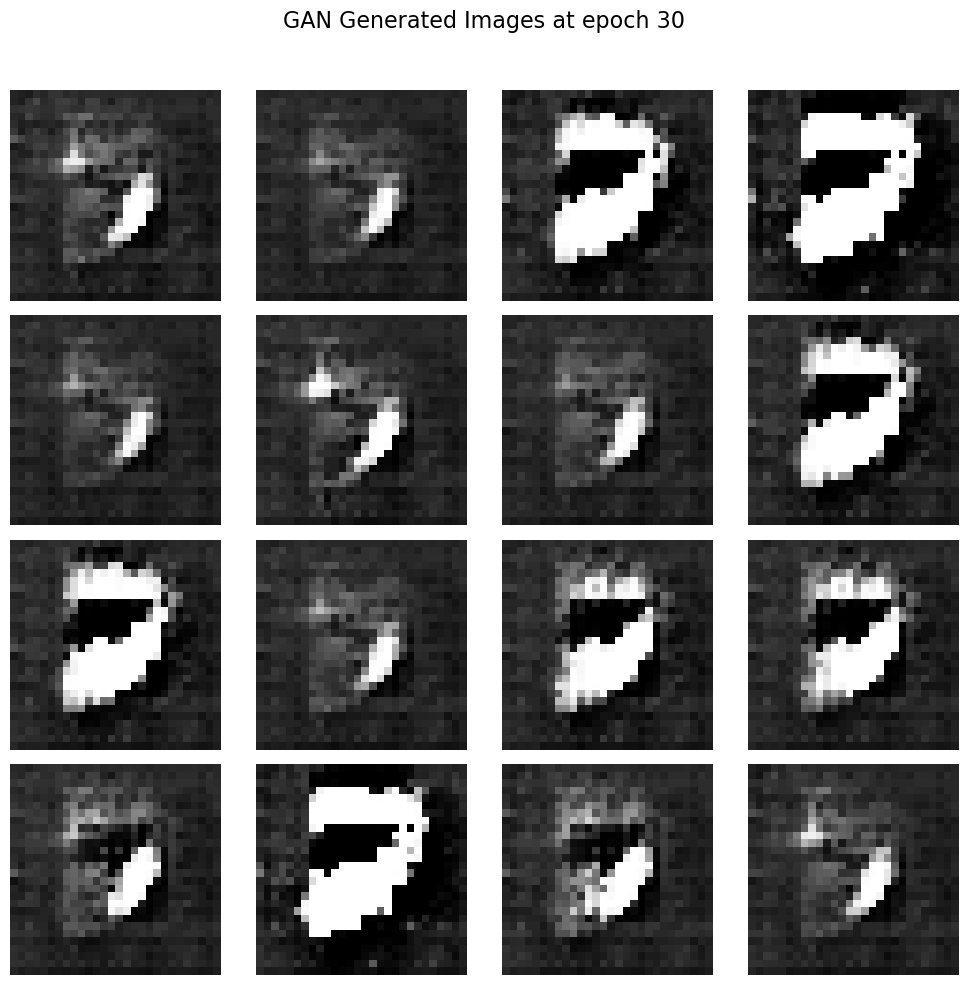

Epoch [31/200]:
epoch_d_loss: 0.505742 	epoch_g_loss: 2.339358
Epoch [32/200]:
epoch_d_loss: 0.484522 	epoch_g_loss: 2.365609
Epoch [33/200]:
epoch_d_loss: 0.352467 	epoch_g_loss: 2.484304
Epoch [34/200]:
epoch_d_loss: 0.538142 	epoch_g_loss: 2.496775
Epoch [35/200]:
epoch_d_loss: 0.853806 	epoch_g_loss: 2.251683
Epoch [36/200]:
epoch_d_loss: 0.418505 	epoch_g_loss: 2.465048
Epoch [37/200]:
epoch_d_loss: 0.438489 	epoch_g_loss: 2.630112
Epoch [38/200]:
epoch_d_loss: 0.459127 	epoch_g_loss: 2.512777
Epoch [39/200]:
epoch_d_loss: 0.721291 	epoch_g_loss: 2.258031
Epoch [40/200]:
epoch_d_loss: 0.597463 	epoch_g_loss: 2.388091


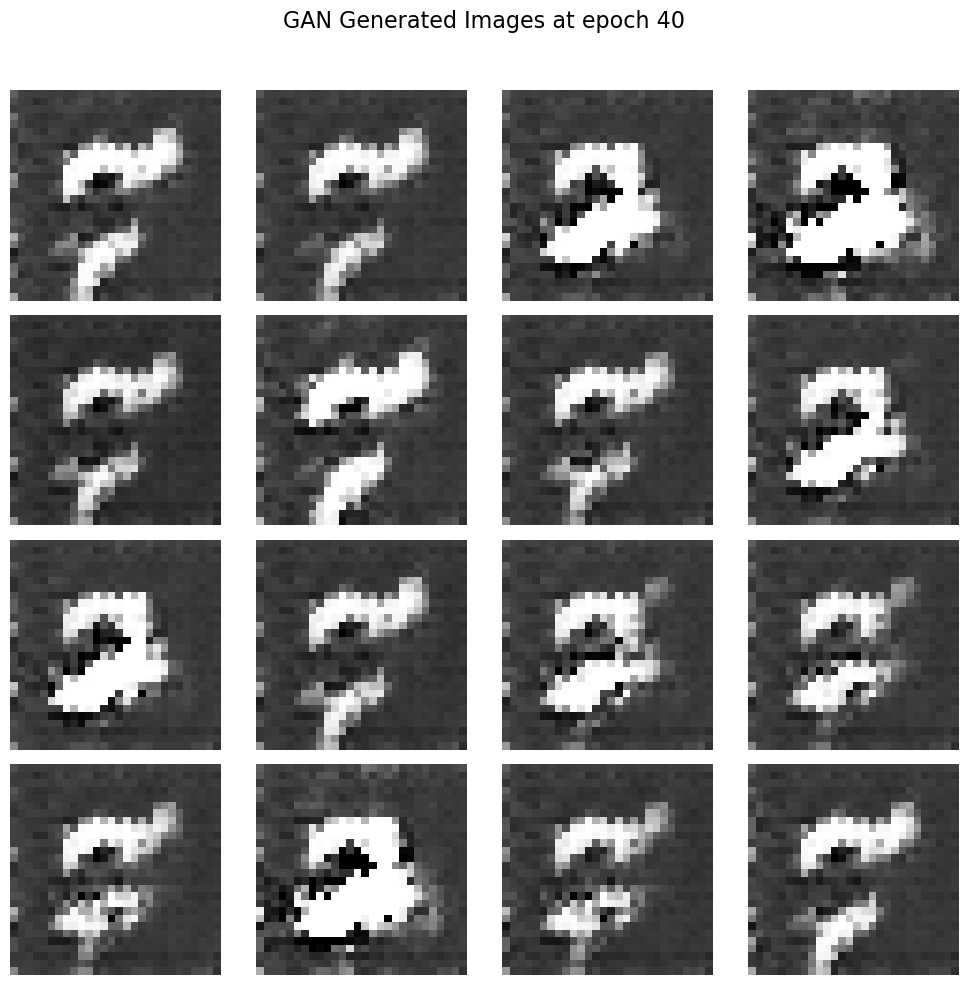

Epoch [41/200]:
epoch_d_loss: 0.519328 	epoch_g_loss: 2.510607
Epoch [42/200]:
epoch_d_loss: 0.456974 	epoch_g_loss: 2.372730
Epoch [43/200]:
epoch_d_loss: 0.469616 	epoch_g_loss: 2.483981
Epoch [44/200]:
epoch_d_loss: 0.891498 	epoch_g_loss: 2.144497
Epoch [45/200]:
epoch_d_loss: 0.340077 	epoch_g_loss: 2.449734
Epoch [46/200]:
epoch_d_loss: 0.265223 	epoch_g_loss: 2.653834
Epoch [47/200]:
epoch_d_loss: 0.441811 	epoch_g_loss: 2.476205
Epoch [48/200]:
epoch_d_loss: 0.444991 	epoch_g_loss: 2.329928
Epoch [49/200]:
epoch_d_loss: 0.474074 	epoch_g_loss: 2.474760
Epoch [50/200]:
epoch_d_loss: 0.423219 	epoch_g_loss: 2.575588


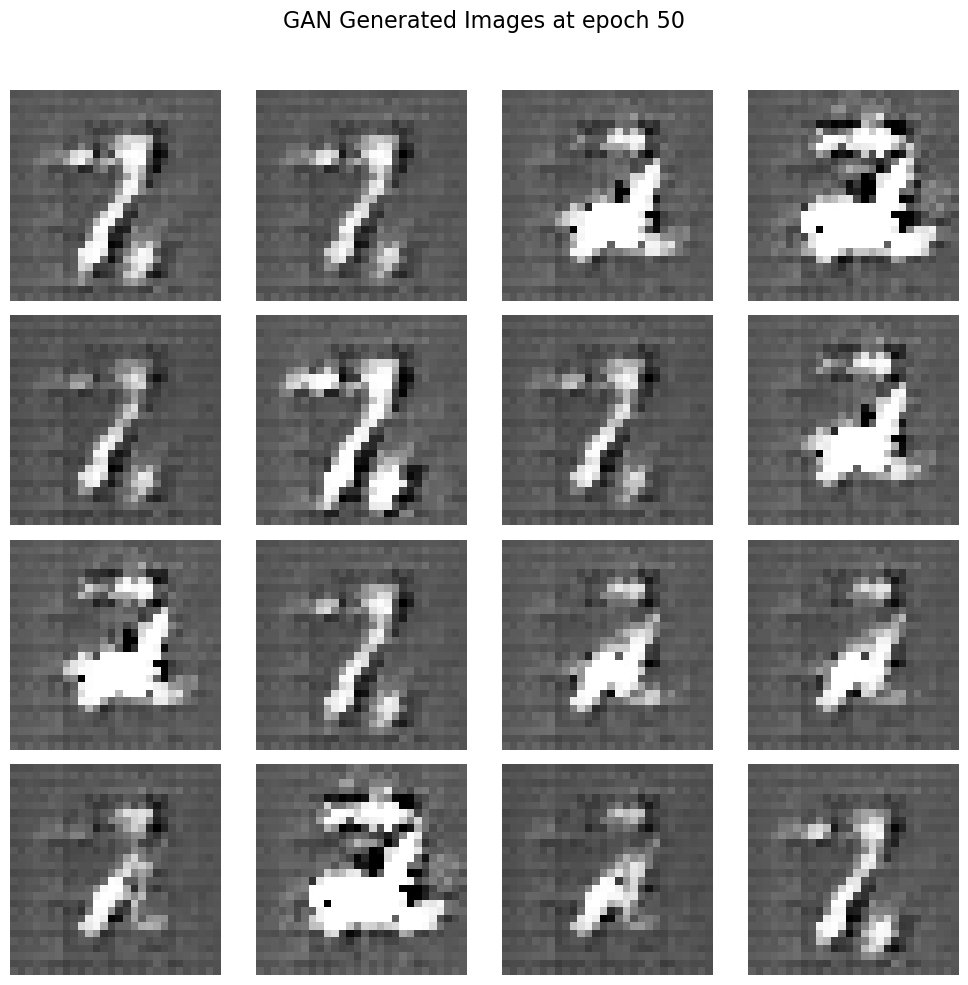

Epoch [51/200]:
epoch_d_loss: 0.445969 	epoch_g_loss: 2.461492
Epoch [52/200]:
epoch_d_loss: 0.498342 	epoch_g_loss: 2.434113
Epoch [53/200]:
epoch_d_loss: 0.578245 	epoch_g_loss: 2.598862
Epoch [54/200]:
epoch_d_loss: 0.417786 	epoch_g_loss: 2.580490
Epoch [55/200]:
epoch_d_loss: 0.405660 	epoch_g_loss: 2.806509
Epoch [56/200]:
epoch_d_loss: 0.375350 	epoch_g_loss: 2.537347
Epoch [57/200]:
epoch_d_loss: 0.715408 	epoch_g_loss: 2.454393
Epoch [58/200]:
epoch_d_loss: 0.682183 	epoch_g_loss: 2.417051
Epoch [59/200]:
epoch_d_loss: 0.440023 	epoch_g_loss: 2.495508
Epoch [60/200]:
epoch_d_loss: 0.603792 	epoch_g_loss: 2.589422


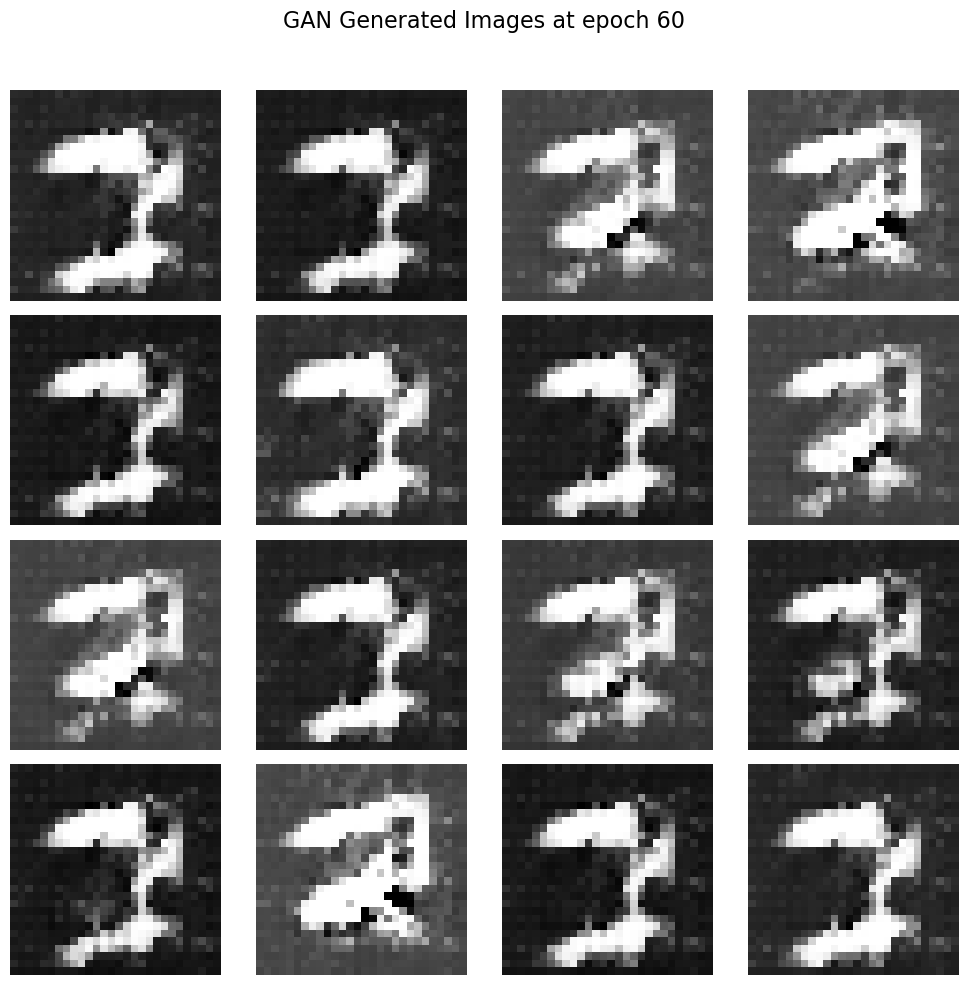

Epoch [61/200]:
epoch_d_loss: 0.301847 	epoch_g_loss: 2.594465
Epoch [62/200]:
epoch_d_loss: 0.383299 	epoch_g_loss: 2.432683
Epoch [63/200]:
epoch_d_loss: 0.486962 	epoch_g_loss: 2.366943
Epoch [64/200]:
epoch_d_loss: 0.555590 	epoch_g_loss: 2.611835
Epoch [65/200]:
epoch_d_loss: 0.846656 	epoch_g_loss: 2.301537
Epoch [66/200]:
epoch_d_loss: 0.469973 	epoch_g_loss: 2.366388
Epoch [67/200]:
epoch_d_loss: 0.467078 	epoch_g_loss: 2.416567
Epoch [68/200]:
epoch_d_loss: 0.349573 	epoch_g_loss: 2.847225
Epoch [69/200]:
epoch_d_loss: 0.264781 	epoch_g_loss: 3.025910
Epoch [70/200]:
epoch_d_loss: 0.143709 	epoch_g_loss: 3.189047


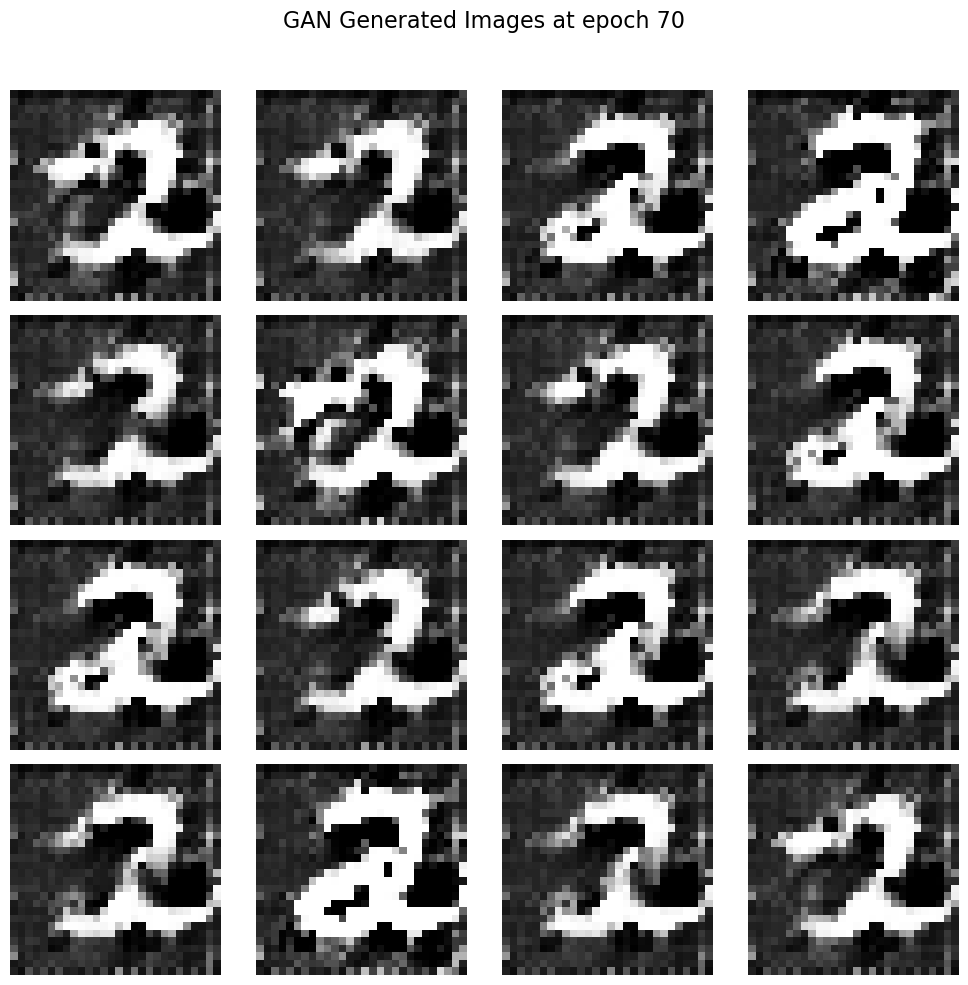

Epoch [71/200]:
epoch_d_loss: 0.168939 	epoch_g_loss: 3.174441
Epoch [72/200]:
epoch_d_loss: 0.224162 	epoch_g_loss: 3.000465
Epoch [73/200]:
epoch_d_loss: 0.435913 	epoch_g_loss: 2.650929
Epoch [74/200]:
epoch_d_loss: 0.498722 	epoch_g_loss: 2.701358
Epoch [75/200]:
epoch_d_loss: 0.559825 	epoch_g_loss: 2.721824
Epoch [76/200]:
epoch_d_loss: 0.407720 	epoch_g_loss: 2.581609
Epoch [77/200]:
epoch_d_loss: 0.482868 	epoch_g_loss: 2.607372
Epoch [78/200]:
epoch_d_loss: 0.483471 	epoch_g_loss: 2.437872
Epoch [79/200]:
epoch_d_loss: 0.470810 	epoch_g_loss: 2.509979
Epoch [80/200]:
epoch_d_loss: 0.433303 	epoch_g_loss: 2.616606


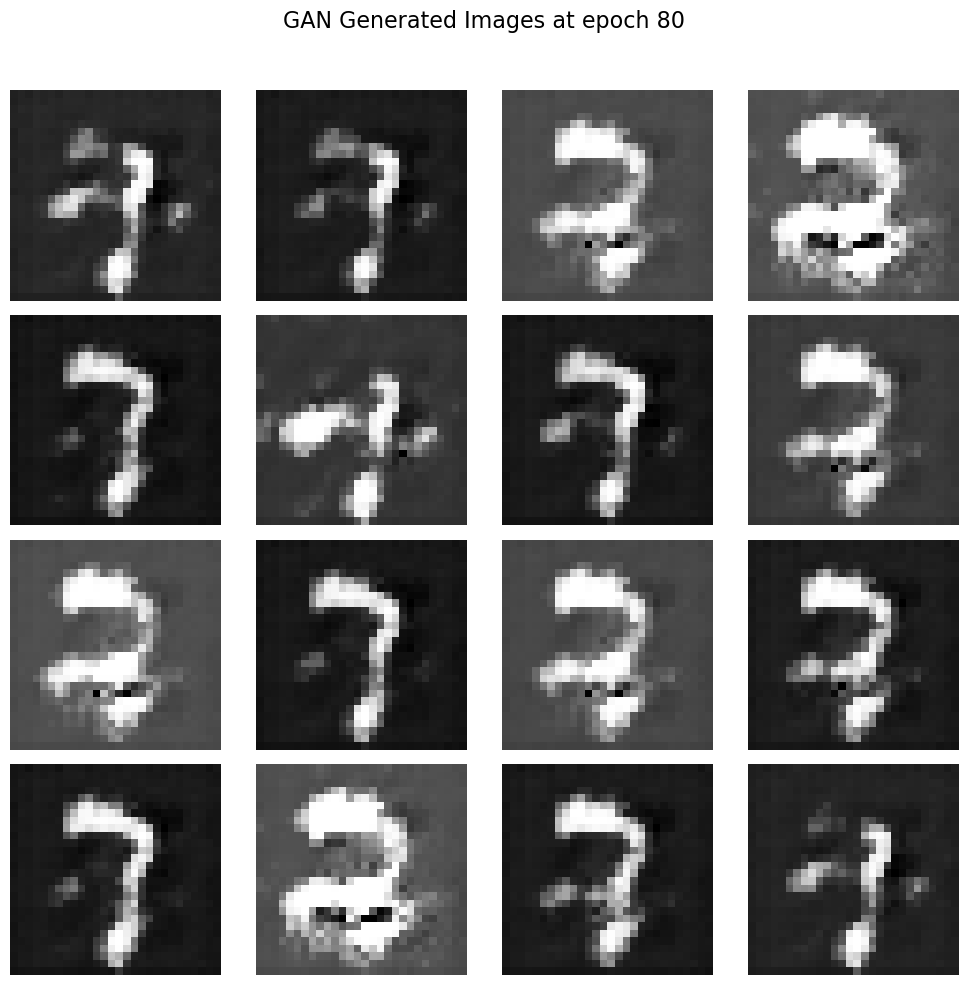

Epoch [81/200]:
epoch_d_loss: 0.485050 	epoch_g_loss: 2.597566
Epoch [82/200]:
epoch_d_loss: 0.513769 	epoch_g_loss: 2.411889
Epoch [83/200]:
epoch_d_loss: 0.672388 	epoch_g_loss: 2.579094
Epoch [84/200]:
epoch_d_loss: 0.563582 	epoch_g_loss: 2.399131
Epoch [85/200]:
epoch_d_loss: 0.551894 	epoch_g_loss: 2.311537
Epoch [86/200]:
epoch_d_loss: 0.502562 	epoch_g_loss: 2.583963
Epoch [87/200]:
epoch_d_loss: 0.564606 	epoch_g_loss: 2.332540
Epoch [88/200]:
epoch_d_loss: 0.459815 	epoch_g_loss: 2.445909
Epoch [89/200]:
epoch_d_loss: 0.412030 	epoch_g_loss: 2.442431
Epoch [90/200]:
epoch_d_loss: 0.367586 	epoch_g_loss: 2.797579


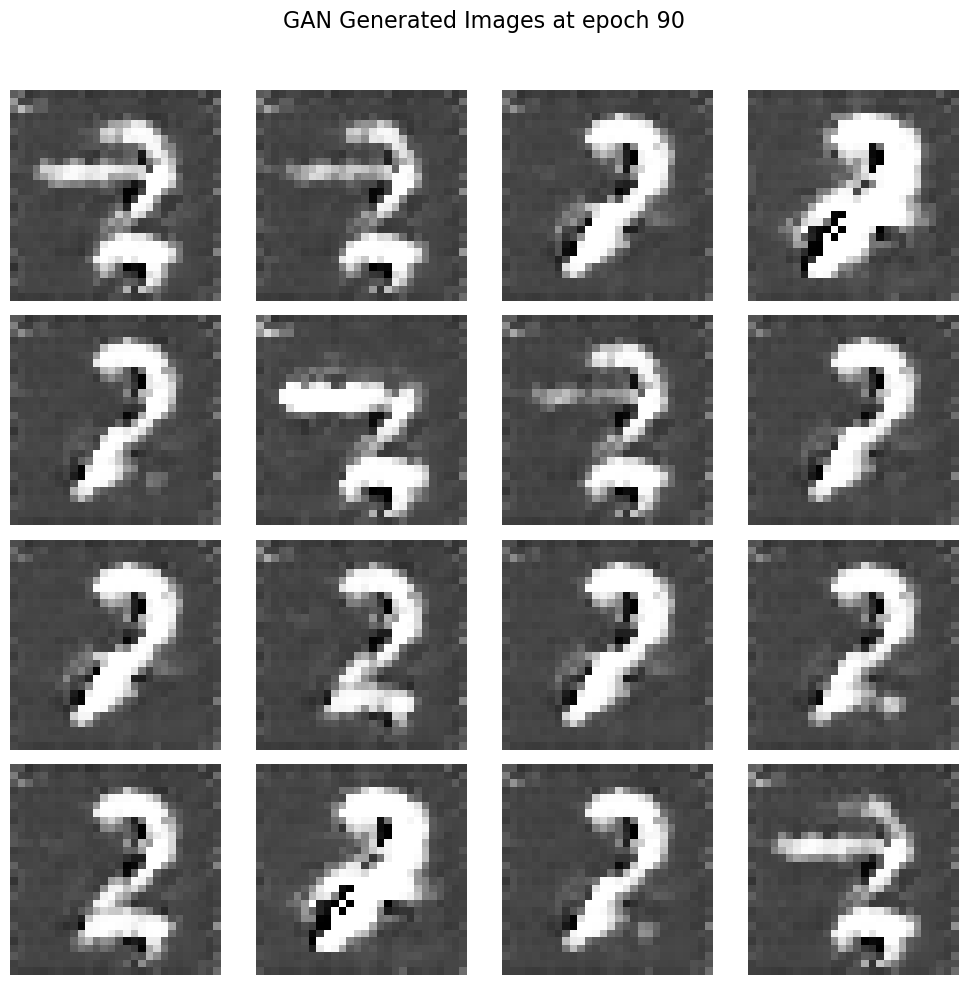

Epoch [91/200]:
epoch_d_loss: 0.289491 	epoch_g_loss: 2.557852
Epoch [92/200]:
epoch_d_loss: 0.490787 	epoch_g_loss: 2.562579
Epoch [93/200]:
epoch_d_loss: 0.507191 	epoch_g_loss: 2.521737
Epoch [94/200]:
epoch_d_loss: 0.508248 	epoch_g_loss: 2.756846
Epoch [95/200]:
epoch_d_loss: 0.531084 	epoch_g_loss: 2.427832
Epoch [96/200]:
epoch_d_loss: 0.446500 	epoch_g_loss: 2.495003
Epoch [97/200]:
epoch_d_loss: 0.332835 	epoch_g_loss: 2.619338
Epoch [98/200]:
epoch_d_loss: 0.243252 	epoch_g_loss: 2.644442
Epoch [99/200]:
epoch_d_loss: 0.411405 	epoch_g_loss: 2.560873
Epoch [100/200]:
epoch_d_loss: 0.506124 	epoch_g_loss: 2.467043


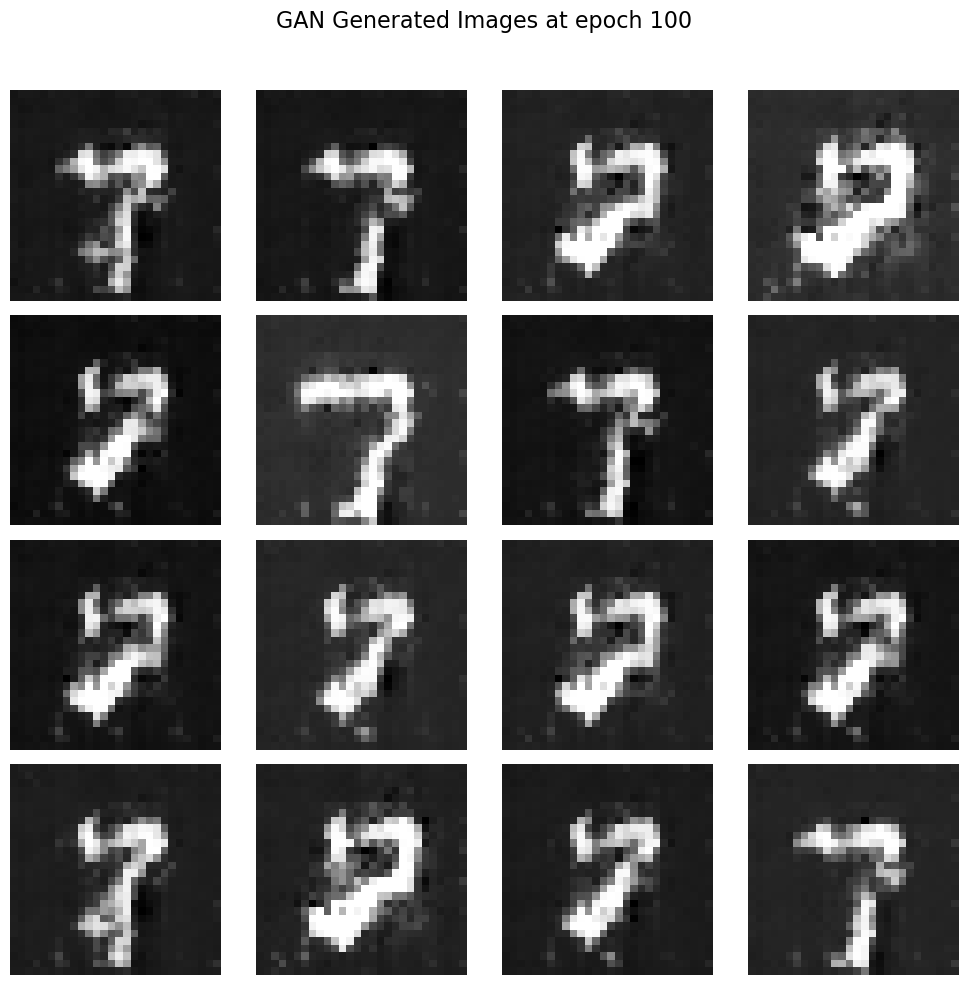

Epoch [101/200]:
epoch_d_loss: 0.535278 	epoch_g_loss: 2.458152
Epoch [102/200]:
epoch_d_loss: 0.495691 	epoch_g_loss: 2.480007
Epoch [103/200]:
epoch_d_loss: 0.643572 	epoch_g_loss: 2.232776
Epoch [104/200]:
epoch_d_loss: 0.594162 	epoch_g_loss: 2.358063
Epoch [105/200]:
epoch_d_loss: 0.450111 	epoch_g_loss: 2.578746
Epoch [106/200]:
epoch_d_loss: 0.486345 	epoch_g_loss: 2.490049
Epoch [107/200]:
epoch_d_loss: 0.558922 	epoch_g_loss: 2.643263
Epoch [108/200]:
epoch_d_loss: 0.375311 	epoch_g_loss: 2.666168
Epoch [109/200]:
epoch_d_loss: 0.354692 	epoch_g_loss: 2.546740
Epoch [110/200]:
epoch_d_loss: 0.675282 	epoch_g_loss: 2.490119


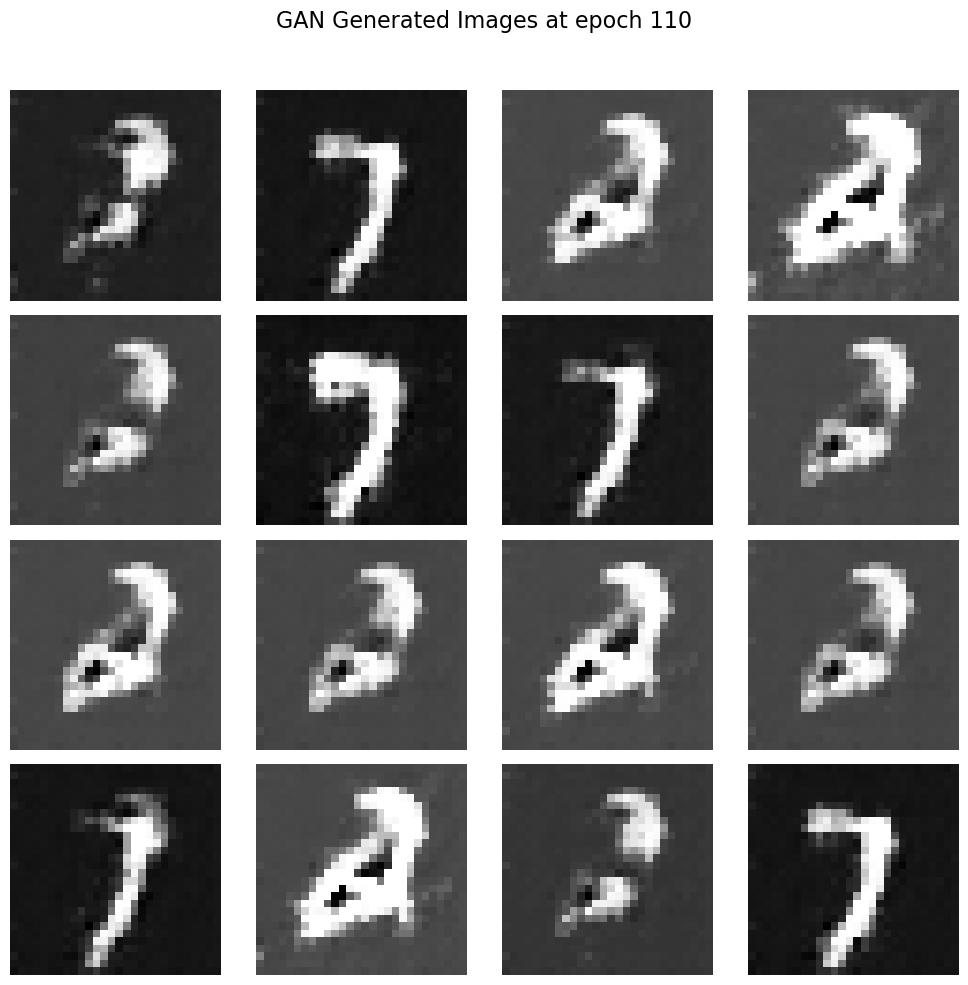

Epoch [111/200]:
epoch_d_loss: 0.414577 	epoch_g_loss: 2.569218
Epoch [112/200]:
epoch_d_loss: 0.309775 	epoch_g_loss: 2.689883
Epoch [113/200]:
epoch_d_loss: 0.422178 	epoch_g_loss: 2.734309
Epoch [114/200]:
epoch_d_loss: 0.293855 	epoch_g_loss: 2.574252
Epoch [115/200]:
epoch_d_loss: 0.503829 	epoch_g_loss: 2.445720
Epoch [116/200]:
epoch_d_loss: 0.580917 	epoch_g_loss: 2.243765
Epoch [117/200]:
epoch_d_loss: 0.799153 	epoch_g_loss: 2.423463
Epoch [118/200]:
epoch_d_loss: 0.613686 	epoch_g_loss: 2.260364
Epoch [119/200]:
epoch_d_loss: 0.714888 	epoch_g_loss: 2.494731
Epoch [120/200]:
epoch_d_loss: 0.343919 	epoch_g_loss: 2.617762


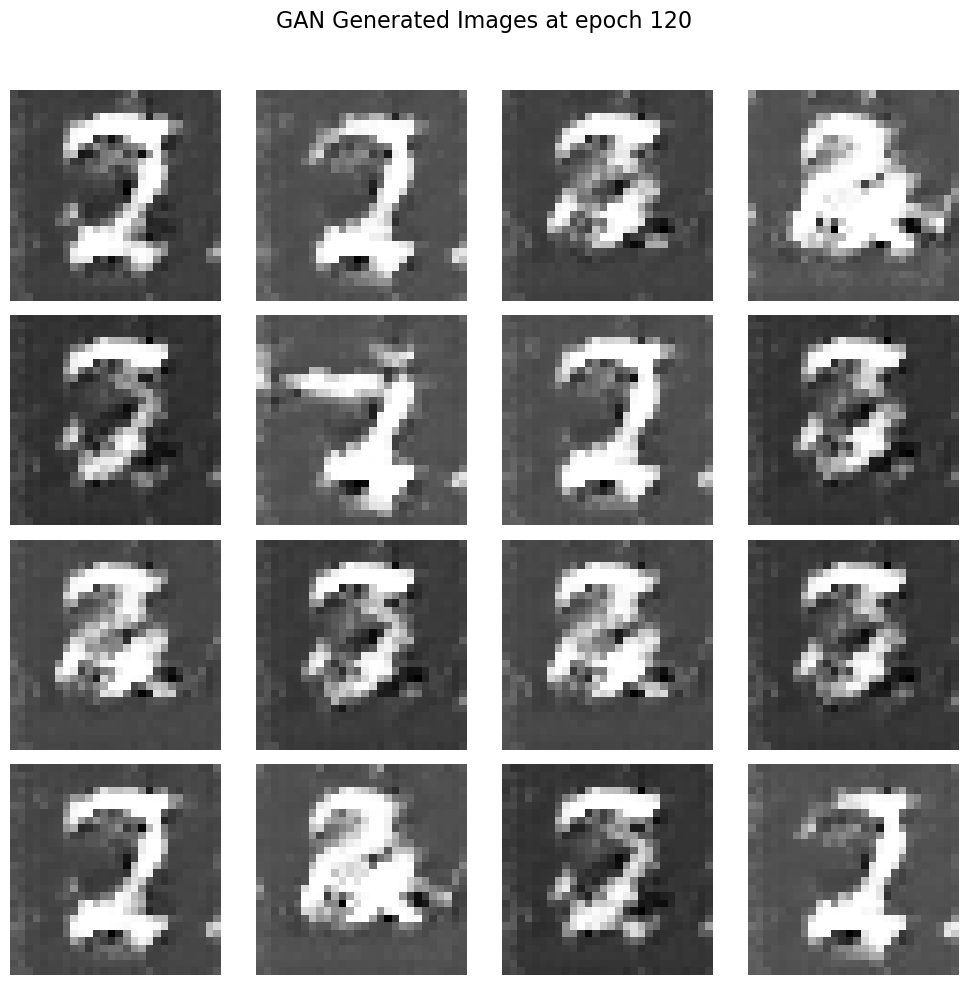

Epoch [121/200]:
epoch_d_loss: 0.445559 	epoch_g_loss: 2.573485
Epoch [122/200]:
epoch_d_loss: 0.308256 	epoch_g_loss: 2.589370
Epoch [123/200]:
epoch_d_loss: 0.580107 	epoch_g_loss: 2.369945
Epoch [124/200]:
epoch_d_loss: 0.516796 	epoch_g_loss: 2.277704
Epoch [125/200]:
epoch_d_loss: 0.548684 	epoch_g_loss: 2.344833
Epoch [126/200]:
epoch_d_loss: 0.402777 	epoch_g_loss: 2.497561
Epoch [127/200]:
epoch_d_loss: 0.380401 	epoch_g_loss: 2.392900
Epoch [128/200]:
epoch_d_loss: 0.567391 	epoch_g_loss: 2.448227
Epoch [129/200]:
epoch_d_loss: 0.804258 	epoch_g_loss: 2.414308
Epoch [130/200]:
epoch_d_loss: 0.784155 	epoch_g_loss: 2.179841


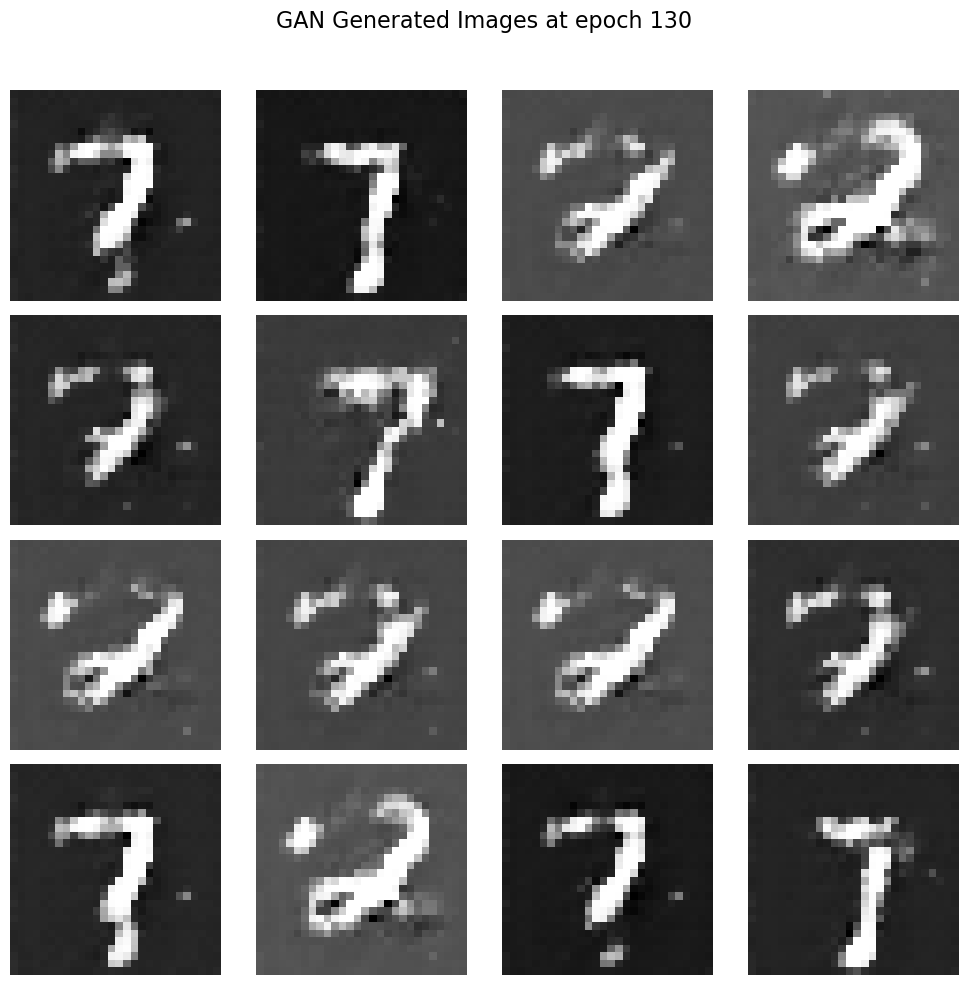

Epoch [131/200]:
epoch_d_loss: 0.719285 	epoch_g_loss: 2.158000
Epoch [132/200]:
epoch_d_loss: 0.540051 	epoch_g_loss: 2.203396
Epoch [133/200]:
epoch_d_loss: 0.480949 	epoch_g_loss: 2.344043
Epoch [134/200]:
epoch_d_loss: 0.382890 	epoch_g_loss: 2.453127
Epoch [135/200]:
epoch_d_loss: 0.418033 	epoch_g_loss: 2.493785
Epoch [136/200]:
epoch_d_loss: 0.410737 	epoch_g_loss: 2.603194
Epoch [137/200]:
epoch_d_loss: 0.461234 	epoch_g_loss: 2.362283
Epoch [138/200]:
epoch_d_loss: 0.703174 	epoch_g_loss: 2.154429
Epoch [139/200]:
epoch_d_loss: 0.683349 	epoch_g_loss: 2.165237
Epoch [140/200]:
epoch_d_loss: 0.548631 	epoch_g_loss: 2.136880


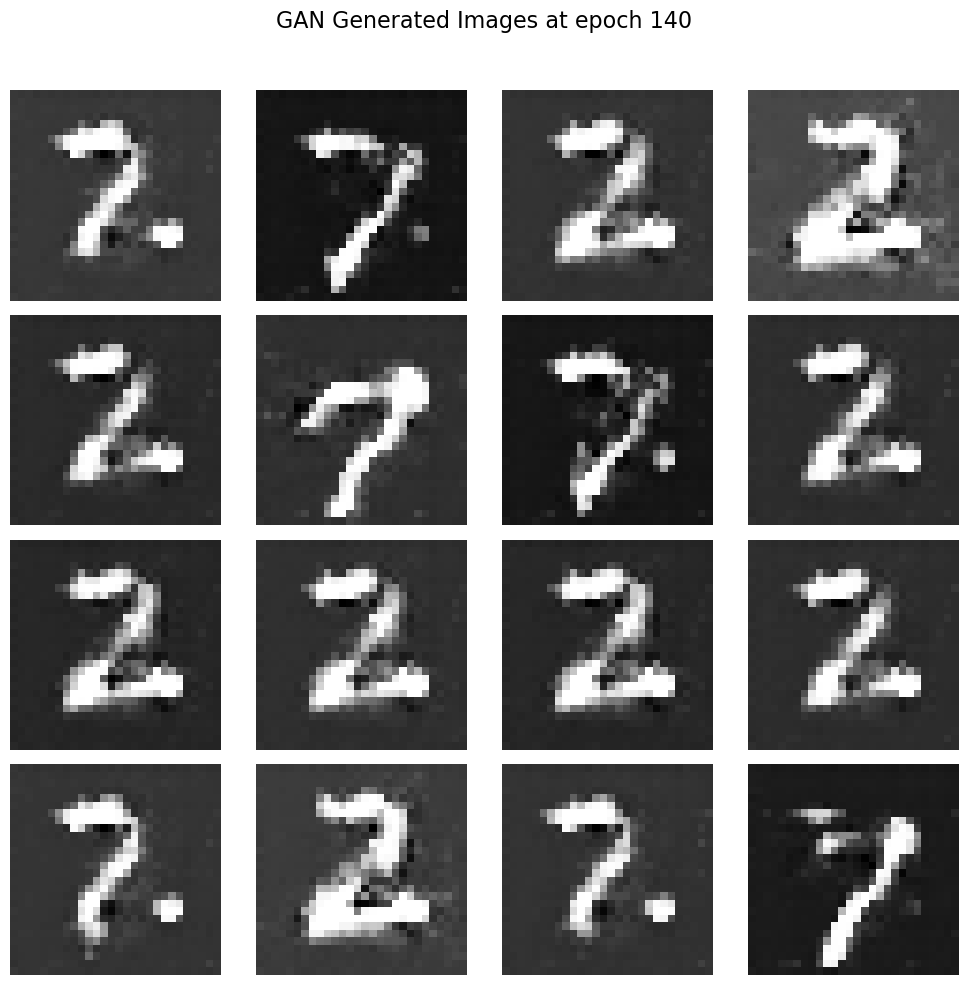

Epoch [141/200]:
epoch_d_loss: 0.731070 	epoch_g_loss: 2.206807
Epoch [142/200]:
epoch_d_loss: 0.544521 	epoch_g_loss: 2.237972
Epoch [143/200]:
epoch_d_loss: 0.767398 	epoch_g_loss: 2.117722
Epoch [144/200]:
epoch_d_loss: 0.634747 	epoch_g_loss: 2.319915
Epoch [145/200]:
epoch_d_loss: 0.482365 	epoch_g_loss: 2.415734
Epoch [146/200]:
epoch_d_loss: 0.494504 	epoch_g_loss: 2.226831
Epoch [147/200]:
epoch_d_loss: 0.624349 	epoch_g_loss: 2.248833
Epoch [148/200]:
epoch_d_loss: 0.593387 	epoch_g_loss: 2.129256
Epoch [149/200]:
epoch_d_loss: 0.727013 	epoch_g_loss: 2.138235
Epoch [150/200]:
epoch_d_loss: 0.452652 	epoch_g_loss: 2.274347


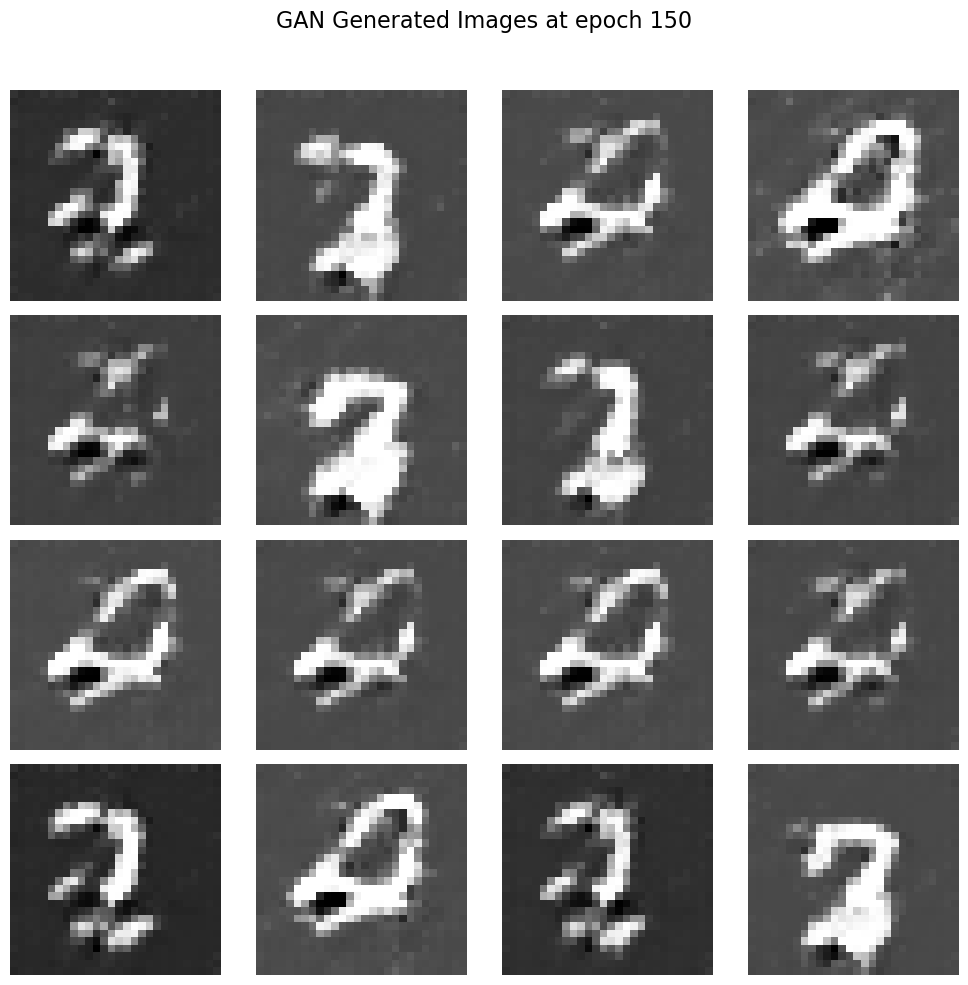

Epoch [151/200]:
epoch_d_loss: 0.407919 	epoch_g_loss: 2.490755
Epoch [152/200]:
epoch_d_loss: 0.392710 	epoch_g_loss: 2.335256
Epoch [153/200]:
epoch_d_loss: 0.530850 	epoch_g_loss: 2.270038
Epoch [154/200]:
epoch_d_loss: 0.564966 	epoch_g_loss: 2.197566
Epoch [155/200]:
epoch_d_loss: 0.577148 	epoch_g_loss: 2.262186
Epoch [156/200]:
epoch_d_loss: 0.438390 	epoch_g_loss: 2.343424
Epoch [157/200]:
epoch_d_loss: 0.563655 	epoch_g_loss: 2.194515
Epoch [158/200]:
epoch_d_loss: 0.531382 	epoch_g_loss: 2.329614
Epoch [159/200]:
epoch_d_loss: 0.495259 	epoch_g_loss: 2.192238
Epoch [160/200]:
epoch_d_loss: 0.696299 	epoch_g_loss: 2.177659


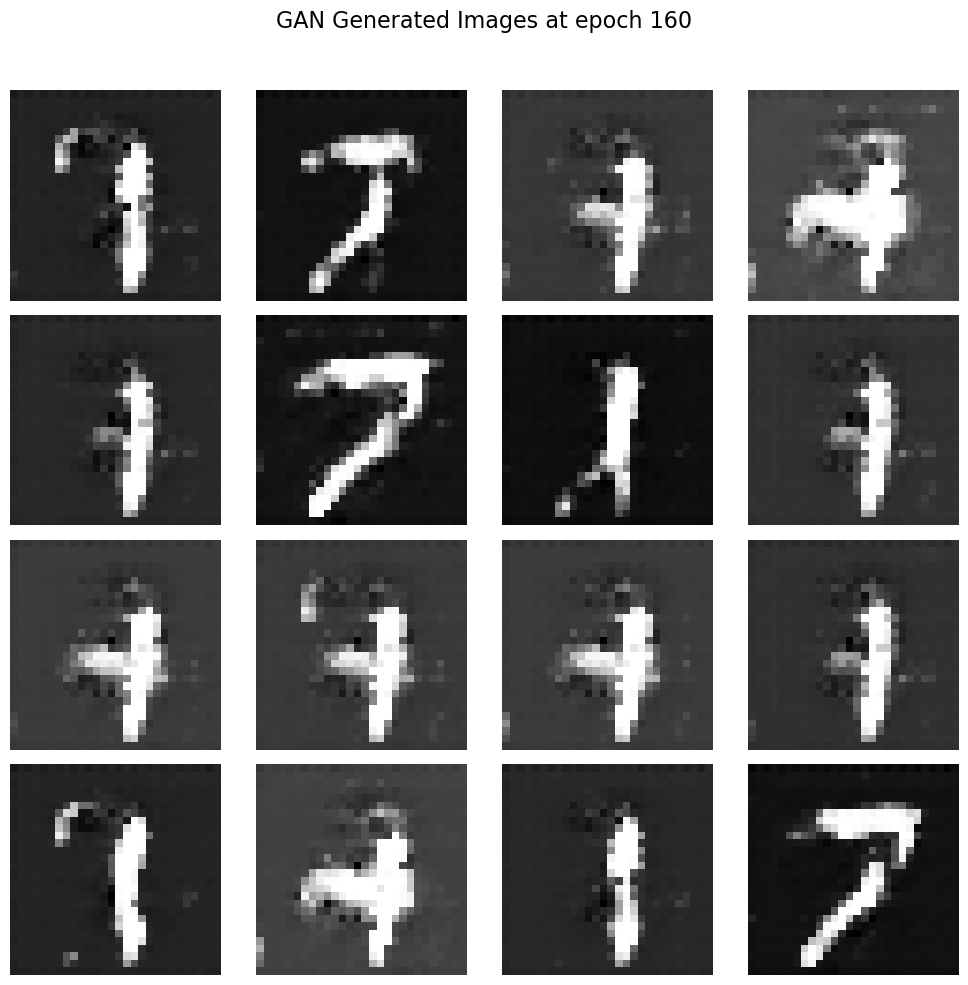

Epoch [161/200]:
epoch_d_loss: 0.531211 	epoch_g_loss: 2.200355
Epoch [162/200]:
epoch_d_loss: 0.737475 	epoch_g_loss: 2.174010
Epoch [163/200]:
epoch_d_loss: 0.483384 	epoch_g_loss: 2.284856
Epoch [164/200]:
epoch_d_loss: 0.676746 	epoch_g_loss: 2.215130
Epoch [165/200]:
epoch_d_loss: 0.560955 	epoch_g_loss: 2.193206
Epoch [166/200]:
epoch_d_loss: 0.587112 	epoch_g_loss: 2.158273
Epoch [167/200]:
epoch_d_loss: 0.449021 	epoch_g_loss: 2.331874
Epoch [168/200]:
epoch_d_loss: 0.356995 	epoch_g_loss: 2.499245
Epoch [169/200]:
epoch_d_loss: 0.455407 	epoch_g_loss: 2.454009
Epoch [170/200]:
epoch_d_loss: 0.475823 	epoch_g_loss: 2.246924


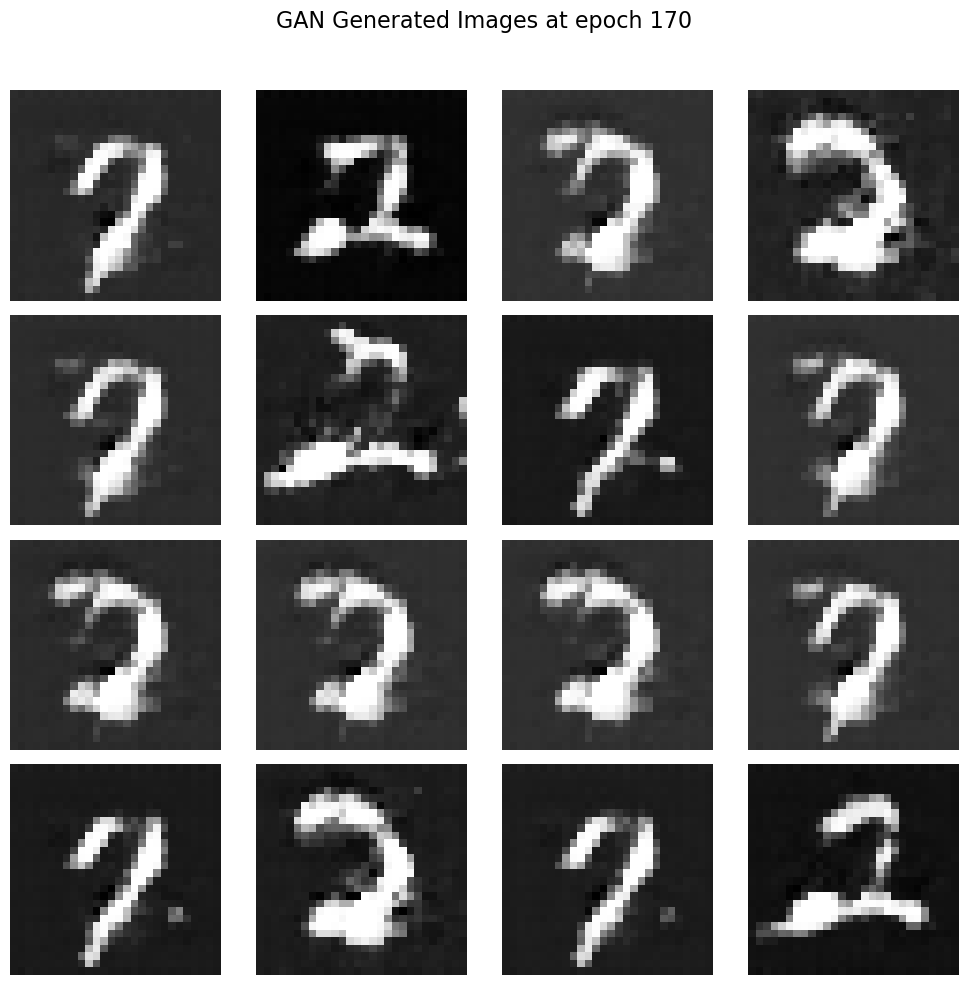

Epoch [171/200]:
epoch_d_loss: 0.769684 	epoch_g_loss: 2.335334
Epoch [172/200]:
epoch_d_loss: 0.697742 	epoch_g_loss: 2.100913
Epoch [173/200]:
epoch_d_loss: 0.631408 	epoch_g_loss: 2.266196
Epoch [174/200]:
epoch_d_loss: 0.698234 	epoch_g_loss: 1.922068
Epoch [175/200]:
epoch_d_loss: 0.978153 	epoch_g_loss: 2.033060
Epoch [176/200]:
epoch_d_loss: 0.592612 	epoch_g_loss: 2.038925
Epoch [177/200]:
epoch_d_loss: 0.727042 	epoch_g_loss: 2.062257
Epoch [178/200]:
epoch_d_loss: 0.811506 	epoch_g_loss: 1.816967
Epoch [179/200]:
epoch_d_loss: 0.983467 	epoch_g_loss: 1.896577
Epoch [180/200]:
epoch_d_loss: 0.964818 	epoch_g_loss: 1.804851


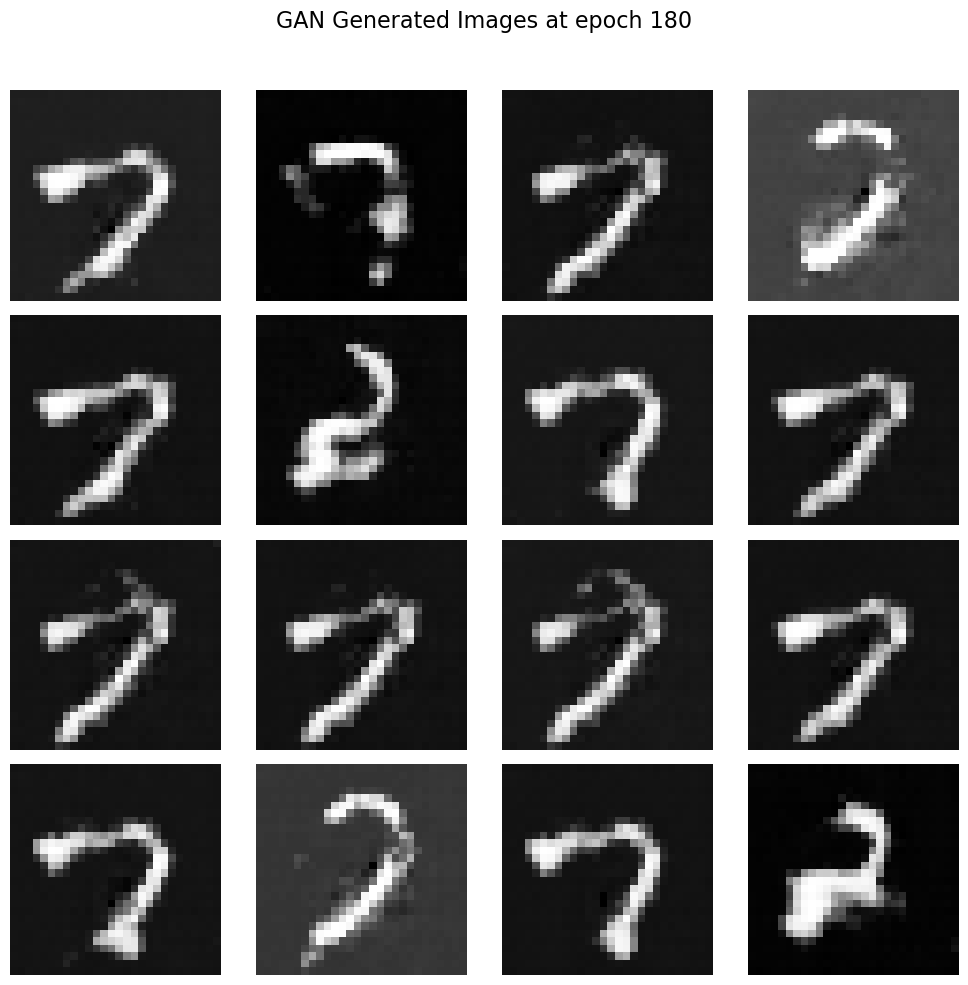

Epoch [181/200]:
epoch_d_loss: 0.945953 	epoch_g_loss: 1.780585
Epoch [182/200]:
epoch_d_loss: 0.865110 	epoch_g_loss: 1.960083
Epoch [183/200]:
epoch_d_loss: 0.594381 	epoch_g_loss: 2.006113
Epoch [184/200]:
epoch_d_loss: 0.727240 	epoch_g_loss: 1.986720
Epoch [185/200]:
epoch_d_loss: 0.645582 	epoch_g_loss: 2.036909
Epoch [186/200]:
epoch_d_loss: 0.607294 	epoch_g_loss: 2.082895
Epoch [187/200]:
epoch_d_loss: 0.520618 	epoch_g_loss: 2.089808
Epoch [188/200]:
epoch_d_loss: 0.677231 	epoch_g_loss: 1.951169
Epoch [189/200]:
epoch_d_loss: 0.751314 	epoch_g_loss: 1.994165
Epoch [190/200]:
epoch_d_loss: 0.719537 	epoch_g_loss: 1.989094


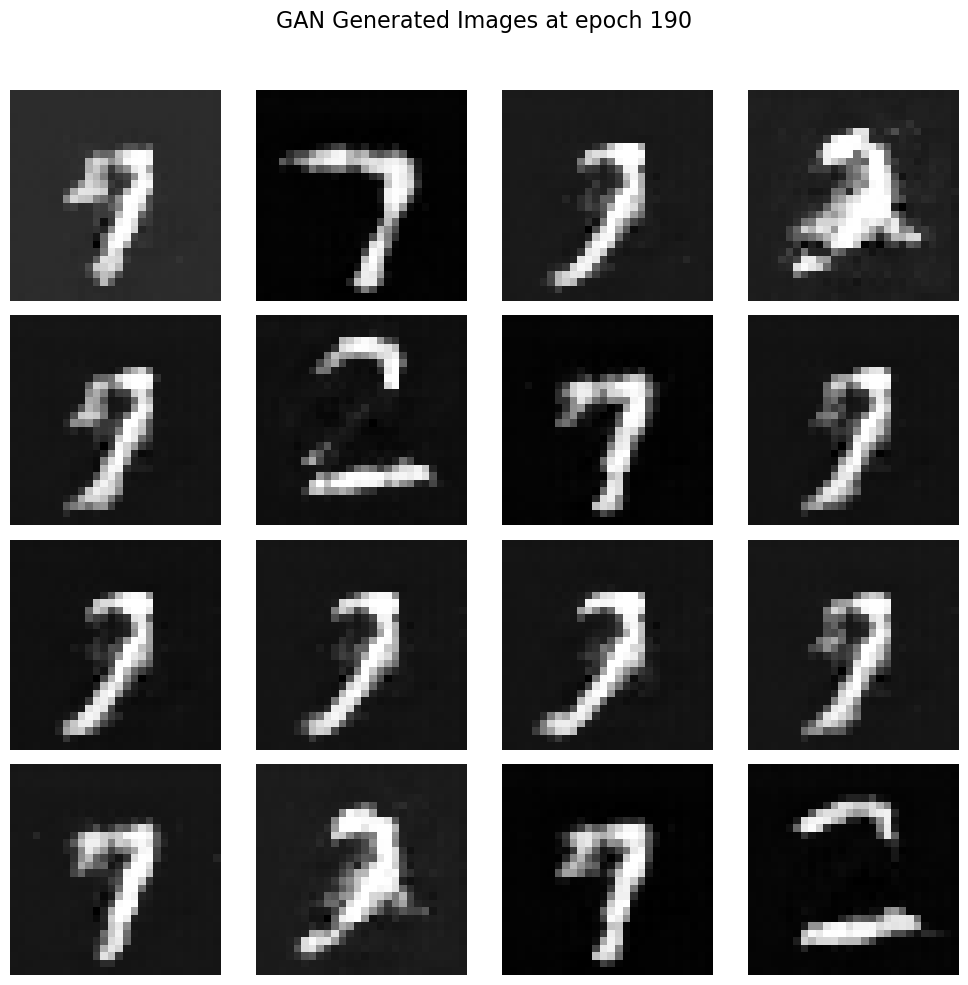

Epoch [191/200]:
epoch_d_loss: 0.582896 	epoch_g_loss: 2.198678
Epoch [192/200]:
epoch_d_loss: 0.568984 	epoch_g_loss: 1.999031
Epoch [193/200]:
epoch_d_loss: 0.621551 	epoch_g_loss: 2.096817
Epoch [194/200]:
epoch_d_loss: 0.657234 	epoch_g_loss: 1.891781
Epoch [195/200]:
epoch_d_loss: 0.770349 	epoch_g_loss: 2.069093
Epoch [196/200]:
epoch_d_loss: 0.610458 	epoch_g_loss: 2.066799
Epoch [197/200]:
epoch_d_loss: 0.633848 	epoch_g_loss: 2.049033
Epoch [198/200]:
epoch_d_loss: 0.571567 	epoch_g_loss: 2.134927
Epoch [199/200]:
epoch_d_loss: 0.555735 	epoch_g_loss: 2.301794
Epoch [200/200]:
epoch_d_loss: 0.507190 	epoch_g_loss: 2.251645


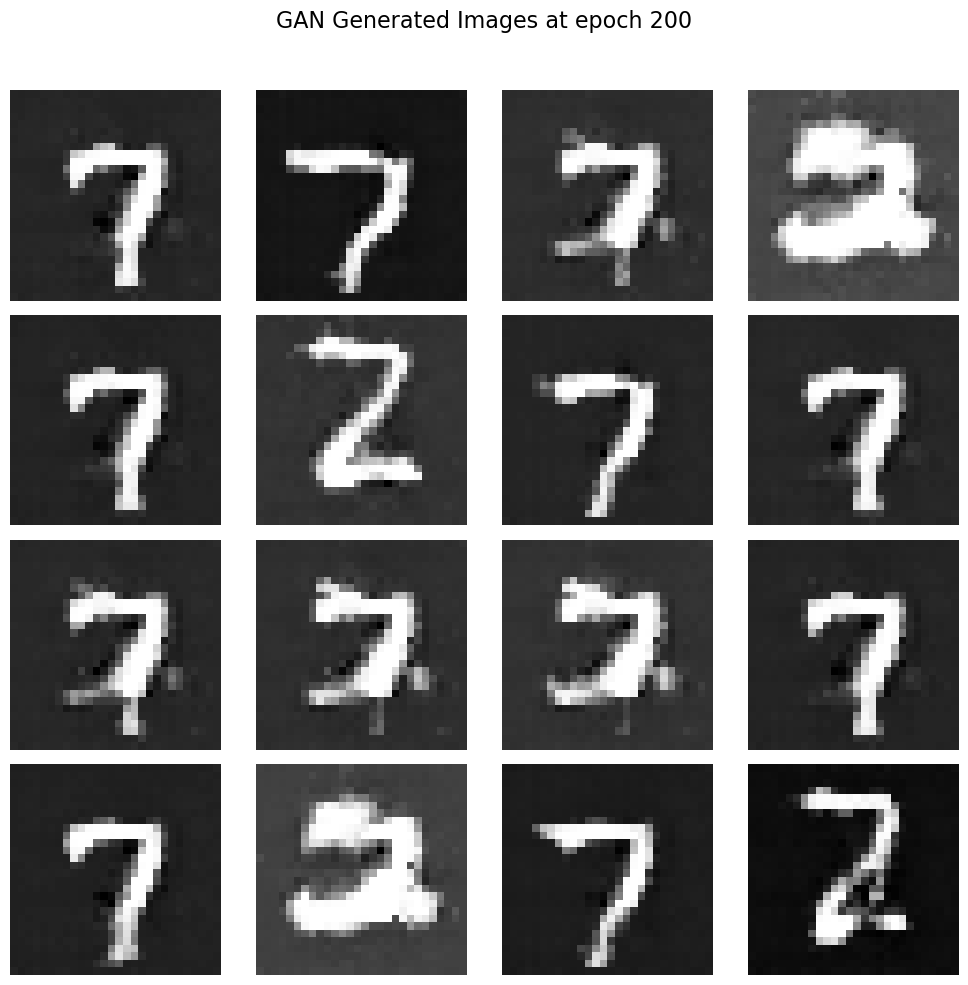

Time to train the generator on task  4   1247.5003299713135


In [16]:
agent.train(class_split)

In [18]:
acc_at_end_arr

array([[0.97731959, 0.50051546, 0.49948454, 0.49690722, 0.4943299 ],
       [0.        , 0.00100503, 0.00100503, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

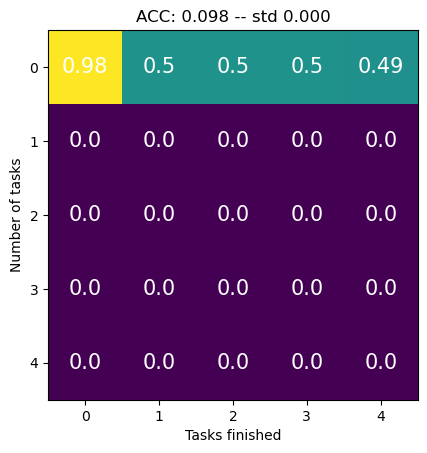

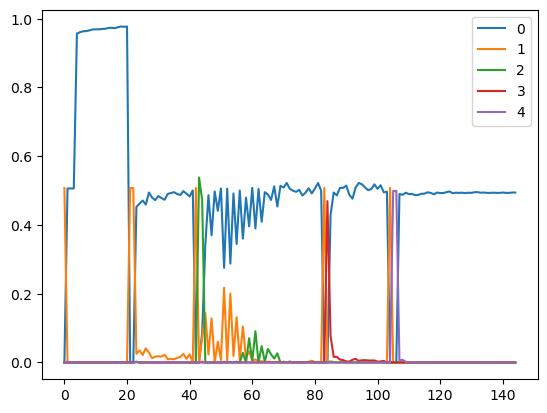

The average accuracy at the end of sequence is: 0.099
BWT:'-0.121'
FWT:'-0.127'


In [17]:
acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")